In [1]:
import os,sys
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
import matplotlib.pyplot as plt
sys.path.append('../LIB/')
from env import ENV
from sklearn.preprocessing import normalize
from tqdm import tqdm
import pickle
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import gc

print_to_file = False 
test_run = False 

train = pd.read_pickle(ENV.lightgbm_train_764.value)
print('train shape is: {}'.format(train.shape))
test = pd.read_pickle(ENV.lightgbm_test_764.value)
print('test shape is: {}'.format(test.shape))
fe_id = 'comb_764'

train shape is: (307511, 764)
test shape is: (48744, 763)


In [2]:
train['SK_ID_CURR'] = train['SK_ID_CURR'].astype(int)
test['SK_ID_CURR'] = test['SK_ID_CURR'].astype(int)
targets = train.TARGET.values

In [3]:
train_id = train['SK_ID_CURR']
test_id = test['SK_ID_CURR']

In [4]:
# X = pd.concat([train.drop('TARGET',axis=1),test])
# print(X.shape)

In [5]:
# categorical_col = ['ORGANIZATION_TYPE_x',
#  'CODE_GENDER_x',
#  'bureau_onehot_CREDIT_ACTIVE_Active',
#  'REGION_RATING_CLIENT_x',
#  'FLAG_WORK_PHONE_x',
#  'HOUR_APPR_PROCESS_START_y',
#  'FLAG_DOCUMENT_3_x',
#  'HOUR_APPR_PROCESS_START_x',
#  'unique_CODE_GENDER_NAME_EDUCATION_TYPE',
#  'REG_CITY_NOT_LIVE_CITY_x',
#  'REFUSED_HOUR_APPR_PROCESS_START_MIN',
#  'WEEKDAY_APPR_PROCESS_START_x',
#  'OCCUPATION_TYPE_x',
#  'CAT_MONTHS_BIRTH',
#  'ORGANIZATION_TYPE_Self-employed',
#  'ORGANIZATION_TYPE_School',
#  'OCCUPATION_TYPE_Core staff',
#  'ORGANIZATION_TYPE_Transport: type 3',
#  'ORGANIZATION_TYPE_Military',
#  'FLAG_DOCUMENT_18_x',
#  'ORGANIZATION_TYPE_Construction',
#  'prev_onehot_NAME_SELLER_INDUSTRY_Connectivity',
#  'WALLSMATERIAL_MODE_Stone, brick',
#  'NAME_INCOME_TYPE_State servant',
#  'bureau_onehot_CREDIT_TYPE_Credit card',
#  'OCCUPATION_TYPE_Drivers',
#  'REFUSED_HOUR_APPR_PROCESS_START_MAX',
#  'prev_onehot_NAME_YIELD_GROUP_2.0',
#  'prev_onehot_NAME_TYPE_SUITE_nan',
#  'FLAG_DOCUMENT_16_x',
#  'bureau_onehot_CREDIT_TYPE_Microloan',
#  'WEEKDAY_APPR_PROCESS_START_MONDAY',
#  'prev_WEEKDAY_APPR_PROCESS_START_max',
#  'OCCUPATION_TYPE_Medicine staff',
#  'NAME_HOUSING_TYPE_x',
#  'CONTACT',
#  'NAME_FAMILY_STATUS_x']

In [6]:
def one_hot_encoding(df,col,pre_fix,drop=True):
    df = df.copy()
    df[col] = df[col].fillna('NA_NOT_FOUND')
    col_name_list = []
    print('before encoding, shape is: {}'.format(df.shape))
    for each in df[col].unique():
        name = str(each)
        col_name = pre_fix + '_'+ name.replace(' ','_')
        col_name_list.append(col_name)
        df[col_name] = 0
        df.loc[df[col]==each,col_name] = 1
    if drop:
        df = df.drop([col],axis=1)
    print('after encoding, shape is: {}'.format(df.shape))
    return df,col_name_list

class ordinal_encoder:
    def __init__(self,fillna='NAN_FILL'):
        self.fillna = fillna
    
    def fit(self,sr,NA_VALUE=None,realNA2Nega1=True):
        """
        spycify the value which has already been encoded. make it to -1 after encoding
        """
        self.NA_VALUE=NA_VALUE
        order = sr.fillna(self.fillna).value_counts()
        if self.NA_VALUE is not None:
            order[NA_VALUE] = 9999999

        if realNA2Nega1:
            order[self.fillna] = 99999999
        order = order.sort_values(ascending=True)
        self.mapping = pd.Series(index=order.index.values, data=list(range(1,len(order)+1)))
        if self.NA_VALUE is not None:
            self.mapping[NA_VALUE] = -1

        if realNA2Nega1:
            self.mapping[self.fillna] = -1
    
    def transform(self,sr):
        sr = sr.copy()
        result = sr.fillna(self.fillna)
        result = result.map(self.mapping)
        return result
    
    def fit_transform(self,sr,NA_VALUE=None,realNA2Nega1=True):
        sr = sr.astype(str)
        self.fit(sr,NA_VALUE,realNA2Nega1)
        return self.transform(sr)

# main func

In [7]:
from sklearn.model_selection import train_test_split

def get_time(timezone='America/New_York', time_format='%Y-%m-%d %H:%M:%S'):
    from datetime import datetime
    from dateutil import tz

    # METHOD 1: Hardcode zones:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz(timezone)

    utc = datetime.utcnow()

    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)

    # Convert time zone
    est = utc.astimezone(to_zone)

    return est.strftime(time_format)

import sys, time
class Logger(object):
    def __init__(self, logtofile=True, logfilename='log'):
        self.terminal = sys.stdout
        self.logfile = "{}_{}.log".format(logfilename, int(time.time()))
        self.logtofile = logtofile

    def write(self, message):
        #         self.terminal.write(message)
        if self.logtofile:
            self.log = open(self.logfile, "a")
            self.log.write('[' + get_time() + '] ' + message)
            self.log.close()

    def flush(self):
        # this flush method is needed for python 3 compatibility.
        # this handles the flush command by doing nothing.
        # you might want to specify some extra behavior here.
        pass


def divert_printout_to_file():
    sys.stdout = Logger(logfilename='logfile')

if print_to_file:
    divert_printout_to_file()  # note: comment this to use pdb

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, train_df, test_df, holdout, num_folds, submission_file_name, fe_img_name, stratified = False, debug= False, colsample=0.67, max_depth=8, num_leaves=31, min_child_samples=20, subsample=0.7, reg_lambda=0.3, lr=0.04, seed=1001, verbose=100, rounds=None):
    print(train_df.shape, test_df.shape, holdout.shape)
    print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df['TARGET'].mean(), holdout['TARGET'].mean())
    # Divide in training/validation and test data
    if df is not None:
        train_df = df[df['TARGET'].notnull()]
        test_df = df[df['TARGET'].isnull()]
        print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
        del df
        gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    holdout_final_preds = np.zeros(holdout.shape[0])
    feature_importance_df = pd.DataFrame()
    feature_importance_gain_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_scores = []
    holdout_scores = []
    scores = []
    diff_val_holdout = []
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         print('valid index : ',list(valid_idx)[:5])
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
#         print('MEAN: train({}) vs valid({}): '.format(len(train_y), len(valid_y)), np.mean(train_y), np.mean(valid_y))

        clf = LGBMClassifier(
            nthread=18,
            n_estimators=30000,
            learning_rate=lr,
            num_leaves=num_leaves,
            colsample_bytree=colsample, # 0.67
            subsample=subsample,
            subsample_freq=0, ## disable subsampling
            max_depth=max_depth,
            reg_alpha=0.65,
            reg_lambda=reg_lambda,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            min_child_samples=min_child_samples,
            silent=-1,
            verbose=-1, )
        if rounds is not None:
            clf.n_estimators = rounds
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose=verbose)
            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
            holdout_preds = clf.predict_proba(holdout[feats])[:, 1] 
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose=verbose, early_stopping_rounds= 200)
            oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
            holdout_preds = clf.predict_proba(holdout[feats], num_iteration=clf.best_iteration_)[:, 1] 
            
        holdout_final_preds += holdout_preds / folds.n_splits
        score = roc_auc_score(valid_y, oof_preds[valid_idx])
        train_score = clf.best_score_['training']['auc']
        holdout_score = roc_auc_score(holdout['TARGET'], holdout_preds)
        diff = abs(score - holdout_score)
        best_rounds = rounds if rounds is not None else clf.best_iteration_
        print('Fold %2d [%5d] AUC : ho: %.6f / te: %.6f / tr: %.6f (diff: %.6f)' % (n_fold + 1, best_rounds, holdout_score, score,  train_score, diff))
        scores.append(score)
        train_scores.append(train_score)
        holdout_scores.append(holdout_score)
        diff_val_holdout.append(diff)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        fold_importance_gain_df = pd.DataFrame()
        fold_importance_gain_df["feature"] = feats
        fold_importance_gain_df["importance"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance_gain_df["fold"] = n_fold + 1
        feature_importance_gain_df = pd.concat([feature_importance_gain_df, fold_importance_gain_df], axis=0)
        
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
    holdout_roc = roc_auc_score(holdout['TARGET'], holdout_final_preds)
    holdout_mean = np.mean(holdout_scores)
    full_te_mean = np.mean(scores)
    full_tr_mean = np.mean(train_scores)
#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    print('Full HO score %.6f' % holdout_roc)
    print('FULL HO mean {:.6f}, std {:.6f}'.format(holdout_mean, np.std(holdout_scores)))
    print('FULL TE mean {:.6f}, std {:.6f}'.format(full_te_mean, np.std(scores)))
    print('FULL TR mean {:.6f}, std {:.6f}'.format(full_tr_mean, np.std(train_scores)))
    print('FULL DIFF mean {:.6f}, std {:.6f}'.format(np.mean(diff_val_holdout), np.std(diff_val_holdout)))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
#     if not print_to_file:
#         display_importances(feature_importance_df, fe_img_name)
    feature_importance_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    feature_importance_gain_df = feature_importance_gain_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    return feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds 

# Display/plot feature importance
def display_importances(feature_importance_df_, fe_img_name):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(fe_img_name+'.png')


def convert_and_save_imp_df(fe_imp_df, dumpfilename):
    fe_imp_df_mean = fe_imp_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    pickle.dump(fe_imp_df_mean, open(dumpfilename,'wb'))

In [8]:
def runlgb(train, test, holdout):
    colsamples = [0.07]#[0.1,0.15,0.2]#[0.03,0.04,0.05,0.06,0.07,0.08]
    seeds = [20]#[300,4000,50000,600000,7000000,80000000,523445,31275479] # 20
    depth = [5]
    leaves = [16]
    min_child_sam = [20]#, 800]
    subsamples = [1]#0.8, 0.7, 0.6, 0.5, 0.4] # was 1
    reg_lambdas = [0.5]
    # lrs = lrs.tolist()
    lrs2 = [0.1]
    nfolds = 4 
    rounds = [None] #[1000]#, 1300, 1600, 1900, 2200, 2500]
    for seed in seeds:
        for colsample in colsamples:
            for d in depth:
                for l in leaves:
                    for mcs in min_child_sam:
                        for subsample in subsamples:
                            for reg_lambda in reg_lambdas:
                                for lr in lrs2:
                                    for r in rounds:
                                        filename = 'fe_936_col{}_lr{}_n{}'.format(len(train.columns), lr, nfolds)
                                        print('#############################################')
                                        print(colsample, seed, d, l, mcs, subsample, reg_lambda, lr, 'nfolds:', nfolds)
                                        print('#############################################')
                                        numfeats = len(train.columns)
                                        with timer("Run LightGBM with kfold"):
                                            return kfold_lightgbm(None, train, test, holdout, nfolds, filename+'.csv', filename, colsample=colsample, verbose=None, max_depth=d, num_leaves=l, min_child_samples=mcs, subsample=subsample, reg_lambda=reg_lambda, lr=lr, seed=seed, stratified=True, rounds=r,debug=True)
    #                                         

In [9]:
train_df, holdout = train_test_split(train, test_size=1/7, random_state=42)
print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df['TARGET'].mean(), holdout['TARGET'].mean())
print(train_df.shape, test.shape, holdout.shape)

MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
(263580, 764) (48744, 763) (43931, 764)


# Experiment

In [10]:
feature = list(train_df.columns)
feature.remove('SK_ID_CURR')
feature.remove('TARGET')
feature.append('nodrop')
holdout_roc_list = []
holdout_mean_list = []
full_te_mean_list = []
full_tr_mean_list = []
drop_list = []
for col in tqdm(feature):
    if col == 'nodrop':
        train_drop = train_df.copy()
        test_drop = test.copy()
        holdout_drop = holdout.copy()
    else:
        try:
            train_drop = train_df.drop(col,axis=1)
            test_drop = test.drop(col,axis=1)
            holdout_drop = holdout.drop(col,axis=1)
        except:
            continue
    feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout_drop)
    holdout_roc_list.append(holdout_roc)
    holdout_mean_list.append(holdout_mean)
    full_te_mean_list.append(full_te_mean)
    full_tr_mean_list.append(full_tr_mean)
    drop_list.append(col)
    gc.collect()
    
df_save = pd.DataFrame({'drop_column':drop_list,
                        'holdout_roc':holdout_roc_list,
                        'holdout_mean':holdout_mean_list,
                        'full_te_mean':full_te_mean_list,
                        'full_tr_mean':full_tr_mean_list})
# df_save.to_pickle('dropEachColumnsReport.pkl')

  0%|          | 0/763 [00:00<?, ?it/s]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  510] AUC : ho: 0.791703 / te: 0.790265 / tr: 0.865256 (diff: 0.001438)
Fold  2 [  461] AUC : ho: 0.793164 / te: 0.789739 / tr: 0.859217 (diff: 0.003425)
Fold  3 [  534] AUC : ho: 0.790765 / te: 0.792585 / tr: 0.866140 (diff: 0.001820)
Fold  4 [  435] AUC : ho: 0.792364 / te: 0.786452 / tr: 0.857215 (diff: 0.005911)
Full HO score 0.796174
FULL HO mean 0.791999, std 0.000881
FULL TE mean 0.789760, std 0.002190
FULL TR mean 0.861957, std 0.003820
FULL DIFF mean 0.003149, std 0.001761
Run LightGBM with kfold - done in 70s


  0%|          | 1/763 [01:10<14:57:13, 70.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  426] AUC : ho: 0.793325 / te: 0.793621 / tr: 0.857490 (diff: 0.000296)
Fold  2 [  531] AUC : ho: 0.792559 / te: 0.791542 / tr: 0.868045 (diff: 0.001017)
Fold  3 [  515] AUC : ho: 0.792855 / te: 0.794091 / tr: 0.865123 (diff: 0.001236)
Fold  4 [  543] AUC : ho: 0.793982 / te: 0.789833 / tr: 0.869763 (diff: 0.004149)
Full HO score 0.797598
FULL HO mean 0.793180, std 0.000537
FULL TE mean 0.792272, std 0.001704
FULL TR mean 0.865105, std 0.004699
FULL DIFF mean 0.001675, std 0.001470
Run LightGBM with kfold - done in 70s


  0%|          | 2/763 [02:21<14:59:55, 70.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  658] AUC : ho: 0.790637 / te: 0.792948 / tr: 0.878960 (diff: 0.002311)
Fold  2 [  425] AUC : ho: 0.794544 / te: 0.790818 / tr: 0.855685 (diff: 0.003727)
Fold  3 [  403] AUC : ho: 0.792395 / te: 0.792555 / tr: 0.853139 (diff: 0.000160)
Fold  4 [  641] AUC : ho: 0.794647 / te: 0.789023 / tr: 0.877810 (diff: 0.005625)
Full HO score 0.797677
FULL HO mean 0.793056, std 0.001661
FULL TE mean 0.791336, std 0.001558
FULL TR mean 0.866398, std 0.012027
FULL DIFF mean 0.002956, std 0.001997
Run LightGBM with kfold - done in 72s


  0%|          | 3/763 [03:34<15:05:15, 71.47s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  592] AUC : ho: 0.792546 / te: 0.792120 / tr: 0.873510 (diff: 0.000426)
Fold  2 [  539] AUC : ho: 0.793187 / te: 0.792436 / tr: 0.869029 (diff: 0.000751)
Fold  3 [  647] AUC : ho: 0.792521 / te: 0.793726 / tr: 0.878005 (diff: 0.001204)
Fold  4 [  394] AUC : ho: 0.794291 / te: 0.789774 / tr: 0.853704 (diff: 0.004516)
Full HO score 0.797615
FULL HO mean 0.793136, std 0.000718
FULL TE mean 0.792014, std 0.001426
FULL TR mean 0.868562, std 0.009147
FULL DIFF mean 0.001724, std 0.001635
Run LightGBM with kfold - done in 72s


  1%|          | 4/763 [04:47<15:08:53, 71.85s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  463] AUC : ho: 0.792708 / te: 0.792948 / tr: 0.861226 (diff: 0.000241)
Fold  2 [  478] AUC : ho: 0.794773 / te: 0.792402 / tr: 0.861921 (diff: 0.002371)
Fold  3 [  510] AUC : ho: 0.794406 / te: 0.793445 / tr: 0.865138 (diff: 0.000961)
Fold  4 [  457] AUC : ho: 0.793827 / te: 0.788984 / tr: 0.860200 (diff: 0.004843)
Full HO score 0.797928
FULL HO mean 0.793928, std 0.000781
FULL TE mean 0.791945, std 0.001749
FULL TR mean 0.862121, std 0.001846
FULL DIFF mean 0.002104, std 0.001757
Run LightGBM with kfold - done in 69s


  1%|          | 5/763 [05:57<15:02:47, 71.46s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  510] AUC : ho: 0.791849 / te: 0.791217 / tr: 0.865130 (diff: 0.000631)
Fold  2 [  372] AUC : ho: 0.793515 / te: 0.791204 / tr: 0.849783 (diff: 0.002311)
Fold  3 [  496] AUC : ho: 0.794440 / te: 0.792737 / tr: 0.863002 (diff: 0.001703)
Fold  4 [  436] AUC : ho: 0.792647 / te: 0.788658 / tr: 0.858283 (diff: 0.003989)
Full HO score 0.797182
FULL HO mean 0.793112, std 0.000967
FULL TE mean 0.790954, std 0.001465
FULL TR mean 0.859049, std 0.005896
FULL DIFF mean 0.002158, std 0.001216
Run LightGBM with kfold - done in 68s


  1%|          | 6/763 [07:06<14:57:02, 71.10s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  666] AUC : ho: 0.791847 / te: 0.791705 / tr: 0.880736 (diff: 0.000143)
Fold  2 [  498] AUC : ho: 0.793776 / te: 0.792181 / tr: 0.865366 (diff: 0.001595)
Fold  3 [  550] AUC : ho: 0.793936 / te: 0.794387 / tr: 0.869422 (diff: 0.000452)
Fold  4 [  459] AUC : ho: 0.794942 / te: 0.789958 / tr: 0.860380 (diff: 0.004984)
Full HO score 0.798082
FULL HO mean 0.793625, std 0.001119
FULL TE mean 0.792058, std 0.001579
FULL TR mean 0.868976, std 0.007507
FULL DIFF mean 0.001793, std 0.001920
Run LightGBM with kfold - done in 72s


  1%|          | 7/763 [08:19<14:59:26, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  550] AUC : ho: 0.792655 / te: 0.792651 / tr: 0.870185 (diff: 0.000004)
Fold  2 [  514] AUC : ho: 0.792892 / te: 0.791930 / tr: 0.865728 (diff: 0.000962)
Fold  3 [  505] AUC : ho: 0.793560 / te: 0.793052 / tr: 0.863623 (diff: 0.000508)
Fold  4 [  655] AUC : ho: 0.795205 / te: 0.788125 / tr: 0.880288 (diff: 0.007081)
Full HO score 0.798332
FULL HO mean 0.793578, std 0.000996
FULL TE mean 0.791440, std 0.001956
FULL TR mean 0.869956, std 0.006418
FULL DIFF mean 0.002139, std 0.002873
Run LightGBM with kfold - done in 73s


  1%|          | 8/763 [09:33<15:01:50, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  455] AUC : ho: 0.794228 / te: 0.793386 / tr: 0.859469 (diff: 0.000841)
Fold  2 [  470] AUC : ho: 0.794396 / te: 0.791472 / tr: 0.860991 (diff: 0.002924)
Fold  3 [  560] AUC : ho: 0.794148 / te: 0.792264 / tr: 0.870160 (diff: 0.001884)
Fold  4 [  462] AUC : ho: 0.793555 / te: 0.788058 / tr: 0.861496 (diff: 0.005497)
Full HO score 0.798506
FULL HO mean 0.794082, std 0.000317
FULL TE mean 0.791295, std 0.001989
FULL TR mean 0.863029, std 0.004184
FULL DIFF mean 0.002787, std 0.001729
Run LightGBM with kfold - done in 70s


  1%|          | 9/763 [10:43<14:58:57, 71.54s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.792722 / te: 0.793260 / tr: 0.860290 (diff: 0.000538)
Fold  2 [  418] AUC : ho: 0.793967 / te: 0.791807 / tr: 0.855937 (diff: 0.002160)
Fold  3 [  550] AUC : ho: 0.794738 / te: 0.793226 / tr: 0.869005 (diff: 0.001511)
Fold  4 [  469] AUC : ho: 0.794912 / te: 0.788108 / tr: 0.861272 (diff: 0.006804)
Full HO score 0.798235
FULL HO mean 0.794085, std 0.000863
FULL TE mean 0.791600, std 0.002100
FULL TR mean 0.861626, std 0.004710
FULL DIFF mean 0.002753, std 0.002409
Run LightGBM with kfold - done in 68s


  1%|▏         | 10/763 [11:52<14:54:47, 71.30s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  548] AUC : ho: 0.792318 / te: 0.793100 / tr: 0.869870 (diff: 0.000782)
Fold  2 [  534] AUC : ho: 0.793842 / te: 0.792539 / tr: 0.868081 (diff: 0.001304)
Fold  3 [  525] AUC : ho: 0.793628 / te: 0.793027 / tr: 0.866733 (diff: 0.000601)
Fold  4 [  446] AUC : ho: 0.794034 / te: 0.788894 / tr: 0.858966 (diff: 0.005139)
Full HO score 0.797952
FULL HO mean 0.793455, std 0.000672
FULL TE mean 0.791890, std 0.001743
FULL TR mean 0.865912, std 0.004162
FULL DIFF mean 0.001956, std 0.001856
Run LightGBM with kfold - done in 70s


  1%|▏         | 11/763 [13:03<14:53:16, 71.27s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  646] AUC : ho: 0.792416 / te: 0.793422 / tr: 0.878852 (diff: 0.001006)
Fold  2 [  536] AUC : ho: 0.793934 / te: 0.791020 / tr: 0.868960 (diff: 0.002913)
Fold  3 [  508] AUC : ho: 0.794162 / te: 0.793213 / tr: 0.865582 (diff: 0.000948)
Fold  4 [  436] AUC : ho: 0.794654 / te: 0.788385 / tr: 0.858552 (diff: 0.006269)
Full HO score 0.798429
FULL HO mean 0.793791, std 0.000836
FULL TE mean 0.791510, std 0.002035
FULL TR mean 0.867987, std 0.007311
FULL DIFF mean 0.002784, std 0.002162
Run LightGBM with kfold - done in 72s


  2%|▏         | 12/763 [14:16<14:53:30, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  308] AUC : ho: 0.793299 / te: 0.792104 / tr: 0.842493 (diff: 0.001195)
Fold  2 [  436] AUC : ho: 0.793367 / te: 0.792349 / tr: 0.858137 (diff: 0.001017)
Fold  3 [  570] AUC : ho: 0.794127 / te: 0.794297 / tr: 0.871104 (diff: 0.000170)
Fold  4 [  464] AUC : ho: 0.794083 / te: 0.789995 / tr: 0.861969 (diff: 0.004088)
Full HO score 0.797916
FULL HO mean 0.793719, std 0.000387
FULL TE mean 0.792186, std 0.001524
FULL TR mean 0.858426, std 0.010335
FULL DIFF mean 0.001618, std 0.001478
Run LightGBM with kfold - done in 68s


  2%|▏         | 13/763 [15:25<14:49:49, 71.19s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  466] AUC : ho: 0.793562 / te: 0.792505 / tr: 0.860846 (diff: 0.001056)
Fold  2 [  552] AUC : ho: 0.793972 / te: 0.792361 / tr: 0.870265 (diff: 0.001611)
Fold  3 [  612] AUC : ho: 0.792990 / te: 0.793617 / tr: 0.874634 (diff: 0.000627)
Fold  4 [  463] AUC : ho: 0.794883 / te: 0.789087 / tr: 0.861761 (diff: 0.005796)
Full HO score 0.798227
FULL HO mean 0.793852, std 0.000690
FULL TE mean 0.791892, std 0.001691
FULL TR mean 0.866876, std 0.005792
FULL DIFF mean 0.002273, std 0.002064
Run LightGBM with kfold - done in 72s


  2%|▏         | 14/763 [16:37<14:49:51, 71.28s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  458] AUC : ho: 0.793991 / te: 0.792623 / tr: 0.860246 (diff: 0.001368)
Fold  2 [  465] AUC : ho: 0.795324 / te: 0.792288 / tr: 0.860792 (diff: 0.003036)
Fold  3 [  596] AUC : ho: 0.793429 / te: 0.794578 / tr: 0.874165 (diff: 0.001149)
Fold  4 [  455] AUC : ho: 0.793309 / te: 0.787697 / tr: 0.860441 (diff: 0.005612)
Full HO score 0.798308
FULL HO mean 0.794013, std 0.000799
FULL TE mean 0.791796, std 0.002523
FULL TR mean 0.863911, std 0.005923
FULL DIFF mean 0.002791, std 0.001784
Run LightGBM with kfold - done in 70s


  2%|▏         | 15/763 [17:48<14:48:23, 71.26s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  440] AUC : ho: 0.792848 / te: 0.792923 / tr: 0.858092 (diff: 0.000075)
Fold  2 [  446] AUC : ho: 0.794255 / te: 0.792728 / tr: 0.859221 (diff: 0.001528)
Fold  3 [  438] AUC : ho: 0.793783 / te: 0.793396 / tr: 0.857678 (diff: 0.000387)
Fold  4 [  470] AUC : ho: 0.792860 / te: 0.789449 / tr: 0.862409 (diff: 0.003411)
Full HO score 0.797455
FULL HO mean 0.793437, std 0.000606
FULL TE mean 0.792124, std 0.001563
FULL TR mean 0.859350, std 0.001854
FULL DIFF mean 0.001350, std 0.001307
Run LightGBM with kfold - done in 68s


  2%|▏         | 16/763 [18:57<14:45:11, 71.10s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  463] AUC : ho: 0.793869 / te: 0.793656 / tr: 0.860473 (diff: 0.000213)
Fold  2 [  547] AUC : ho: 0.794446 / te: 0.792666 / tr: 0.869505 (diff: 0.001780)
Fold  3 [  472] AUC : ho: 0.793563 / te: 0.793610 / tr: 0.860585 (diff: 0.000046)
Fold  4 [  447] AUC : ho: 0.793692 / te: 0.788790 / tr: 0.860212 (diff: 0.004902)
Full HO score 0.798058
FULL HO mean 0.793893, std 0.000338
FULL TE mean 0.792180, std 0.001997
FULL TR mean 0.862694, std 0.003935
FULL DIFF mean 0.001735, std 0.001949
Run LightGBM with kfold - done in 70s


  2%|▏         | 17/763 [20:07<14:43:26, 71.05s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  463] AUC : ho: 0.792662 / te: 0.793409 / tr: 0.860617 (diff: 0.000747)
Fold  2 [  461] AUC : ho: 0.794780 / te: 0.792495 / tr: 0.860327 (diff: 0.002285)
Fold  3 [  537] AUC : ho: 0.793800 / te: 0.794164 / tr: 0.868593 (diff: 0.000365)
Fold  4 [  510] AUC : ho: 0.793033 / te: 0.789496 / tr: 0.866910 (diff: 0.003537)
Full HO score 0.797727
FULL HO mean 0.793569, std 0.000811
FULL TE mean 0.792391, std 0.001773
FULL TR mean 0.864112, std 0.003690
FULL DIFF mean 0.001733, std 0.001265
Run LightGBM with kfold - done in 70s


  2%|▏         | 18/763 [21:18<14:42:01, 71.04s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  605] AUC : ho: 0.792513 / te: 0.794076 / tr: 0.876178 (diff: 0.001563)
Fold  2 [  430] AUC : ho: 0.794841 / te: 0.792805 / tr: 0.856642 (diff: 0.002036)
Fold  3 [  552] AUC : ho: 0.793228 / te: 0.793537 / tr: 0.869480 (diff: 0.000309)
Fold  4 [  508] AUC : ho: 0.794789 / te: 0.789217 / tr: 0.866313 (diff: 0.005572)
Full HO score 0.798258
FULL HO mean 0.793843, std 0.001005
FULL TE mean 0.792409, std 0.001897
FULL TR mean 0.867153, std 0.007037
FULL DIFF mean 0.002370, std 0.001953
Run LightGBM with kfold - done in 71s


  2%|▏         | 19/763 [22:30<14:41:40, 71.10s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  455] AUC : ho: 0.792934 / te: 0.793577 / tr: 0.859687 (diff: 0.000643)
Fold  2 [  534] AUC : ho: 0.793965 / te: 0.793140 / tr: 0.868312 (diff: 0.000825)
Fold  3 [  559] AUC : ho: 0.793554 / te: 0.792917 / tr: 0.869830 (diff: 0.000637)
Fold  4 [  458] AUC : ho: 0.794163 / te: 0.788507 / tr: 0.860398 (diff: 0.005656)
Full HO score 0.798137
FULL HO mean 0.793654, std 0.000470
FULL TE mean 0.792035, std 0.002051
FULL TR mean 0.864557, std 0.004553
FULL DIFF mean 0.001940, std 0.002147
Run LightGBM with kfold - done in 70s


  3%|▎         | 20/763 [23:42<14:40:31, 71.11s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  419] AUC : ho: 0.793686 / te: 0.793858 / tr: 0.856570 (diff: 0.000172)
Fold  2 [  684] AUC : ho: 0.794138 / te: 0.792680 / tr: 0.882791 (diff: 0.001457)
Fold  3 [  427] AUC : ho: 0.792787 / te: 0.792605 / tr: 0.855646 (diff: 0.000182)
Fold  4 [  410] AUC : ho: 0.793838 / te: 0.788669 / tr: 0.855507 (diff: 0.005169)
Full HO score 0.797865
FULL HO mean 0.793612, std 0.000503
FULL TE mean 0.791953, std 0.001960
FULL TR mean 0.862628, std 0.011648
FULL DIFF mean 0.001745, std 0.002045
Run LightGBM with kfold - done in 70s


  3%|▎         | 21/763 [24:52<14:38:58, 71.08s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  531] AUC : ho: 0.793621 / te: 0.793003 / tr: 0.868163 (diff: 0.000618)
Fold  2 [  544] AUC : ho: 0.794657 / te: 0.792856 / tr: 0.869411 (diff: 0.001801)
Fold  3 [  510] AUC : ho: 0.794005 / te: 0.794230 / tr: 0.865511 (diff: 0.000226)
Fold  4 [  487] AUC : ho: 0.793067 / te: 0.789135 / tr: 0.863946 (diff: 0.003931)
Full HO score 0.798284
FULL HO mean 0.793837, std 0.000579
FULL TE mean 0.792306, std 0.001907
FULL TR mean 0.866758, std 0.002149
FULL DIFF mean 0.001644, std 0.001442
Run LightGBM with kfold - done in 71s


  3%|▎         | 22/763 [26:04<14:38:14, 71.11s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  601] AUC : ho: 0.792399 / te: 0.793222 / tr: 0.874892 (diff: 0.000823)
Fold  2 [  574] AUC : ho: 0.793628 / te: 0.792399 / tr: 0.872807 (diff: 0.001229)
Fold  3 [  439] AUC : ho: 0.793798 / te: 0.792228 / tr: 0.857460 (diff: 0.001570)
Fold  4 [  394] AUC : ho: 0.793872 / te: 0.789170 / tr: 0.853913 (diff: 0.004702)
Full HO score 0.797958
FULL HO mean 0.793424, std 0.000598
FULL TE mean 0.791755, std 0.001539
FULL TR mean 0.864768, std 0.009197
FULL DIFF mean 0.002081, std 0.001536
Run LightGBM with kfold - done in 71s


  3%|▎         | 23/763 [27:15<14:37:11, 71.12s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  615] AUC : ho: 0.792197 / te: 0.793403 / tr: 0.876295 (diff: 0.001206)
Fold  2 [  671] AUC : ho: 0.792557 / te: 0.794044 / tr: 0.882051 (diff: 0.001487)
Fold  3 [  593] AUC : ho: 0.793538 / te: 0.792549 / tr: 0.873409 (diff: 0.000988)
Fold  4 [  460] AUC : ho: 0.793403 / te: 0.789769 / tr: 0.861416 (diff: 0.003634)
Full HO score 0.797694
FULL HO mean 0.792924, std 0.000563
FULL TE mean 0.792441, std 0.001631
FULL TR mean 0.873293, std 0.007530
FULL DIFF mean 0.001829, std 0.001057
Run LightGBM with kfold - done in 74s


  3%|▎         | 24/763 [28:30<14:38:01, 71.29s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  423] AUC : ho: 0.792950 / te: 0.793024 / tr: 0.856999 (diff: 0.000074)
Fold  2 [  567] AUC : ho: 0.793743 / te: 0.793858 / tr: 0.871987 (diff: 0.000116)
Fold  3 [  503] AUC : ho: 0.794083 / te: 0.792868 / tr: 0.864758 (diff: 0.001216)
Fold  4 [  534] AUC : ho: 0.793165 / te: 0.789250 / tr: 0.869163 (diff: 0.003915)
Full HO score 0.797836
FULL HO mean 0.793485, std 0.000451
FULL TE mean 0.792250, std 0.001773
FULL TR mean 0.865727, std 0.005659
FULL DIFF mean 0.001330, std 0.001561
Run LightGBM with kfold - done in 71s


  3%|▎         | 25/763 [29:42<14:36:58, 71.30s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  477] AUC : ho: 0.792621 / te: 0.792658 / tr: 0.863069 (diff: 0.000038)
Fold  2 [  495] AUC : ho: 0.794881 / te: 0.792840 / tr: 0.864242 (diff: 0.002040)
Fold  3 [  549] AUC : ho: 0.792647 / te: 0.792972 / tr: 0.869002 (diff: 0.000325)
Fold  4 [  407] AUC : ho: 0.793428 / te: 0.788782 / tr: 0.855155 (diff: 0.004646)
Full HO score 0.797711
FULL HO mean 0.793394, std 0.000918
FULL TE mean 0.791813, std 0.001754
FULL TR mean 0.862867, std 0.004976
FULL DIFF mean 0.001762, std 0.001833
Run LightGBM with kfold - done in 70s


  3%|▎         | 26/763 [30:52<14:35:21, 71.26s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  428] AUC : ho: 0.793535 / te: 0.793309 / tr: 0.857561 (diff: 0.000226)
Fold  2 [  464] AUC : ho: 0.794906 / te: 0.793287 / tr: 0.861512 (diff: 0.001619)
Fold  3 [  495] AUC : ho: 0.794682 / te: 0.792567 / tr: 0.863358 (diff: 0.002115)
Fold  4 [  454] AUC : ho: 0.793311 / te: 0.790354 / tr: 0.860025 (diff: 0.002957)
Full HO score 0.798132
FULL HO mean 0.794109, std 0.000695
FULL TE mean 0.792379, std 0.001207
FULL TR mean 0.860614, std 0.002122
FULL DIFF mean 0.001729, std 0.000991
Run LightGBM with kfold - done in 69s


  4%|▎         | 27/763 [32:02<14:33:21, 71.20s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  520] AUC : ho: 0.792739 / te: 0.793289 / tr: 0.867179 (diff: 0.000549)
Fold  2 [  441] AUC : ho: 0.793491 / te: 0.792884 / tr: 0.858730 (diff: 0.000607)
Fold  3 [  510] AUC : ho: 0.794677 / te: 0.793371 / tr: 0.865284 (diff: 0.001306)
Fold  4 [  461] AUC : ho: 0.793411 / te: 0.789322 / tr: 0.861442 (diff: 0.004089)
Full HO score 0.797968
FULL HO mean 0.793580, std 0.000698
FULL TE mean 0.792217, std 0.001681
FULL TR mean 0.863159, std 0.003288
FULL DIFF mean 0.001638, std 0.001446
Run LightGBM with kfold - done in 70s


  4%|▎         | 28/763 [33:13<14:31:56, 71.18s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  660] AUC : ho: 0.793092 / te: 0.792490 / tr: 0.879766 (diff: 0.000603)
Fold  2 [  543] AUC : ho: 0.793618 / te: 0.791819 / tr: 0.869800 (diff: 0.001800)
Fold  3 [  413] AUC : ho: 0.793758 / te: 0.792888 / tr: 0.854758 (diff: 0.000869)
Fold  4 [  445] AUC : ho: 0.793622 / te: 0.789008 / tr: 0.859745 (diff: 0.004614)
Full HO score 0.798109
FULL HO mean 0.793523, std 0.000255
FULL TE mean 0.791551, std 0.001517
FULL TR mean 0.866017, std 0.009610
FULL DIFF mean 0.001972, std 0.001589
Run LightGBM with kfold - done in 71s


  4%|▍         | 29/763 [34:25<14:31:06, 71.21s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  476] AUC : ho: 0.794183 / te: 0.792716 / tr: 0.862054 (diff: 0.001467)
Fold  2 [  550] AUC : ho: 0.793928 / te: 0.793159 / tr: 0.869951 (diff: 0.000769)
Fold  3 [  508] AUC : ho: 0.792943 / te: 0.794145 / tr: 0.864766 (diff: 0.001203)
Fold  4 [  495] AUC : ho: 0.793305 / te: 0.788358 / tr: 0.865056 (diff: 0.004947)
Full HO score 0.797864
FULL HO mean 0.793590, std 0.000491
FULL TE mean 0.792095, std 0.002219
FULL TR mean 0.865457, std 0.002847
FULL DIFF mean 0.002096, std 0.001664
Run LightGBM with kfold - done in 71s


  4%|▍         | 30/763 [35:36<14:30:08, 71.23s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  402] AUC : ho: 0.793336 / te: 0.792670 / tr: 0.854276 (diff: 0.000666)
Fold  2 [  503] AUC : ho: 0.793744 / te: 0.792930 / tr: 0.865435 (diff: 0.000814)
Fold  3 [  488] AUC : ho: 0.793724 / te: 0.794218 / tr: 0.863477 (diff: 0.000494)
Fold  4 [  465] AUC : ho: 0.793027 / te: 0.788480 / tr: 0.861127 (diff: 0.004547)
Full HO score 0.797491
FULL HO mean 0.793458, std 0.000297
FULL TE mean 0.792074, std 0.002157
FULL TR mean 0.861079, std 0.004213
FULL DIFF mean 0.001630, std 0.001688
Run LightGBM with kfold - done in 69s


  4%|▍         | 31/763 [36:46<14:28:17, 71.17s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  466] AUC : ho: 0.793887 / te: 0.793045 / tr: 0.861329 (diff: 0.000842)
Fold  2 [  498] AUC : ho: 0.794614 / te: 0.794030 / tr: 0.864381 (diff: 0.000584)
Fold  3 [  541] AUC : ho: 0.794146 / te: 0.794164 / tr: 0.868410 (diff: 0.000018)
Fold  4 [  436] AUC : ho: 0.794090 / te: 0.788669 / tr: 0.858761 (diff: 0.005421)
Full HO score 0.798539
FULL HO mean 0.794184, std 0.000266
FULL TE mean 0.792477, std 0.002241
FULL TR mean 0.863220, std 0.003596
FULL DIFF mean 0.001716, std 0.002160
Run LightGBM with kfold - done in 70s


  4%|▍         | 32/763 [37:56<14:26:50, 71.15s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.793164 / te: 0.793647 / tr: 0.863578 (diff: 0.000482)
Fold  2 [  464] AUC : ho: 0.793113 / te: 0.792732 / tr: 0.860595 (diff: 0.000381)
Fold  3 [  544] AUC : ho: 0.794562 / te: 0.792863 / tr: 0.868495 (diff: 0.001698)
Fold  4 [  464] AUC : ho: 0.794239 / te: 0.788298 / tr: 0.860793 (diff: 0.005942)
Full HO score 0.798005
FULL HO mean 0.793770, std 0.000641
FULL TE mean 0.791885, std 0.002100
FULL TR mean 0.863365, std 0.003188
FULL DIFF mean 0.002126, std 0.002263
Run LightGBM with kfold - done in 70s


  4%|▍         | 33/763 [39:07<14:25:27, 71.13s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  410] AUC : ho: 0.792957 / te: 0.794317 / tr: 0.854707 (diff: 0.001359)
Fold  2 [  456] AUC : ho: 0.793313 / te: 0.792749 / tr: 0.859748 (diff: 0.000564)
Fold  3 [  602] AUC : ho: 0.792476 / te: 0.793604 / tr: 0.874302 (diff: 0.001128)
Fold  4 [  604] AUC : ho: 0.795112 / te: 0.789747 / tr: 0.875755 (diff: 0.005364)
Full HO score 0.797815
FULL HO mean 0.793464, std 0.000996
FULL TE mean 0.792604, std 0.001740
FULL TR mean 0.866128, std 0.009092
FULL DIFF mean 0.002104, std 0.001905
Run LightGBM with kfold - done in 71s


  4%|▍         | 34/763 [40:19<14:24:36, 71.16s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  457] AUC : ho: 0.792779 / te: 0.792800 / tr: 0.860505 (diff: 0.000020)
Fold  2 [  459] AUC : ho: 0.794029 / te: 0.792530 / tr: 0.860661 (diff: 0.001499)
Fold  3 [  554] AUC : ho: 0.793517 / te: 0.792819 / tr: 0.869144 (diff: 0.000698)
Fold  4 [  517] AUC : ho: 0.794038 / te: 0.789312 / tr: 0.867203 (diff: 0.004726)
Full HO score 0.797836
FULL HO mean 0.793591, std 0.000514
FULL TE mean 0.791865, std 0.001479
FULL TR mean 0.864379, std 0.003857
FULL DIFF mean 0.001736, std 0.001804
Run LightGBM with kfold - done in 71s


  5%|▍         | 35/763 [41:30<14:23:29, 71.17s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  411] AUC : ho: 0.792198 / te: 0.792710 / tr: 0.855182 (diff: 0.000512)
Fold  2 [  367] AUC : ho: 0.794610 / te: 0.792899 / tr: 0.850265 (diff: 0.001711)
Fold  3 [  521] AUC : ho: 0.795204 / te: 0.793804 / tr: 0.866057 (diff: 0.001400)
Fold  4 [  486] AUC : ho: 0.794052 / te: 0.789501 / tr: 0.864111 (diff: 0.004551)
Full HO score 0.798117
FULL HO mean 0.794016, std 0.001126
FULL TE mean 0.792228, std 0.001628
FULL TR mean 0.858904, std 0.006457
FULL DIFF mean 0.002044, std 0.001513
Run LightGBM with kfold - done in 67s


  5%|▍         | 36/763 [42:38<14:21:06, 71.07s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  401] AUC : ho: 0.792693 / te: 0.793247 / tr: 0.854425 (diff: 0.000554)
Fold  2 [  432] AUC : ho: 0.794132 / te: 0.792349 / tr: 0.857441 (diff: 0.001783)
Fold  3 [  569] AUC : ho: 0.794095 / te: 0.793779 / tr: 0.871887 (diff: 0.000317)
Fold  4 [  426] AUC : ho: 0.794124 / te: 0.788259 / tr: 0.857045 (diff: 0.005865)
Full HO score 0.797843
FULL HO mean 0.793761, std 0.000617
FULL TE mean 0.791908, std 0.002168
FULL TR mean 0.860200, std 0.006847
FULL DIFF mean 0.002130, std 0.002227
Run LightGBM with kfold - done in 68s


  5%|▍         | 37/763 [43:47<14:19:14, 71.01s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  373] AUC : ho: 0.792934 / te: 0.792037 / tr: 0.850501 (diff: 0.000897)
Fold  2 [  500] AUC : ho: 0.794562 / te: 0.793028 / tr: 0.864979 (diff: 0.001534)
Fold  3 [  524] AUC : ho: 0.794442 / te: 0.793433 / tr: 0.866710 (diff: 0.001009)
Fold  4 [  441] AUC : ho: 0.793399 / te: 0.788443 / tr: 0.859401 (diff: 0.004956)
Full HO score 0.797949
FULL HO mean 0.793834, std 0.000689
FULL TE mean 0.791735, std 0.001968
FULL TR mean 0.860398, std 0.006320
FULL DIFF mean 0.002099, std 0.001667
Run LightGBM with kfold - done in 68s


  5%|▍         | 38/763 [44:56<14:17:28, 70.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  412] AUC : ho: 0.792679 / te: 0.792782 / tr: 0.855319 (diff: 0.000103)
Fold  2 [  461] AUC : ho: 0.793775 / te: 0.792772 / tr: 0.859997 (diff: 0.001003)
Fold  3 [  566] AUC : ho: 0.792960 / te: 0.793008 / tr: 0.870413 (diff: 0.000048)
Fold  4 [  468] AUC : ho: 0.792176 / te: 0.787862 / tr: 0.862534 (diff: 0.004314)
Full HO score 0.797036
FULL HO mean 0.792897, std 0.000579
FULL TE mean 0.791606, std 0.002164
FULL TR mean 0.862066, std 0.005470
FULL DIFF mean 0.001367, std 0.001743
Run LightGBM with kfold - done in 69s


  5%|▌         | 39/763 [46:06<14:15:57, 70.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  438] AUC : ho: 0.792652 / te: 0.792748 / tr: 0.858423 (diff: 0.000096)
Fold  2 [  465] AUC : ho: 0.794956 / te: 0.793155 / tr: 0.859813 (diff: 0.001801)
Fold  3 [  523] AUC : ho: 0.793911 / te: 0.793369 / tr: 0.866845 (diff: 0.000542)
Fold  4 [  468] AUC : ho: 0.794122 / te: 0.788332 / tr: 0.861928 (diff: 0.005790)
Full HO score 0.798131
FULL HO mean 0.793910, std 0.000825
FULL TE mean 0.791901, std 0.002072
FULL TR mean 0.861752, std 0.003194
FULL DIFF mean 0.002057, std 0.002244
Run LightGBM with kfold - done in 69s


  5%|▌         | 40/763 [47:16<14:14:27, 70.91s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  291] AUC : ho: 0.792675 / te: 0.792824 / tr: 0.839632 (diff: 0.000149)
Fold  2 [  554] AUC : ho: 0.795274 / te: 0.792107 / tr: 0.869881 (diff: 0.003167)
Fold  3 [  431] AUC : ho: 0.794843 / te: 0.792935 / tr: 0.856404 (diff: 0.001907)
Fold  4 [  564] AUC : ho: 0.794182 / te: 0.788793 / tr: 0.871451 (diff: 0.005388)
Full HO score 0.798422
FULL HO mean 0.794243, std 0.000986
FULL TE mean 0.791665, std 0.001688
FULL TR mean 0.859342, std 0.012795
FULL DIFF mean 0.002653, std 0.001909
Run LightGBM with kfold - done in 68s


  5%|▌         | 41/763 [48:25<14:12:46, 70.87s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  609] AUC : ho: 0.791111 / te: 0.792645 / tr: 0.875631 (diff: 0.001534)
Fold  2 [  523] AUC : ho: 0.792900 / te: 0.792478 / tr: 0.867300 (diff: 0.000422)
Fold  3 [  461] AUC : ho: 0.794447 / te: 0.792610 / tr: 0.860190 (diff: 0.001837)
Fold  4 [  461] AUC : ho: 0.793926 / te: 0.788022 / tr: 0.861118 (diff: 0.005903)
Full HO score 0.797409
FULL HO mean 0.793096, std 0.001274
FULL TE mean 0.791439, std 0.001973
FULL TR mean 0.866060, std 0.006165
FULL DIFF mean 0.002424, std 0.002077
Run LightGBM with kfold - done in 71s


  6%|▌         | 42/763 [49:37<14:11:55, 70.89s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  498] AUC : ho: 0.791989 / te: 0.792206 / tr: 0.864899 (diff: 0.000216)
Fold  2 [  567] AUC : ho: 0.794125 / te: 0.793264 / tr: 0.871058 (diff: 0.000861)
Fold  3 [  590] AUC : ho: 0.793552 / te: 0.794613 / tr: 0.873064 (diff: 0.001061)
Fold  4 [  410] AUC : ho: 0.794263 / te: 0.788336 / tr: 0.855427 (diff: 0.005927)
Full HO score 0.797904
FULL HO mean 0.793482, std 0.000902
FULL TE mean 0.792105, std 0.002337
FULL TR mean 0.866112, std 0.006863
FULL DIFF mean 0.002016, std 0.002279
Run LightGBM with kfold - done in 71s


  6%|▌         | 43/763 [50:49<14:10:58, 70.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  467] AUC : ho: 0.792593 / te: 0.793026 / tr: 0.861524 (diff: 0.000432)
Fold  2 [  496] AUC : ho: 0.793763 / te: 0.791545 / tr: 0.864132 (diff: 0.002218)
Fold  3 [  543] AUC : ho: 0.793267 / te: 0.793869 / tr: 0.868678 (diff: 0.000601)
Fold  4 [  637] AUC : ho: 0.793017 / te: 0.789113 / tr: 0.879367 (diff: 0.003904)
Full HO score 0.797634
FULL HO mean 0.793160, std 0.000423
FULL TE mean 0.791888, std 0.001805
FULL TR mean 0.868425, std 0.006816
FULL DIFF mean 0.001789, std 0.001406
Run LightGBM with kfold - done in 72s


  6%|▌         | 44/763 [52:02<14:10:22, 70.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  461] AUC : ho: 0.791669 / te: 0.792600 / tr: 0.860367 (diff: 0.000932)
Fold  2 [  549] AUC : ho: 0.793428 / te: 0.792899 / tr: 0.869225 (diff: 0.000529)
Fold  3 [  554] AUC : ho: 0.793848 / te: 0.793405 / tr: 0.870893 (diff: 0.000443)
Fold  4 [  499] AUC : ho: 0.792686 / te: 0.788609 / tr: 0.865328 (diff: 0.004077)
Full HO score 0.797399
FULL HO mean 0.792907, std 0.000827
FULL TE mean 0.791878, std 0.001909
FULL TR mean 0.866453, std 0.004053
FULL DIFF mean 0.001495, std 0.001502
Run LightGBM with kfold - done in 71s


  6%|▌         | 45/763 [53:14<14:09:30, 70.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.791987 / te: 0.792789 / tr: 0.859402 (diff: 0.000802)
Fold  2 [  709] AUC : ho: 0.792118 / te: 0.793301 / tr: 0.884406 (diff: 0.001183)
Fold  3 [  512] AUC : ho: 0.792946 / te: 0.793525 / tr: 0.865548 (diff: 0.000579)


  6%|▌         | 46/763 [54:28<14:09:10, 71.06s/it]

Fold  4 [  585] AUC : ho: 0.793750 / te: 0.788725 / tr: 0.874627 (diff: 0.005025)
Full HO score 0.797414
FULL HO mean 0.792700, std 0.000709
FULL TE mean 0.792085, std 0.001958
FULL TR mean 0.870996, std 0.009449
FULL DIFF mean 0.001897, std 0.001819
Run LightGBM with kfold - done in 73s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  429] AUC : ho: 0.791668 / te: 0.793447 / tr: 0.857129 (diff: 0.001779)
Fold  2 [  463] AUC : ho: 0.794290 / te: 0.792282 / tr: 0.859882 (diff: 0.002008)
Fold  3 [  555] AUC : ho: 0.793926 / te: 0.793184 / tr: 0.868972 (diff: 0.000742)
Fold  4 [  590] AUC : ho: 0.793816 / te: 0.788519 / tr: 0.874558 (diff: 0.005297)
Full HO score 0.797832
FULL HO mean 0.793425, std 0.001029
FULL TE mean 0.791858, std 0.001976
FULL TR mean 0.865135, std 0.006986
FULL 

  6%|▌         | 47/763 [55:40<14:08:08, 71.07s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  459] AUC : ho: 0.793534 / te: 0.794115 / tr: 0.860426 (diff: 0.000580)
Fold  2 [  493] AUC : ho: 0.794433 / te: 0.791858 / tr: 0.863142 (diff: 0.002575)
Fold  3 [  546] AUC : ho: 0.793560 / te: 0.793437 / tr: 0.868083 (diff: 0.000123)
Fold  4 [  373] AUC : ho: 0.793021 / te: 0.788192 / tr: 0.850722 (diff: 0.004829)
Full HO score 0.797672
FULL HO mean 0.793637, std 0.000507
FULL TE mean 0.791900, std 0.002292
FULL TR mean 0.860593, std 0.006326
FULL DIFF mean 0.002027, std 0.001862
Run LightGBM with kfold - done in 69s


  6%|▋         | 48/763 [56:50<14:06:36, 71.04s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  740] AUC : ho: 0.791703 / te: 0.793680 / tr: 0.886762 (diff: 0.001977)
Fold  2 [  591] AUC : ho: 0.793049 / te: 0.792731 / tr: 0.874861 (diff: 0.000318)
Fold  3 [  417] AUC : ho: 0.792971 / te: 0.793007 / tr: 0.855001 (diff: 0.000036)
Fold  4 [  372] AUC : ho: 0.793493 / te: 0.787859 / tr: 0.851300 (diff: 0.005633)
Full HO score 0.797490
FULL HO mean 0.792804, std 0.000666
FULL TE mean 0.791820, std 0.002312
FULL TR mean 0.866981, std 0.014516
FULL DIFF mean 0.001991, std 0.002230
Run LightGBM with kfold - done in 72s


  6%|▋         | 49/763 [58:02<14:05:50, 71.08s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  517] AUC : ho: 0.792119 / te: 0.794182 / tr: 0.866068 (diff: 0.002063)
Fold  2 [  581] AUC : ho: 0.791875 / te: 0.791850 / tr: 0.873188 (diff: 0.000025)
Fold  3 [  729] AUC : ho: 0.792117 / te: 0.793551 / tr: 0.885242 (diff: 0.001434)


  7%|▋         | 50/763 [59:17<14:05:27, 71.15s/it]

Fold  4 [  564] AUC : ho: 0.794009 / te: 0.789403 / tr: 0.871935 (diff: 0.004606)
Full HO score 0.797339
FULL HO mean 0.792530, std 0.000860
FULL TE mean 0.792246, std 0.001850
FULL TR mean 0.874108, std 0.006967
FULL DIFF mean 0.002032, std 0.001659
Run LightGBM with kfold - done in 74s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  458] AUC : ho: 0.793353 / te: 0.793502 / tr: 0.860067 (diff: 0.000149)
Fold  2 [  557] AUC : ho: 0.792310 / te: 0.791885 / tr: 0.870374 (diff: 0.000425)
Fold  3 [  924] AUC : ho: 0.794212 / te: 0.794128 / tr: 0.900999 (diff: 0.000084)
Fold  4 [  509] AUC : ho: 0.793241 / te: 0.788653 / tr: 0.866237 (diff: 0.004588)
Full HO score 0.798287
FULL HO mean 0.793279, std 0.000674
FULL TE mean 0.792042, std 0.002121
FULL TR mean 0.874419, std 0.015778
FULL 

  7%|▋         | 51/763 [1:00:33<14:05:31, 71.25s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  479] AUC : ho: 0.792870 / te: 0.793310 / tr: 0.861949 (diff: 0.000441)
Fold  2 [  497] AUC : ho: 0.793221 / te: 0.792715 / tr: 0.864091 (diff: 0.000506)
Fold  3 [  466] AUC : ho: 0.794812 / te: 0.792981 / tr: 0.860305 (diff: 0.001831)
Fold  4 [  417] AUC : ho: 0.793296 / te: 0.788297 / tr: 0.856464 (diff: 0.004999)
Full HO score 0.797646
FULL HO mean 0.793550, std 0.000746
FULL TE mean 0.791826, std 0.002048
FULL TR mean 0.860702, std 0.002791
FULL DIFF mean 0.001944, std 0.001849
Run LightGBM with kfold - done in 69s


  7%|▋         | 52/763 [1:01:43<14:04:00, 71.22s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  425] AUC : ho: 0.792825 / te: 0.793235 / tr: 0.856411 (diff: 0.000411)
Fold  2 [  560] AUC : ho: 0.794093 / te: 0.792622 / tr: 0.870737 (diff: 0.001471)
Fold  3 [  655] AUC : ho: 0.792757 / te: 0.793557 / tr: 0.879723 (diff: 0.000800)
Fold  4 [  462] AUC : ho: 0.792713 / te: 0.788424 / tr: 0.861500 (diff: 0.004289)
Full HO score 0.797513
FULL HO mean 0.793097, std 0.000576
FULL TE mean 0.791960, std 0.002069
FULL TR mean 0.867093, std 0.008919
FULL DIFF mean 0.001743, std 0.001518
Run LightGBM with kfold - done in 72s


  7%|▋         | 53/763 [1:02:56<14:03:06, 71.25s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  413] AUC : ho: 0.793002 / te: 0.792376 / tr: 0.855651 (diff: 0.000626)
Fold  2 [  466] AUC : ho: 0.793951 / te: 0.792138 / tr: 0.860484 (diff: 0.001813)
Fold  3 [  466] AUC : ho: 0.794767 / te: 0.793537 / tr: 0.860726 (diff: 0.001229)
Fold  4 [  463] AUC : ho: 0.793034 / te: 0.788445 / tr: 0.860595 (diff: 0.004589)
Full HO score 0.797741
FULL HO mean 0.793688, std 0.000730
FULL TE mean 0.791624, std 0.001910
FULL TR mean 0.859364, std 0.002145
FULL DIFF mean 0.002064, std 0.001517
Run LightGBM with kfold - done in 67s


  7%|▋         | 54/763 [1:04:03<14:01:06, 71.18s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  331] AUC : ho: 0.793384 / te: 0.793237 / tr: 0.845019 (diff: 0.000147)
Fold  2 [  506] AUC : ho: 0.793873 / te: 0.792088 / tr: 0.865472 (diff: 0.001786)
Fold  3 [  520] AUC : ho: 0.794157 / te: 0.793761 / tr: 0.865939 (diff: 0.000396)
Fold  4 [  485] AUC : ho: 0.793635 / te: 0.788608 / tr: 0.863302 (diff: 0.005027)
Full HO score 0.797842
FULL HO mean 0.793762, std 0.000286
FULL TE mean 0.791923, std 0.002008
FULL TR mean 0.859933, std 0.008668
FULL DIFF mean 0.001839, std 0.001944
Run LightGBM with kfold - done in 69s


  7%|▋         | 55/763 [1:05:13<13:59:33, 71.15s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  364] AUC : ho: 0.793375 / te: 0.792727 / tr: 0.848861 (diff: 0.000648)
Fold  2 [  505] AUC : ho: 0.794066 / te: 0.791243 / tr: 0.864302 (diff: 0.002823)
Fold  3 [  812] AUC : ho: 0.791636 / te: 0.793399 / tr: 0.893059 (diff: 0.001764)
Fold  4 [  464] AUC : ho: 0.792798 / te: 0.788885 / tr: 0.861109 (diff: 0.003913)
Full HO score 0.797509
FULL HO mean 0.792969, std 0.000891
FULL TE mean 0.791563, std 0.001732
FULL TR mean 0.866833, std 0.016201
FULL DIFF mean 0.002287, std 0.001214
Run LightGBM with kfold - done in 72s


  7%|▋         | 56/763 [1:06:26<13:58:45, 71.18s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.793527 / te: 0.793220 / tr: 0.862592 (diff: 0.000307)
Fold  2 [  486] AUC : ho: 0.793563 / te: 0.792741 / tr: 0.862800 (diff: 0.000822)
Fold  3 [  482] AUC : ho: 0.793886 / te: 0.793257 / tr: 0.862392 (diff: 0.000629)
Fold  4 [  372] AUC : ho: 0.792841 / te: 0.788418 / tr: 0.850987 (diff: 0.004423)
Full HO score 0.797541
FULL HO mean 0.793454, std 0.000381
FULL TE mean 0.791909, std 0.002026
FULL TR mean 0.859693, std 0.005029
FULL DIFF mean 0.001545, std 0.001672
Run LightGBM with kfold - done in 68s


  7%|▋         | 57/763 [1:07:35<13:57:08, 71.15s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  547] AUC : ho: 0.793064 / te: 0.792869 / tr: 0.869152 (diff: 0.000195)
Fold  2 [  621] AUC : ho: 0.794246 / te: 0.792555 / tr: 0.876308 (diff: 0.001691)
Fold  3 [  730] AUC : ho: 0.792056 / te: 0.793833 / tr: 0.884534 (diff: 0.001777)
Fold  4 [  464] AUC : ho: 0.793293 / te: 0.788125 / tr: 0.861334 (diff: 0.005168)
Full HO score 0.797877
FULL HO mean 0.793165, std 0.000779
FULL TE mean 0.791845, std 0.002199
FULL TR mean 0.872832, std 0.008584
FULL DIFF mean 0.002208, std 0.001821
Run LightGBM with kfold - done in 75s


  8%|▊         | 58/763 [1:08:50<13:56:49, 71.22s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  429] AUC : ho: 0.793213 / te: 0.793923 / tr: 0.857327 (diff: 0.000710)
Fold  2 [  549] AUC : ho: 0.793897 / te: 0.792065 / tr: 0.869604 (diff: 0.001832)
Fold  3 [  572] AUC : ho: 0.792974 / te: 0.793119 / tr: 0.871251 (diff: 0.000145)
Fold  4 [  602] AUC : ho: 0.792674 / te: 0.788385 / tr: 0.876187 (diff: 0.004288)
Full HO score 0.797767
FULL HO mean 0.793190, std 0.000451
FULL TE mean 0.791873, std 0.002119
FULL TR mean 0.868592, std 0.006940
FULL DIFF mean 0.001744, std 0.001590
Run LightGBM with kfold - done in 72s


  8%|▊         | 59/763 [1:10:03<13:55:59, 71.25s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  413] AUC : ho: 0.793350 / te: 0.793344 / tr: 0.854917 (diff: 0.000006)
Fold  2 [  534] AUC : ho: 0.792896 / te: 0.791269 / tr: 0.868007 (diff: 0.001627)
Fold  3 [  627] AUC : ho: 0.793171 / te: 0.793803 / tr: 0.876425 (diff: 0.000632)
Fold  4 [  590] AUC : ho: 0.793040 / te: 0.788454 / tr: 0.873895 (diff: 0.004587)
Full HO score 0.797753
FULL HO mean 0.793114, std 0.000167
FULL TE mean 0.791718, std 0.002112
FULL TR mean 0.868311, std 0.008314
FULL DIFF mean 0.001713, std 0.001757
Run LightGBM with kfold - done in 72s


  8%|▊         | 60/763 [1:11:16<13:55:09, 71.28s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  576] AUC : ho: 0.793009 / te: 0.793155 / tr: 0.872555 (diff: 0.000145)
Fold  2 [  466] AUC : ho: 0.793987 / te: 0.792047 / tr: 0.860937 (diff: 0.001940)
Fold  3 [  555] AUC : ho: 0.794484 / te: 0.793593 / tr: 0.869851 (diff: 0.000891)
Fold  2 [  500] AUC : ho: 0.794143 / te: 0.792787 / tr: 0.863708 (diff: 0.001356)
Fold  3 [  572] AUC : ho: 0.793903 / te: 0.793594 / tr: 0.871278 (diff: 0.000308)
Fold  4 [  544] AUC : ho: 0.793363 / te: 0.788378 / tr: 0.868809 (diff: 0.004984)
Full HO score 0.798001
FULL HO mean 0.793658, std 0.000378
FULL TE mean 0.792193, std 0.002246
FULL TR mean 0.864625, std 0.006346
FULL DIFF mean 0.001860, std 0.001842
Run LightGBM with kfold - done in 71s


  8%|▊         | 63/763 [1:14:48<13:51:11, 71.25s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  503] AUC : ho: 0.793613 / te: 0.793434 / tr: 0.865214 (diff: 0.000179)
Fold  2 [  544] AUC : ho: 0.793642 / te: 0.791715 / tr: 0.869891 (diff: 0.001927)
Fold  3 [  573] AUC : ho: 0.793897 / te: 0.793635 / tr: 0.872093 (diff: 0.000262)
Fold  4 [  536] AUC : ho: 0.793549 / te: 0.787754 / tr: 0.869407 (diff: 0.005795)
Full HO score 0.798278
FULL HO mean 0.793675, std 0.000132
FULL TE mean 0.791634, std 0.002362
FULL TR mean 0.869151, std 0.002489
FULL DIFF mean 0.002041, std 0.002277
Run LightGBM with kfold - done in 72s


  8%|▊         | 64/763 [1:16:01<13:50:19, 71.27s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  428] AUC : ho: 0.792750 / te: 0.793651 / tr: 0.856976 (diff: 0.000901)
Fold  2 [  425] AUC : ho: 0.793649 / te: 0.792186 / tr: 0.855296 (diff: 0.001463)
Fold  3 [  418] AUC : ho: 0.793337 / te: 0.793080 / tr: 0.855589 (diff: 0.000257)
Fold  4 [  565] AUC : ho: 0.794164 / te: 0.788708 / tr: 0.872371 (diff: 0.005457)
Full HO score 0.797606
FULL HO mean 0.793475, std 0.000513
FULL TE mean 0.791906, std 0.001919
FULL TR mean 0.860058, std 0.007137
FULL DIFF mean 0.002019, std 0.002030
Run LightGBM with kfold - done in 69s


  9%|▊         | 65/763 [1:17:10<13:48:48, 71.24s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  418] AUC : ho: 0.794299 / te: 0.792903 / tr: 0.855384 (diff: 0.001396)
Fold  2 [  610] AUC : ho: 0.793819 / te: 0.791811 / tr: 0.874517 (diff: 0.002008)
Fold  3 [  411] AUC : ho: 0.793064 / te: 0.792688 / tr: 0.854349 (diff: 0.000376)
Fold  4 [  604] AUC : ho: 0.793347 / te: 0.787752 / tr: 0.875613 (diff: 0.005595)
Full HO score 0.797970
FULL HO mean 0.793632, std 0.000470
FULL TE mean 0.791288, std 0.002082
FULL TR mean 0.864966, std 0.010113
FULL DIFF mean 0.002344, std 0.001965
Run LightGBM with kfold - done in 71s


  9%|▊         | 66/763 [1:18:22<13:47:42, 71.25s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  490] AUC : ho: 0.793312 / te: 0.792679 / tr: 0.863957 (diff: 0.000633)
Fold  2 [  494] AUC : ho: 0.795234 / te: 0.792070 / tr: 0.863279 (diff: 0.003164)
Fold  3 [  604] AUC : ho: 0.791879 / te: 0.793636 / tr: 0.874337 (diff: 0.001758)
Fold  4 [  441] AUC : ho: 0.792770 / te: 0.787610 / tr: 0.859348 (diff: 0.005160)
Full HO score 0.797689
FULL HO mean 0.793299, std 0.001229
FULL TE mean 0.791499, std 0.002314
FULL TR mean 0.865230, std 0.005544
FULL DIFF mean 0.002679, std 0.001690
Run LightGBM with kfold - done in 71s


  9%|▉         | 67/763 [1:19:34<13:46:34, 71.26s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  505] AUC : ho: 0.792975 / te: 0.793100 / tr: 0.865518 (diff: 0.000125)
Fold  2 [  491] AUC : ho: 0.793106 / te: 0.792010 / tr: 0.863478 (diff: 0.001096)
Fold  3 [  638] AUC : ho: 0.793552 / te: 0.793064 / tr: 0.877719 (diff: 0.000488)
Fold  4 [  463] AUC : ho: 0.793674 / te: 0.788456 / tr: 0.861142 (diff: 0.005219)
Full HO score 0.797840
FULL HO mean 0.793327, std 0.000293
FULL TE mean 0.791657, std 0.001900
FULL TR mean 0.866964, std 0.006400
FULL DIFF mean 0.001732, std 0.002043
Run LightGBM with kfold - done in 71s


  9%|▉         | 68/763 [1:20:46<13:45:33, 71.27s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  459] AUC : ho: 0.792183 / te: 0.793002 / tr: 0.860134 (diff: 0.000819)
Fold  2 [  440] AUC : ho: 0.793722 / te: 0.792091 / tr: 0.857700 (diff: 0.001630)
Fold  3 [  557] AUC : ho: 0.791480 / te: 0.793147 / tr: 0.869934 (diff: 0.001667)
Fold  4 [  670] AUC : ho: 0.793283 / te: 0.787817 / tr: 0.881320 (diff: 0.005466)
Full HO score 0.797181
FULL HO mean 0.792667, std 0.000885
FULL TE mean 0.791514, std 0.002173
FULL TR mean 0.867272, std 0.009314
FULL DIFF mean 0.002395, std 0.001805
Run LightGBM with kfold - done in 72s


  9%|▉         | 69/763 [1:21:59<13:44:36, 71.29s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  402] AUC : ho: 0.792931 / te: 0.793007 / tr: 0.853774 (diff: 0.000075)
Fold  2 [  537] AUC : ho: 0.793569 / te: 0.793227 / tr: 0.868577 (diff: 0.000342)
Fold  3 [  379] AUC : ho: 0.792272 / te: 0.792537 / tr: 0.850371 (diff: 0.000265)
Fold  4 [  454] AUC : ho: 0.793372 / te: 0.788128 / tr: 0.860572 (diff: 0.005244)
Full HO score 0.797056
FULL HO mean 0.793036, std 0.000498
FULL TE mean 0.791725, std 0.002091
FULL TR mean 0.858324, std 0.006967
FULL DIFF mean 0.001482, std 0.002174
Run LightGBM with kfold - done in 68s


  9%|▉         | 70/763 [1:23:08<13:43:01, 71.26s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  441] AUC : ho: 0.793736 / te: 0.793761 / tr: 0.858521 (diff: 0.000025)
Fold  2 [  466] AUC : ho: 0.792841 / te: 0.792720 / tr: 0.860939 (diff: 0.000121)
Fold  3 [  539] AUC : ho: 0.792314 / te: 0.792666 / tr: 0.867666 (diff: 0.000351)
Fold  4 [  549] AUC : ho: 0.792543 / te: 0.787660 / tr: 0.870338 (diff: 0.004883)
Full HO score 0.797144
FULL HO mean 0.792859, std 0.000540
FULL TE mean 0.791702, std 0.002374
FULL TR mean 0.864366, std 0.004808
FULL DIFF mean 0.001345, std 0.002046
Run LightGBM with kfold - done in 70s


  9%|▉         | 71/763 [1:24:19<13:41:49, 71.26s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  345] AUC : ho: 0.792568 / te: 0.792924 / tr: 0.846754 (diff: 0.000356)
Fold  2 [  465] AUC : ho: 0.793625 / te: 0.792130 / tr: 0.860724 (diff: 0.001494)
Fold  3 [  711] AUC : ho: 0.790089 / te: 0.792830 / tr: 0.884398 (diff: 0.002740)
Fold  4 [  529] AUC : ho: 0.792976 / te: 0.787375 / tr: 0.868220 (diff: 0.005601)
Full HO score 0.796882
FULL HO mean 0.792314, std 0.001339
FULL TE mean 0.791315, std 0.002295
FULL TR mean 0.865024, std 0.013582
FULL DIFF mean 0.002548, std 0.001954
Run LightGBM with kfold - done in 71s


  9%|▉         | 72/763 [1:25:30<13:40:42, 71.26s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  505] AUC : ho: 0.792078 / te: 0.792577 / tr: 0.865318 (diff: 0.000499)
Fold  2 [  466] AUC : ho: 0.793441 / te: 0.792583 / tr: 0.860661 (diff: 0.000859)
Fold  3 [  609] AUC : ho: 0.791958 / te: 0.792303 / tr: 0.874325 (diff: 0.000345)
Fold  4 [  575] AUC : ho: 0.794015 / te: 0.787386 / tr: 0.873167 (diff: 0.006629)
Full HO score 0.797540
FULL HO mean 0.792873, std 0.000880
FULL TE mean 0.791212, std 0.002212
FULL TR mean 0.868368, std 0.005640
FULL DIFF mean 0.002083, std 0.002631
Run LightGBM with kfold - done in 72s


 10%|▉         | 73/763 [1:26:43<13:39:47, 71.29s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  479] AUC : ho: 0.793987 / te: 0.793301 / tr: 0.862277 (diff: 0.000685)
Fold  2 [  468] AUC : ho: 0.793789 / te: 0.792764 / tr: 0.861120 (diff: 0.001025)
Fold  3 [  724] AUC : ho: 0.791805 / te: 0.792822 / tr: 0.885036 (diff: 0.001017)
Fold  4 [  512] AUC : ho: 0.794175 / te: 0.787563 / tr: 0.866939 (diff: 0.006612)
Full HO score 0.797937
FULL HO mean 0.793439, std 0.000953
FULL TE mean 0.791612, std 0.002347
FULL TR mean 0.868843, std 0.009599
FULL DIFF mean 0.002335, std 0.002473
Run LightGBM with kfold - done in 72s


 10%|▉         | 74/763 [1:27:57<13:38:55, 71.31s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  407] AUC : ho: 0.792024 / te: 0.793077 / tr: 0.854340 (diff: 0.001053)
Fold  2 [  498] AUC : ho: 0.793177 / te: 0.792409 / tr: 0.863596 (diff: 0.000768)
Fold  3 [  372] AUC : ho: 0.793099 / te: 0.792750 / tr: 0.849763 (diff: 0.000350)
Fold  4 [  460] AUC : ho: 0.794559 / te: 0.787860 / tr: 0.860754 (diff: 0.006699)
Full HO score 0.797048
FULL HO mean 0.793215, std 0.000900
FULL TE mean 0.791524, std 0.002128
FULL TR mean 0.857113, std 0.005408
FULL DIFF mean 0.002217, std 0.002599
Run LightGBM with kfold - done in 68s


 10%|▉         | 75/763 [1:29:05<13:37:16, 71.27s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  460] AUC : ho: 0.794322 / te: 0.793455 / tr: 0.860807 (diff: 0.000868)
Fold  2 [  592] AUC : ho: 0.792937 / te: 0.792553 / tr: 0.873990 (diff: 0.000385)
Fold  3 [  420] AUC : ho: 0.792268 / te: 0.792604 / tr: 0.855073 (diff: 0.000335)
Fold  4 [  558] AUC : ho: 0.793125 / te: 0.788438 / tr: 0.871901 (diff: 0.004686)
Full HO score 0.797485
FULL HO mean 0.793163, std 0.000741
FULL TE mean 0.791762, std 0.001952
FULL TR mean 0.865443, std 0.007807
FULL DIFF mean 0.001569, std 0.001812
Run LightGBM with kfold - done in 71s


 10%|▉         | 76/763 [1:30:17<13:36:10, 71.28s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  496] AUC : ho: 0.793483 / te: 0.793823 / tr: 0.863884 (diff: 0.000340)
Fold  2 [  470] AUC : ho: 0.794054 / te: 0.792257 / tr: 0.860902 (diff: 0.001797)
Fold  3 [  563] AUC : ho: 0.793413 / te: 0.793550 / tr: 0.870096 (diff: 0.000137)
Fold  4 [  463] AUC : ho: 0.793140 / te: 0.787668 / tr: 0.861597 (diff: 0.005472)
Full HO score 0.797817
FULL HO mean 0.793522, std 0.000333
FULL TE mean 0.791825, std 0.002471
FULL TR mean 0.864120, std 0.003622
FULL DIFF mean 0.001936, std 0.002139
Run LightGBM with kfold - done in 70s


 10%|█         | 77/763 [1:31:28<13:34:57, 71.28s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  311] AUC : ho: 0.793802 / te: 0.793213 / tr: 0.843065 (diff: 0.000589)
Fold  2 [  496] AUC : ho: 0.793899 / te: 0.792347 / tr: 0.863606 (diff: 0.001552)
Fold  3 [  787] AUC : ho: 0.791158 / te: 0.793253 / tr: 0.890923 (diff: 0.002095)
Fold  4 [  675] AUC : ho: 0.792360 / te: 0.788003 / tr: 0.882013 (diff: 0.004357)
Full HO score 0.797528
FULL HO mean 0.792805, std 0.001129
FULL TE mean 0.791704, std 0.002167
FULL TR mean 0.869902, std 0.018361
FULL DIFF mean 0.002148, std 0.001385
Run LightGBM with kfold - done in 73s


 10%|█         | 78/763 [1:32:42<13:34:12, 71.32s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  507] AUC : ho: 0.793600 / te: 0.793579 / tr: 0.865739 (diff: 0.000021)
Fold  2 [  527] AUC : ho: 0.793972 / te: 0.792705 / tr: 0.867702 (diff: 0.001267)
Fold  3 [  608] AUC : ho: 0.792083 / te: 0.793600 / tr: 0.874768 (diff: 0.001518)
Fold  4 [  506] AUC : ho: 0.793620 / te: 0.787983 / tr: 0.866521 (diff: 0.005637)
Full HO score 0.797846
FULL HO mean 0.793319, std 0.000729
FULL TE mean 0.791967, std 0.002328
FULL TR mean 0.868682, std 0.003582
FULL DIFF mean 0.002110, std 0.002114
Run LightGBM with kfold - done in 72s


 10%|█         | 79/763 [1:33:55<13:33:15, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  300] AUC : ho: 0.793913 / te: 0.793536 / tr: 0.841263 (diff: 0.000377)
Fold  2 [  509] AUC : ho: 0.793281 / te: 0.792750 / tr: 0.865133 (diff: 0.000531)
Fold  3 [  588] AUC : ho: 0.792262 / te: 0.792428 / tr: 0.872809 (diff: 0.000165)
Fold  4 [  590] AUC : ho: 0.792738 / te: 0.788569 / tr: 0.874569 (diff: 0.004169)
Full HO score 0.797423
FULL HO mean 0.793049, std 0.000616
FULL TE mean 0.791821, std 0.001920
FULL TR mean 0.863444, std 0.013289
FULL DIFF mean 0.001311, std 0.001656
Run LightGBM with kfold - done in 70s


 10%|█         | 80/763 [1:35:06<13:32:00, 71.33s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  526] AUC : ho: 0.792883 / te: 0.794591 / tr: 0.867352 (diff: 0.001709)
Fold  2 [  658] AUC : ho: 0.792951 / te: 0.792249 / tr: 0.879604 (diff: 0.000702)
Fold  3 [  678] AUC : ho: 0.791515 / te: 0.794103 / tr: 0.881557 (diff: 0.002589)
Fold  4 [  737] AUC : ho: 0.791800 / te: 0.787596 / tr: 0.887609 (diff: 0.004204)
Full HO score 0.797337
FULL HO mean 0.792287, std 0.000638
FULL TE mean 0.792135, std 0.002762
FULL TR mean 0.879030, std 0.007360
FULL DIFF mean 0.002301, std 0.001285
Run LightGBM with kfold - done in 77s


 11%|█         | 81/763 [1:36:24<13:31:44, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  472] AUC : ho: 0.793569 / te: 0.794661 / tr: 0.861382 (diff: 0.001092)
Fold  2 [  634] AUC : ho: 0.791912 / te: 0.791881 / tr: 0.877824 (diff: 0.000031)
Fold  3 [  566] AUC : ho: 0.793119 / te: 0.793814 / tr: 0.870313 (diff: 0.000695)
Fold  4 [  451] AUC : ho: 0.792261 / te: 0.787363 / tr: 0.860393 (diff: 0.004899)
Full HO score 0.797228
FULL HO mean 0.792715, std 0.000660
FULL TE mean 0.791930, std 0.002823
FULL TR mean 0.867478, std 0.007114
FULL DIFF mean 0.001679, std 0.001897
Run LightGBM with kfold - done in 72s


 11%|█         | 82/763 [1:37:37<13:30:42, 71.43s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  400] AUC : ho: 0.793501 / te: 0.793371 / tr: 0.853365 (diff: 0.000130)
Fold  2 [  564] AUC : ho: 0.793092 / te: 0.792292 / tr: 0.871247 (diff: 0.000800)
Fold  3 [  507] AUC : ho: 0.793255 / te: 0.793789 / tr: 0.864660 (diff: 0.000534)
Fold  4 [  452] AUC : ho: 0.791859 / te: 0.788160 / tr: 0.859861 (diff: 0.003699)
Full HO score 0.797181
FULL HO mean 0.792927, std 0.000634
FULL TE mean 0.791903, std 0.002229
FULL TR mean 0.862283, std 0.006546
FULL DIFF mean 0.001291, std 0.001411
Run LightGBM with kfold - done in 69s


 11%|█         | 83/763 [1:38:47<13:29:21, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.793848 / te: 0.793919 / tr: 0.863237 (diff: 0.000071)
Fold  2 [  528] AUC : ho: 0.792958 / te: 0.793065 / tr: 0.867307 (diff: 0.000107)
Fold  3 [  547] AUC : ho: 0.792489 / te: 0.793989 / tr: 0.869180 (diff: 0.001500)
Fold  4 [  406] AUC : ho: 0.792466 / te: 0.787167 / tr: 0.854826 (diff: 0.005299)
Full HO score 0.797099
FULL HO mean 0.792940, std 0.000560
FULL TE mean 0.792035, std 0.002834
FULL TR mean 0.863638, std 0.005522
FULL DIFF mean 0.001744, std 0.002132
Run LightGBM with kfold - done in 70s


 11%|█         | 84/763 [1:39:58<13:28:04, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  357] AUC : ho: 0.792771 / te: 0.793833 / tr: 0.848638 (diff: 0.001062)
Fold  2 [  484] AUC : ho: 0.793810 / te: 0.792146 / tr: 0.862805 (diff: 0.001664)
Fold  3 [  547] AUC : ho: 0.792950 / te: 0.793452 / tr: 0.868240 (diff: 0.000502)
Fold  4 [  458] AUC : ho: 0.793986 / te: 0.786793 / tr: 0.860024 (diff: 0.007192)
Full HO score 0.797483
FULL HO mean 0.793379, std 0.000526
FULL TE mean 0.791556, std 0.002820
FULL TR mean 0.859927, std 0.007156
FULL DIFF mean 0.002605, std 0.002680
Run LightGBM with kfold - done in 69s


 11%|█         | 85/763 [1:41:07<13:26:37, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  402] AUC : ho: 0.793878 / te: 0.795072 / tr: 0.853894 (diff: 0.001193)
Fold  2 [  576] AUC : ho: 0.793482 / te: 0.791963 / tr: 0.872330 (diff: 0.001519)
Fold  3 [  661] AUC : ho: 0.792582 / te: 0.793621 / tr: 0.879878 (diff: 0.001039)
Fold  4 [  681] AUC : ho: 0.793152 / te: 0.787273 / tr: 0.882831 (diff: 0.005879)
Full HO score 0.797992
FULL HO mean 0.793274, std 0.000475
FULL TE mean 0.791982, std 0.002933
FULL TR mean 0.872233, std 0.011259
FULL DIFF mean 0.002408, std 0.002012
Run LightGBM with kfold - done in 74s


 11%|█▏        | 86/763 [1:42:22<13:25:54, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  651] AUC : ho: 0.793168 / te: 0.793547 / tr: 0.879275 (diff: 0.000379)
Fold  2 [  405] AUC : ho: 0.793591 / te: 0.791431 / tr: 0.854427 (diff: 0.002160)
Fold  3 [  606] AUC : ho: 0.793706 / te: 0.793356 / tr: 0.874590 (diff: 0.000350)
Fold  4 [  463] AUC : ho: 0.793388 / te: 0.787172 / tr: 0.861098 (diff: 0.006216)
Full HO score 0.797894
FULL HO mean 0.793463, std 0.000205
FULL TE mean 0.791376, std 0.002565
FULL TR mean 0.867348, std 0.010009
FULL DIFF mean 0.002276, std 0.002390
Run LightGBM with kfold - done in 72s


 11%|█▏        | 87/763 [1:43:35<13:24:53, 71.44s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  499] AUC : ho: 0.793028 / te: 0.793426 / tr: 0.864508 (diff: 0.000398)
Fold  2 [  614] AUC : ho: 0.792501 / te: 0.792503 / tr: 0.876584 (diff: 0.000002)
Fold  3 [  501] AUC : ho: 0.793394 / te: 0.793652 / tr: 0.864303 (diff: 0.000258)
Fold  4 [  543] AUC : ho: 0.793476 / te: 0.787789 / tr: 0.869666 (diff: 0.005687)
Full HO score 0.797458
FULL HO mean 0.793100, std 0.000385
FULL TE mean 0.791843, std 0.002380
FULL TR mean 0.868765, std 0.005000
FULL DIFF mean 0.001586, std 0.002372
Run LightGBM with kfold - done in 72s


 12%|█▏        | 88/763 [1:44:48<13:23:55, 71.46s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  371] AUC : ho: 0.794253 / te: 0.793290 / tr: 0.849758 (diff: 0.000962)
Fold  2 [  507] AUC : ho: 0.793881 / te: 0.791929 / tr: 0.865558 (diff: 0.001952)
Fold  3 [  468] AUC : ho: 0.793755 / te: 0.793229 / tr: 0.860343 (diff: 0.000525)
Fold  4 [  597] AUC : ho: 0.792928 / te: 0.787597 / tr: 0.874270 (diff: 0.005332)
Full HO score 0.797942
FULL HO mean 0.793704, std 0.000484
FULL TE mean 0.791511, std 0.002325
FULL TR mean 0.862482, std 0.008872
FULL DIFF mean 0.002193, std 0.001885
Run LightGBM with kfold - done in 70s


 12%|█▏        | 89/763 [1:45:59<13:22:38, 71.45s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  425] AUC : ho: 0.794242 / te: 0.793686 / tr: 0.856824 (diff: 0.000556)
Fold  2 [  610] AUC : ho: 0.793668 / te: 0.792142 / tr: 0.875770 (diff: 0.001526)
Fold  3 [  549] AUC : ho: 0.793771 / te: 0.793927 / tr: 0.868822 (diff: 0.000156)
Fold  4 [  439] AUC : ho: 0.792530 / te: 0.787254 / tr: 0.858532 (diff: 0.005276)
Full HO score 0.798034
FULL HO mean 0.793553, std 0.000629
FULL TE mean 0.791752, std 0.002686
FULL TR mean 0.864987, std 0.007734
FULL DIFF mean 0.001878, std 0.002024
Run LightGBM with kfold - done in 71s


 12%|█▏        | 90/763 [1:47:10<13:21:28, 71.45s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  459] AUC : ho: 0.793291 / te: 0.794127 / tr: 0.859546 (diff: 0.000836)
Fold  2 [  436] AUC : ho: 0.791500 / te: 0.792456 / tr: 0.857184 (diff: 0.000956)
Fold  3 [  559] AUC : ho: 0.793002 / te: 0.793726 / tr: 0.870265 (diff: 0.000724)
Fold  4 [  469] AUC : ho: 0.792871 / te: 0.787191 / tr: 0.861989 (diff: 0.005681)
Full HO score 0.796811
FULL HO mean 0.792666, std 0.000690
FULL TE mean 0.791875, std 0.002774
FULL TR mean 0.862246, std 0.004931
FULL DIFF mean 0.002049, std 0.002098
Run LightGBM with kfold - done in 69s


 12%|█▏        | 91/763 [1:48:21<13:20:08, 71.44s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  549] AUC : ho: 0.792416 / te: 0.793832 / tr: 0.869138 (diff: 0.001416)
Fold  2 [  415] AUC : ho: 0.793989 / te: 0.791695 / tr: 0.854666 (diff: 0.002294)
Fold  3 [  601] AUC : ho: 0.792236 / te: 0.793443 / tr: 0.873741 (diff: 0.001207)
Fold  4 [  581] AUC : ho: 0.792575 / te: 0.788159 / tr: 0.873270 (diff: 0.004416)
Full HO score 0.797366
FULL HO mean 0.792804, std 0.000694
FULL TE mean 0.791782, std 0.002241
FULL TR mean 0.867704, std 0.007737
FULL DIFF mean 0.002333, std 0.001270
Run LightGBM with kfold - done in 72s


 12%|█▏        | 92/763 [1:49:34<13:19:08, 71.46s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  415] AUC : ho: 0.792606 / te: 0.794457 / tr: 0.855171 (diff: 0.001851)
Fold  2 [  590] AUC : ho: 0.793820 / te: 0.791771 / tr: 0.874226 (diff: 0.002049)
Fold  3 [  712] AUC : ho: 0.791931 / te: 0.793543 / tr: 0.884442 (diff: 0.001612)
Fold  4 [  446] AUC : ho: 0.793414 / te: 0.787477 / tr: 0.859375 (diff: 0.005937)
Full HO score 0.797617
FULL HO mean 0.792943, std 0.000730
FULL TE mean 0.791812, std 0.002683
FULL TR mean 0.868304, std 0.011702
FULL DIFF mean 0.002862, std 0.001782
Run LightGBM with kfold - done in 73s


 12%|█▏        | 93/763 [1:50:47<13:18:12, 71.48s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  428] AUC : ho: 0.793665 / te: 0.793280 / tr: 0.856270 (diff: 0.000385)
Fold  2 [  445] AUC : ho: 0.792798 / te: 0.791691 / tr: 0.858601 (diff: 0.001107)
Fold  3 [  549] AUC : ho: 0.792397 / te: 0.793537 / tr: 0.869295 (diff: 0.001139)
Fold  4 [  405] AUC : ho: 0.793121 / te: 0.788111 / tr: 0.855182 (diff: 0.005010)
Full HO score 0.797047
FULL HO mean 0.792995, std 0.000464
FULL TE mean 0.791655, std 0.002165
FULL TR mean 0.859837, std 0.005599
FULL DIFF mean 0.001910, std 0.001815
Run LightGBM with kfold - done in 68s


 12%|█▏        | 94/763 [1:51:56<13:16:43, 71.46s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  500] AUC : ho: 0.793108 / te: 0.793407 / tr: 0.864452 (diff: 0.000299)
Fold  2 [  563] AUC : ho: 0.792630 / te: 0.792526 / tr: 0.871514 (diff: 0.000103)
Fold  3 [  488] AUC : ho: 0.793461 / te: 0.793711 / tr: 0.863045 (diff: 0.000250)
Fold  4 [  410] AUC : ho: 0.792992 / te: 0.787843 / tr: 0.855611 (diff: 0.005150)
Full HO score 0.797104
FULL HO mean 0.793048, std 0.000297
FULL TE mean 0.791872, std 0.002367
FULL TR mean 0.863655, std 0.005646
FULL DIFF mean 0.001450, std 0.002137
Run LightGBM with kfold - done in 70s


 12%|█▏        | 95/763 [1:53:07<13:15:29, 71.45s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  290] AUC : ho: 0.793658 / te: 0.793016 / tr: 0.839886 (diff: 0.000642)
Fold  2 [  582] AUC : ho: 0.792954 / te: 0.792494 / tr: 0.873485 (diff: 0.000459)
Fold  3 [  558] AUC : ho: 0.792825 / te: 0.793661 / tr: 0.869189 (diff: 0.000836)
Fold  4 [  500] AUC : ho: 0.793276 / te: 0.787683 / tr: 0.864933 (diff: 0.005593)
Full HO score 0.797493
FULL HO mean 0.793178, std 0.000322
FULL TE mean 0.791714, std 0.002363
FULL TR mean 0.861873, std 0.013050
FULL DIFF mean 0.001882, std 0.002146
Run LightGBM with kfold - done in 70s


 13%|█▎        | 96/763 [1:54:18<13:14:13, 71.44s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  467] AUC : ho: 0.793108 / te: 0.793802 / tr: 0.862144 (diff: 0.000694)
Fold  2 [  495] AUC : ho: 0.793330 / te: 0.791871 / tr: 0.864057 (diff: 0.001459)
Fold  3 [  692] AUC : ho: 0.791144 / te: 0.794301 / tr: 0.882613 (diff: 0.003157)
Fold  4 [  547] AUC : ho: 0.793552 / te: 0.787313 / tr: 0.869686 (diff: 0.006240)
Full HO score 0.797443
FULL HO mean 0.792784, std 0.000960
FULL TE mean 0.791822, std 0.002757
FULL TR mean 0.869625, std 0.007994
FULL DIFF mean 0.002888, std 0.002131
Run LightGBM with kfold - done in 73s


 13%|█▎        | 97/763 [1:55:32<13:13:17, 71.47s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  441] AUC : ho: 0.794151 / te: 0.793411 / tr: 0.857908 (diff: 0.000741)
Fold  2 [  580] AUC : ho: 0.792792 / te: 0.792328 / tr: 0.873225 (diff: 0.000464)
Fold  3 [  609] AUC : ho: 0.792816 / te: 0.793886 / tr: 0.875095 (diff: 0.001070)
Fold  4 [  473] AUC : ho: 0.792832 / te: 0.788098 / tr: 0.862443 (diff: 0.004734)
Full HO score 0.797628
FULL HO mean 0.793148, std 0.000579
FULL TE mean 0.791931, std 0.002284
FULL TR mean 0.867167, std 0.007204
FULL DIFF mean 0.001752, std 0.001735
Run LightGBM with kfold - done in 72s


 13%|█▎        | 98/763 [1:56:44<13:12:12, 71.48s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  334] AUC : ho: 0.793463 / te: 0.793596 / tr: 0.846172 (diff: 0.000133)
Fold  2 [  580] AUC : ho: 0.792557 / te: 0.792569 / tr: 0.873619 (diff: 0.000012)
Fold  3 [  574] AUC : ho: 0.792527 / te: 0.793916 / tr: 0.871240 (diff: 0.001389)
Fold  4 [  459] AUC : ho: 0.793311 / te: 0.787740 / tr: 0.860482 (diff: 0.005571)
Full HO score 0.797217
FULL HO mean 0.792965, std 0.000426
FULL TE mean 0.791955, std 0.002484
FULL TR mean 0.862878, std 0.010841
FULL DIFF mean 0.001776, std 0.002256
Run LightGBM with kfold - done in 70s


 13%|█▎        | 99/763 [1:57:55<13:10:54, 71.47s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  407] AUC : ho: 0.793721 / te: 0.794263 / tr: 0.855018 (diff: 0.000543)
Fold  2 [  443] AUC : ho: 0.793648 / te: 0.791897 / tr: 0.858783 (diff: 0.001751)
Fold  3 [  569] AUC : ho: 0.792775 / te: 0.793930 / tr: 0.870940 (diff: 0.001155)
Fold  4 [  452] AUC : ho: 0.792455 / te: 0.787412 / tr: 0.859694 (diff: 0.005044)
Full HO score 0.797300
FULL HO mean 0.793150, std 0.000547
FULL TE mean 0.791875, std 0.002732
FULL TR mean 0.861109, std 0.005941
FULL DIFF mean 0.002123, std 0.001740
Run LightGBM with kfold - done in 69s


 13%|█▎        | 100/763 [1:59:04<13:09:30, 71.45s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  469] AUC : ho: 0.792342 / te: 0.793191 / tr: 0.861486 (diff: 0.000850)
Fold  2 [  465] AUC : ho: 0.794348 / te: 0.791289 / tr: 0.861265 (diff: 0.003059)
Fold  3 [  694] AUC : ho: 0.793039 / te: 0.793722 / tr: 0.882318 (diff: 0.000683)
Fold  4 [  418] AUC : ho: 0.793280 / te: 0.787051 / tr: 0.855464 (diff: 0.006230)
Full HO score 0.797619
FULL HO mean 0.793252, std 0.000720
FULL TE mean 0.791313, std 0.002622
FULL TR mean 0.865133, std 0.010211
FULL DIFF mean 0.002705, std 0.002240
Run LightGBM with kfold - done in 71s


 13%|█▎        | 101/763 [2:00:16<13:08:20, 71.45s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  543] AUC : ho: 0.792098 / te: 0.793129 / tr: 0.868753 (diff: 0.001031)
Fold  2 [  501] AUC : ho: 0.794624 / te: 0.792311 / tr: 0.865041 (diff: 0.002313)
Fold  3 [  414] AUC : ho: 0.794514 / te: 0.793996 / tr: 0.854629 (diff: 0.000519)
Fold  4 [  462] AUC : ho: 0.793904 / te: 0.788091 / tr: 0.860501 (diff: 0.005813)
Full HO score 0.797862
FULL HO mean 0.793785, std 0.001012
FULL TE mean 0.791882, std 0.002268
FULL TR mean 0.862231, std 0.005273
FULL DIFF mean 0.002419, std 0.002066
Run LightGBM with kfold - done in 69s


 13%|█▎        | 102/763 [2:01:26<13:07:01, 71.44s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  303] AUC : ho: 0.792219 / te: 0.794068 / tr: 0.841111 (diff: 0.001849)
Fold  2 [  525] AUC : ho: 0.794610 / te: 0.791906 / tr: 0.867356 (diff: 0.002704)
Fold  3 [  503] AUC : ho: 0.793663 / te: 0.793270 / tr: 0.863866 (diff: 0.000393)
Fold  4 [  466] AUC : ho: 0.794100 / te: 0.788849 / tr: 0.860465 (diff: 0.005251)
Full HO score 0.797475
FULL HO mean 0.793648, std 0.000891
FULL TE mean 0.792023, std 0.001989
FULL TR mean 0.858200, std 0.010162
FULL DIFF mean 0.002549, std 0.001765
Run LightGBM with kfold - done in 67s


 13%|█▎        | 103/763 [2:02:34<13:05:25, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  345] AUC : ho: 0.792573 / te: 0.793463 / tr: 0.847461 (diff: 0.000890)
Fold  2 [  595] AUC : ho: 0.794100 / te: 0.792160 / tr: 0.874383 (diff: 0.001940)
Fold  3 [  505] AUC : ho: 0.794156 / te: 0.795038 / tr: 0.864274 (diff: 0.000882)
Fold  4 [  527] AUC : ho: 0.793595 / te: 0.788164 / tr: 0.868360 (diff: 0.005431)
Full HO score 0.797915
FULL HO mean 0.793606, std 0.000635
FULL TE mean 0.792206, std 0.002547
FULL TR mean 0.863619, std 0.009998
FULL DIFF mean 0.002286, std 0.001866
Run LightGBM with kfold - done in 70s


 14%|█▎        | 104/763 [2:03:45<13:04:10, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  418] AUC : ho: 0.794237 / te: 0.793232 / tr: 0.856391 (diff: 0.001005)
Fold  2 [  485] AUC : ho: 0.793039 / te: 0.791673 / tr: 0.863321 (diff: 0.001366)
Fold  3 [  467] AUC : ho: 0.793608 / te: 0.793550 / tr: 0.859571 (diff: 0.000058)
Fold  4 [  415] AUC : ho: 0.793241 / te: 0.787567 / tr: 0.855510 (diff: 0.005674)
Full HO score 0.797443
FULL HO mean 0.793531, std 0.000456
FULL TE mean 0.791506, std 0.002382
FULL TR mean 0.858698, std 0.003067
FULL DIFF mean 0.002026, std 0.002160
Run LightGBM with kfold - done in 68s


 14%|█▍        | 105/763 [2:04:53<13:02:41, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  528] AUC : ho: 0.793629 / te: 0.792476 / tr: 0.868024 (diff: 0.001153)
Fold  2 [  548] AUC : ho: 0.794575 / te: 0.793203 / tr: 0.869630 (diff: 0.001372)
Fold  3 [  405] AUC : ho: 0.793545 / te: 0.793583 / tr: 0.852830 (diff: 0.000038)
Fold  4 [  446] AUC : ho: 0.793452 / te: 0.787709 / tr: 0.859811 (diff: 0.005744)
Full HO score 0.797936
FULL HO mean 0.793800, std 0.000452
FULL TE mean 0.791743, std 0.002363
FULL TR mean 0.862574, std 0.006747
FULL DIFF mean 0.002077, std 0.002177
Run LightGBM with kfold - done in 69s


 14%|█▍        | 106/763 [2:06:04<13:01:22, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  344] AUC : ho: 0.793299 / te: 0.792389 / tr: 0.847443 (diff: 0.000910)
Fold  2 [  500] AUC : ho: 0.793837 / te: 0.791884 / tr: 0.864911 (diff: 0.001952)
Fold  3 [  593] AUC : ho: 0.794055 / te: 0.794228 / tr: 0.873422 (diff: 0.000174)
Fold  4 [  450] AUC : ho: 0.793283 / te: 0.788198 / tr: 0.860019 (diff: 0.005084)
Full HO score 0.797826
FULL HO mean 0.793618, std 0.000336
FULL TE mean 0.791675, std 0.002189
FULL TR mean 0.861449, std 0.009402
FULL DIFF mean 0.002030, std 0.001873
Run LightGBM with kfold - done in 69s


 14%|█▍        | 107/763 [2:07:13<13:00:02, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  509] AUC : ho: 0.792585 / te: 0.792688 / tr: 0.865707 (diff: 0.000103)
Fold  2 [  497] AUC : ho: 0.792966 / te: 0.791648 / tr: 0.864140 (diff: 0.001318)
Fold  3 [  510] AUC : ho: 0.793739 / te: 0.794442 / tr: 0.864184 (diff: 0.000703)
Fold  4 [  535] AUC : ho: 0.793411 / te: 0.787360 / tr: 0.868515 (diff: 0.006051)
Full HO score 0.797556
FULL HO mean 0.793175, std 0.000437
FULL TE mean 0.791534, std 0.002609
FULL TR mean 0.865637, std 0.001777
FULL DIFF mean 0.002044, std 0.002353
Run LightGBM with kfold - done in 71s


 14%|█▍        | 108/763 [2:08:25<12:58:55, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  437] AUC : ho: 0.793370 / te: 0.791870 / tr: 0.858295 (diff: 0.001500)
Fold  2 [  505] AUC : ho: 0.793336 / te: 0.792123 / tr: 0.865622 (diff: 0.001213)
Fold  3 [  470] AUC : ho: 0.793257 / te: 0.793554 / tr: 0.861109 (diff: 0.000297)
Fold  4 [  495] AUC : ho: 0.794508 / te: 0.788418 / tr: 0.864077 (diff: 0.006090)
Full HO score 0.797679
FULL HO mean 0.793617, std 0.000516
FULL TE mean 0.791491, std 0.001887
FULL TR mean 0.862276, std 0.002813
FULL DIFF mean 0.002275, std 0.002247
Run LightGBM with kfold - done in 70s


 14%|█▍        | 109/763 [2:09:36<12:57:37, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  464] AUC : ho: 0.793652 / te: 0.793993 / tr: 0.860682 (diff: 0.000341)
Fold  2 [  591] AUC : ho: 0.792874 / te: 0.791366 / tr: 0.873706 (diff: 0.001508)
Fold  3 [  574] AUC : ho: 0.793875 / te: 0.793816 / tr: 0.871799 (diff: 0.000059)
Fold  4 [  425] AUC : ho: 0.793594 / te: 0.787722 / tr: 0.857131 (diff: 0.005872)
Full HO score 0.797655
FULL HO mean 0.793499, std 0.000376
FULL TE mean 0.791724, std 0.002533
FULL TR mean 0.865829, std 0.007068
FULL DIFF mean 0.001945, std 0.002331
Run LightGBM with kfold - done in 71s


 14%|█▍        | 110/763 [2:10:48<12:56:30, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  396] AUC : ho: 0.793546 / te: 0.791988 / tr: 0.853122 (diff: 0.001559)
Fold  2 [  464] AUC : ho: 0.793313 / te: 0.791320 / tr: 0.860168 (diff: 0.001994)
Fold  3 [  573] AUC : ho: 0.794667 / te: 0.794261 / tr: 0.871528 (diff: 0.000405)
Fold  4 [  686] AUC : ho: 0.793343 / te: 0.787763 / tr: 0.883112 (diff: 0.005580)
Full HO score 0.798241
FULL HO mean 0.793717, std 0.000555
FULL TE mean 0.791333, std 0.002332
FULL TR mean 0.866982, std 0.011395
FULL DIFF mean 0.002384, std 0.001934
Run LightGBM with kfold - done in 72s


 15%|█▍        | 111/763 [2:12:00<12:55:26, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  447] AUC : ho: 0.793791 / te: 0.793209 / tr: 0.859650 (diff: 0.000582)
Fold  2 [  623] AUC : ho: 0.793360 / te: 0.792189 / tr: 0.877377 (diff: 0.001170)
Fold  3 [  475] AUC : ho: 0.793592 / te: 0.793522 / tr: 0.861328 (diff: 0.000071)
Fold  4 [  697] AUC : ho: 0.792803 / te: 0.788279 / tr: 0.883987 (diff: 0.004523)
Full HO score 0.798036
FULL HO mean 0.793386, std 0.000370
FULL TE mean 0.791800, std 0.002091
FULL TR mean 0.870585, std 0.010381
FULL DIFF mean 0.001586, std 0.001740
Run LightGBM with kfold - done in 74s


 15%|█▍        | 112/763 [2:13:15<12:54:32, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  423] AUC : ho: 0.793435 / te: 0.793287 / tr: 0.855770 (diff: 0.000148)
Fold  2 [  382] AUC : ho: 0.793277 / te: 0.792035 / tr: 0.851485 (diff: 0.001242)
Fold  3 [  553] AUC : ho: 0.793553 / te: 0.794464 / tr: 0.869567 (diff: 0.000912)
Fold  4 [  658] AUC : ho: 0.793812 / te: 0.787836 / tr: 0.880418 (diff: 0.005976)
Full HO score 0.797924
FULL HO mean 0.793519, std 0.000195
FULL TE mean 0.791906, std 0.002502
FULL TR mean 0.864310, std 0.011451
FULL DIFF mean 0.002069, std 0.002290
Run LightGBM with kfold - done in 71s


 15%|█▍        | 113/763 [2:14:26<12:53:22, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  346] AUC : ho: 0.793384 / te: 0.793363 / tr: 0.846700 (diff: 0.000022)
Fold  2 [  500] AUC : ho: 0.793954 / te: 0.793167 / tr: 0.865425 (diff: 0.000788)
Fold  3 [  500] AUC : ho: 0.793136 / te: 0.793871 / tr: 0.864001 (diff: 0.000734)
Fold  4 [  456] AUC : ho: 0.793356 / te: 0.787569 / tr: 0.860751 (diff: 0.005787)
Full HO score 0.797464
FULL HO mean 0.793458, std 0.000302
FULL TE mean 0.791992, std 0.002567
FULL TR mean 0.859219, std 0.007424
FULL DIFF mean 0.001833, std 0.002303
Run LightGBM with kfold - done in 68s


 15%|█▍        | 114/763 [2:15:35<12:51:57, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.792594 / te: 0.792793 / tr: 0.847645 (diff: 0.000198)
Fold  2 [  549] AUC : ho: 0.792583 / te: 0.792624 / tr: 0.870008 (diff: 0.000041)
Fold  3 [  639] AUC : ho: 0.792736 / te: 0.793179 / tr: 0.877930 (diff: 0.000443)
Fold  4 [  589] AUC : ho: 0.793226 / te: 0.788122 / tr: 0.873815 (diff: 0.005104)
Full HO score 0.797346
FULL HO mean 0.792785, std 0.000262
FULL TE mean 0.791679, std 0.002064
FULL TR mean 0.867349, std 0.011716
FULL DIFF mean 0.001447, std 0.002117
Run LightGBM with kfold - done in 72s


 15%|█▌        | 115/763 [2:16:48<12:50:53, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  469] AUC : ho: 0.792836 / te: 0.793743 / tr: 0.861069 (diff: 0.000907)
Fold  2 [  570] AUC : ho: 0.793593 / te: 0.793410 / tr: 0.871216 (diff: 0.000183)
Fold  3 [  555] AUC : ho: 0.791763 / te: 0.793833 / tr: 0.868454 (diff: 0.002070)
Fold  4 [  612] AUC : ho: 0.793125 / te: 0.788162 / tr: 0.876841 (diff: 0.004963)
Full HO score 0.797301
FULL HO mean 0.792829, std 0.000673
FULL TE mean 0.792287, std 0.002387
FULL TR mean 0.869395, std 0.005678
FULL DIFF mean 0.002031, std 0.001822
Run LightGBM with kfold - done in 73s


 15%|█▌        | 116/763 [2:18:02<12:49:54, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  457] AUC : ho: 0.792637 / te: 0.794163 / tr: 0.860057 (diff: 0.001526)
Fold  2 [  465] AUC : ho: 0.793484 / te: 0.792680 / tr: 0.860620 (diff: 0.000804)
Fold  3 [  508] AUC : ho: 0.792903 / te: 0.793878 / tr: 0.864676 (diff: 0.000975)
Fold  4 [  652] AUC : ho: 0.793849 / te: 0.789261 / tr: 0.880471 (diff: 0.004588)
Full HO score 0.797564
FULL HO mean 0.793218, std 0.000476
FULL TE mean 0.792495, std 0.001949
FULL TR mean 0.866456, std 0.008286
FULL DIFF mean 0.001973, std 0.001533
Run LightGBM with kfold - done in 71s


 15%|█▌        | 117/763 [2:19:14<12:48:46, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  358] AUC : ho: 0.793311 / te: 0.793148 / tr: 0.848237 (diff: 0.000163)
Fold  2 [  580] AUC : ho: 0.793945 / te: 0.792497 / tr: 0.872729 (diff: 0.001449)
Fold  3 [  440] AUC : ho: 0.794011 / te: 0.793714 / tr: 0.857493 (diff: 0.000297)
Fold  4 [  426] AUC : ho: 0.793290 / te: 0.787710 / tr: 0.857384 (diff: 0.005580)
Full HO score 0.797667
FULL HO mean 0.793639, std 0.000339
FULL TE mean 0.791767, std 0.002382
FULL TR mean 0.858961, std 0.008792
FULL DIFF mean 0.001872, std 0.002199
Run LightGBM with kfold - done in 68s


 15%|█▌        | 118/763 [2:20:23<12:47:21, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  503] AUC : ho: 0.792216 / te: 0.793639 / tr: 0.865069 (diff: 0.001423)
Fold  2 [  549] AUC : ho: 0.792420 / te: 0.791974 / tr: 0.869750 (diff: 0.000446)
Fold  3 [  492] AUC : ho: 0.792674 / te: 0.793147 / tr: 0.862610 (diff: 0.000473)
Fold  4 [  535] AUC : ho: 0.794719 / te: 0.788054 / tr: 0.868753 (diff: 0.006665)
Full HO score 0.797346
FULL HO mean 0.793007, std 0.001002
FULL TE mean 0.791703, std 0.002192
FULL TR mean 0.866546, std 0.002864
FULL DIFF mean 0.002252, std 0.002578
Run LightGBM with kfold - done in 71s


 16%|█▌        | 119/763 [2:21:34<12:46:12, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  356] AUC : ho: 0.793258 / te: 0.792965 / tr: 0.848219 (diff: 0.000293)
Fold  2 [  518] AUC : ho: 0.793530 / te: 0.792936 / tr: 0.866078 (diff: 0.000594)
Fold  3 [  473] AUC : ho: 0.793112 / te: 0.792782 / tr: 0.861002 (diff: 0.000330)


 16%|█▌        | 120/763 [2:22:43<12:44:46, 71.36s/it]

Fold  4 [  426] AUC : ho: 0.792339 / te: 0.788893 / tr: 0.857690 (diff: 0.003446)
Full HO score 0.797097
FULL HO mean 0.793060, std 0.000442
FULL TE mean 0.791894, std 0.001734
FULL TR mean 0.858247, std 0.006515
FULL DIFF mean 0.001166, std 0.001322
Run LightGBM with kfold - done in 68s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  403] AUC : ho: 0.793703 / te: 0.793189 / tr: 0.853649 (diff: 0.000514)
Fold  2 [  524] AUC : ho: 0.793674 / te: 0.792004 / tr: 0.867085 (diff: 0.001670)
Fold  3 [  621] AUC : ho: 0.792841 / te: 0.793544 / tr: 0.876485 (diff: 0.000703)
Fold  4 [  438] AUC : ho: 0.792913 / te: 0.788119 / tr: 0.858299 (diff: 0.004794)
Full HO score 0.797605
FULL HO mean 0.793283, std 0.000407
FULL TE mean 0.791714, std 0.002152
FULL TR mean 0.863879, std 0.008732
FULL 

 16%|█▌        | 121/763 [2:23:54<12:43:31, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  434] AUC : ho: 0.793088 / te: 0.793274 / tr: 0.857845 (diff: 0.000186)
Fold  2 [  488] AUC : ho: 0.794663 / te: 0.791394 / tr: 0.863290 (diff: 0.003269)
Fold  3 [  517] AUC : ho: 0.794651 / te: 0.792781 / tr: 0.866109 (diff: 0.001870)
Fold  4 [  473] AUC : ho: 0.792856 / te: 0.788390 / tr: 0.861586 (diff: 0.004466)
Full HO score 0.798015
FULL HO mean 0.793815, std 0.000847
FULL TE mean 0.791460, std 0.001902
FULL TR mean 0.862207, std 0.002992
FULL DIFF mean 0.002448, std 0.001597
Run LightGBM with kfold - done in 69s


 16%|█▌        | 122/763 [2:25:04<12:42:13, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  471] AUC : ho: 0.793440 / te: 0.793828 / tr: 0.861458 (diff: 0.000389)
Fold  2 [  502] AUC : ho: 0.793899 / te: 0.792690 / tr: 0.865402 (diff: 0.001209)
Fold  3 [  563] AUC : ho: 0.792925 / te: 0.793275 / tr: 0.870737 (diff: 0.000350)
Fold  4 [  521] AUC : ho: 0.793694 / te: 0.789100 / tr: 0.868159 (diff: 0.004594)
Full HO score 0.797690
FULL HO mean 0.793489, std 0.000364
FULL TE mean 0.792223, std 0.001848
FULL TR mean 0.866439, std 0.003439
FULL DIFF mean 0.001635, std 0.001742
Run LightGBM with kfold - done in 71s


 16%|█▌        | 123/763 [2:26:16<12:41:05, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.793075 / te: 0.793195 / tr: 0.848065 (diff: 0.000120)
Fold  2 [  642] AUC : ho: 0.791915 / te: 0.793175 / tr: 0.879206 (diff: 0.001260)
Fold  3 [  439] AUC : ho: 0.792425 / te: 0.793103 / tr: 0.857582 (diff: 0.000679)
Fold  4 [  446] AUC : ho: 0.793568 / te: 0.788770 / tr: 0.859256 (diff: 0.004798)
Full HO score 0.796965
FULL HO mean 0.792746, std 0.000628
FULL TE mean 0.792061, std 0.001900
FULL TR mean 0.861027, std 0.011330
FULL DIFF mean 0.001714, std 0.001825
Run LightGBM with kfold - done in 69s


 16%|█▋        | 124/763 [2:27:26<12:39:45, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  442] AUC : ho: 0.793214 / te: 0.793470 / tr: 0.858386 (diff: 0.000255)
Fold  2 [  509] AUC : ho: 0.793492 / te: 0.791660 / tr: 0.865516 (diff: 0.001832)
Fold  3 [  474] AUC : ho: 0.793755 / te: 0.793724 / tr: 0.861267 (diff: 0.000031)
Fold  4 [  528] AUC : ho: 0.793995 / te: 0.787517 / tr: 0.868811 (diff: 0.006478)
Full HO score 0.797881
FULL HO mean 0.793614, std 0.000291
FULL TE mean 0.791593, std 0.002484
FULL TR mean 0.863495, std 0.003981
FULL DIFF mean 0.002149, std 0.002594
Run LightGBM with kfold - done in 70s


 16%|█▋        | 125/763 [2:28:37<12:38:32, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  375] AUC : ho: 0.793539 / te: 0.793810 / tr: 0.851067 (diff: 0.000271)
Fold  2 [  509] AUC : ho: 0.793334 / te: 0.792666 / tr: 0.865700 (diff: 0.000669)
Fold  3 [  515] AUC : ho: 0.793925 / te: 0.793577 / tr: 0.865703 (diff: 0.000349)
Fold  4 [  614] AUC : ho: 0.793692 / te: 0.788749 / tr: 0.876595 (diff: 0.004944)
Full HO score 0.797884
FULL HO mean 0.793623, std 0.000216
FULL TE mean 0.792200, std 0.002038
FULL TR mean 0.864766, std 0.009074
FULL DIFF mean 0.001558, std 0.001960
Run LightGBM with kfold - done in 70s


 17%|█▋        | 126/763 [2:29:48<12:37:19, 71.33s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  570] AUC : ho: 0.792624 / te: 0.794081 / tr: 0.871609 (diff: 0.001457)
Fold  2 [  456] AUC : ho: 0.792908 / te: 0.792866 / tr: 0.859174 (diff: 0.000042)
Fold  3 [  727] AUC : ho: 0.791465 / te: 0.793375 / tr: 0.885458 (diff: 0.001910)
Fold  4 [  465] AUC : ho: 0.792884 / te: 0.787610 / tr: 0.861624 (diff: 0.005274)
Full HO score 0.797097
FULL HO mean 0.792470, std 0.000591
FULL TE mean 0.791983, std 0.002561
FULL TR mean 0.869466, std 0.010341
FULL DIFF mean 0.002171, std 0.001920
Run LightGBM with kfold - done in 73s


 17%|█▋        | 127/763 [2:31:02<12:36:21, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  576] AUC : ho: 0.791906 / te: 0.793513 / tr: 0.872506 (diff: 0.001607)
Fold  2 [  468] AUC : ho: 0.792966 / te: 0.792822 / tr: 0.860572 (diff: 0.000144)
Fold  3 [  504] AUC : ho: 0.794320 / te: 0.793182 / tr: 0.864008 (diff: 0.001138)
Fold  4 [  560] AUC : ho: 0.793902 / te: 0.788905 / tr: 0.872453 (diff: 0.004998)
Full HO score 0.797594
FULL HO mean 0.793274, std 0.000929
FULL TE mean 0.792105, std 0.001864
FULL TR mean 0.867385, std 0.005238
FULL DIFF mean 0.001972, std 0.001825
Run LightGBM with kfold - done in 72s


 17%|█▋        | 128/763 [2:32:15<12:35:18, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  346] AUC : ho: 0.792714 / te: 0.793084 / tr: 0.847132 (diff: 0.000370)
Fold  2 [  500] AUC : ho: 0.793410 / te: 0.792755 / tr: 0.864490 (diff: 0.000655)
Fold  3 [  627] AUC : ho: 0.794108 / te: 0.794142 / tr: 0.876684 (diff: 0.000034)
Fold  4 [  541] AUC : ho: 0.794566 / te: 0.787708 / tr: 0.869821 (diff: 0.006858)
Full HO score 0.797977
FULL HO mean 0.793700, std 0.000702
FULL TE mean 0.791922, std 0.002486
FULL TR mean 0.864532, std 0.010936
FULL DIFF mean 0.001979, std 0.002825
Run LightGBM with kfold - done in 71s


 17%|█▋        | 129/763 [2:33:26<12:34:07, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.793292 / te: 0.793453 / tr: 0.847387 (diff: 0.000161)
Fold  2 [  475] AUC : ho: 0.794012 / te: 0.792618 / tr: 0.861517 (diff: 0.001394)
Fold  3 [  554] AUC : ho: 0.793580 / te: 0.793689 / tr: 0.869807 (diff: 0.000109)
Fold  4 [  595] AUC : ho: 0.792186 / te: 0.788273 / tr: 0.875152 (diff: 0.003913)
Full HO score 0.797423
FULL HO mean 0.793267, std 0.000675
FULL TE mean 0.792008, std 0.002193
FULL TR mean 0.863466, std 0.010478
FULL DIFF mean 0.001394, std 0.001543
Run LightGBM with kfold - done in 70s


 17%|█▋        | 130/763 [2:34:37<12:32:55, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  396] AUC : ho: 0.793471 / te: 0.793041 / tr: 0.852767 (diff: 0.000430)
Fold  2 [  537] AUC : ho: 0.791944 / te: 0.792053 / tr: 0.868709 (diff: 0.000110)
Fold  3 [  504] AUC : ho: 0.793957 / te: 0.793426 / tr: 0.865485 (diff: 0.000531)
Fold  4 [  436] AUC : ho: 0.794786 / te: 0.788772 / tr: 0.858779 (diff: 0.006014)
Full HO score 0.797684
FULL HO mean 0.793539, std 0.001034
FULL TE mean 0.791823, std 0.001831
FULL TR mean 0.861435, std 0.006154
FULL DIFF mean 0.001771, std 0.002454
Run LightGBM with kfold - done in 69s


 17%|█▋        | 131/763 [2:35:47<12:31:36, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  493] AUC : ho: 0.792504 / te: 0.794503 / tr: 0.863936 (diff: 0.001999)
Fold  2 [  485] AUC : ho: 0.793256 / te: 0.793004 / tr: 0.862918 (diff: 0.000252)
Fold  3 [  556] AUC : ho: 0.792817 / te: 0.793928 / tr: 0.869894 (diff: 0.001111)
Fold  4 [  463] AUC : ho: 0.794059 / te: 0.788154 / tr: 0.861049 (diff: 0.005905)
Full HO score 0.797378
FULL HO mean 0.793159, std 0.000584
FULL TE mean 0.792397, std 0.002508
FULL TR mean 0.864449, std 0.003310
FULL DIFF mean 0.002317, std 0.002162
Run LightGBM with kfold - done in 71s


 17%|█▋        | 132/763 [2:36:58<12:30:25, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  615] AUC : ho: 0.793206 / te: 0.793843 / tr: 0.875785 (diff: 0.000636)
Fold  2 [  468] AUC : ho: 0.793547 / te: 0.792109 / tr: 0.860559 (diff: 0.001438)
Fold  3 [  644] AUC : ho: 0.792031 / te: 0.792931 / tr: 0.878015 (diff: 0.000899)
Fold  4 [  377] AUC : ho: 0.794156 / te: 0.788776 / tr: 0.851651 (diff: 0.005380)
Full HO score 0.797722
FULL HO mean 0.793235, std 0.000774
FULL TE mean 0.791915, std 0.001913
FULL TR mean 0.866502, std 0.010893
FULL DIFF mean 0.002089, std 0.001922
Run LightGBM with kfold - done in 72s


 17%|█▋        | 133/763 [2:38:11<12:29:19, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  506] AUC : ho: 0.793449 / te: 0.793424 / tr: 0.865773 (diff: 0.000024)
Fold  2 [  465] AUC : ho: 0.793054 / te: 0.790934 / tr: 0.860057 (diff: 0.002120)
Fold  3 [  377] AUC : ho: 0.794016 / te: 0.792529 / tr: 0.850086 (diff: 0.001487)
Fold  4 [  426] AUC : ho: 0.793378 / te: 0.788341 / tr: 0.857267 (diff: 0.005038)
Full HO score 0.797502
FULL HO mean 0.793474, std 0.000346
FULL TE mean 0.791307, std 0.001931
FULL TR mean 0.858296, std 0.005645
FULL DIFF mean 0.002167, std 0.001823
Run LightGBM with kfold - done in 68s


 18%|█▊        | 134/763 [2:39:20<12:27:56, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  377] AUC : ho: 0.793151 / te: 0.794143 / tr: 0.851254 (diff: 0.000992)
Fold  2 [  464] AUC : ho: 0.793013 / te: 0.792711 / tr: 0.860923 (diff: 0.000302)
Fold  3 [  387] AUC : ho: 0.792406 / te: 0.793446 / tr: 0.850971 (diff: 0.001040)
Fold  4 [  625] AUC : ho: 0.793680 / te: 0.787701 / tr: 0.877434 (diff: 0.005979)
Full HO score 0.797159
FULL HO mean 0.793063, std 0.000454
FULL TE mean 0.792000, std 0.002533
FULL TR mean 0.860146, std 0.010756
FULL DIFF mean 0.002078, std 0.002271
Run LightGBM with kfold - done in 69s


 18%|█▊        | 135/763 [2:40:30<12:26:37, 71.33s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  464] AUC : ho: 0.793162 / te: 0.793929 / tr: 0.860625 (diff: 0.000766)
Fold  2 [  428] AUC : ho: 0.792681 / te: 0.793175 / tr: 0.856789 (diff: 0.000495)
Fold  3 [  780] AUC : ho: 0.793151 / te: 0.793457 / tr: 0.890289 (diff: 0.000306)
Fold  4 [  509] AUC : ho: 0.793574 / te: 0.788313 / tr: 0.866358 (diff: 0.005261)
Full HO score 0.797562
FULL HO mean 0.793142, std 0.000316
FULL TE mean 0.792218, std 0.002271
FULL TR mean 0.868515, std 0.013024
FULL DIFF mean 0.001707, std 0.002059
Run LightGBM with kfold - done in 73s


 18%|█▊        | 136/763 [2:41:43<12:25:36, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.793450 / te: 0.793569 / tr: 0.863077 (diff: 0.000119)
Fold  2 [  382] AUC : ho: 0.793227 / te: 0.791812 / tr: 0.850856 (diff: 0.001415)
Fold  3 [  487] AUC : ho: 0.794179 / te: 0.793587 / tr: 0.863588 (diff: 0.000593)
Fold  4 [  692] AUC : ho: 0.792757 / te: 0.787938 / tr: 0.884030 (diff: 0.004819)
Full HO score 0.797767
FULL HO mean 0.793403, std 0.000513
FULL TE mean 0.791726, std 0.002303
FULL TR mean 0.865388, std 0.011909
FULL DIFF mean 0.001737, std 0.001839
Run LightGBM with kfold - done in 71s


 18%|█▊        | 137/763 [2:42:55<12:24:25, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  437] AUC : ho: 0.792789 / te: 0.793725 / tr: 0.857973 (diff: 0.000936)
Fold  2 [  644] AUC : ho: 0.793034 / te: 0.792556 / tr: 0.878605 (diff: 0.000478)
Fold  3 [  468] AUC : ho: 0.793123 / te: 0.793680 / tr: 0.860443 (diff: 0.000557)
Fold  4 [  506] AUC : ho: 0.793003 / te: 0.788016 / tr: 0.865659 (diff: 0.004987)
Full HO score 0.797303
FULL HO mean 0.792987, std 0.000123
FULL TE mean 0.791994, std 0.002344
FULL TR mean 0.865670, std 0.007967
FULL DIFF mean 0.001740, std 0.001883
Run LightGBM with kfold - done in 71s


 18%|█▊        | 138/763 [2:44:07<12:23:17, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.792813 / te: 0.793432 / tr: 0.858003 (diff: 0.000619)
Fold  2 [  503] AUC : ho: 0.794084 / te: 0.793055 / tr: 0.864746 (diff: 0.001028)
Fold  3 [  495] AUC : ho: 0.793651 / te: 0.793803 / tr: 0.864059 (diff: 0.000152)
Fold  4 [  424] AUC : ho: 0.792407 / te: 0.788163 / tr: 0.857095 (diff: 0.004243)
Full HO score 0.797255
FULL HO mean 0.793238, std 0.000663
FULL TE mean 0.792113, std 0.002296
FULL TR mean 0.860976, std 0.003451
FULL DIFF mean 0.001511, std 0.001608
Run LightGBM with kfold - done in 69s


 18%|█▊        | 139/763 [2:45:16<12:21:58, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  531] AUC : ho: 0.791880 / te: 0.793729 / tr: 0.867501 (diff: 0.001849)
Fold  2 [  491] AUC : ho: 0.794308 / te: 0.792629 / tr: 0.863084 (diff: 0.001679)
Fold  3 [  508] AUC : ho: 0.792964 / te: 0.793925 / tr: 0.864881 (diff: 0.000960)
Fold  4 [  691] AUC : ho: 0.792679 / te: 0.789402 / tr: 0.883727 (diff: 0.003277)
Full HO score 0.797310
FULL HO mean 0.792958, std 0.000875
FULL TE mean 0.792421, std 0.001811
FULL TR mean 0.869798, std 0.008194
FULL DIFF mean 0.001941, std 0.000840
Run LightGBM with kfold - done in 73s


 18%|█▊        | 140/763 [2:46:30<12:20:57, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  596] AUC : ho: 0.791921 / te: 0.794735 / tr: 0.874044 (diff: 0.002814)
Fold  2 [  503] AUC : ho: 0.793834 / te: 0.793282 / tr: 0.865038 (diff: 0.000552)
Fold  3 [  500] AUC : ho: 0.794341 / te: 0.793449 / tr: 0.864933 (diff: 0.000892)
Fold  4 [  562] AUC : ho: 0.791907 / te: 0.787758 / tr: 0.871653 (diff: 0.004149)
Full HO score 0.797464
FULL HO mean 0.793001, std 0.001101
FULL TE mean 0.792306, std 0.002685
FULL TR mean 0.868917, std 0.004021
FULL DIFF mean 0.002102, std 0.001463
Run LightGBM with kfold - done in 72s


 18%|█▊        | 141/763 [2:47:43<12:19:54, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  375] AUC : ho: 0.792565 / te: 0.792698 / tr: 0.850306 (diff: 0.000132)
Fold  2 [  501] AUC : ho: 0.793632 / te: 0.792105 / tr: 0.863859 (diff: 0.001527)
Fold  3 [  460] AUC : ho: 0.792890 / te: 0.793290 / tr: 0.859483 (diff: 0.000400)
Fold  4 [  561] AUC : ho: 0.792612 / te: 0.787589 / tr: 0.871549 (diff: 0.005024)
Full HO score 0.797036
FULL HO mean 0.792925, std 0.000427
FULL TE mean 0.791420, std 0.002251
FULL TR mean 0.861299, std 0.007677
FULL DIFF mean 0.001771, std 0.001950
Run LightGBM with kfold - done in 69s


 19%|█▊        | 142/763 [2:48:54<12:18:38, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  402] AUC : ho: 0.792974 / te: 0.793901 / tr: 0.854373 (diff: 0.000927)
Fold  2 [  501] AUC : ho: 0.793552 / te: 0.793091 / tr: 0.864490 (diff: 0.000460)
Fold  3 [  586] AUC : ho: 0.792421 / te: 0.793297 / tr: 0.872487 (diff: 0.000876)
Fold  4 [  654] AUC : ho: 0.791772 / te: 0.787039 / tr: 0.880208 (diff: 0.004733)
Full HO score 0.797041
FULL HO mean 0.792680, std 0.000659
FULL TE mean 0.791832, std 0.002783
FULL TR mean 0.867889, std 0.009580
FULL DIFF mean 0.001749, std 0.001732
Run LightGBM with kfold - done in 72s


 19%|█▊        | 143/763 [2:50:07<12:17:34, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  428] AUC : ho: 0.792889 / te: 0.792919 / tr: 0.856697 (diff: 0.000030)
Fold  2 [  483] AUC : ho: 0.794258 / te: 0.793633 / tr: 0.862812 (diff: 0.000625)
Fold  3 [  516] AUC : ho: 0.792934 / te: 0.793647 / tr: 0.865453 (diff: 0.000713)
Fold  4 [  502] AUC : ho: 0.792389 / te: 0.788637 / tr: 0.865053 (diff: 0.003752)
Full HO score 0.797206
FULL HO mean 0.793118, std 0.000692
FULL TE mean 0.792209, std 0.002083
FULL TR mean 0.862504, std 0.003500
FULL DIFF mean 0.001280, std 0.001451
Run LightGBM with kfold - done in 70s


 19%|█▉        | 144/763 [2:51:17<12:16:19, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  631] AUC : ho: 0.791585 / te: 0.793251 / tr: 0.877753 (diff: 0.001666)
Fold  2 [  468] AUC : ho: 0.793100 / te: 0.792433 / tr: 0.860609 (diff: 0.000667)
Fold  3 [  582] AUC : ho: 0.793197 / te: 0.792638 / tr: 0.872913 (diff: 0.000560)
Fold  4 [  417] AUC : ho: 0.793817 / te: 0.787107 / tr: 0.856496 (diff: 0.006710)
Full HO score 0.797287
FULL HO mean 0.792925, std 0.000821
FULL TE mean 0.791357, std 0.002472
FULL TR mean 0.866943, std 0.008686
FULL DIFF mean 0.002401, std 0.002525
Run LightGBM with kfold - done in 72s


 19%|█▉        | 145/763 [2:52:30<12:15:14, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  524] AUC : ho: 0.793142 / te: 0.793210 / tr: 0.867688 (diff: 0.000068)
Fold  2 [  463] AUC : ho: 0.793050 / te: 0.792497 / tr: 0.860748 (diff: 0.000553)
Fold  3 [  510] AUC : ho: 0.793376 / te: 0.793494 / tr: 0.865043 (diff: 0.000119)
Fold  4 [  528] AUC : ho: 0.794043 / te: 0.787459 / tr: 0.867658 (diff: 0.006584)
Full HO score 0.797613
FULL HO mean 0.793403, std 0.000388
FULL TE mean 0.791665, std 0.002455
FULL TR mean 0.865284, std 0.002831
FULL DIFF mean 0.001831, std 0.002751
Run LightGBM with kfold - done in 71s


 19%|█▉        | 146/763 [2:53:42<12:14:04, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  484] AUC : ho: 0.792832 / te: 0.794482 / tr: 0.863416 (diff: 0.001650)
Fold  2 [  590] AUC : ho: 0.793175 / te: 0.792107 / tr: 0.874058 (diff: 0.001068)
Fold  3 [  497] AUC : ho: 0.793700 / te: 0.793777 / tr: 0.864076 (diff: 0.000076)
Fold  4 [  437] AUC : ho: 0.793532 / te: 0.787951 / tr: 0.858738 (diff: 0.005581)
Full HO score 0.797629
FULL HO mean 0.793310, std 0.000335
FULL TE mean 0.792079, std 0.002535
FULL TR mean 0.865072, std 0.005581
FULL DIFF mean 0.002094, std 0.002090
Run LightGBM with kfold - done in 71s


 19%|█▉        | 147/763 [2:54:53<12:12:54, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  383] AUC : ho: 0.792766 / te: 0.792763 / tr: 0.851472 (diff: 0.000003)
Fold  2 [  548] AUC : ho: 0.792109 / te: 0.792661 / tr: 0.868913 (diff: 0.000552)
Fold  3 [  455] AUC : ho: 0.793439 / te: 0.793530 / tr: 0.858886 (diff: 0.000091)
Fold  4 [  532] AUC : ho: 0.793039 / te: 0.787637 / tr: 0.868646 (diff: 0.005402)
Full HO score 0.797119
FULL HO mean 0.792838, std 0.000484
FULL TE mean 0.791648, std 0.002340
FULL TR mean 0.861979, std 0.007289
FULL DIFF mean 0.001512, std 0.002256
Run LightGBM with kfold - done in 70s


 19%|█▉        | 148/763 [2:56:04<12:11:39, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  486] AUC : ho: 0.791745 / te: 0.792762 / tr: 0.863145 (diff: 0.001017)
Fold  2 [  499] AUC : ho: 0.793163 / te: 0.792515 / tr: 0.864504 (diff: 0.000647)
Fold  3 [  579] AUC : ho: 0.792161 / te: 0.793529 / tr: 0.872793 (diff: 0.001368)
Fold  4 [  473] AUC : ho: 0.791927 / te: 0.787560 / tr: 0.862831 (diff: 0.004367)
Full HO score 0.796725
FULL HO mean 0.792249, std 0.000548
FULL TE mean 0.791591, std 0.002357
FULL TR mean 0.865818, std 0.004076
FULL DIFF mean 0.001850, std 0.001476
Run LightGBM with kfold - done in 71s


 20%|█▉        | 149/763 [2:57:16<12:10:29, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  398] AUC : ho: 0.792902 / te: 0.792844 / tr: 0.853634 (diff: 0.000058)
Fold  2 [  563] AUC : ho: 0.792790 / te: 0.792832 / tr: 0.871287 (diff: 0.000042)
Fold  3 [  464] AUC : ho: 0.793583 / te: 0.793330 / tr: 0.860298 (diff: 0.000253)
Fold  4 [  433] AUC : ho: 0.793426 / te: 0.788736 / tr: 0.858345 (diff: 0.004690)
Full HO score 0.797549
FULL HO mean 0.793175, std 0.000336
FULL TE mean 0.791936, std 0.001858
FULL TR mean 0.860891, std 0.006472
FULL DIFF mean 0.001261, std 0.001982
Run LightGBM with kfold - done in 69s


 20%|█▉        | 150/763 [2:58:25<12:09:11, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  298] AUC : ho: 0.792500 / te: 0.792374 / tr: 0.841250 (diff: 0.000126)
Fold  2 [  480] AUC : ho: 0.794069 / te: 0.792228 / tr: 0.862892 (diff: 0.001842)
Fold  3 [  468] AUC : ho: 0.793768 / te: 0.792996 / tr: 0.860382 (diff: 0.000772)
Fold  4 [  621] AUC : ho: 0.792900 / te: 0.787400 / tr: 0.877348 (diff: 0.005500)
Full HO score 0.797553
FULL HO mean 0.793309, std 0.000634
FULL TE mean 0.791249, std 0.002241
FULL TR mean 0.860468, std 0.012847
FULL DIFF mean 0.002060, std 0.002079
Run LightGBM with kfold - done in 69s


 20%|█▉        | 151/763 [2:59:35<12:07:53, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  534] AUC : ho: 0.792450 / te: 0.792496 / tr: 0.868612 (diff: 0.000046)
Fold  2 [  504] AUC : ho: 0.792811 / te: 0.792171 / tr: 0.865170 (diff: 0.000640)
Fold  3 [  466] AUC : ho: 0.792524 / te: 0.792777 / tr: 0.860642 (diff: 0.000252)
Fold  4 [  435] AUC : ho: 0.793245 / te: 0.788304 / tr: 0.858672 (diff: 0.004940)
Full HO score 0.796975
FULL HO mean 0.792757, std 0.000312
FULL TE mean 0.791437, std 0.001821
FULL TR mean 0.863274, std 0.003879
FULL DIFF mean 0.001470, std 0.002015
Run LightGBM with kfold - done in 70s


 20%|█▉        | 152/763 [3:00:46<12:06:38, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  487] AUC : ho: 0.792137 / te: 0.792619 / tr: 0.863359 (diff: 0.000482)
Fold  2 [  414] AUC : ho: 0.792190 / te: 0.792258 / tr: 0.854999 (diff: 0.000068)
Fold  3 [  643] AUC : ho: 0.792448 / te: 0.793581 / tr: 0.878479 (diff: 0.001133)
Fold  4 [  423] AUC : ho: 0.793417 / te: 0.787608 / tr: 0.857419 (diff: 0.005809)
Full HO score 0.796897
FULL HO mean 0.792548, std 0.000515
FULL TE mean 0.791516, std 0.002308
FULL TR mean 0.863564, std 0.009132
FULL DIFF mean 0.001873, std 0.002304
Run LightGBM with kfold - done in 70s


 20%|██        | 153/763 [3:01:57<12:05:26, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  523] AUC : ho: 0.791718 / te: 0.791781 / tr: 0.866672 (diff: 0.000063)
Fold  2 [  524] AUC : ho: 0.793263 / te: 0.792452 / tr: 0.865921 (diff: 0.000810)
Fold  3 [  495] AUC : ho: 0.794276 / te: 0.793493 / tr: 0.863537 (diff: 0.000783)
Fold  4 [  527] AUC : ho: 0.794307 / te: 0.788663 / tr: 0.868714 (diff: 0.005644)
Full HO score 0.797872
FULL HO mean 0.793391, std 0.001053
FULL TE mean 0.791597, std 0.001800
FULL TR mean 0.866211, std 0.001852
FULL DIFF mean 0.001825, std 0.002225
Run LightGBM with kfold - done in 72s


 20%|██        | 154/763 [3:03:09<12:04:19, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  463] AUC : ho: 0.792154 / te: 0.792808 / tr: 0.860707 (diff: 0.000653)
Fold  2 [  543] AUC : ho: 0.793732 / te: 0.792706 / tr: 0.868660 (diff: 0.001026)
Fold  3 [  639] AUC : ho: 0.791373 / te: 0.793651 / tr: 0.877298 (diff: 0.002277)
Fold  4 [  418] AUC : ho: 0.792791 / te: 0.788328 / tr: 0.856360 (diff: 0.004464)
Full HO score 0.796948
FULL HO mean 0.792513, std 0.000865
FULL TE mean 0.791873, std 0.002080
FULL TR mean 0.865756, std 0.007991
FULL DIFF mean 0.002105, std 0.001489
Run LightGBM with kfold - done in 72s


 20%|██        | 155/763 [3:04:22<12:03:12, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  504] AUC : ho: 0.792438 / te: 0.792612 / tr: 0.865114 (diff: 0.000174)
Fold  2 [  364] AUC : ho: 0.793365 / te: 0.791702 / tr: 0.848677 (diff: 0.001663)
Fold  3 [  690] AUC : ho: 0.792442 / te: 0.794286 / tr: 0.882214 (diff: 0.001844)
Fold  4 [  523] AUC : ho: 0.792490 / te: 0.788364 / tr: 0.867803 (diff: 0.004126)
Full HO score 0.797144
FULL HO mean 0.792684, std 0.000394
FULL TE mean 0.791741, std 0.002159
FULL TR mean 0.865952, std 0.011906
FULL DIFF mean 0.001952, std 0.001413
Run LightGBM with kfold - done in 72s


 20%|██        | 156/763 [3:05:34<12:02:04, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  498] AUC : ho: 0.792027 / te: 0.792636 / tr: 0.865191 (diff: 0.000609)
Fold  2 [  475] AUC : ho: 0.792885 / te: 0.792024 / tr: 0.861962 (diff: 0.000861)
Fold  3 [  469] AUC : ho: 0.792906 / te: 0.793598 / tr: 0.860715 (diff: 0.000692)
Fold  4 [  487] AUC : ho: 0.793004 / te: 0.788320 / tr: 0.864364 (diff: 0.004684)
Full HO score 0.796820
FULL HO mean 0.792705, std 0.000394
FULL TE mean 0.791644, std 0.002000
FULL TR mean 0.863058, std 0.001799
FULL DIFF mean 0.001711, std 0.001719
Run LightGBM with kfold - done in 70s


 21%|██        | 157/763 [3:06:45<12:00:50, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.792433 / te: 0.792937 / tr: 0.847440 (diff: 0.000504)
Fold  2 [  501] AUC : ho: 0.793074 / te: 0.791933 / tr: 0.865265 (diff: 0.001141)
Fold  3 [  489] AUC : ho: 0.793228 / te: 0.793458 / tr: 0.863170 (diff: 0.000230)
Fold  4 [  534] AUC : ho: 0.793574 / te: 0.788528 / tr: 0.869396 (diff: 0.005046)
Full HO score 0.797231
FULL HO mean 0.793077, std 0.000413
FULL TE mean 0.791714, std 0.001919
FULL TR mean 0.861318, std 0.008320
FULL DIFF mean 0.001730, std 0.001942
Run LightGBM with kfold - done in 69s


 21%|██        | 158/763 [3:07:55<11:59:33, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  486] AUC : ho: 0.793028 / te: 0.793242 / tr: 0.863589 (diff: 0.000214)
Fold  2 [  501] AUC : ho: 0.792300 / te: 0.792321 / tr: 0.864092 (diff: 0.000022)
Fold  3 [  512] AUC : ho: 0.794266 / te: 0.792604 / tr: 0.865694 (diff: 0.001662)
Fold  4 [  561] AUC : ho: 0.793384 / te: 0.787765 / tr: 0.871610 (diff: 0.005618)
Full HO score 0.797559
FULL HO mean 0.793244, std 0.000708
FULL TE mean 0.791483, std 0.002172
FULL TR mean 0.866246, std 0.003193
FULL DIFF mean 0.001879, std 0.002250
Run LightGBM with kfold - done in 71s


 21%|██        | 159/763 [3:09:07<11:58:25, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  315] AUC : ho: 0.792651 / te: 0.793167 / tr: 0.843369 (diff: 0.000516)
Fold  2 [  593] AUC : ho: 0.793129 / te: 0.792459 / tr: 0.873426 (diff: 0.000670)
Fold  3 [  510] AUC : ho: 0.793094 / te: 0.793014 / tr: 0.865168 (diff: 0.000079)
Fold  4 [  764] AUC : ho: 0.790889 / te: 0.787238 / tr: 0.889827 (diff: 0.003651)
Full HO score 0.796986
FULL HO mean 0.792441, std 0.000915
FULL TE mean 0.791470, std 0.002457
FULL TR mean 0.867948, std 0.016737
FULL DIFF mean 0.001229, std 0.001415
Run LightGBM with kfold - done in 72s


 21%|██        | 160/763 [3:10:20<11:57:21, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  542] AUC : ho: 0.791769 / te: 0.793272 / tr: 0.869416 (diff: 0.001503)
Fold  2 [  507] AUC : ho: 0.793322 / te: 0.792388 / tr: 0.865415 (diff: 0.000934)
Fold  3 [  578] AUC : ho: 0.793357 / te: 0.793718 / tr: 0.871087 (diff: 0.000360)
Fold  4 [  468] AUC : ho: 0.792223 / te: 0.787818 / tr: 0.862428 (diff: 0.004405)
Full HO score 0.796939
FULL HO mean 0.792668, std 0.000691
FULL TE mean 0.791799, std 0.002348
FULL TR mean 0.867087, std 0.003388
FULL DIFF mean 0.001801, std 0.001557
Run LightGBM with kfold - done in 71s


 21%|██        | 161/763 [3:11:32<11:56:13, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  486] AUC : ho: 0.792212 / te: 0.793032 / tr: 0.863570 (diff: 0.000820)
Fold  2 [  493] AUC : ho: 0.792688 / te: 0.792599 / tr: 0.863410 (diff: 0.000088)
Fold  3 [  507] AUC : ho: 0.793033 / te: 0.793612 / tr: 0.864776 (diff: 0.000579)
Fold  4 [  561] AUC : ho: 0.793333 / te: 0.788112 / tr: 0.872459 (diff: 0.005221)
Full HO score 0.797209
FULL HO mean 0.792816, std 0.000417
FULL TE mean 0.791839, std 0.002182
FULL TR mean 0.866054, std 0.003736
FULL DIFF mean 0.001677, std 0.002063
Run LightGBM with kfold - done in 71s


 21%|██        | 162/763 [3:12:44<11:55:03, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  565] AUC : ho: 0.793088 / te: 0.793130 / tr: 0.872006 (diff: 0.000042)
Fold  2 [  470] AUC : ho: 0.793780 / te: 0.792248 / tr: 0.860637 (diff: 0.001533)
Fold  3 [  413] AUC : ho: 0.793190 / te: 0.793321 / tr: 0.854660 (diff: 0.000131)
Fold  4 [  495] AUC : ho: 0.793318 / te: 0.788860 / tr: 0.865044 (diff: 0.004458)
Full HO score 0.797640
FULL HO mean 0.793344, std 0.000265
FULL TE mean 0.791890, std 0.001795
FULL TR mean 0.863087, std 0.006332
FULL DIFF mean 0.001541, std 0.001785
Run LightGBM with kfold - done in 70s


 21%|██▏       | 163/763 [3:13:55<11:53:49, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  365] AUC : ho: 0.792488 / te: 0.792124 / tr: 0.849778 (diff: 0.000364)
Fold  2 [  466] AUC : ho: 0.793115 / te: 0.792211 / tr: 0.860674 (diff: 0.000904)
Fold  3 [  502] AUC : ho: 0.792751 / te: 0.793299 / tr: 0.864403 (diff: 0.000549)
Fold  4 [  522] AUC : ho: 0.793236 / te: 0.788366 / tr: 0.868181 (diff: 0.004870)
Full HO score 0.797082
FULL HO mean 0.792898, std 0.000296
FULL TE mean 0.791500, std 0.001868
FULL TR mean 0.860759, std 0.006873
FULL DIFF mean 0.001672, std 0.001857
Run LightGBM with kfold - done in 69s


 21%|██▏       | 164/763 [3:15:05<11:52:31, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  434] AUC : ho: 0.792997 / te: 0.793206 / tr: 0.858029 (diff: 0.000209)
Fold  2 [  466] AUC : ho: 0.794172 / te: 0.792541 / tr: 0.860706 (diff: 0.001631)
Fold  3 [  496] AUC : ho: 0.793017 / te: 0.793771 / tr: 0.863603 (diff: 0.000754)
Fold  4 [  592] AUC : ho: 0.791824 / te: 0.787860 / tr: 0.875171 (diff: 0.003964)
Full HO score 0.797316
FULL HO mean 0.793002, std 0.000830
FULL TE mean 0.791845, std 0.002341
FULL TR mean 0.864377, std 0.006536
FULL DIFF mean 0.001640, std 0.001435
Run LightGBM with kfold - done in 70s


 22%|██▏       | 165/763 [3:16:15<11:51:17, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  470] AUC : ho: 0.792415 / te: 0.792818 / tr: 0.861830 (diff: 0.000404)
Fold  2 [  571] AUC : ho: 0.793670 / te: 0.792663 / tr: 0.871212 (diff: 0.001006)
Fold  3 [  446] AUC : ho: 0.793196 / te: 0.793478 / tr: 0.857622 (diff: 0.000282)
Fold  4 [  509] AUC : ho: 0.793276 / te: 0.788168 / tr: 0.867009 (diff: 0.005108)
Full HO score 0.797553
FULL HO mean 0.793139, std 0.000455
FULL TE mean 0.791782, std 0.002109
FULL TR mean 0.864419, std 0.005142
FULL DIFF mean 0.001700, std 0.001987
Run LightGBM with kfold - done in 71s


 22%|██▏       | 166/763 [3:17:26<11:50:05, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  505] AUC : ho: 0.793151 / te: 0.792752 / tr: 0.865215 (diff: 0.000398)
Fold  2 [  505] AUC : ho: 0.794173 / te: 0.792653 / tr: 0.865216 (diff: 0.001521)
Fold  3 [  515] AUC : ho: 0.793009 / te: 0.793767 / tr: 0.865689 (diff: 0.000757)
Fold  4 [  436] AUC : ho: 0.793743 / te: 0.789045 / tr: 0.859229 (diff: 0.004698)
Full HO score 0.797722
FULL HO mean 0.793519, std 0.000467
FULL TE mean 0.792054, std 0.001791
FULL TR mean 0.863837, std 0.002667
FULL DIFF mean 0.001844, std 0.001697
Run LightGBM with kfold - done in 70s


 22%|██▏       | 167/763 [3:18:37<11:48:52, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  415] AUC : ho: 0.792681 / te: 0.792900 / tr: 0.855712 (diff: 0.000219)
Fold  2 [  505] AUC : ho: 0.793213 / te: 0.793211 / tr: 0.865500 (diff: 0.000002)
Fold  3 [  559] AUC : ho: 0.792374 / te: 0.793377 / tr: 0.870489 (diff: 0.001003)


 22%|██▏       | 168/763 [3:19:49<11:47:41, 71.36s/it]

Fold  4 [  525] AUC : ho: 0.792986 / te: 0.788566 / tr: 0.868805 (diff: 0.004420)
Full HO score 0.797189
FULL HO mean 0.792814, std 0.000316
FULL TE mean 0.792013, std 0.001997
FULL TR mean 0.865127, std 0.005724
FULL DIFF mean 0.001411, std 0.001777
Run LightGBM with kfold - done in 70s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  440] AUC : ho: 0.793915 / te: 0.792866 / tr: 0.858273 (diff: 0.001049)
Fold  2 [  572] AUC : ho: 0.792508 / te: 0.792734 / tr: 0.871559 (diff: 0.000225)
Fold  3 [  586] AUC : ho: 0.794557 / te: 0.794498 / tr: 0.872867 (diff: 0.000059)
Fold  4 [  638] AUC : ho: 0.792351 / te: 0.787955 / tr: 0.878829 (diff: 0.004396)
Full HO score 0.797915
FULL HO mean 0.793333, std 0.000933
FULL TE mean 0.792013, std 0.002444
FULL TR mean 0.870382, std 0.007509
FULL 

 22%|██▏       | 169/763 [3:21:03<11:46:39, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.793286 / te: 0.793279 / tr: 0.857839 (diff: 0.000008)
Fold  2 [  486] AUC : ho: 0.793482 / te: 0.793084 / tr: 0.862683 (diff: 0.000398)
Fold  3 [  598] AUC : ho: 0.793286 / te: 0.793172 / tr: 0.873473 (diff: 0.000114)
Fold  4 [  481] AUC : ho: 0.793551 / te: 0.787830 / tr: 0.862748 (diff: 0.005721)
Full HO score 0.797702
FULL HO mean 0.793401, std 0.000118
FULL TE mean 0.791841, std 0.002317
FULL TR mean 0.864186, std 0.005720
FULL DIFF mean 0.001560, std 0.002407
Run LightGBM with kfold - done in 71s


 22%|██▏       | 170/763 [3:22:14<11:45:28, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  586] AUC : ho: 0.791806 / te: 0.793375 / tr: 0.873526 (diff: 0.001570)
Fold  2 [  464] AUC : ho: 0.794097 / te: 0.791769 / tr: 0.860511 (diff: 0.002327)
Fold  3 [  483] AUC : ho: 0.793081 / te: 0.794095 / tr: 0.862615 (diff: 0.001014)
Fold  4 [  520] AUC : ho: 0.792298 / te: 0.787702 / tr: 0.867456 (diff: 0.004596)
Full HO score 0.797363
FULL HO mean 0.792820, std 0.000866
FULL TE mean 0.791735, std 0.002476
FULL TR mean 0.866027, std 0.005009
FULL DIFF mean 0.002377, std 0.001363
Run LightGBM with kfold - done in 71s


 22%|██▏       | 171/763 [3:23:26<11:44:18, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  523] AUC : ho: 0.792212 / te: 0.793295 / tr: 0.867040 (diff: 0.001083)
Fold  2 [  575] AUC : ho: 0.792831 / te: 0.792830 / tr: 0.872716 (diff: 0.000001)
Fold  3 [  570] AUC : ho: 0.791839 / te: 0.792662 / tr: 0.871593 (diff: 0.000823)
Fold  4 [  410] AUC : ho: 0.793447 / te: 0.788210 / tr: 0.855724 (diff: 0.005237)
Full HO score 0.797039
FULL HO mean 0.792582, std 0.000612
FULL TE mean 0.791749, std 0.002056
FULL TR mean 0.866769, std 0.006721
FULL DIFF mean 0.001786, std 0.002032
Run LightGBM with kfold - done in 72s


 23%|██▎       | 172/763 [3:24:39<11:43:11, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  507] AUC : ho: 0.792605 / te: 0.793284 / tr: 0.865084 (diff: 0.000679)
Fold  2 [  564] AUC : ho: 0.792499 / te: 0.792325 / tr: 0.871525 (diff: 0.000174)
Fold  3 [  507] AUC : ho: 0.792720 / te: 0.792563 / tr: 0.864253 (diff: 0.000157)
Fold  4 [  693] AUC : ho: 0.793043 / te: 0.788773 / tr: 0.883544 (diff: 0.004269)
Full HO score 0.797299
FULL HO mean 0.792717, std 0.000204
FULL TE mean 0.791736, std 0.001747
FULL TR mean 0.871102, std 0.007715
FULL DIFF mean 0.001320, std 0.001716
Run LightGBM with kfold - done in 74s


 23%|██▎       | 173/763 [3:25:54<11:42:12, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  415] AUC : ho: 0.792200 / te: 0.792395 / tr: 0.855477 (diff: 0.000195)
Fold  2 [  506] AUC : ho: 0.791971 / te: 0.792743 / tr: 0.865776 (diff: 0.000772)
Fold  3 [  572] AUC : ho: 0.792762 / te: 0.792884 / tr: 0.871199 (diff: 0.000122)
Fold  4 [  474] AUC : ho: 0.793644 / te: 0.788240 / tr: 0.862884 (diff: 0.005404)
Full HO score 0.796987
FULL HO mean 0.792644, std 0.000645
FULL TE mean 0.791565, std 0.001928
FULL TR mean 0.863834, std 0.005673
FULL DIFF mean 0.001623, std 0.002197
Run LightGBM with kfold - done in 70s


 23%|██▎       | 174/763 [3:27:05<11:41:00, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  461] AUC : ho: 0.793616 / te: 0.792000 / tr: 0.860404 (diff: 0.001616)
Fold  2 [  458] AUC : ho: 0.793221 / te: 0.791946 / tr: 0.860388 (diff: 0.001274)
Fold  3 [  579] AUC : ho: 0.793263 / te: 0.793436 / tr: 0.871981 (diff: 0.000172)
Fold  4 [  571] AUC : ho: 0.793173 / te: 0.788291 / tr: 0.872558 (diff: 0.004882)
Full HO score 0.797777
FULL HO mean 0.793318, std 0.000175
FULL TE mean 0.791418, std 0.001902
FULL TR mean 0.866333, std 0.005940
FULL DIFF mean 0.001986, std 0.001755
Run LightGBM with kfold - done in 72s


 23%|██▎       | 175/763 [3:28:17<11:39:52, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  379] AUC : ho: 0.793410 / te: 0.792843 / tr: 0.851087 (diff: 0.000567)
Fold  2 [  499] AUC : ho: 0.792980 / te: 0.791985 / tr: 0.864546 (diff: 0.000995)
Fold  3 [  478] AUC : ho: 0.794537 / te: 0.792470 / tr: 0.861783 (diff: 0.002067)
Fold  4 [  462] AUC : ho: 0.793001 / te: 0.788323 / tr: 0.861152 (diff: 0.004678)
Full HO score 0.797621
FULL HO mean 0.793482, std 0.000633
FULL TE mean 0.791405, std 0.001805
FULL TR mean 0.859642, std 0.005102
FULL DIFF mean 0.002077, std 0.001598
Run LightGBM with kfold - done in 69s


 23%|██▎       | 176/763 [3:29:27<11:38:35, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  631] AUC : ho: 0.792099 / te: 0.793783 / tr: 0.877373 (diff: 0.001684)
Fold  2 [  524] AUC : ho: 0.792567 / te: 0.792529 / tr: 0.867499 (diff: 0.000038)
Fold  3 [  618] AUC : ho: 0.793766 / te: 0.793233 / tr: 0.875504 (diff: 0.000534)
Fold  4 [  463] AUC : ho: 0.792044 / te: 0.787813 / tr: 0.861799 (diff: 0.004232)
Full HO score 0.797104
FULL HO mean 0.792619, std 0.000693
FULL TE mean 0.791840, std 0.002367
FULL TR mean 0.870544, std 0.006264
FULL DIFF mean 0.001622, std 0.001621
Run LightGBM with kfold - done in 73s


 23%|██▎       | 177/763 [3:30:41<11:37:32, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  373] AUC : ho: 0.793322 / te: 0.792893 / tr: 0.850329 (diff: 0.000429)
Fold  2 [  420] AUC : ho: 0.793549 / te: 0.791942 / tr: 0.855508 (diff: 0.001607)
Fold  3 [  591] AUC : ho: 0.794383 / te: 0.793696 / tr: 0.873274 (diff: 0.000687)
Fold  4 [  544] AUC : ho: 0.791848 / te: 0.787674 / tr: 0.869600 (diff: 0.004174)
Full HO score 0.797504
FULL HO mean 0.793275, std 0.000914
FULL TE mean 0.791551, std 0.002323
FULL TR mean 0.862178, std 0.009528
FULL DIFF mean 0.001724, std 0.001481
Run LightGBM with kfold - done in 70s


 23%|██▎       | 178/763 [3:31:52<11:36:18, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  380] AUC : ho: 0.792946 / te: 0.792984 / tr: 0.851088 (diff: 0.000038)
Fold  2 [  481] AUC : ho: 0.792402 / te: 0.792288 / tr: 0.862582 (diff: 0.000114)
Fold  3 [  521] AUC : ho: 0.793747 / te: 0.793506 / tr: 0.866664 (diff: 0.000240)
Fold  4 [  549] AUC : ho: 0.792439 / te: 0.789066 / tr: 0.869582 (diff: 0.003373)
Full HO score 0.797016
FULL HO mean 0.792883, std 0.000543
FULL TE mean 0.791961, std 0.001726
FULL TR mean 0.862479, std 0.007031
FULL DIFF mean 0.000941, std 0.001406
Run LightGBM with kfold - done in 70s


 23%|██▎       | 179/763 [3:33:02<11:35:04, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  467] AUC : ho: 0.793063 / te: 0.793325 / tr: 0.861565 (diff: 0.000263)
Fold  2 [  416] AUC : ho: 0.792845 / te: 0.792735 / tr: 0.854816 (diff: 0.000110)
Fold  3 [  584] AUC : ho: 0.793175 / te: 0.793383 / tr: 0.872823 (diff: 0.000208)
Fold  4 [  654] AUC : ho: 0.793370 / te: 0.788963 / tr: 0.879991 (diff: 0.004407)
Full HO score 0.797593
FULL HO mean 0.793113, std 0.000190
FULL TE mean 0.792102, std 0.001830
FULL TR mean 0.867299, std 0.009751
FULL DIFF mean 0.001247, std 0.001825
Run LightGBM with kfold - done in 72s


 24%|██▎       | 180/763 [3:34:15<11:33:56, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  344] AUC : ho: 0.793395 / te: 0.792826 / tr: 0.847021 (diff: 0.000570)
Fold  2 [  413] AUC : ho: 0.793026 / te: 0.792035 / tr: 0.855164 (diff: 0.000991)
Fold  3 [  467] AUC : ho: 0.793996 / te: 0.794000 / tr: 0.859904 (diff: 0.000004)
Fold  4 [  525] AUC : ho: 0.793048 / te: 0.788595 / tr: 0.867399 (diff: 0.004453)
Full HO score 0.797397
FULL HO mean 0.793366, std 0.000392
FULL TE mean 0.791864, std 0.002013
FULL TR mean 0.857372, std 0.007399
FULL DIFF mean 0.001504, std 0.001738
Run LightGBM with kfold - done in 68s


 24%|██▎       | 181/763 [3:35:23<11:32:36, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.792759 / te: 0.793103 / tr: 0.848052 (diff: 0.000344)
Fold  2 [  506] AUC : ho: 0.792834 / te: 0.792800 / tr: 0.864930 (diff: 0.000034)
Fold  3 [  501] AUC : ho: 0.794562 / te: 0.794108 / tr: 0.864236 (diff: 0.000455)
Fold  4 [  535] AUC : ho: 0.794023 / te: 0.788317 / tr: 0.868784 (diff: 0.005706)
Full HO score 0.797767
FULL HO mean 0.793545, std 0.000773
FULL TE mean 0.792082, std 0.002227
FULL TR mean 0.861500, std 0.007955
FULL DIFF mean 0.001635, std 0.002356
Run LightGBM with kfold - done in 70s


 24%|██▍       | 182/763 [3:36:34<11:31:22, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  448] AUC : ho: 0.793272 / te: 0.793241 / tr: 0.859753 (diff: 0.000031)
Fold  2 [  463] AUC : ho: 0.793070 / te: 0.791987 / tr: 0.860679 (diff: 0.001083)
Fold  3 [  530] AUC : ho: 0.793398 / te: 0.794243 / tr: 0.867215 (diff: 0.000844)
Fold  4 [  623] AUC : ho: 0.792494 / te: 0.788350 / tr: 0.877887 (diff: 0.004145)
Full HO score 0.797334
FULL HO mean 0.793059, std 0.000346
FULL TE mean 0.791955, std 0.002230
FULL TR mean 0.866384, std 0.007238
FULL DIFF mean 0.001526, std 0.001562
Run LightGBM with kfold - done in 72s


 24%|██▍       | 183/763 [3:37:46<11:30:14, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  486] AUC : ho: 0.792693 / te: 0.793291 / tr: 0.863435 (diff: 0.000599)
Fold  2 [  468] AUC : ho: 0.793430 / te: 0.791862 / tr: 0.861344 (diff: 0.001568)
Fold  3 [  509] AUC : ho: 0.793281 / te: 0.793800 / tr: 0.864880 (diff: 0.000519)
Fold  4 [  473] AUC : ho: 0.792894 / te: 0.788537 / tr: 0.862614 (diff: 0.004357)
Full HO score 0.797286
FULL HO mean 0.793074, std 0.000295
FULL TE mean 0.791873, std 0.002053
FULL TR mean 0.863068, std 0.001284
FULL DIFF mean 0.001761, std 0.001555
Run LightGBM with kfold - done in 70s


 24%|██▍       | 184/763 [3:38:57<11:29:00, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  400] AUC : ho: 0.792412 / te: 0.792913 / tr: 0.853957 (diff: 0.000501)
Fold  2 [  500] AUC : ho: 0.792558 / te: 0.792575 / tr: 0.863780 (diff: 0.000018)
Fold  3 [  506] AUC : ho: 0.793887 / te: 0.793156 / tr: 0.864822 (diff: 0.000731)
Fold  4 [  376] AUC : ho: 0.792960 / te: 0.787837 / tr: 0.851719 (diff: 0.005123)
Full HO score 0.796922
FULL HO mean 0.792954, std 0.000575
FULL TE mean 0.791620, std 0.002194
FULL TR mean 0.858569, std 0.005798
FULL DIFF mean 0.001593, std 0.002054
Run LightGBM with kfold - done in 68s


 24%|██▍       | 185/763 [3:40:06<11:27:40, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  422] AUC : ho: 0.792631 / te: 0.792916 / tr: 0.856577 (diff: 0.000285)
Fold  2 [  553] AUC : ho: 0.792636 / te: 0.792847 / tr: 0.870653 (diff: 0.000211)
Fold  3 [  664] AUC : ho: 0.792208 / te: 0.794020 / tr: 0.879334 (diff: 0.001812)
Fold  4 [  458] AUC : ho: 0.792992 / te: 0.788577 / tr: 0.861563 (diff: 0.004415)
Full HO score 0.797187
FULL HO mean 0.792617, std 0.000278
FULL TE mean 0.792090, std 0.002081
FULL TR mean 0.867032, std 0.008713
FULL DIFF mean 0.001681, std 0.001703
Run LightGBM with kfold - done in 72s


 24%|██▍       | 186/763 [3:41:19<11:26:33, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  356] AUC : ho: 0.793662 / te: 0.793435 / tr: 0.848643 (diff: 0.000227)
Fold  2 [  493] AUC : ho: 0.792561 / te: 0.792449 / tr: 0.864235 (diff: 0.000113)
Fold  3 [  567] AUC : ho: 0.794214 / te: 0.793183 / tr: 0.870322 (diff: 0.001032)
Fold  4 [  581] AUC : ho: 0.792507 / te: 0.788122 / tr: 0.873421 (diff: 0.004384)
Full HO score 0.797571
FULL HO mean 0.793236, std 0.000729
FULL TE mean 0.791797, std 0.002152
FULL TR mean 0.864155, std 0.009546
FULL DIFF mean 0.001439, std 0.001737
Run LightGBM with kfold - done in 70s


 25%|██▍       | 187/763 [3:42:30<11:25:21, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  410] AUC : ho: 0.792833 / te: 0.793406 / tr: 0.855016 (diff: 0.000573)
Fold  2 [  509] AUC : ho: 0.792569 / te: 0.792281 / tr: 0.865371 (diff: 0.000289)
Fold  3 [  427] AUC : ho: 0.793739 / te: 0.793247 / tr: 0.855560 (diff: 0.000492)
Fold  4 [  652] AUC : ho: 0.791760 / te: 0.788704 / tr: 0.880308 (diff: 0.003056)
Full HO score 0.796927
FULL HO mean 0.792725, std 0.000706
FULL TE mean 0.791909, std 0.001900
FULL TR mean 0.864064, std 0.010244
FULL DIFF mean 0.001102, std 0.001133
Run LightGBM with kfold - done in 71s


 25%|██▍       | 188/763 [3:43:41<11:24:10, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  483] AUC : ho: 0.792493 / te: 0.793131 / tr: 0.863279 (diff: 0.000638)
Fold  2 [  632] AUC : ho: 0.792417 / te: 0.792473 / tr: 0.877292 (diff: 0.000055)
Fold  3 [  549] AUC : ho: 0.793842 / te: 0.794473 / tr: 0.868764 (diff: 0.000631)
Fold  4 [  637] AUC : ho: 0.793149 / te: 0.788239 / tr: 0.879683 (diff: 0.004910)
Full HO score 0.797615
FULL HO mean 0.792975, std 0.000576
FULL TE mean 0.792079, std 0.002331
FULL TR mean 0.872254, std 0.006582
FULL DIFF mean 0.001558, std 0.001949
Run LightGBM with kfold - done in 74s


 25%|██▍       | 189/763 [3:44:56<11:23:10, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  373] AUC : ho: 0.792346 / te: 0.793019 / tr: 0.850283 (diff: 0.000673)
Fold  2 [  437] AUC : ho: 0.792755 / te: 0.791714 / tr: 0.857633 (diff: 0.001041)
Fold  3 [  467] AUC : ho: 0.793969 / te: 0.792894 / tr: 0.859863 (diff: 0.001074)
Fold  4 [  424] AUC : ho: 0.793025 / te: 0.787147 / tr: 0.857572 (diff: 0.005878)
Full HO score 0.797068
FULL HO mean 0.793024, std 0.000597
FULL TE mean 0.791194, std 0.002391
FULL TR mean 0.856338, std 0.003616
FULL DIFF mean 0.002167, std 0.002149
Run LightGBM with kfold - done in 66s


 25%|██▍       | 190/763 [3:46:03<11:21:45, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  622] AUC : ho: 0.792028 / te: 0.793678 / tr: 0.876751 (diff: 0.001650)
Fold  2 [  496] AUC : ho: 0.793496 / te: 0.792670 / tr: 0.863830 (diff: 0.000825)
Fold  3 [  436] AUC : ho: 0.793748 / te: 0.792701 / tr: 0.856134 (diff: 0.001047)
Fold  4 [  402] AUC : ho: 0.793032 / te: 0.787821 / tr: 0.854658 (diff: 0.005211)
Full HO score 0.797468
FULL HO mean 0.793076, std 0.000657
FULL TE mean 0.791717, std 0.002286
FULL TR mean 0.862843, std 0.008752
FULL DIFF mean 0.002183, std 0.001774
Run LightGBM with kfold - done in 70s


 25%|██▌       | 191/763 [3:47:15<11:20:33, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  439] AUC : ho: 0.791810 / te: 0.793436 / tr: 0.858335 (diff: 0.001626)
Fold  2 [  474] AUC : ho: 0.791963 / te: 0.792384 / tr: 0.861688 (diff: 0.000421)
Fold  3 [  578] AUC : ho: 0.793778 / te: 0.793075 / tr: 0.871701 (diff: 0.000704)
Fold  4 [  435] AUC : ho: 0.793118 / te: 0.787778 / tr: 0.858892 (diff: 0.005340)
Full HO score 0.796952
FULL HO mean 0.792668, std 0.000817
FULL TE mean 0.791668, std 0.002277
FULL TR mean 0.862654, std 0.005375
FULL DIFF mean 0.002022, std 0.001967
Run LightGBM with kfold - done in 70s


 25%|██▌       | 192/763 [3:48:25<11:19:20, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  484] AUC : ho: 0.792208 / te: 0.793932 / tr: 0.862723 (diff: 0.001724)
Fold  2 [  467] AUC : ho: 0.792520 / te: 0.792532 / tr: 0.860907 (diff: 0.000012)
Fold  3 [  477] AUC : ho: 0.793704 / te: 0.793220 / tr: 0.861078 (diff: 0.000484)
Fold  4 [  420] AUC : ho: 0.791376 / te: 0.788916 / tr: 0.856244 (diff: 0.002460)
Full HO score 0.796543
FULL HO mean 0.792452, std 0.000835
FULL TE mean 0.792150, std 0.001932
FULL TR mean 0.860238, std 0.002412
FULL DIFF mean 0.001170, std 0.000972
Run LightGBM with kfold - done in 69s


 25%|██▌       | 193/763 [3:49:35<11:18:04, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  391] AUC : ho: 0.793243 / te: 0.793894 / tr: 0.853160 (diff: 0.000651)
Fold  2 [  553] AUC : ho: 0.793121 / te: 0.792153 / tr: 0.870580 (diff: 0.000967)
Fold  3 [  782] AUC : ho: 0.792292 / te: 0.793610 / tr: 0.890067 (diff: 0.001318)
Fold  4 [  755] AUC : ho: 0.791698 / te: 0.788947 / tr: 0.888917 (diff: 0.002751)
Full HO score 0.797650
FULL HO mean 0.792589, std 0.000631
FULL TE mean 0.792151, std 0.001964
FULL TR mean 0.875681, std 0.015127
FULL DIFF mean 0.001422, std 0.000803
Run LightGBM with kfold - done in 76s


 25%|██▌       | 194/763 [3:50:52<11:17:09, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  410] AUC : ho: 0.793375 / te: 0.792623 / tr: 0.855046 (diff: 0.000752)
Fold  2 [  504] AUC : ho: 0.793027 / te: 0.793200 / tr: 0.865432 (diff: 0.000173)
Fold  3 [  480] AUC : ho: 0.794719 / te: 0.793170 / tr: 0.861599 (diff: 0.001549)
Fold  4 [  450] AUC : ho: 0.792655 / te: 0.788335 / tr: 0.860039 (diff: 0.004320)
Full HO score 0.797560
FULL HO mean 0.793444, std 0.000779
FULL TE mean 0.791832, std 0.002032
FULL TR mean 0.860529, std 0.003725
FULL DIFF mean 0.001698, std 0.001590
Run LightGBM with kfold - done in 68s


 26%|██▌       | 195/763 [3:52:01<11:15:50, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  361] AUC : ho: 0.792761 / te: 0.792990 / tr: 0.849177 (diff: 0.000230)
Fold  2 [  434] AUC : ho: 0.793291 / te: 0.793256 / tr: 0.857248 (diff: 0.000035)
Fold  3 [  728] AUC : ho: 0.794259 / te: 0.793154 / tr: 0.885651 (diff: 0.001105)
Fold  4 [  501] AUC : ho: 0.792654 / te: 0.788068 / tr: 0.865825 (diff: 0.004586)
Full HO score 0.797533
FULL HO mean 0.793241, std 0.000635
FULL TE mean 0.791867, std 0.002196
FULL TR mean 0.864475, std 0.013569
FULL DIFF mean 0.001489, std 0.001833
Run LightGBM with kfold - done in 71s


 26%|██▌       | 196/763 [3:53:12<11:14:39, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  372] AUC : ho: 0.792615 / te: 0.793128 / tr: 0.850366 (diff: 0.000513)
Fold  2 [  656] AUC : ho: 0.791362 / te: 0.793188 / tr: 0.878970 (diff: 0.001825)
Fold  3 [  695] AUC : ho: 0.794453 / te: 0.794038 / tr: 0.882516 (diff: 0.000415)
Fold  4 [  465] AUC : ho: 0.793149 / te: 0.788825 / tr: 0.861734 (diff: 0.004324)
Full HO score 0.797587
FULL HO mean 0.792895, std 0.001109
FULL TE mean 0.792295, std 0.002035
FULL TR mean 0.868396, std 0.013045
FULL DIFF mean 0.001769, std 0.001576
Run LightGBM with kfold - done in 73s


 26%|██▌       | 197/763 [3:54:26<11:13:33, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  571] AUC : ho: 0.793200 / te: 0.793290 / tr: 0.872854 (diff: 0.000090)
Fold  2 [  589] AUC : ho: 0.791884 / te: 0.792919 / tr: 0.873642 (diff: 0.001036)
Fold  3 [  500] AUC : ho: 0.794634 / te: 0.793907 / tr: 0.864105 (diff: 0.000727)
Fold  4 [  545] AUC : ho: 0.792500 / te: 0.788001 / tr: 0.869719 (diff: 0.004499)
Full HO score 0.797551
FULL HO mean 0.793054, std 0.001024
FULL TE mean 0.792029, std 0.002352
FULL TR mean 0.870080, std 0.003749
FULL DIFF mean 0.001588, std 0.001715
Run LightGBM with kfold - done in 73s


 26%|██▌       | 198/763 [3:55:40<11:12:29, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  506] AUC : ho: 0.792833 / te: 0.793869 / tr: 0.865635 (diff: 0.001036)
Fold  2 [  593] AUC : ho: 0.792023 / te: 0.791983 / tr: 0.873751 (diff: 0.000040)
Fold  3 [  569] AUC : ho: 0.794383 / te: 0.793928 / tr: 0.871411 (diff: 0.000455)
Fold  4 [  716] AUC : ho: 0.793614 / te: 0.788832 / tr: 0.885242 (diff: 0.004782)
Full HO score 0.797982
FULL HO mean 0.793213, std 0.000879
FULL TE mean 0.792153, std 0.002071
FULL TR mean 0.874010, std 0.007126
FULL DIFF mean 0.001578, std 0.001883
Run LightGBM with kfold - done in 75s


 26%|██▌       | 199/763 [3:56:56<11:11:31, 71.44s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  356] AUC : ho: 0.793236 / te: 0.792869 / tr: 0.848233 (diff: 0.000366)
Fold  2 [  435] AUC : ho: 0.793124 / te: 0.793262 / tr: 0.857188 (diff: 0.000138)
Fold  3 [  517] AUC : ho: 0.794330 / te: 0.793932 / tr: 0.865793 (diff: 0.000398)
Fold  4 [  464] AUC : ho: 0.793779 / te: 0.788304 / tr: 0.861697 (diff: 0.005475)
Full HO score 0.797661
FULL HO mean 0.793617, std 0.000480
FULL TE mean 0.792092, std 0.002220
FULL TR mean 0.858228, std 0.006524
FULL DIFF mean 0.001594, std 0.002243
Run LightGBM with kfold - done in 68s


 26%|██▌       | 200/763 [3:58:05<11:10:12, 71.43s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  428] AUC : ho: 0.792516 / te: 0.792786 / tr: 0.857101 (diff: 0.000270)
Fold  2 [  465] AUC : ho: 0.792798 / te: 0.793100 / tr: 0.860177 (diff: 0.000302)
Fold  3 [  639] AUC : ho: 0.792954 / te: 0.793149 / tr: 0.878468 (diff: 0.000195)
Fold  4 [  445] AUC : ho: 0.793944 / te: 0.788276 / tr: 0.860074 (diff: 0.005667)
Full HO score 0.797275
FULL HO mean 0.793053, std 0.000538
FULL TE mean 0.791828, std 0.002055
FULL TR mean 0.863955, std 0.008470
FULL DIFF mean 0.001608, std 0.002344
Run LightGBM with kfold - done in 70s


 26%|██▋       | 201/763 [3:59:16<11:09:01, 71.43s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  523] AUC : ho: 0.792500 / te: 0.792586 / tr: 0.867462 (diff: 0.000086)
Fold  2 [  478] AUC : ho: 0.792765 / te: 0.792171 / tr: 0.861607 (diff: 0.000593)
Fold  3 [  562] AUC : ho: 0.793341 / te: 0.793967 / tr: 0.870158 (diff: 0.000627)
Fold  4 [  515] AUC : ho: 0.791580 / te: 0.788663 / tr: 0.866883 (diff: 0.002917)
Full HO score 0.796896
FULL HO mean 0.792546, std 0.000636
FULL TE mean 0.791847, std 0.001955
FULL TR mean 0.866527, std 0.003098
FULL DIFF mean 0.001056, std 0.001096
Run LightGBM with kfold - done in 72s


 26%|██▋       | 202/763 [4:00:29<11:07:52, 71.43s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  358] AUC : ho: 0.792886 / te: 0.792217 / tr: 0.848268 (diff: 0.000669)
Fold  2 [  486] AUC : ho: 0.792600 / te: 0.792671 / tr: 0.862702 (diff: 0.000071)
Fold  3 [  553] AUC : ho: 0.793855 / te: 0.793897 / tr: 0.869752 (diff: 0.000042)
Fold  4 [  426] AUC : ho: 0.793084 / te: 0.788851 / tr: 0.857139 (diff: 0.004234)
Full HO score 0.797139
FULL HO mean 0.793106, std 0.000465
FULL TE mean 0.791909, std 0.001870
FULL TR mean 0.859465, std 0.007860
FULL DIFF mean 0.001254, std 0.001738
Run LightGBM with kfold - done in 69s


 27%|██▋       | 203/763 [4:01:38<11:06:35, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  442] AUC : ho: 0.793456 / te: 0.792786 / tr: 0.858491 (diff: 0.000670)
Fold  2 [  579] AUC : ho: 0.790945 / te: 0.792546 / tr: 0.873143 (diff: 0.001600)
Fold  3 [  505] AUC : ho: 0.793275 / te: 0.792593 / tr: 0.863945 (diff: 0.000681)
Fold  4 [  373] AUC : ho: 0.792820 / te: 0.788340 / tr: 0.851370 (diff: 0.004481)
Full HO score 0.796939
FULL HO mean 0.792624, std 0.000997
FULL TE mean 0.791566, std 0.001865
FULL TR mean 0.861737, std 0.007953
FULL DIFF mean 0.001858, std 0.001560
Run LightGBM with kfold - done in 69s


 27%|██▋       | 204/763 [4:02:48<11:05:20, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  356] AUC : ho: 0.792945 / te: 0.792883 / tr: 0.848731 (diff: 0.000062)
Fold  2 [  379] AUC : ho: 0.792281 / te: 0.792803 / tr: 0.850694 (diff: 0.000522)
Fold  3 [  547] AUC : ho: 0.794545 / te: 0.792430 / tr: 0.869363 (diff: 0.002115)


 27%|██▋       | 205/763 [4:03:57<11:04:02, 71.40s/it]

Fold  4 [  534] AUC : ho: 0.792478 / te: 0.788649 / tr: 0.869293 (diff: 0.003829)
Full HO score 0.797171
FULL HO mean 0.793062, std 0.000889
FULL TE mean 0.791691, std 0.001765
FULL TR mean 0.859520, std 0.009832
FULL DIFF mean 0.001632, std 0.001480
Run LightGBM with kfold - done in 68s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  526] AUC : ho: 0.791393 / te: 0.792607 / tr: 0.866711 (diff: 0.001213)
Fold  2 [  498] AUC : ho: 0.792452 / te: 0.793439 / tr: 0.864855 (diff: 0.000987)
Fold  3 [  534] AUC : ho: 0.793198 / te: 0.792934 / tr: 0.868381 (diff: 0.000264)
Fold  4 [  462] AUC : ho: 0.791932 / te: 0.788316 / tr: 0.861342 (diff: 0.003616)
Full HO score 0.796571
FULL HO mean 0.792244, std 0.000666
FULL TE mean 0.791824, std 0.002047
FULL TR mean 0.865322, std 0.002615
FULL 

 27%|██▋       | 206/763 [4:05:09<11:02:52, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.791924 / te: 0.792656 / tr: 0.863010 (diff: 0.000733)
Fold  2 [  505] AUC : ho: 0.793012 / te: 0.793650 / tr: 0.864718 (diff: 0.000638)
Fold  3 [  635] AUC : ho: 0.794225 / te: 0.792316 / tr: 0.877409 (diff: 0.001909)
Fold  4 [  535] AUC : ho: 0.791798 / te: 0.788584 / tr: 0.868685 (diff: 0.003215)
Full HO score 0.797252
FULL HO mean 0.792740, std 0.000979
FULL TE mean 0.791801, std 0.001921
FULL TR mean 0.868455, std 0.005564
FULL DIFF mean 0.001623, std 0.001046
Run LightGBM with kfold - done in 72s


 27%|██▋       | 207/763 [4:06:22<11:01:46, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  366] AUC : ho: 0.791985 / te: 0.792517 / tr: 0.849329 (diff: 0.000532)
Fold  2 [  465] AUC : ho: 0.792458 / te: 0.793609 / tr: 0.859580 (diff: 0.001151)
Fold  3 [  512] AUC : ho: 0.793358 / te: 0.792139 / tr: 0.865627 (diff: 0.001219)
Fold  4 [  413] AUC : ho: 0.792303 / te: 0.787739 / tr: 0.855816 (diff: 0.004564)
Full HO score 0.796565
FULL HO mean 0.792526, std 0.000510
FULL TE mean 0.791501, std 0.002238
FULL TR mean 0.857588, std 0.005915
FULL DIFF mean 0.001867, std 0.001580
Run LightGBM with kfold - done in 67s


 27%|██▋       | 208/763 [4:07:30<11:00:25, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  498] AUC : ho: 0.792637 / te: 0.793410 / tr: 0.864443 (diff: 0.000774)
Fold  2 [  639] AUC : ho: 0.792855 / te: 0.792808 / tr: 0.878143 (diff: 0.000047)
Fold  3 [  702] AUC : ho: 0.793196 / te: 0.792702 / tr: 0.883424 (diff: 0.000494)
Fold  4 [  455] AUC : ho: 0.791925 / te: 0.788111 / tr: 0.860597 (diff: 0.003814)
Full HO score 0.797374
FULL HO mean 0.792653, std 0.000466
FULL TE mean 0.791758, std 0.002123
FULL TR mean 0.871652, std 0.009419
FULL DIFF mean 0.001282, std 0.001484
Run LightGBM with kfold - done in 73s


 27%|██▋       | 209/763 [4:08:44<10:59:21, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  352] AUC : ho: 0.792861 / te: 0.792694 / tr: 0.847805 (diff: 0.000167)
Fold  2 [  582] AUC : ho: 0.790783 / te: 0.793177 / tr: 0.873028 (diff: 0.002393)
Fold  3 [  567] AUC : ho: 0.792827 / te: 0.792192 / tr: 0.871375 (diff: 0.000634)
Fold  4 [  617] AUC : ho: 0.791879 / te: 0.787490 / tr: 0.876747 (diff: 0.004389)
Full HO score 0.796631
FULL HO mean 0.792088, std 0.000850
FULL TE mean 0.791389, std 0.002277
FULL TR mean 0.867239, std 0.011387
FULL DIFF mean 0.001896, std 0.001662
Run LightGBM with kfold - done in 71s


 28%|██▊       | 210/763 [4:09:57<10:58:12, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  380] AUC : ho: 0.793024 / te: 0.793194 / tr: 0.851467 (diff: 0.000170)
Fold  2 [  492] AUC : ho: 0.792892 / te: 0.793782 / tr: 0.863410 (diff: 0.000890)
Fold  3 [  658] AUC : ho: 0.792074 / te: 0.792449 / tr: 0.879994 (diff: 0.000375)
Fold  4 [  561] AUC : ho: 0.792815 / te: 0.787695 / tr: 0.871003 (diff: 0.005120)
Full HO score 0.797216
FULL HO mean 0.792701, std 0.000370
FULL TE mean 0.791780, std 0.002405
FULL TR mean 0.866469, std 0.010463
FULL DIFF mean 0.001639, std 0.002027
Run LightGBM with kfold - done in 71s


 28%|██▊       | 211/763 [4:11:09<10:57:03, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  384] AUC : ho: 0.791649 / te: 0.792464 / tr: 0.851752 (diff: 0.000815)
Fold  2 [  506] AUC : ho: 0.794238 / te: 0.792364 / tr: 0.865328 (diff: 0.001874)
Fold  3 [  468] AUC : ho: 0.793472 / te: 0.792957 / tr: 0.860641 (diff: 0.000515)
Fold  4 [  413] AUC : ho: 0.791617 / te: 0.788352 / tr: 0.856015 (diff: 0.003265)
Full HO score 0.796843
FULL HO mean 0.792744, std 0.001144
FULL TE mean 0.791534, std 0.001851
FULL TR mean 0.858434, std 0.005072
FULL DIFF mean 0.001617, std 0.001077
Run LightGBM with kfold - done in 68s


 28%|██▊       | 212/763 [4:12:17<10:55:43, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  487] AUC : ho: 0.792787 / te: 0.792882 / tr: 0.863591 (diff: 0.000095)
Fold  2 [  444] AUC : ho: 0.793061 / te: 0.792936 / tr: 0.857784 (diff: 0.000125)
Fold  3 [  495] AUC : ho: 0.794395 / te: 0.793430 / tr: 0.863187 (diff: 0.000965)
Fold  4 [  668] AUC : ho: 0.791929 / te: 0.788895 / tr: 0.881238 (diff: 0.003035)
Full HO score 0.797353
FULL HO mean 0.793043, std 0.000885
FULL TE mean 0.792036, std 0.001826
FULL TR mean 0.866450, std 0.008840
FULL DIFF mean 0.001055, std 0.001195
Run LightGBM with kfold - done in 71s


 28%|██▊       | 213/763 [4:13:29<10:54:33, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  418] AUC : ho: 0.792570 / te: 0.792785 / tr: 0.856092 (diff: 0.000215)
Fold  2 [  501] AUC : ho: 0.792080 / te: 0.792429 / tr: 0.864214 (diff: 0.000349)
Fold  3 [  698] AUC : ho: 0.792335 / te: 0.792891 / tr: 0.883796 (diff: 0.000556)
Fold  4 [  495] AUC : ho: 0.792721 / te: 0.789122 / tr: 0.864582 (diff: 0.003599)
Full HO score 0.796891
FULL HO mean 0.792426, std 0.000243
FULL TE mean 0.791807, std 0.001560
FULL TR mean 0.867171, std 0.010181
FULL DIFF mean 0.001180, std 0.001402
Run LightGBM with kfold - done in 72s


 28%|██▊       | 214/763 [4:14:41<10:53:24, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  543] AUC : ho: 0.791867 / te: 0.793032 / tr: 0.868890 (diff: 0.001164)
Fold  2 [  461] AUC : ho: 0.792523 / te: 0.792557 / tr: 0.859348 (diff: 0.000033)
Fold  3 [  440] AUC : ho: 0.793882 / te: 0.793137 / tr: 0.857618 (diff: 0.000745)
Fold  4 [  547] AUC : ho: 0.792337 / te: 0.788704 / tr: 0.870546 (diff: 0.003633)
Full HO score 0.797070
FULL HO mean 0.792652, std 0.000749
FULL TE mean 0.791857, std 0.001834
FULL TR mean 0.864100, std 0.005681
FULL DIFF mean 0.001394, std 0.001354
Run LightGBM with kfold - done in 70s


 28%|██▊       | 215/763 [4:15:53<10:52:12, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  675] AUC : ho: 0.792497 / te: 0.792116 / tr: 0.881771 (diff: 0.000381)
Fold  2 [  535] AUC : ho: 0.793107 / te: 0.792790 / tr: 0.867554 (diff: 0.000317)
Fold  3 [  513] AUC : ho: 0.793876 / te: 0.792579 / tr: 0.865495 (diff: 0.001298)
Fold  4 [  511] AUC : ho: 0.792208 / te: 0.788937 / tr: 0.866770 (diff: 0.003271)
Full HO score 0.797488
FULL HO mean 0.792922, std 0.000639
FULL TE mean 0.791606, std 0.001560
FULL TR mean 0.870397, std 0.006608
FULL DIFF mean 0.001317, std 0.001193
Run LightGBM with kfold - done in 73s


 28%|██▊       | 216/763 [4:17:06<10:51:06, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  587] AUC : ho: 0.791413 / te: 0.792550 / tr: 0.873536 (diff: 0.001137)
Fold  2 [  568] AUC : ho: 0.792698 / te: 0.792803 / tr: 0.871106 (diff: 0.000104)
Fold  3 [  535] AUC : ho: 0.792898 / te: 0.792942 / tr: 0.867378 (diff: 0.000044)
Fold  4 [  455] AUC : ho: 0.792145 / te: 0.787627 / tr: 0.860104 (diff: 0.004518)
Full HO score 0.796680
FULL HO mean 0.792289, std 0.000576
FULL TE mean 0.791480, std 0.002229
FULL TR mean 0.868031, std 0.005075
FULL DIFF mean 0.001451, std 0.001824
Run LightGBM with kfold - done in 72s


 28%|██▊       | 217/763 [4:18:19<10:49:58, 71.43s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  406] AUC : ho: 0.792705 / te: 0.792987 / tr: 0.854664 (diff: 0.000282)
Fold  2 [  386] AUC : ho: 0.793026 / te: 0.792627 / tr: 0.851512 (diff: 0.000399)
Fold  3 [  536] AUC : ho: 0.792487 / te: 0.792639 / tr: 0.867049 (diff: 0.000152)
Fold  4 [  431] AUC : ho: 0.792313 / te: 0.787950 / tr: 0.857539 (diff: 0.004362)
Full HO score 0.796657
FULL HO mean 0.792633, std 0.000266
FULL TE mean 0.791551, std 0.002084
FULL TR mean 0.857691, std 0.005808
FULL DIFF mean 0.001299, std 0.001771
Run LightGBM with kfold - done in 67s


 29%|██▊       | 218/763 [4:19:27<10:48:38, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  496] AUC : ho: 0.791439 / te: 0.793885 / tr: 0.865140 (diff: 0.002446)
Fold  2 [  431] AUC : ho: 0.792460 / te: 0.792694 / tr: 0.856170 (diff: 0.000234)
Fold  3 [  437] AUC : ho: 0.793656 / te: 0.792978 / tr: 0.856499 (diff: 0.000678)
Fold  4 [  466] AUC : ho: 0.791702 / te: 0.787249 / tr: 0.861483 (diff: 0.004454)
Full HO score 0.796444
FULL HO mean 0.792314, std 0.000860
FULL TE mean 0.791701, std 0.002608
FULL TR mean 0.859823, std 0.003722
FULL DIFF mean 0.001953, std 0.001664
Run LightGBM with kfold - done in 68s


 29%|██▊       | 219/763 [4:20:36<10:47:21, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.792088 / te: 0.792819 / tr: 0.863015 (diff: 0.000731)
Fold  2 [  436] AUC : ho: 0.793269 / te: 0.792488 / tr: 0.857100 (diff: 0.000781)
Fold  3 [  571] AUC : ho: 0.793583 / te: 0.793946 / tr: 0.871129 (diff: 0.000362)
Fold  4 [  495] AUC : ho: 0.792460 / te: 0.787548 / tr: 0.865835 (diff: 0.004912)
Full HO score 0.797108
FULL HO mean 0.792850, std 0.000601
FULL TE mean 0.791700, std 0.002458
FULL TR mean 0.864270, std 0.005062
FULL DIFF mean 0.001697, std 0.001864
Run LightGBM with kfold - done in 71s


 29%|██▉       | 220/763 [4:21:48<10:46:11, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  422] AUC : ho: 0.792472 / te: 0.792605 / tr: 0.856647 (diff: 0.000133)
Fold  2 [  444] AUC : ho: 0.792692 / te: 0.793839 / tr: 0.858059 (diff: 0.001147)
Fold  3 [  463] AUC : ho: 0.793660 / te: 0.794112 / tr: 0.859869 (diff: 0.000453)
Fold  4 [  470] AUC : ho: 0.792182 / te: 0.787616 / tr: 0.861888 (diff: 0.004566)
Full HO score 0.796691
FULL HO mean 0.792751, std 0.000555
FULL TE mean 0.792043, std 0.002618
FULL TR mean 0.859116, std 0.001966
FULL DIFF mean 0.001575, std 0.001766
Run LightGBM with kfold - done in 72s


 29%|██▉       | 221/763 [4:23:01<10:45:03, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  357] AUC : ho: 0.792098 / te: 0.792604 / tr: 0.849009 (diff: 0.000506)
Fold  2 [  382] AUC : ho: 0.792735 / te: 0.793159 / tr: 0.851525 (diff: 0.000424)
Fold  3 [  679] AUC : ho: 0.792743 / te: 0.793717 / tr: 0.880684 (diff: 0.000974)
Fold  4 [  487] AUC : ho: 0.791887 / te: 0.788067 / tr: 0.864979 (diff: 0.003820)
Full HO score 0.796524
FULL HO mean 0.792366, std 0.000381
FULL TE mean 0.791887, std 0.002240
FULL TR mean 0.861549, std 0.012606
FULL DIFF mean 0.001431, std 0.001395
Run LightGBM with kfold - done in 72s


 29%|██▉       | 222/763 [4:24:14<10:43:55, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  297] AUC : ho: 0.792886 / te: 0.792155 / tr: 0.840886 (diff: 0.000732)
Fold  2 [  465] AUC : ho: 0.792832 / te: 0.793154 / tr: 0.861054 (diff: 0.000322)
Fold  3 [  552] AUC : ho: 0.792583 / te: 0.793259 / tr: 0.869080 (diff: 0.000677)
Fold  4 [  463] AUC : ho: 0.792156 / te: 0.787999 / tr: 0.861052 (diff: 0.004157)
Full HO score 0.796607
FULL HO mean 0.792614, std 0.000288
FULL TE mean 0.791642, std 0.002147
FULL TR mean 0.858018, std 0.010420
FULL DIFF mean 0.001472, std 0.001558
Run LightGBM with kfold - done in 71s


 29%|██▉       | 223/763 [4:25:25<10:42:44, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.792491 / te: 0.792950 / tr: 0.855877 (diff: 0.000459)
Fold  2 [  485] AUC : ho: 0.792780 / te: 0.792442 / tr: 0.863257 (diff: 0.000338)
Fold  3 [  742] AUC : ho: 0.793881 / te: 0.794161 / tr: 0.886804 (diff: 0.000280)
Fold  4 [  463] AUC : ho: 0.792282 / te: 0.787964 / tr: 0.861565 (diff: 0.004318)
Full HO score 0.797295
FULL HO mean 0.792859, std 0.000616
FULL TE mean 0.791879, std 0.002345
FULL TR mean 0.866876, std 0.011826
FULL DIFF mean 0.001349, std 0.001715
Run LightGBM with kfold - done in 78s


 29%|██▉       | 224/763 [4:26:43<10:41:49, 71.45s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  354] AUC : ho: 0.792745 / te: 0.792568 / tr: 0.848074 (diff: 0.000177)
Fold  2 [  434] AUC : ho: 0.793684 / te: 0.792156 / tr: 0.856587 (diff: 0.001528)
Fold  3 [  392] AUC : ho: 0.792403 / te: 0.793237 / tr: 0.851921 (diff: 0.000834)
Fold  4 [  615] AUC : ho: 0.791657 / te: 0.788997 / tr: 0.876736 (diff: 0.002661)
Full HO score 0.796732
FULL HO mean 0.792622, std 0.000728
FULL TE mean 0.791739, std 0.001630
FULL TR mean 0.858330, std 0.011046
FULL DIFF mean 0.001300, std 0.000920
Run LightGBM with kfold - done in 68s


 29%|██▉       | 225/763 [4:27:53<10:40:33, 71.44s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  548] AUC : ho: 0.792163 / te: 0.792760 / tr: 0.869669 (diff: 0.000597)
Fold  2 [  485] AUC : ho: 0.793583 / te: 0.792131 / tr: 0.862848 (diff: 0.001452)
Fold  3 [  519] AUC : ho: 0.793626 / te: 0.794035 / tr: 0.865466 (diff: 0.000409)


 30%|██▉       | 226/763 [4:29:09<10:39:32, 71.46s/it]

Fold  4 [  541] AUC : ho: 0.791159 / te: 0.788106 / tr: 0.869183 (diff: 0.003052)
Full HO score 0.796884
FULL HO mean 0.792633, std 0.001035
FULL TE mean 0.791758, std 0.002217
FULL TR mean 0.866791, std 0.002798
FULL DIFF mean 0.001378, std 0.001044
Run LightGBM with kfold - done in 75s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  433] AUC : ho: 0.791580 / te: 0.792026 / tr: 0.857007 (diff: 0.000446)
Fold  2 [  436] AUC : ho: 0.793793 / te: 0.792178 / tr: 0.857397 (diff: 0.001615)
Fold  3 [  601] AUC : ho: 0.792998 / te: 0.793739 / tr: 0.874440 (diff: 0.000741)
Fold  4 [  351] AUC : ho: 0.791764 / te: 0.788143 / tr: 0.848444 (diff: 0.003621)
Full HO score 0.796555
FULL HO mean 0.792534, std 0.000909
FULL TE mean 0.791521, std 0.002063
FULL TR mean 0.859322, std 0.009433
FULL 

 30%|██▉       | 227/763 [4:30:22<10:38:24, 71.46s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  506] AUC : ho: 0.791970 / te: 0.793088 / tr: 0.865147 (diff: 0.001118)
Fold  2 [  487] AUC : ho: 0.793248 / te: 0.792685 / tr: 0.863148 (diff: 0.000563)
Fold  3 [  706] AUC : ho: 0.793053 / te: 0.794261 / tr: 0.883868 (diff: 0.001208)
Fold  4 [  625] AUC : ho: 0.792488 / te: 0.788481 / tr: 0.877661 (diff: 0.004007)
Full HO score 0.797348
FULL HO mean 0.792690, std 0.000501
FULL TE mean 0.792129, std 0.002184
FULL TR mean 0.872456, std 0.008623
FULL DIFF mean 0.001724, std 0.001341
Run LightGBM with kfold - done in 74s


 30%|██▉       | 228/763 [4:31:37<10:37:20, 71.48s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.792527 / te: 0.792572 / tr: 0.855019 (diff: 0.000045)
Fold  2 [  366] AUC : ho: 0.794064 / te: 0.792375 / tr: 0.848976 (diff: 0.001689)
Fold  3 [  527] AUC : ho: 0.794150 / te: 0.794201 / tr: 0.866586 (diff: 0.000051)
Fold  4 [  447] AUC : ho: 0.792044 / te: 0.788037 / tr: 0.859601 (diff: 0.004008)
Full HO score 0.797023
FULL HO mean 0.793196, std 0.000927
FULL TE mean 0.791796, std 0.002283
FULL TR mean 0.857545, std 0.006438
FULL DIFF mean 0.001448, std 0.001622
Run LightGBM with kfold - done in 70s


 30%|███       | 229/763 [4:32:47<10:36:07, 71.47s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  370] AUC : ho: 0.792606 / te: 0.792323 / tr: 0.849694 (diff: 0.000283)
Fold  2 [  468] AUC : ho: 0.792661 / te: 0.793094 / tr: 0.861324 (diff: 0.000434)
Fold  3 [  698] AUC : ho: 0.793140 / te: 0.794086 / tr: 0.882431 (diff: 0.000946)
Fold  4 [  495] AUC : ho: 0.791735 / te: 0.788190 / tr: 0.864632 (diff: 0.003545)
Full HO score 0.796856
FULL HO mean 0.792536, std 0.000507
FULL TE mean 0.791923, std 0.002244
FULL TR mean 0.864520, std 0.011735
FULL DIFF mean 0.001302, std 0.001318
Run LightGBM with kfold - done in 75s


 30%|███       | 230/763 [4:34:03<10:35:05, 71.49s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  519] AUC : ho: 0.791482 / te: 0.792716 / tr: 0.867146 (diff: 0.001234)
Fold  2 [  579] AUC : ho: 0.793351 / te: 0.792582 / tr: 0.872564 (diff: 0.000769)
Fold  3 [  510] AUC : ho: 0.794408 / te: 0.794156 / tr: 0.865457 (diff: 0.000252)


 30%|███       | 231/763 [4:35:21<10:34:09, 71.52s/it]

Fold  4 [  510] AUC : ho: 0.792347 / te: 0.788501 / tr: 0.866502 (diff: 0.003846)
Full HO score 0.797323
FULL HO mean 0.792897, std 0.001095
FULL TE mean 0.791989, std 0.002106
FULL TR mean 0.867917, std 0.002750
FULL DIFF mean 0.001525, std 0.001384
Run LightGBM with kfold - done in 78s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  415] AUC : ho: 0.791574 / te: 0.792433 / tr: 0.855393 (diff: 0.000859)
Fold  2 [  498] AUC : ho: 0.793177 / te: 0.792006 / tr: 0.863583 (diff: 0.001171)
Fold  3 [  507] AUC : ho: 0.793890 / te: 0.793906 / tr: 0.863929 (diff: 0.000015)
Fold  4 [  434] AUC : ho: 0.792646 / te: 0.788258 / tr: 0.858580 (diff: 0.004388)
Full HO score 0.796901
FULL HO mean 0.792822, std 0.000845
FULL TE mean 0.791651, std 0.002082
FULL TR mean 0.860371, std 0.003569
FULL 

 30%|███       | 232/763 [4:36:36<10:33:06, 71.54s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  710] AUC : ho: 0.792740 / te: 0.792873 / tr: 0.885116 (diff: 0.000133)
Fold  2 [  469] AUC : ho: 0.793027 / te: 0.791806 / tr: 0.861041 (diff: 0.001222)
Fold  3 [  468] AUC : ho: 0.793897 / te: 0.793637 / tr: 0.860347 (diff: 0.000261)
Fold  4 [  417] AUC : ho: 0.793424 / te: 0.787917 / tr: 0.855610 (diff: 0.005507)
Full HO score 0.797601
FULL HO mean 0.793272, std 0.000435
FULL TE mean 0.791558, std 0.002201
FULL TR mean 0.865528, std 0.011501
FULL DIFF mean 0.001781, std 0.002192
Run LightGBM with kfold - done in 77s


 31%|███       | 233/763 [4:37:54<10:32:08, 71.56s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  484] AUC : ho: 0.793008 / te: 0.793432 / tr: 0.862744 (diff: 0.000424)
Fold  2 [  575] AUC : ho: 0.792410 / te: 0.792245 / tr: 0.872408 (diff: 0.000166)
Fold  3 [  599] AUC : ho: 0.793830 / te: 0.793061 / tr: 0.873498 (diff: 0.000769)
Fold  4 [  641] AUC : ho: 0.792746 / te: 0.788524 / tr: 0.878331 (diff: 0.004222)
Full HO score 0.797548
FULL HO mean 0.792999, std 0.000525
FULL TE mean 0.791816, std 0.001948
FULL TR mean 0.871745, std 0.005655
FULL DIFF mean 0.001395, std 0.001646
Run LightGBM with kfold - done in 80s


 31%|███       | 234/763 [4:39:14<10:31:17, 71.60s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  365] AUC : ho: 0.793118 / te: 0.793006 / tr: 0.848881 (diff: 0.000112)
Fold  2 [  539] AUC : ho: 0.792651 / te: 0.792176 / tr: 0.868402 (diff: 0.000475)
Fold  3 [  545] AUC : ho: 0.793298 / te: 0.793953 / tr: 0.868607 (diff: 0.000656)
Fold  4 [  746] AUC : ho: 0.791538 / te: 0.789284 / tr: 0.888144 (diff: 0.002255)
Full HO score 0.797286
FULL HO mean 0.792651, std 0.000685
FULL TE mean 0.792105, std 0.001746
FULL TR mean 0.868508, std 0.013881
FULL DIFF mean 0.000874, std 0.000821
Run LightGBM with kfold - done in 78s


 31%|███       | 235/763 [4:40:34<10:30:22, 71.63s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  350] AUC : ho: 0.792416 / te: 0.792985 / tr: 0.847683 (diff: 0.000569)
Fold  2 [  581] AUC : ho: 0.793397 / te: 0.793452 / tr: 0.872050 (diff: 0.000055)
Fold  3 [  439] AUC : ho: 0.794209 / te: 0.793083 / tr: 0.856943 (diff: 0.001126)
Fold  4 [  463] AUC : ho: 0.792572 / te: 0.788524 / tr: 0.861087 (diff: 0.004048)
Full HO score 0.797138
FULL HO mean 0.793148, std 0.000717
FULL TE mean 0.792011, std 0.002021
FULL TR mean 0.859441, std 0.008749
FULL DIFF mean 0.001449, std 0.001547
Run LightGBM with kfold - done in 74s


 31%|███       | 236/763 [4:41:48<10:29:17, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  416] AUC : ho: 0.792990 / te: 0.793363 / tr: 0.855236 (diff: 0.000373)
Fold  2 [  463] AUC : ho: 0.791837 / te: 0.792002 / tr: 0.860079 (diff: 0.000164)
Fold  3 [  462] AUC : ho: 0.792707 / te: 0.793189 / tr: 0.859911 (diff: 0.000482)
Fold  4 [  636] AUC : ho: 0.791146 / te: 0.788784 / tr: 0.878295 (diff: 0.002362)
Full HO score 0.796499
FULL HO mean 0.792170, std 0.000728
FULL TE mean 0.791834, std 0.001837
FULL TR mean 0.863381, std 0.008828
FULL DIFF mean 0.000845, std 0.000883
Run LightGBM with kfold - done in 75s


 31%|███       | 237/763 [4:43:04<10:28:15, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  406] AUC : ho: 0.791715 / te: 0.792504 / tr: 0.854428 (diff: 0.000789)
Fold  2 [  643] AUC : ho: 0.791599 / te: 0.791181 / tr: 0.878900 (diff: 0.000418)
Fold  3 [  660] AUC : ho: 0.793089 / te: 0.794252 / tr: 0.879030 (diff: 0.001163)
Fold  4 [  416] AUC : ho: 0.792240 / te: 0.788465 / tr: 0.856078 (diff: 0.003775)
Full HO score 0.796636
FULL HO mean 0.792161, std 0.000588
FULL TE mean 0.791601, std 0.002113
FULL TR mean 0.867109, std 0.011870
FULL DIFF mean 0.001536, std 0.001319
Run LightGBM with kfold - done in 72s


 31%|███       | 238/763 [4:44:17<10:27:06, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  522] AUC : ho: 0.792577 / te: 0.792568 / tr: 0.866907 (diff: 0.000008)
Fold  2 [  477] AUC : ho: 0.793203 / te: 0.793504 / tr: 0.861856 (diff: 0.000301)
Fold  3 [  445] AUC : ho: 0.794293 / te: 0.794100 / tr: 0.858226 (diff: 0.000193)
Fold  4 [  400] AUC : ho: 0.792428 / te: 0.787822 / tr: 0.854287 (diff: 0.004606)
Full HO score 0.797158
FULL HO mean 0.793125, std 0.000734
FULL TE mean 0.791999, std 0.002472
FULL TR mean 0.860319, std 0.004651
FULL DIFF mean 0.001277, std 0.001925
Run LightGBM with kfold - done in 68s


 31%|███▏      | 239/763 [4:45:26<10:25:49, 71.66s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  479] AUC : ho: 0.791681 / te: 0.793322 / tr: 0.862594 (diff: 0.001641)
Fold  2 [  376] AUC : ho: 0.792357 / te: 0.792252 / tr: 0.849618 (diff: 0.000105)
Fold  3 [  567] AUC : ho: 0.792635 / te: 0.794248 / tr: 0.870604 (diff: 0.001614)
Fold  4 [  545] AUC : ho: 0.791569 / te: 0.788115 / tr: 0.870230 (diff: 0.003455)
Full HO score 0.796268
FULL HO mean 0.792060, std 0.000448
FULL TE mean 0.791984, std 0.002343
FULL TR mean 0.863261, std 0.008501
FULL DIFF mean 0.001704, std 0.001187
Run LightGBM with kfold - done in 70s


 31%|███▏      | 240/763 [4:46:37<10:24:35, 71.66s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.792331 / te: 0.793008 / tr: 0.862043 (diff: 0.000677)
Fold  2 [  375] AUC : ho: 0.792330 / te: 0.792750 / tr: 0.849449 (diff: 0.000420)
Fold  3 [  570] AUC : ho: 0.793384 / te: 0.793475 / tr: 0.871523 (diff: 0.000091)
Fold  4 [  433] AUC : ho: 0.792134 / te: 0.788156 / tr: 0.858124 (diff: 0.003978)
Full HO score 0.796581
FULL HO mean 0.792545, std 0.000491
FULL TE mean 0.791847, std 0.002147
FULL TR mean 0.860285, std 0.007929
FULL DIFF mean 0.001291, std 0.001565
Run LightGBM with kfold - done in 69s


 32%|███▏      | 241/763 [4:47:47<10:23:21, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  423] AUC : ho: 0.792339 / te: 0.793122 / tr: 0.855455 (diff: 0.000783)
Fold  2 [  414] AUC : ho: 0.792899 / te: 0.793078 / tr: 0.854930 (diff: 0.000179)
Fold  3 [  467] AUC : ho: 0.792603 / te: 0.793618 / tr: 0.860262 (diff: 0.001015)
Fold  4 [  620] AUC : ho: 0.792162 / te: 0.788668 / tr: 0.877283 (diff: 0.003494)
Full HO score 0.796667
FULL HO mean 0.792501, std 0.000278
FULL TE mean 0.792121, std 0.002005
FULL TR mean 0.861982, std 0.009075
FULL DIFF mean 0.001368, std 0.001265
Run LightGBM with kfold - done in 69s


 32%|███▏      | 242/763 [4:48:57<10:22:06, 71.64s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  433] AUC : ho: 0.793127 / te: 0.793376 / tr: 0.856980 (diff: 0.000249)
Fold  2 [  366] AUC : ho: 0.792866 / te: 0.792418 / tr: 0.848879 (diff: 0.000448)
Fold  3 [  528] AUC : ho: 0.793579 / te: 0.793728 / tr: 0.867092 (diff: 0.000149)
Fold  4 [  464] AUC : ho: 0.791894 / te: 0.788511 / tr: 0.860994 (diff: 0.003383)
Full HO score 0.796933
FULL HO mean 0.792866, std 0.000617
FULL TE mean 0.792008, std 0.002075
FULL TR mean 0.858486, std 0.006613
FULL DIFF mean 0.001057, std 0.001347
Run LightGBM with kfold - done in 68s


 32%|███▏      | 243/763 [4:50:06<10:20:49, 71.63s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  411] AUC : ho: 0.792526 / te: 0.793080 / tr: 0.854792 (diff: 0.000554)
Fold  2 [  436] AUC : ho: 0.792873 / te: 0.791943 / tr: 0.857187 (diff: 0.000930)
Fold  3 [  517] AUC : ho: 0.792246 / te: 0.793247 / tr: 0.865529 (diff: 0.001001)
Fold  4 [  379] AUC : ho: 0.791577 / te: 0.787913 / tr: 0.851071 (diff: 0.003664)
Full HO score 0.796133
FULL HO mean 0.792305, std 0.000476
FULL TE mean 0.791546, std 0.002157
FULL TR mean 0.857145, std 0.005308
FULL DIFF mean 0.001537, std 0.001240
Run LightGBM with kfold - done in 67s


 32%|███▏      | 244/763 [4:51:15<10:19:30, 71.62s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  493] AUC : ho: 0.792090 / te: 0.793131 / tr: 0.864610 (diff: 0.001041)
Fold  2 [  477] AUC : ho: 0.793260 / te: 0.793401 / tr: 0.861839 (diff: 0.000141)
Fold  3 [  482] AUC : ho: 0.792880 / te: 0.793931 / tr: 0.862605 (diff: 0.001051)
Fold  4 [  536] AUC : ho: 0.791722 / te: 0.787996 / tr: 0.869209 (diff: 0.003726)
Full HO score 0.796645
FULL HO mean 0.792488, std 0.000611
FULL TE mean 0.792115, std 0.002395
FULL TR mean 0.864566, std 0.002865
FULL DIFF mean 0.001490, std 0.001343
Run LightGBM with kfold - done in 70s


 32%|███▏      | 245/763 [4:52:26<10:18:18, 71.62s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  424] AUC : ho: 0.792230 / te: 0.792169 / tr: 0.856595 (diff: 0.000061)
Fold  2 [  481] AUC : ho: 0.791964 / te: 0.791756 / tr: 0.861908 (diff: 0.000208)
Fold  3 [  569] AUC : ho: 0.792318 / te: 0.794192 / tr: 0.871462 (diff: 0.001873)
Fold  4 [  577] AUC : ho: 0.791687 / te: 0.787991 / tr: 0.873253 (diff: 0.003696)
Full HO score 0.796205
FULL HO mean 0.792050, std 0.000247
FULL TE mean 0.791527, std 0.002240
FULL TR mean 0.865805, std 0.006846
FULL DIFF mean 0.001460, std 0.001474
Run LightGBM with kfold - done in 72s


 32%|███▏      | 246/763 [4:53:38<10:17:07, 71.62s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  419] AUC : ho: 0.791678 / te: 0.792435 / tr: 0.855577 (diff: 0.000757)
Fold  2 [  492] AUC : ho: 0.792623 / te: 0.791580 / tr: 0.863689 (diff: 0.001043)
Fold  3 [  470] AUC : ho: 0.793043 / te: 0.793855 / tr: 0.860621 (diff: 0.000812)
Fold  4 [  463] AUC : ho: 0.791457 / te: 0.788229 / tr: 0.861520 (diff: 0.003227)
Full HO score 0.796154
FULL HO mean 0.792200, std 0.000655
FULL TE mean 0.791525, std 0.002069
FULL TR mean 0.860352, std 0.002974
FULL DIFF mean 0.001460, std 0.001026
Run LightGBM with kfold - done in 69s


 32%|███▏      | 247/763 [4:54:48<10:15:52, 71.61s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  357] AUC : ho: 0.792587 / te: 0.792549 / tr: 0.848469 (diff: 0.000037)
Fold  2 [  439] AUC : ho: 0.793364 / te: 0.792519 / tr: 0.857609 (diff: 0.000845)
Fold  3 [  421] AUC : ho: 0.792759 / te: 0.792842 / tr: 0.855090 (diff: 0.000083)
Fold  4 [  464] AUC : ho: 0.792573 / te: 0.788736 / tr: 0.861630 (diff: 0.003837)
Full HO score 0.796579
FULL HO mean 0.792820, std 0.000322
FULL TE mean 0.791661, std 0.001694
FULL TR mean 0.855700, std 0.004782
FULL DIFF mean 0.001201, std 0.001556
Run LightGBM with kfold - done in 66s


 33%|███▎      | 248/763 [4:55:55<10:14:31, 71.59s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  296] AUC : ho: 0.792947 / te: 0.792479 / tr: 0.840255 (diff: 0.000468)
Fold  2 [  436] AUC : ho: 0.793359 / te: 0.792188 / tr: 0.857640 (diff: 0.001171)
Fold  3 [  579] AUC : ho: 0.792737 / te: 0.793614 / tr: 0.872012 (diff: 0.000877)
Fold  4 [  538] AUC : ho: 0.791109 / te: 0.787667 / tr: 0.868650 (diff: 0.003442)
Full HO score 0.796658
FULL HO mean 0.792538, std 0.000855
FULL TE mean 0.791487, std 0.002269
FULL TR mean 0.859639, std 0.012390
FULL DIFF mean 0.001489, std 0.001155
Run LightGBM with kfold - done in 68s


 33%|███▎      | 249/763 [4:57:04<10:13:13, 71.58s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  376] AUC : ho: 0.792890 / te: 0.792683 / tr: 0.850555 (diff: 0.000207)
Fold  2 [  551] AUC : ho: 0.791782 / te: 0.793144 / tr: 0.869049 (diff: 0.001362)
Fold  3 [  466] AUC : ho: 0.793167 / te: 0.793548 / tr: 0.860038 (diff: 0.000381)
Fold  4 [  626] AUC : ho: 0.792138 / te: 0.788809 / tr: 0.877455 (diff: 0.003329)
Full HO score 0.796920
FULL HO mean 0.792494, std 0.000558
FULL TE mean 0.792046, std 0.001894
FULL TR mean 0.864274, std 0.010034
FULL DIFF mean 0.001320, std 0.001241
Run LightGBM with kfold - done in 70s


 33%|███▎      | 250/763 [4:58:15<10:12:00, 71.58s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  419] AUC : ho: 0.793459 / te: 0.792379 / tr: 0.855464 (diff: 0.001081)
Fold  2 [  440] AUC : ho: 0.793282 / te: 0.793150 / tr: 0.857020 (diff: 0.000132)
Fold  3 [  492] AUC : ho: 0.794331 / te: 0.793934 / tr: 0.862460 (diff: 0.000396)
Fold  4 [  640] AUC : ho: 0.791568 / te: 0.787148 / tr: 0.878867 (diff: 0.004420)
Full HO score 0.797334
FULL HO mean 0.793160, std 0.001001
FULL TE mean 0.791653, std 0.002658
FULL TR mean 0.863453, std 0.009271
FULL DIFF mean 0.001507, std 0.001717
Run LightGBM with kfold - done in 70s


 33%|███▎      | 251/763 [4:59:25<10:10:46, 71.58s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  447] AUC : ho: 0.791838 / te: 0.792649 / tr: 0.858600 (diff: 0.000811)
Fold  2 [  490] AUC : ho: 0.792271 / te: 0.792705 / tr: 0.863016 (diff: 0.000434)
Fold  3 [  519] AUC : ho: 0.792772 / te: 0.793652 / tr: 0.866659 (diff: 0.000881)
Fold  4 [  411] AUC : ho: 0.793171 / te: 0.789027 / tr: 0.855480 (diff: 0.004144)
Full HO score 0.796615
FULL HO mean 0.792513, std 0.000504
FULL TE mean 0.792008, std 0.001767
FULL TR mean 0.860939, std 0.004251
FULL DIFF mean 0.001567, std 0.001497
Run LightGBM with kfold - done in 68s


 33%|███▎      | 252/763 [5:00:34<10:09:30, 71.57s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  444] AUC : ho: 0.792054 / te: 0.793577 / tr: 0.857719 (diff: 0.001523)
Fold  2 [  369] AUC : ho: 0.793277 / te: 0.792726 / tr: 0.849225 (diff: 0.000551)
Fold  3 [  469] AUC : ho: 0.793145 / te: 0.792430 / tr: 0.860557 (diff: 0.000716)
Fold  4 [  436] AUC : ho: 0.792970 / te: 0.788377 / tr: 0.858369 (diff: 0.004593)
Full HO score 0.796709
FULL HO mean 0.792862, std 0.000479
FULL TE mean 0.791778, std 0.002008
FULL TR mean 0.856467, std 0.004312
FULL DIFF mean 0.001846, std 0.001628
Run LightGBM with kfold - done in 67s


 33%|███▎      | 253/763 [5:01:42<10:08:10, 71.55s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  496] AUC : ho: 0.792771 / te: 0.792797 / tr: 0.864343 (diff: 0.000026)
Fold  2 [  502] AUC : ho: 0.793091 / te: 0.792739 / tr: 0.864382 (diff: 0.000352)
Fold  3 [  644] AUC : ho: 0.792589 / te: 0.792933 / tr: 0.877365 (diff: 0.000343)
Fold  4 [  463] AUC : ho: 0.793366 / te: 0.788817 / tr: 0.861017 (diff: 0.004549)
Full HO score 0.797246
FULL HO mean 0.792954, std 0.000298
FULL TE mean 0.791821, std 0.001736
FULL TR mean 0.866777, std 0.006264
FULL DIFF mean 0.001318, std 0.001870
Run LightGBM with kfold - done in 71s


 33%|███▎      | 254/763 [5:02:54<10:06:59, 71.55s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  424] AUC : ho: 0.793335 / te: 0.792727 / tr: 0.856042 (diff: 0.000608)
Fold  2 [  503] AUC : ho: 0.792196 / te: 0.792899 / tr: 0.864454 (diff: 0.000703)
Fold  3 [  622] AUC : ho: 0.791812 / te: 0.792849 / tr: 0.875647 (diff: 0.001036)
Fold  4 [  467] AUC : ho: 0.792393 / te: 0.787536 / tr: 0.862141 (diff: 0.004856)
Full HO score 0.796710
FULL HO mean 0.792434, std 0.000561
FULL TE mean 0.791503, std 0.002291
FULL TR mean 0.864571, std 0.007094
FULL DIFF mean 0.001801, std 0.001771
Run LightGBM with kfold - done in 70s


 33%|███▎      | 255/763 [5:04:04<10:05:46, 71.55s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  286] AUC : ho: 0.792453 / te: 0.792274 / tr: 0.839333 (diff: 0.000179)
Fold  2 [  577] AUC : ho: 0.792443 / te: 0.792219 / tr: 0.872141 (diff: 0.000223)
Fold  3 [  539] AUC : ho: 0.792856 / te: 0.792783 / tr: 0.867999 (diff: 0.000073)
Fold  4 [  416] AUC : ho: 0.793236 / te: 0.788163 / tr: 0.856628 (diff: 0.005073)
Full HO score 0.796821
FULL HO mean 0.792747, std 0.000328
FULL TE mean 0.791360, std 0.001859
FULL TR mean 0.859025, std 0.012709
FULL DIFF mean 0.001387, std 0.002129
Run LightGBM with kfold - done in 68s


 34%|███▎      | 256/763 [5:05:13<10:04:29, 71.54s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  502] AUC : ho: 0.792265 / te: 0.793096 / tr: 0.865348 (diff: 0.000831)
Fold  2 [  359] AUC : ho: 0.793149 / te: 0.792786 / tr: 0.847851 (diff: 0.000362)
Fold  3 [  561] AUC : ho: 0.792009 / te: 0.793733 / tr: 0.870285 (diff: 0.001724)
Fold  4 [  436] AUC : ho: 0.793497 / te: 0.788517 / tr: 0.857751 (diff: 0.004979)
Full HO score 0.796954
FULL HO mean 0.792730, std 0.000612
FULL TE mean 0.792033, std 0.002058
FULL TR mean 0.860309, std 0.008465
FULL DIFF mean 0.001974, std 0.001803
Run LightGBM with kfold - done in 69s


 34%|███▎      | 257/763 [5:06:23<10:03:14, 71.53s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.792640 / te: 0.792947 / tr: 0.862264 (diff: 0.000308)
Fold  2 [  439] AUC : ho: 0.793455 / te: 0.792531 / tr: 0.857074 (diff: 0.000925)
Fold  3 [  421] AUC : ho: 0.791995 / te: 0.792825 / tr: 0.856004 (diff: 0.000830)
Fold  4 [  673] AUC : ho: 0.791613 / te: 0.788648 / tr: 0.881752 (diff: 0.002964)
Full HO score 0.796669
FULL HO mean 0.792425, std 0.000699
FULL TE mean 0.791738, std 0.001790
FULL TR mean 0.864273, std 0.010365
FULL DIFF mean 0.001257, std 0.001014
Run LightGBM with kfold - done in 70s


 34%|███▍      | 258/763 [5:07:34<10:02:02, 71.53s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  379] AUC : ho: 0.791853 / te: 0.792653 / tr: 0.851192 (diff: 0.000800)
Fold  2 [  466] AUC : ho: 0.794172 / te: 0.791970 / tr: 0.860158 (diff: 0.002201)
Fold  3 [  590] AUC : ho: 0.793765 / te: 0.792900 / tr: 0.873743 (diff: 0.000865)
Fold  4 [  459] AUC : ho: 0.792519 / te: 0.788483 / tr: 0.860787 (diff: 0.004036)
Full HO score 0.797288
FULL HO mean 0.793077, std 0.000933
FULL TE mean 0.791502, std 0.001776
FULL TR mean 0.861470, std 0.008038
FULL DIFF mean 0.001976, std 0.001314
Run LightGBM with kfold - done in 69s


 34%|███▍      | 259/763 [5:08:43<10:00:46, 71.52s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  539] AUC : ho: 0.791237 / te: 0.793706 / tr: 0.869158 (diff: 0.002468)
Fold  2 [  419] AUC : ho: 0.792501 / te: 0.791432 / tr: 0.855539 (diff: 0.001069)
Fold  3 [  530] AUC : ho: 0.793448 / te: 0.792970 / tr: 0.867524 (diff: 0.000478)
Fold  4 [  460] AUC : ho: 0.793656 / te: 0.788948 / tr: 0.861400 (diff: 0.004708)
Full HO score 0.796792
FULL HO mean 0.792711, std 0.000955
FULL TE mean 0.791764, std 0.001821
FULL TR mean 0.863405, std 0.005384
FULL DIFF mean 0.002181, std 0.001628
Run LightGBM with kfold - done in 70s


 34%|███▍      | 260/763 [5:09:54<9:59:32, 71.52s/it] 

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  543] AUC : ho: 0.791153 / te: 0.793281 / tr: 0.869740 (diff: 0.002128)
Fold  2 [  436] AUC : ho: 0.793014 / te: 0.792008 / tr: 0.858360 (diff: 0.001007)
Fold  3 [  529] AUC : ho: 0.793790 / te: 0.793110 / tr: 0.867677 (diff: 0.000680)
Fold  4 [  430] AUC : ho: 0.793508 / te: 0.787917 / tr: 0.858056 (diff: 0.005591)
Full HO score 0.796915
FULL HO mean 0.792866, std 0.001027
FULL TE mean 0.791579, std 0.002170
FULL TR mean 0.863458, std 0.005302
FULL DIFF mean 0.002351, std 0.001946
Run LightGBM with kfold - done in 69s


 34%|███▍      | 261/763 [5:11:04<9:58:18, 71.51s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  437] AUC : ho: 0.792053 / te: 0.793787 / tr: 0.858318 (diff: 0.001733)
Fold  2 [  427] AUC : ho: 0.792357 / te: 0.792221 / tr: 0.856699 (diff: 0.000137)
Fold  3 [  754] AUC : ho: 0.792695 / te: 0.793741 / tr: 0.887566 (diff: 0.001046)
Fold  4 [  506] AUC : ho: 0.792822 / te: 0.788711 / tr: 0.865965 (diff: 0.004111)
Full HO score 0.796844
FULL HO mean 0.792482, std 0.000300
FULL TE mean 0.792115, std 0.002064
FULL TR mean 0.867137, std 0.012303
FULL DIFF mean 0.001757, std 0.001472
Run LightGBM with kfold - done in 71s


 34%|███▍      | 262/763 [5:12:16<9:57:07, 71.51s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  357] AUC : ho: 0.792496 / te: 0.793183 / tr: 0.848229 (diff: 0.000687)
Fold  2 [  483] AUC : ho: 0.792539 / te: 0.791902 / tr: 0.862795 (diff: 0.000637)
Fold  3 [  516] AUC : ho: 0.793152 / te: 0.793315 / tr: 0.865782 (diff: 0.000163)
Fold  4 [  424] AUC : ho: 0.792644 / te: 0.788107 / tr: 0.857187 (diff: 0.004537)
Full HO score 0.796689
FULL HO mean 0.792708, std 0.000262
FULL TE mean 0.791627, std 0.002106
FULL TR mean 0.858498, std 0.006684
FULL DIFF mean 0.001506, std 0.001762
Run LightGBM with kfold - done in 67s


 34%|███▍      | 263/763 [5:13:24<9:55:49, 71.50s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.791896 / te: 0.792796 / tr: 0.860002 (diff: 0.000900)
Fold  2 [  462] AUC : ho: 0.792852 / te: 0.791364 / tr: 0.859595 (diff: 0.001489)
Fold  3 [  663] AUC : ho: 0.792118 / te: 0.793690 / tr: 0.879731 (diff: 0.001572)
Fold  4 [  435] AUC : ho: 0.793612 / te: 0.788783 / tr: 0.858239 (diff: 0.004829)
Full HO score 0.796891
FULL HO mean 0.792620, std 0.000674
FULL TE mean 0.791658, std 0.001856
FULL TR mean 0.864392, std 0.008880
FULL DIFF mean 0.002198, std 0.001541
Run LightGBM with kfold - done in 70s


 35%|███▍      | 264/763 [5:14:35<9:54:37, 71.50s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  505] AUC : ho: 0.792408 / te: 0.793393 / tr: 0.864704 (diff: 0.000985)
Fold  2 [  443] AUC : ho: 0.793213 / te: 0.792559 / tr: 0.857802 (diff: 0.000654)
Fold  3 [  464] AUC : ho: 0.793350 / te: 0.793625 / tr: 0.860199 (diff: 0.000275)
Fold  4 [  578] AUC : ho: 0.792882 / te: 0.788421 / tr: 0.873484 (diff: 0.004461)
Full HO score 0.797236
FULL HO mean 0.792963, std 0.000363
FULL TE mean 0.792000, std 0.002104
FULL TR mean 0.864047, std 0.005985
FULL DIFF mean 0.001594, std 0.001674
Run LightGBM with kfold - done in 70s


 35%|███▍      | 265/763 [5:15:46<9:53:24, 71.49s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.792655 / te: 0.793117 / tr: 0.855362 (diff: 0.000462)
Fold  2 [  479] AUC : ho: 0.792746 / te: 0.792209 / tr: 0.862087 (diff: 0.000537)
Fold  3 [  502] AUC : ho: 0.793021 / te: 0.794293 / tr: 0.865135 (diff: 0.001271)
Fold  4 [  560] AUC : ho: 0.793056 / te: 0.789021 / tr: 0.871154 (diff: 0.004034)
Full HO score 0.797033
FULL HO mean 0.792870, std 0.000172
FULL TE mean 0.792160, std 0.001957
FULL TR mean 0.863434, std 0.005689
FULL DIFF mean 0.001576, std 0.001454
Run LightGBM with kfold - done in 70s


 35%|███▍      | 266/763 [5:16:56<9:52:11, 71.49s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  424] AUC : ho: 0.792394 / te: 0.792481 / tr: 0.855949 (diff: 0.000087)
Fold  2 [  508] AUC : ho: 0.793200 / te: 0.792839 / tr: 0.864631 (diff: 0.000361)
Fold  3 [  463] AUC : ho: 0.793074 / te: 0.792695 / tr: 0.859777 (diff: 0.000379)
Fold  4 [  422] AUC : ho: 0.793431 / te: 0.787597 / tr: 0.856663 (diff: 0.005834)
Full HO score 0.796985
FULL HO mean 0.793025, std 0.000386
FULL TE mean 0.791403, std 0.002201
FULL TR mean 0.859255, std 0.003422
FULL DIFF mean 0.001665, std 0.002410
Run LightGBM with kfold - done in 68s


 35%|███▍      | 267/763 [5:18:05<9:50:54, 71.48s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  480] AUC : ho: 0.791575 / te: 0.792960 / tr: 0.862586 (diff: 0.001385)
Fold  2 [  493] AUC : ho: 0.792700 / te: 0.792642 / tr: 0.863877 (diff: 0.000059)
Fold  3 [  625] AUC : ho: 0.794071 / te: 0.792866 / tr: 0.876864 (diff: 0.001205)
Fold  4 [  690] AUC : ho: 0.791013 / te: 0.788007 / tr: 0.883009 (diff: 0.003005)
Full HO score 0.796914
FULL HO mean 0.792340, std 0.001170
FULL TE mean 0.791619, std 0.002088
FULL TR mean 0.871584, std 0.008643
FULL DIFF mean 0.001414, std 0.001050
Run LightGBM with kfold - done in 73s


 35%|███▌      | 268/763 [5:19:19<9:49:48, 71.49s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  386] AUC : ho: 0.792427 / te: 0.792851 / tr: 0.852051 (diff: 0.000424)
Fold  2 [  485] AUC : ho: 0.792788 / te: 0.792231 / tr: 0.863102 (diff: 0.000557)
Fold  3 [  638] AUC : ho: 0.792751 / te: 0.793775 / tr: 0.876424 (diff: 0.001025)
Fold  4 [  461] AUC : ho: 0.793259 / te: 0.787221 / tr: 0.860744 (diff: 0.006038)
Full HO score 0.796972
FULL HO mean 0.792806, std 0.000297
FULL TE mean 0.791520, std 0.002542
FULL TR mean 0.863080, std 0.008734
FULL DIFF mean 0.002011, std 0.002336
Run LightGBM with kfold - done in 70s


 35%|███▌      | 269/763 [5:20:30<9:48:34, 71.49s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  550] AUC : ho: 0.791622 / te: 0.791792 / tr: 0.870554 (diff: 0.000170)
Fold  2 [  458] AUC : ho: 0.792294 / te: 0.792162 / tr: 0.859410 (diff: 0.000132)
Fold  3 [  661] AUC : ho: 0.793239 / te: 0.793606 / tr: 0.880097 (diff: 0.000366)
Fold  4 [  392] AUC : ho: 0.792747 / te: 0.787353 / tr: 0.852775 (diff: 0.005394)
Full HO score 0.796742
FULL HO mean 0.792476, std 0.000595
FULL TE mean 0.791228, std 0.002338
FULL TR mean 0.865709, std 0.010458
FULL DIFF mean 0.001516, std 0.002241
Run LightGBM with kfold - done in 70s


 35%|███▌      | 270/763 [5:21:41<9:47:23, 71.49s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  437] AUC : ho: 0.792644 / te: 0.793371 / tr: 0.858078 (diff: 0.000727)
Fold  2 [  382] AUC : ho: 0.792143 / te: 0.791870 / tr: 0.851222 (diff: 0.000273)
Fold  3 [  522] AUC : ho: 0.794010 / te: 0.793857 / tr: 0.866352 (diff: 0.000153)
Fold  4 [  389] AUC : ho: 0.793538 / te: 0.787849 / tr: 0.852955 (diff: 0.005689)
Full HO score 0.797004
FULL HO mean 0.793083, std 0.000732
FULL TE mean 0.791737, std 0.002361
FULL TR mean 0.857152, std 0.005879
FULL DIFF mean 0.001711, std 0.002307
Run LightGBM with kfold - done in 67s


 36%|███▌      | 271/763 [5:22:49<9:46:04, 71.47s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  370] AUC : ho: 0.792797 / te: 0.793180 / tr: 0.850397 (diff: 0.000383)
Fold  2 [  487] AUC : ho: 0.792051 / te: 0.792541 / tr: 0.863148 (diff: 0.000491)
Fold  3 [  440] AUC : ho: 0.792954 / te: 0.792730 / tr: 0.856555 (diff: 0.000224)
Fold  4 [  638] AUC : ho: 0.792849 / te: 0.787633 / tr: 0.878290 (diff: 0.005216)
Full HO score 0.796976
FULL HO mean 0.792663, std 0.000358
FULL TE mean 0.791521, std 0.002257
FULL TR mean 0.862098, std 0.010379
FULL DIFF mean 0.001578, std 0.002102
Run LightGBM with kfold - done in 69s


 36%|███▌      | 272/763 [5:23:59<9:44:50, 71.47s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  416] AUC : ho: 0.792738 / te: 0.793438 / tr: 0.855738 (diff: 0.000700)
Fold  2 [  412] AUC : ho: 0.792756 / te: 0.792449 / tr: 0.854344 (diff: 0.000307)
Fold  3 [  536] AUC : ho: 0.793065 / te: 0.793114 / tr: 0.867814 (diff: 0.000050)
Fold  4 [  533] AUC : ho: 0.792896 / te: 0.788361 / tr: 0.869161 (diff: 0.004535)
Full HO score 0.796979
FULL HO mean 0.792864, std 0.000131
FULL TE mean 0.791841, std 0.002040
FULL TR mean 0.861764, std 0.006758
FULL DIFF mean 0.001398, std 0.001826
Run LightGBM with kfold - done in 69s


 36%|███▌      | 273/763 [5:25:09<9:43:36, 71.46s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  355] AUC : ho: 0.793097 / te: 0.793084 / tr: 0.848166 (diff: 0.000013)
Fold  2 [  482] AUC : ho: 0.792588 / te: 0.792317 / tr: 0.863103 (diff: 0.000271)
Fold  3 [  419] AUC : ho: 0.793199 / te: 0.792772 / tr: 0.855650 (diff: 0.000427)
Fold  4 [  511] AUC : ho: 0.792581 / te: 0.788014 / tr: 0.865872 (diff: 0.004567)
Full HO score 0.796845
FULL HO mean 0.792866, std 0.000284
FULL TE mean 0.791547, std 0.002058
FULL TR mean 0.858198, std 0.006894
FULL DIFF mean 0.001320, std 0.001881
Run LightGBM with kfold - done in 67s


 36%|███▌      | 274/763 [5:26:17<9:42:18, 71.45s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  416] AUC : ho: 0.791887 / te: 0.792369 / tr: 0.855820 (diff: 0.000483)
Fold  2 [  461] AUC : ho: 0.792710 / te: 0.792513 / tr: 0.860030 (diff: 0.000196)
Fold  3 [  526] AUC : ho: 0.793171 / te: 0.793317 / tr: 0.866746 (diff: 0.000147)
Fold  4 [  659] AUC : ho: 0.791009 / te: 0.788531 / tr: 0.880796 (diff: 0.002478)
Full HO score 0.796493
FULL HO mean 0.792194, std 0.000824
FULL TE mean 0.791683, std 0.001855
FULL TR mean 0.865848, std 0.009469
FULL DIFF mean 0.000826, std 0.000962
Run LightGBM with kfold - done in 70s


 36%|███▌      | 275/763 [5:27:28<9:41:06, 71.45s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  610] AUC : ho: 0.792170 / te: 0.793150 / tr: 0.875649 (diff: 0.000980)
Fold  2 [  371] AUC : ho: 0.792887 / te: 0.791814 / tr: 0.849332 (diff: 0.001073)
Fold  3 [  427] AUC : ho: 0.792142 / te: 0.792520 / tr: 0.855660 (diff: 0.000378)
Fold  4 [  560] AUC : ho: 0.792162 / te: 0.789180 / tr: 0.871405 (diff: 0.002982)
Full HO score 0.796559
FULL HO mean 0.792340, std 0.000316
FULL TE mean 0.791666, std 0.001511
FULL TR mean 0.863011, std 0.010855
FULL DIFF mean 0.001353, std 0.000977
Run LightGBM with kfold - done in 70s


 36%|███▌      | 276/763 [5:28:39<9:39:54, 71.45s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  377] AUC : ho: 0.791957 / te: 0.793694 / tr: 0.851155 (diff: 0.001737)
Fold  2 [  362] AUC : ho: 0.794234 / te: 0.791707 / tr: 0.848402 (diff: 0.002527)
Fold  3 [  548] AUC : ho: 0.792142 / te: 0.793079 / tr: 0.868929 (diff: 0.000937)
Fold  4 [  436] AUC : ho: 0.792190 / te: 0.788541 / tr: 0.858821 (diff: 0.003649)
Full HO score 0.796574
FULL HO mean 0.792631, std 0.000930
FULL TE mean 0.791755, std 0.001990
FULL TR mean 0.856827, std 0.007962
FULL DIFF mean 0.002213, std 0.001002
Run LightGBM with kfold - done in 67s


 36%|███▋      | 277/763 [5:29:46<9:38:36, 71.43s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.792567 / te: 0.794253 / tr: 0.859962 (diff: 0.001686)
Fold  2 [  411] AUC : ho: 0.793010 / te: 0.792224 / tr: 0.854177 (diff: 0.000786)
Fold  3 [  798] AUC : ho: 0.791915 / te: 0.793420 / tr: 0.890678 (diff: 0.001505)
Fold  4 [  442] AUC : ho: 0.794016 / te: 0.788716 / tr: 0.859149 (diff: 0.005300)
Full HO score 0.797406
FULL HO mean 0.792877, std 0.000764
FULL TE mean 0.792153, std 0.002112
FULL TR mean 0.865992, std 0.014424
FULL DIFF mean 0.002319, std 0.001754
Run LightGBM with kfold - done in 71s


 36%|███▋      | 278/763 [5:30:58<9:37:25, 71.43s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  388] AUC : ho: 0.791863 / te: 0.793669 / tr: 0.852515 (diff: 0.001806)
Fold  2 [  477] AUC : ho: 0.792961 / te: 0.791839 / tr: 0.861164 (diff: 0.001123)
Fold  3 [  483] AUC : ho: 0.791974 / te: 0.792751 / tr: 0.861292 (diff: 0.000777)
Fold  4 [  527] AUC : ho: 0.791820 / te: 0.788627 / tr: 0.867693 (diff: 0.003193)
Full HO score 0.796283
FULL HO mean 0.792155, std 0.000469
FULL TE mean 0.791721, std 0.001900
FULL TR mean 0.860666, std 0.005396
FULL DIFF mean 0.001725, std 0.000925
Run LightGBM with kfold - done in 68s


 37%|███▋      | 279/763 [5:32:07<9:36:09, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  439] AUC : ho: 0.792316 / te: 0.792864 / tr: 0.858424 (diff: 0.000548)
Fold  2 [  580] AUC : ho: 0.792217 / te: 0.791819 / tr: 0.872848 (diff: 0.000399)
Fold  3 [  622] AUC : ho: 0.792196 / te: 0.793057 / tr: 0.875539 (diff: 0.000861)
Fold  4 [  466] AUC : ho: 0.793257 / te: 0.788242 / tr: 0.861286 (diff: 0.005015)
Full HO score 0.796829
FULL HO mean 0.792497, std 0.000441
FULL TE mean 0.791495, std 0.001936
FULL TR mean 0.867024, std 0.007303
FULL DIFF mean 0.001706, std 0.001918
Run LightGBM with kfold - done in 71s


 37%|███▋      | 280/763 [5:33:19<9:34:58, 71.43s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  435] AUC : ho: 0.792836 / te: 0.792657 / tr: 0.857510 (diff: 0.000179)
Fold  2 [  638] AUC : ho: 0.792221 / te: 0.792556 / tr: 0.878212 (diff: 0.000335)
Fold  3 [  541] AUC : ho: 0.792365 / te: 0.793945 / tr: 0.867570 (diff: 0.001579)
Fold  4 [  465] AUC : ho: 0.792886 / te: 0.788489 / tr: 0.861536 (diff: 0.004397)
Full HO score 0.796844
FULL HO mean 0.792577, std 0.000289
FULL TE mean 0.791912, std 0.002050
FULL TR mean 0.866207, std 0.007801
FULL DIFF mean 0.001623, std 0.001691
Run LightGBM with kfold - done in 71s


 37%|███▋      | 281/763 [5:34:30<9:33:47, 71.43s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  412] AUC : ho: 0.792512 / te: 0.792704 / tr: 0.855650 (diff: 0.000192)
Fold  2 [  458] AUC : ho: 0.793083 / te: 0.792168 / tr: 0.859480 (diff: 0.000914)
Fold  3 [  439] AUC : ho: 0.793132 / te: 0.793805 / tr: 0.857293 (diff: 0.000673)
Fold  4 [  442] AUC : ho: 0.792757 / te: 0.788070 / tr: 0.859017 (diff: 0.004687)
Full HO score 0.796830
FULL HO mean 0.792871, std 0.000252
FULL TE mean 0.791687, std 0.002170
FULL TR mean 0.857860, std 0.001514
FULL DIFF mean 0.001617, std 0.001792
Run LightGBM with kfold - done in 67s


 37%|███▋      | 282/763 [5:35:38<9:32:30, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  413] AUC : ho: 0.793008 / te: 0.793090 / tr: 0.854855 (diff: 0.000082)
Fold  2 [  466] AUC : ho: 0.792852 / te: 0.792955 / tr: 0.860835 (diff: 0.000103)
Fold  3 [  693] AUC : ho: 0.792139 / te: 0.793560 / tr: 0.882618 (diff: 0.001421)
Fold  4 [  509] AUC : ho: 0.791405 / te: 0.788292 / tr: 0.865841 (diff: 0.003112)
Full HO score 0.796656
FULL HO mean 0.792351, std 0.000637
FULL TE mean 0.791974, std 0.002138
FULL TR mean 0.866038, std 0.010333
FULL DIFF mean 0.001180, std 0.001241
Run LightGBM with kfold - done in 71s


 37%|███▋      | 283/763 [5:36:50<9:31:19, 71.42s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  432] AUC : ho: 0.792342 / te: 0.793637 / tr: 0.857333 (diff: 0.001295)
Fold  2 [  495] AUC : ho: 0.794070 / te: 0.792289 / tr: 0.863807 (diff: 0.001782)
Fold  3 [  489] AUC : ho: 0.792001 / te: 0.793865 / tr: 0.862495 (diff: 0.001864)
Fold  4 [  501] AUC : ho: 0.792376 / te: 0.787024 / tr: 0.865233 (diff: 0.005352)
Full HO score 0.796732
FULL HO mean 0.792697, std 0.000806
FULL TE mean 0.791704, std 0.002768
FULL TR mean 0.862217, std 0.002981
FULL DIFF mean 0.002573, std 0.001619
Run LightGBM with kfold - done in 69s


 37%|███▋      | 284/763 [5:38:00<9:30:05, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  676] AUC : ho: 0.792299 / te: 0.793059 / tr: 0.881790 (diff: 0.000759)
Fold  2 [  376] AUC : ho: 0.793918 / te: 0.792231 / tr: 0.850235 (diff: 0.001687)
Fold  3 [  439] AUC : ho: 0.791892 / te: 0.793509 / tr: 0.857007 (diff: 0.001617)
Fold  4 [  461] AUC : ho: 0.792722 / te: 0.787557 / tr: 0.860589 (diff: 0.005165)
Full HO score 0.796881
FULL HO mean 0.792708, std 0.000758
FULL TE mean 0.791589, std 0.002373
FULL TR mean 0.862405, std 0.011793
FULL DIFF mean 0.002307, std 0.001690
Run LightGBM with kfold - done in 69s


 37%|███▋      | 285/763 [5:39:10<9:28:51, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  334] AUC : ho: 0.792514 / te: 0.793101 / tr: 0.845206 (diff: 0.000587)
Fold  2 [  512] AUC : ho: 0.794118 / te: 0.793246 / tr: 0.865651 (diff: 0.000872)
Fold  3 [  558] AUC : ho: 0.792500 / te: 0.793059 / tr: 0.869738 (diff: 0.000559)
Fold  4 [  702] AUC : ho: 0.791917 / te: 0.788006 / tr: 0.884794 (diff: 0.003911)
Full HO score 0.797008
FULL HO mean 0.792762, std 0.000819
FULL TE mean 0.791853, std 0.002222
FULL TR mean 0.866347, std 0.014135
FULL DIFF mean 0.001482, std 0.001408
Run LightGBM with kfold - done in 72s


 37%|███▋      | 286/763 [5:40:23<9:27:42, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  547] AUC : ho: 0.791632 / te: 0.791784 / tr: 0.868994 (diff: 0.000153)
Fold  2 [  436] AUC : ho: 0.792804 / te: 0.792659 / tr: 0.856473 (diff: 0.000145)
Fold  3 [  565] AUC : ho: 0.792075 / te: 0.793743 / tr: 0.870675 (diff: 0.001668)
Fold  4 [  535] AUC : ho: 0.791781 / te: 0.788677 / tr: 0.869059 (diff: 0.003104)
Full HO score 0.796462
FULL HO mean 0.792073, std 0.000451
FULL TE mean 0.791716, std 0.001887
FULL TR mean 0.866300, std 0.005714
FULL DIFF mean 0.001267, std 0.001228
Run LightGBM with kfold - done in 72s


 38%|███▊      | 287/763 [5:41:35<9:26:32, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  410] AUC : ho: 0.792215 / te: 0.793368 / tr: 0.854951 (diff: 0.001153)
Fold  2 [  419] AUC : ho: 0.793083 / te: 0.792203 / tr: 0.855402 (diff: 0.000880)
Fold  3 [  565] AUC : ho: 0.791963 / te: 0.792524 / tr: 0.870062 (diff: 0.000561)
Fold  4 [  539] AUC : ho: 0.791881 / te: 0.787599 / tr: 0.869209 (diff: 0.004282)
Full HO score 0.796473
FULL HO mean 0.792285, std 0.000477
FULL TE mean 0.791423, std 0.002249
FULL TR mean 0.862406, std 0.007237
FULL DIFF mean 0.001719, std 0.001494
Run LightGBM with kfold - done in 69s


 38%|███▊      | 288/763 [5:42:45<9:25:19, 71.41s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  415] AUC : ho: 0.791950 / te: 0.793396 / tr: 0.855483 (diff: 0.001446)
Fold  2 [  427] AUC : ho: 0.793326 / te: 0.793279 / tr: 0.855593 (diff: 0.000047)
Fold  3 [  539] AUC : ho: 0.792764 / te: 0.793155 / tr: 0.868577 (diff: 0.000391)
Fold  4 [  507] AUC : ho: 0.793307 / te: 0.787491 / tr: 0.865566 (diff: 0.005816)
Full HO score 0.797025
FULL HO mean 0.792837, std 0.000559
FULL TE mean 0.791830, std 0.002507
FULL TR mean 0.861305, std 0.005864
FULL DIFF mean 0.001925, std 0.002305
Run LightGBM with kfold - done in 69s


 38%|███▊      | 289/763 [5:43:55<9:24:04, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  428] AUC : ho: 0.791608 / te: 0.792794 / tr: 0.857238 (diff: 0.001186)
Fold  2 [  505] AUC : ho: 0.792793 / te: 0.792844 / tr: 0.864387 (diff: 0.000052)
Fold  3 [  445] AUC : ho: 0.792167 / te: 0.793121 / tr: 0.857810 (diff: 0.000954)
Fold  4 [  529] AUC : ho: 0.793284 / te: 0.787798 / tr: 0.868448 (diff: 0.005486)
Full HO score 0.796499
FULL HO mean 0.792463, std 0.000633
FULL TE mean 0.791639, std 0.002221
FULL TR mean 0.861971, std 0.004677
FULL DIFF mean 0.001920, std 0.002102
Run LightGBM with kfold - done in 69s


 38%|███▊      | 290/763 [5:45:05<9:22:51, 71.40s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  343] AUC : ho: 0.792669 / te: 0.792285 / tr: 0.847102 (diff: 0.000384)
Fold  2 [  479] AUC : ho: 0.792542 / te: 0.791830 / tr: 0.861315 (diff: 0.000713)
Fold  3 [  499] AUC : ho: 0.792256 / te: 0.793199 / tr: 0.863738 (diff: 0.000944)
Fold  4 [  460] AUC : ho: 0.792603 / te: 0.787697 / tr: 0.860733 (diff: 0.004906)
Full HO score 0.796546
FULL HO mean 0.792518, std 0.000158
FULL TE mean 0.791253, std 0.002111
FULL TR mean 0.858222, std 0.006518
FULL DIFF mean 0.001737, std 0.001840
Run LightGBM with kfold - done in 68s


 38%|███▊      | 291/763 [5:46:14<9:21:36, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  523] AUC : ho: 0.792106 / te: 0.792030 / tr: 0.867714 (diff: 0.000076)
Fold  2 [  421] AUC : ho: 0.793259 / te: 0.792137 / tr: 0.855527 (diff: 0.001122)
Fold  3 [  468] AUC : ho: 0.793113 / te: 0.793711 / tr: 0.860264 (diff: 0.000599)
Fold  4 [  474] AUC : ho: 0.792084 / te: 0.787796 / tr: 0.862562 (diff: 0.004288)
Full HO score 0.796713
FULL HO mean 0.792640, std 0.000548
FULL TE mean 0.791419, std 0.002195
FULL TR mean 0.861516, std 0.004386
FULL DIFF mean 0.001521, std 0.001640
Run LightGBM with kfold - done in 70s


 38%|███▊      | 292/763 [5:47:25<9:20:23, 71.39s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.792670 / te: 0.792041 / tr: 0.847872 (diff: 0.000628)
Fold  2 [  413] AUC : ho: 0.793616 / te: 0.791867 / tr: 0.854778 (diff: 0.001749)
Fold  3 [  463] AUC : ho: 0.791635 / te: 0.792590 / tr: 0.858935 (diff: 0.000955)
Fold  4 [  413] AUC : ho: 0.792418 / te: 0.787455 / tr: 0.855236 (diff: 0.004963)
Full HO score 0.796356
FULL HO mean 0.792585, std 0.000707
FULL TE mean 0.790988, std 0.002057
FULL TR mean 0.854205, std 0.003996
FULL DIFF mean 0.002074, std 0.001717
Run LightGBM with kfold - done in 67s


 38%|███▊      | 293/763 [5:48:32<9:19:06, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  424] AUC : ho: 0.791305 / te: 0.792430 / tr: 0.856192 (diff: 0.001124)
Fold  2 [  502] AUC : ho: 0.793383 / te: 0.792909 / tr: 0.864026 (diff: 0.000475)
Fold  3 [  456] AUC : ho: 0.791176 / te: 0.793373 / tr: 0.860099 (diff: 0.002198)
Fold  4 [  504] AUC : ho: 0.791262 / te: 0.788013 / tr: 0.865569 (diff: 0.003249)
Full HO score 0.796012
FULL HO mean 0.791782, std 0.000926
FULL TE mean 0.791681, std 0.002144
FULL TR mean 0.861471, std 0.003642
FULL DIFF mean 0.001762, std 0.001057
Run LightGBM with kfold - done in 70s


 39%|███▊      | 294/763 [5:49:43<9:17:53, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  503] AUC : ho: 0.792442 / te: 0.791976 / tr: 0.865063 (diff: 0.000466)
Fold  2 [  446] AUC : ho: 0.792747 / te: 0.792992 / tr: 0.859013 (diff: 0.000245)
Fold  3 [  488] AUC : ho: 0.792285 / te: 0.792526 / tr: 0.862497 (diff: 0.000241)
Fold  4 [  558] AUC : ho: 0.793093 / te: 0.787295 / tr: 0.871024 (diff: 0.005798)
Full HO score 0.796782
FULL HO mean 0.792642, std 0.000309
FULL TE mean 0.791197, std 0.002281
FULL TR mean 0.864399, std 0.004386
FULL DIFF mean 0.001688, std 0.002375
Run LightGBM with kfold - done in 71s


 39%|███▊      | 295/763 [5:50:55<9:16:43, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.792983 / te: 0.792560 / tr: 0.858026 (diff: 0.000423)
Fold  2 [  602] AUC : ho: 0.792131 / te: 0.793231 / tr: 0.874623 (diff: 0.001100)
Fold  3 [  512] AUC : ho: 0.791861 / te: 0.793230 / tr: 0.865499 (diff: 0.001369)
Fold  4 [  479] AUC : ho: 0.792632 / te: 0.787836 / tr: 0.863309 (diff: 0.004796)
Full HO score 0.796676
FULL HO mean 0.792402, std 0.000435
FULL TE mean 0.791714, std 0.002256
FULL TR mean 0.865364, std 0.005996
FULL DIFF mean 0.001922, std 0.001695
Run LightGBM with kfold - done in 71s


 39%|███▉      | 296/763 [5:52:07<9:15:32, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.792885 / te: 0.791602 / tr: 0.863209 (diff: 0.001283)
Fold  2 [  437] AUC : ho: 0.793562 / te: 0.792032 / tr: 0.857303 (diff: 0.001531)
Fold  3 [  561] AUC : ho: 0.791289 / te: 0.793416 / tr: 0.870009 (diff: 0.002127)
Fold  4 [  535] AUC : ho: 0.793284 / te: 0.788574 / tr: 0.868519 (diff: 0.004709)
Full HO score 0.796965
FULL HO mean 0.792755, std 0.000880
FULL TE mean 0.791406, std 0.001767
FULL TR mean 0.864760, std 0.004993
FULL DIFF mean 0.002412, std 0.001361
Run LightGBM with kfold - done in 71s


 39%|███▉      | 297/763 [5:53:19<9:14:22, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  357] AUC : ho: 0.793291 / te: 0.792305 / tr: 0.848119 (diff: 0.000987)
Fold  2 [  376] AUC : ho: 0.792221 / te: 0.791864 / tr: 0.850365 (diff: 0.000357)
Fold  3 [  733] AUC : ho: 0.790614 / te: 0.793146 / tr: 0.885638 (diff: 0.002532)
Fold  4 [  455] AUC : ho: 0.793358 / te: 0.789256 / tr: 0.860620 (diff: 0.004102)
Full HO score 0.796698
FULL HO mean 0.792371, std 0.001110
FULL TE mean 0.791642, std 0.001453
FULL TR mean 0.861186, std 0.014883
FULL DIFF mean 0.001994, std 0.001452
Run LightGBM with kfold - done in 70s


 39%|███▉      | 298/763 [5:54:30<9:13:10, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  484] AUC : ho: 0.792120 / te: 0.792624 / tr: 0.862454 (diff: 0.000504)
Fold  2 [  563] AUC : ho: 0.791859 / te: 0.792417 / tr: 0.870971 (diff: 0.000559)
Fold  3 [  558] AUC : ho: 0.792304 / te: 0.792583 / tr: 0.869706 (diff: 0.000279)
Fold  4 [  527] AUC : ho: 0.792900 / te: 0.787901 / tr: 0.868415 (diff: 0.004999)
Full HO score 0.796673
FULL HO mean 0.792295, std 0.000383
FULL TE mean 0.791381, std 0.002011
FULL TR mean 0.867887, std 0.003264
FULL DIFF mean 0.001585, std 0.001974
Run LightGBM with kfold - done in 73s


 39%|███▉      | 299/763 [5:55:44<9:12:02, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  356] AUC : ho: 0.791536 / te: 0.792641 / tr: 0.848305 (diff: 0.001105)
Fold  2 [  361] AUC : ho: 0.793258 / te: 0.792328 / tr: 0.848360 (diff: 0.000929)
Fold  3 [  439] AUC : ho: 0.793599 / te: 0.793418 / tr: 0.857920 (diff: 0.000181)
Fold  4 [  570] AUC : ho: 0.793731 / te: 0.788614 / tr: 0.872388 (diff: 0.005117)
Full HO score 0.796865
FULL HO mean 0.793031, std 0.000880
FULL TE mean 0.791750, std 0.001854
FULL TR mean 0.856744, std 0.009844
FULL DIFF mean 0.001833, std 0.001928
Run LightGBM with kfold - done in 68s


 39%|███▉      | 300/763 [5:56:52<9:10:46, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  387] AUC : ho: 0.791142 / te: 0.791808 / tr: 0.852285 (diff: 0.000665)
Fold  2 [  455] AUC : ho: 0.793069 / te: 0.792094 / tr: 0.859176 (diff: 0.000975)
Fold  3 [  652] AUC : ho: 0.793451 / te: 0.794080 / tr: 0.878571 (diff: 0.000629)
Fold  4 [  594] AUC : ho: 0.794060 / te: 0.788567 / tr: 0.875441 (diff: 0.005493)
Full HO score 0.797396
FULL HO mean 0.792931, std 0.001091
FULL TE mean 0.791637, std 0.001977
FULL TR mean 0.866368, std 0.010969
FULL DIFF mean 0.001941, std 0.002056
Run LightGBM with kfold - done in 72s


 39%|███▉      | 301/763 [5:58:05<9:09:38, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  424] AUC : ho: 0.791727 / te: 0.791812 / tr: 0.856115 (diff: 0.000085)
Fold  2 [  407] AUC : ho: 0.791250 / te: 0.791642 / tr: 0.853660 (diff: 0.000392)
Fold  3 [  533] AUC : ho: 0.791148 / te: 0.793311 / tr: 0.867711 (diff: 0.002163)
Fold  4 [  496] AUC : ho: 0.792599 / te: 0.788099 / tr: 0.865150 (diff: 0.004499)
Full HO score 0.795663
FULL HO mean 0.791681, std 0.000573
FULL TE mean 0.791216, std 0.001913
FULL TR mean 0.860659, std 0.005906
FULL DIFF mean 0.001785, std 0.001756
Run LightGBM with kfold - done in 69s


 40%|███▉      | 302/763 [5:59:15<9:08:24, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  353] AUC : ho: 0.791432 / te: 0.791128 / tr: 0.848789 (diff: 0.000303)
Fold  2 [  504] AUC : ho: 0.791529 / te: 0.792741 / tr: 0.865318 (diff: 0.001212)
Fold  3 [  421] AUC : ho: 0.791991 / te: 0.793459 / tr: 0.855469 (diff: 0.001467)


 40%|███▉      | 303/763 [6:00:25<9:07:11, 71.37s/it]

Fold  4 [  536] AUC : ho: 0.791430 / te: 0.788699 / tr: 0.868726 (diff: 0.002731)
Full HO score 0.795653
FULL HO mean 0.791595, std 0.000232
FULL TE mean 0.791507, std 0.001828
FULL TR mean 0.859576, std 0.007904
FULL DIFF mean 0.001428, std 0.000868
Run LightGBM with kfold - done in 69s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  346] AUC : ho: 0.792497 / te: 0.792636 / tr: 0.847266 (diff: 0.000139)
Fold  2 [  457] AUC : ho: 0.792259 / te: 0.791693 / tr: 0.859697 (diff: 0.000565)
Fold  3 [  488] AUC : ho: 0.792605 / te: 0.792536 / tr: 0.862711 (diff: 0.000069)
Fold  4 [  558] AUC : ho: 0.792295 / te: 0.788308 / tr: 0.871315 (diff: 0.003987)
Full HO score 0.796636
FULL HO mean 0.792414, std 0.000143
FULL TE mean 0.791293, std 0.001762
FULL TR mean 0.860247, std 0.008622
FULL 

 40%|███▉      | 304/763 [6:01:35<9:05:57, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  391] AUC : ho: 0.792936 / te: 0.793094 / tr: 0.852846 (diff: 0.000157)
Fold  2 [  463] AUC : ho: 0.792276 / te: 0.791871 / tr: 0.860479 (diff: 0.000405)
Fold  3 [  556] AUC : ho: 0.792789 / te: 0.792985 / tr: 0.869895 (diff: 0.000196)
Fold  4 [  460] AUC : ho: 0.793160 / te: 0.789337 / tr: 0.860259 (diff: 0.003824)
Full HO score 0.796896
FULL HO mean 0.792790, std 0.000325
FULL TE mean 0.791822, std 0.001512
FULL TR mean 0.860870, std 0.006049
FULL DIFF mean 0.001145, std 0.001549
Run LightGBM with kfold - done in 68s


 40%|███▉      | 305/763 [6:02:44<9:04:42, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  376] AUC : ho: 0.792790 / te: 0.792700 / tr: 0.850374 (diff: 0.000090)
Fold  2 [  465] AUC : ho: 0.792552 / te: 0.792511 / tr: 0.859983 (diff: 0.000041)
Fold  3 [  479] AUC : ho: 0.791680 / te: 0.793152 / tr: 0.861332 (diff: 0.001473)
Fold  4 [  436] AUC : ho: 0.793674 / te: 0.788762 / tr: 0.858105 (diff: 0.004912)
Full HO score 0.796477
FULL HO mean 0.792674, std 0.000710
FULL TE mean 0.791781, std 0.001759
FULL TR mean 0.857449, std 0.004242
FULL DIFF mean 0.001629, std 0.001981
Run LightGBM with kfold - done in 68s


 40%|████      | 306/763 [6:03:53<9:03:27, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  406] AUC : ho: 0.793356 / te: 0.792741 / tr: 0.854746 (diff: 0.000615)
Fold  2 [  475] AUC : ho: 0.793253 / te: 0.792455 / tr: 0.861900 (diff: 0.000798)
Fold  3 [  675] AUC : ho: 0.792638 / te: 0.793814 / tr: 0.880753 (diff: 0.001176)
Fold  4 [  475] AUC : ho: 0.791302 / te: 0.788542 / tr: 0.862644 (diff: 0.002759)
Full HO score 0.796955
FULL HO mean 0.792637, std 0.000818
FULL TE mean 0.791888, std 0.001997
FULL TR mean 0.865011, std 0.009598
FULL DIFF mean 0.001337, std 0.000846
Run LightGBM with kfold - done in 71s


 40%|████      | 307/763 [6:05:05<9:02:16, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  374] AUC : ho: 0.792449 / te: 0.793074 / tr: 0.849683 (diff: 0.000625)
Fold  2 [  421] AUC : ho: 0.793762 / te: 0.792081 / tr: 0.855218 (diff: 0.001680)
Fold  3 [  528] AUC : ho: 0.792491 / te: 0.792851 / tr: 0.866641 (diff: 0.000360)
Fold  4 [  459] AUC : ho: 0.793104 / te: 0.789081 / tr: 0.861084 (diff: 0.004023)
Full HO score 0.796808
FULL HO mean 0.792951, std 0.000535
FULL TE mean 0.791772, std 0.001597
FULL TR mean 0.858156, std 0.006344
FULL DIFF mean 0.001672, std 0.001445
Run LightGBM with kfold - done in 68s


 40%|████      | 308/763 [6:06:14<9:01:02, 71.35s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  357] AUC : ho: 0.792800 / te: 0.792730 / tr: 0.848493 (diff: 0.000071)
Fold  2 [  412] AUC : ho: 0.792630 / te: 0.790969 / tr: 0.854719 (diff: 0.001660)
Fold  3 [  515] AUC : ho: 0.792619 / te: 0.793190 / tr: 0.865521 (diff: 0.000571)
Fold  4 [  547] AUC : ho: 0.793552 / te: 0.789062 / tr: 0.869851 (diff: 0.004489)
Full HO score 0.796840
FULL HO mean 0.792900, std 0.000383
FULL TE mean 0.791488, std 0.001627
FULL TR mean 0.859646, std 0.008475
FULL DIFF mean 0.001698, std 0.001711
Run LightGBM with kfold - done in 69s


 40%|████      | 309/763 [6:07:24<8:59:48, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  467] AUC : ho: 0.793398 / te: 0.792694 / tr: 0.861142 (diff: 0.000704)
Fold  2 [  485] AUC : ho: 0.792351 / te: 0.791832 / tr: 0.862881 (diff: 0.000518)
Fold  3 [  520] AUC : ho: 0.791945 / te: 0.793049 / tr: 0.866492 (diff: 0.001104)
Fold  4 [  524] AUC : ho: 0.793407 / te: 0.788422 / tr: 0.867380 (diff: 0.004985)
Full HO score 0.796873
FULL HO mean 0.792775, std 0.000643
FULL TE mean 0.791499, std 0.001831
FULL TR mean 0.864474, std 0.002557
FULL DIFF mean 0.001828, std 0.001835
Run LightGBM with kfold - done in 70s


 41%|████      | 310/763 [6:08:35<8:58:36, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  525] AUC : ho: 0.792573 / te: 0.792725 / tr: 0.867811 (diff: 0.000152)
Fold  2 [  331] AUC : ho: 0.793438 / te: 0.791491 / tr: 0.844757 (diff: 0.001947)
Fold  3 [  424] AUC : ho: 0.792357 / te: 0.793332 / tr: 0.855646 (diff: 0.000975)
Fold  4 [  645] AUC : ho: 0.793325 / te: 0.788974 / tr: 0.879864 (diff: 0.004351)
Full HO score 0.797006
FULL HO mean 0.792923, std 0.000466
FULL TE mean 0.791631, std 0.001671
FULL TR mean 0.862019, std 0.013139
FULL DIFF mean 0.001856, std 0.001574
Run LightGBM with kfold - done in 69s


 41%|████      | 311/763 [6:09:45<8:57:23, 71.33s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  359] AUC : ho: 0.792712 / te: 0.792282 / tr: 0.848086 (diff: 0.000430)
Fold  2 [  420] AUC : ho: 0.792417 / te: 0.791927 / tr: 0.855323 (diff: 0.000490)
Fold  3 [  500] AUC : ho: 0.792775 / te: 0.793501 / tr: 0.863583 (diff: 0.000726)
Fold  4 [  560] AUC : ho: 0.793088 / te: 0.788624 / tr: 0.871501 (diff: 0.004464)
Full HO score 0.796815
FULL HO mean 0.792748, std 0.000238
FULL TE mean 0.791583, std 0.001806
FULL TR mean 0.859623, std 0.008780
FULL DIFF mean 0.001527, std 0.001699
Run LightGBM with kfold - done in 68s


 41%|████      | 312/763 [6:10:54<8:56:08, 71.33s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  496] AUC : ho: 0.792913 / te: 0.792492 / tr: 0.864302 (diff: 0.000421)
Fold  2 [  434] AUC : ho: 0.792455 / te: 0.792681 / tr: 0.856882 (diff: 0.000225)
Fold  3 [  524] AUC : ho: 0.792483 / te: 0.793687 / tr: 0.866590 (diff: 0.001204)
Fold  4 [  443] AUC : ho: 0.793313 / te: 0.788586 / tr: 0.859148 (diff: 0.004727)
Full HO score 0.796931
FULL HO mean 0.792791, std 0.000352
FULL TE mean 0.791862, std 0.001945
FULL TR mean 0.861731, std 0.003886
FULL DIFF mean 0.001644, std 0.001817
Run LightGBM with kfold - done in 69s


 41%|████      | 313/763 [6:12:04<8:54:55, 71.32s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  458] AUC : ho: 0.792372 / te: 0.791773 / tr: 0.860298 (diff: 0.000599)
Fold  2 [  353] AUC : ho: 0.793320 / te: 0.791742 / tr: 0.847476 (diff: 0.001578)
Fold  3 [  574] AUC : ho: 0.791882 / te: 0.793004 / tr: 0.872057 (diff: 0.001122)
Fold  4 [  687] AUC : ho: 0.792898 / te: 0.788706 / tr: 0.883747 (diff: 0.004192)
Full HO score 0.796965
FULL HO mean 0.792618, std 0.000542
FULL TE mean 0.791306, std 0.001585
FULL TR mean 0.865894, std 0.013483
FULL DIFF mean 0.001873, std 0.001383
Run LightGBM with kfold - done in 71s


 41%|████      | 314/763 [6:13:15<8:53:44, 71.32s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  703] AUC : ho: 0.792180 / te: 0.792719 / tr: 0.883898 (diff: 0.000539)
Fold  2 [  580] AUC : ho: 0.792335 / te: 0.791748 / tr: 0.873151 (diff: 0.000587)
Fold  3 [  682] AUC : ho: 0.792027 / te: 0.794082 / tr: 0.881648 (diff: 0.002056)
Fold  4 [  532] AUC : ho: 0.791963 / te: 0.788504 / tr: 0.868421 (diff: 0.003459)
Full HO score 0.797034
FULL HO mean 0.792126, std 0.000144
FULL TE mean 0.791763, std 0.002056
FULL TR mean 0.876779, std 0.006273
FULL DIFF mean 0.001660, std 0.001204
Run LightGBM with kfold - done in 76s


 41%|████▏     | 315/763 [6:14:32<8:52:40, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  410] AUC : ho: 0.792024 / te: 0.792822 / tr: 0.854627 (diff: 0.000798)
Fold  2 [  550] AUC : ho: 0.791201 / te: 0.791903 / tr: 0.869719 (diff: 0.000702)
Fold  3 [  568] AUC : ho: 0.792874 / te: 0.794029 / tr: 0.870831 (diff: 0.001155)
Fold  4 [  402] AUC : ho: 0.792884 / te: 0.788513 / tr: 0.854834 (diff: 0.004372)
Full HO score 0.796521
FULL HO mean 0.792246, std 0.000697
FULL TE mean 0.791816, std 0.002051
FULL TR mean 0.862503, std 0.007783
FULL DIFF mean 0.001757, std 0.001519
Run LightGBM with kfold - done in 70s


 41%|████▏     | 316/763 [6:15:42<8:51:28, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.792759 / te: 0.792152 / tr: 0.859680 (diff: 0.000607)
Fold  2 [  376] AUC : ho: 0.792202 / te: 0.790876 / tr: 0.850270 (diff: 0.001326)
Fold  3 [  551] AUC : ho: 0.791352 / te: 0.792709 / tr: 0.868683 (diff: 0.001358)
Fold  4 [  510] AUC : ho: 0.793585 / te: 0.788656 / tr: 0.866074 (diff: 0.004930)
Full HO score 0.796532
FULL HO mean 0.792475, std 0.000814
FULL TE mean 0.791098, std 0.001559
FULL TR mean 0.861177, std 0.007098
FULL DIFF mean 0.002055, std 0.001687
Run LightGBM with kfold - done in 69s


 42%|████▏     | 317/763 [6:16:52<8:50:14, 71.33s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  413] AUC : ho: 0.793027 / te: 0.792154 / tr: 0.855379 (diff: 0.000873)
Fold  2 [  577] AUC : ho: 0.791808 / te: 0.792012 / tr: 0.872975 (diff: 0.000204)
Fold  3 [  740] AUC : ho: 0.791936 / te: 0.794100 / tr: 0.885724 (diff: 0.002164)
Fold  4 [  455] AUC : ho: 0.793563 / te: 0.788869 / tr: 0.861153 (diff: 0.004694)
Full HO score 0.797133
FULL HO mean 0.792584, std 0.000738
FULL TE mean 0.791784, std 0.001874
FULL TR mean 0.868808, std 0.011645
FULL DIFF mean 0.001984, std 0.001716
Run LightGBM with kfold - done in 73s


 42%|████▏     | 318/763 [6:18:06<8:49:06, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  363] AUC : ho: 0.792339 / te: 0.792025 / tr: 0.849697 (diff: 0.000314)
Fold  2 [  434] AUC : ho: 0.792565 / te: 0.791704 / tr: 0.857462 (diff: 0.000861)
Fold  3 [  541] AUC : ho: 0.792622 / te: 0.792956 / tr: 0.868307 (diff: 0.000334)
Fold  4 [  504] AUC : ho: 0.792751 / te: 0.788947 / tr: 0.865971 (diff: 0.003804)
Full HO score 0.796669
FULL HO mean 0.792569, std 0.000149
FULL TE mean 0.791408, std 0.001494
FULL TR mean 0.860359, std 0.007361
FULL DIFF mean 0.001328, std 0.001446
Run LightGBM with kfold - done in 69s


 42%|████▏     | 319/763 [6:19:16<8:47:53, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  519] AUC : ho: 0.792778 / te: 0.793372 / tr: 0.867229 (diff: 0.000594)
Fold  2 [  554] AUC : ho: 0.792524 / te: 0.791145 / tr: 0.870028 (diff: 0.001379)
Fold  3 [  465] AUC : ho: 0.791992 / te: 0.793506 / tr: 0.860542 (diff: 0.001514)
Fold  4 [  423] AUC : ho: 0.792383 / te: 0.789776 / tr: 0.857498 (diff: 0.002607)
Full HO score 0.796603
FULL HO mean 0.792419, std 0.000284
FULL TE mean 0.791950, std 0.001567
FULL TR mean 0.863824, std 0.005022
FULL DIFF mean 0.001524, std 0.000717
Run LightGBM with kfold - done in 72s


 42%|████▏     | 320/763 [6:20:29<8:46:44, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  511] AUC : ho: 0.793231 / te: 0.793101 / tr: 0.865726 (diff: 0.000130)
Fold  2 [  495] AUC : ho: 0.792633 / te: 0.792406 / tr: 0.864296 (diff: 0.000228)
Fold  3 [  620] AUC : ho: 0.791775 / te: 0.794451 / tr: 0.875796 (diff: 0.002676)
Fold  4 [  451] AUC : ho: 0.793280 / te: 0.789450 / tr: 0.860141 (diff: 0.003829)
Full HO score 0.796894
FULL HO mean 0.792730, std 0.000607
FULL TE mean 0.792352, std 0.001830
FULL TR mean 0.866490, std 0.005751
FULL DIFF mean 0.001716, std 0.001591
Run LightGBM with kfold - done in 71s


 42%|████▏     | 321/763 [6:21:41<8:45:34, 71.34s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.792221 / te: 0.792670 / tr: 0.847632 (diff: 0.000448)
Fold  2 [  526] AUC : ho: 0.790998 / te: 0.791993 / tr: 0.867305 (diff: 0.000995)
Fold  3 [  498] AUC : ho: 0.792677 / te: 0.794068 / tr: 0.863804 (diff: 0.001391)
Fold  4 [  468] AUC : ho: 0.792078 / te: 0.788646 / tr: 0.861884 (diff: 0.003432)
Full HO score 0.796044
FULL HO mean 0.791994, std 0.000616
FULL TE mean 0.791844, std 0.001992
FULL TR mean 0.860156, std 0.007488
FULL DIFF mean 0.001566, std 0.001128


 42%|████▏     | 322/763 [6:23:01<8:44:34, 71.37s/it]

Run LightGBM with kfold - done in 79s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  399] AUC : ho: 0.791815 / te: 0.792407 / tr: 0.853245 (diff: 0.000592)
Fold  2 [  499] AUC : ho: 0.791366 / te: 0.791647 / tr: 0.864323 (diff: 0.000281)
Fold  3 [  468] AUC : ho: 0.793023 / te: 0.792969 / tr: 0.860189 (diff: 0.000054)
Fold  4 [  431] AUC : ho: 0.791758 / te: 0.787589 / tr: 0.858278 (diff: 0.004169)
Full HO score 0.795946
FULL HO mean 0.791991, std 0.000621
FULL TE mean 0.791153, std 0.002110
FULL TR mean 0.859009, std 0.003981
FULL DIFF mean 0.001274, std 0.001682
Run LightGBM with kfold - done in 69s


 42%|████▏     | 323/763 [6:24:11<8:43:20, 71.37s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  360] AUC : ho: 0.793862 / te: 0.793143 / tr: 0.848273 (diff: 0.000719)
Fold  2 [  452] AUC : ho: 0.791791 / te: 0.790835 / tr: 0.859505 (diff: 0.000956)
Fold  3 [  623] AUC : ho: 0.792697 / te: 0.793224 / tr: 0.876128 (diff: 0.000526)
Fold  4 [  465] AUC : ho: 0.792870 / te: 0.789521 / tr: 0.861338 (diff: 0.003349)
Full HO score 0.797024
FULL HO mean 0.792805, std 0.000735
FULL TE mean 0.791680, std 0.001573
FULL TR mean 0.861311, std 0.009910
FULL DIFF mean 0.001388, std 0.001143
Run LightGBM with kfold - done in 69s


 42%|████▏     | 324/763 [6:25:21<8:42:07, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  372] AUC : ho: 0.792211 / te: 0.793482 / tr: 0.850029 (diff: 0.001270)
Fold  2 [  440] AUC : ho: 0.791814 / te: 0.792338 / tr: 0.858035 (diff: 0.000524)
Fold  3 [  411] AUC : ho: 0.792330 / te: 0.794852 / tr: 0.854253 (diff: 0.002523)
Fold  4 [  436] AUC : ho: 0.791519 / te: 0.788334 / tr: 0.858524 (diff: 0.003185)
Full HO score 0.795643
FULL HO mean 0.791968, std 0.000322
FULL TE mean 0.792252, std 0.002431
FULL TR mean 0.855210, std 0.003418
FULL DIFF mean 0.001876, std 0.001040
Run LightGBM with kfold - done in 69s


 43%|████▎     | 325/763 [6:26:30<8:40:54, 71.36s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  379] AUC : ho: 0.792258 / te: 0.792320 / tr: 0.851723 (diff: 0.000062)
Fold  2 [  369] AUC : ho: 0.792141 / te: 0.790881 / tr: 0.849173 (diff: 0.001260)
Fold  3 [  531] AUC : ho: 0.793111 / te: 0.793811 / tr: 0.866914 (diff: 0.000700)
Fold  4 [  436] AUC : ho: 0.791831 / te: 0.788350 / tr: 0.858321 (diff: 0.003481)
Full HO score 0.796174
FULL HO mean 0.792335, std 0.000474
FULL TE mean 0.791340, std 0.002013
FULL TR mean 0.856533, std 0.006861
FULL DIFF mean 0.001376, std 0.001287
Run LightGBM with kfold - done in 77s


 43%|████▎     | 326/763 [6:27:48<8:39:51, 71.38s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.792961 / te: 0.792820 / tr: 0.857375 (diff: 0.000141)
Fold  2 [  501] AUC : ho: 0.791909 / te: 0.791589 / tr: 0.864818 (diff: 0.000320)
Fold  3 [  485] AUC : ho: 0.793366 / te: 0.794541 / tr: 0.861842 (diff: 0.001175)
Fold  4 [  445] AUC : ho: 0.791638 / te: 0.788579 / tr: 0.859518 (diff: 0.003059)


 43%|████▎     | 327/763 [6:29:10<8:38:53, 71.41s/it]

Full HO score 0.796399
FULL HO mean 0.792469, std 0.000716
FULL TE mean 0.791882, std 0.002176
FULL TR mean 0.860888, std 0.002765
FULL DIFF mean 0.001174, std 0.001157
Run LightGBM with kfold - done in 80s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  495] AUC : ho: 0.792432 / te: 0.793414 / tr: 0.863435 (diff: 0.000982)
Fold  2 [  425] AUC : ho: 0.793030 / te: 0.792146 / tr: 0.856497 (diff: 0.000884)
Fold  3 [  414] AUC : ho: 0.792810 / te: 0.793377 / tr: 0.854087 (diff: 0.000567)
Fold  4 [  437] AUC : ho: 0.792402 / te: 0.788542 / tr: 0.858232 (diff: 0.003860)
Full HO score 0.796558
FULL HO mean 0.792668, std 0.000263
FULL TE mean 0.791870, std 0.001988
FULL TR mean 0.858063, std 0.003433
FULL DIFF mean 0.001574, std 0.001329
Run LightGBM with kfold - done in 79s


 43%|████▎     | 328/763 [6:30:30<8:37:53, 71.43s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  492] AUC : ho: 0.792610 / te: 0.792842 / tr: 0.863838 (diff: 0.000232)
Fold  2 [  498] AUC : ho: 0.792733 / te: 0.791715 / tr: 0.864301 (diff: 0.001017)
Fold  3 [  700] AUC : ho: 0.791809 / te: 0.793758 / tr: 0.883595 (diff: 0.001949)
Fold  4 [  664] AUC : ho: 0.793074 / te: 0.789106 / tr: 0.880964 (diff: 0.003968)


 43%|████▎     | 329/763 [6:32:00<8:37:07, 71.49s/it]

Full HO score 0.797250
FULL HO mean 0.792556, std 0.000464
FULL TE mean 0.791855, std 0.001744
FULL TR mean 0.873174, std 0.009154
FULL DIFF mean 0.001792, std 0.001396
Run LightGBM with kfold - done in 90s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  384] AUC : ho: 0.792483 / te: 0.793692 / tr: 0.851390 (diff: 0.001209)
Fold  2 [  464] AUC : ho: 0.792483 / te: 0.792017 / tr: 0.859890 (diff: 0.000466)
Fold  3 [  576] AUC : ho: 0.792519 / te: 0.793978 / tr: 0.871729 (diff: 0.001459)
Fold  4 [  470] AUC : ho: 0.792149 / te: 0.788675 / tr: 0.861807 (diff: 0.003474)
Full HO score 0.796288
FULL HO mean 0.792408, std 0.000150
FULL TE mean 0.792090, std 0.002110
FULL TR mean 0.861204, std 0.007232
FULL DIFF mean 0.001652, std 0.001114


 43%|████▎     | 330/763 [6:33:21<8:36:07, 71.52s/it]

Run LightGBM with kfold - done in 80s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  359] AUC : ho: 0.792669 / te: 0.793463 / tr: 0.848370 (diff: 0.000794)
Fold  2 [  487] AUC : ho: 0.792674 / te: 0.791580 / tr: 0.863263 (diff: 0.001094)
Fold  3 [  629] AUC : ho: 0.792627 / te: 0.793997 / tr: 0.876299 (diff: 0.001370)
Fold  4 [  373] AUC : ho: 0.792551 / te: 0.788018 / tr: 0.850905 (diff: 0.004534)
Full HO score 0.796686
FULL HO mean 0.792630, std 0.000049
FULL TE mean 0.791764, std 0.002342
FULL TR mean 0.859709, std 0.011112
FULL DIFF mean 0.001948, std 0.001507
Run LightGBM with kfold - done in 81s


 43%|████▎     | 331/763 [6:34:43<8:35:09, 71.55s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  424] AUC : ho: 0.792095 / te: 0.793682 / tr: 0.855972 (diff: 0.001587)
Fold  2 [  577] AUC : ho: 0.791887 / te: 0.792202 / tr: 0.872703 (diff: 0.000315)
Fold  3 [  456] AUC : ho: 0.793242 / te: 0.793579 / tr: 0.858914 (diff: 0.000337)


 44%|████▎     | 332/763 [6:35:53<8:33:56, 71.55s/it]

Fold  4 [  532] AUC : ho: 0.793883 / te: 0.788277 / tr: 0.868165 (diff: 0.005605)
Full HO score 0.797002
FULL HO mean 0.792777, std 0.000821
FULL TE mean 0.791935, std 0.002191
FULL TR mean 0.863939, std 0.006771
FULL DIFF mean 0.001961, std 0.002166
Run LightGBM with kfold - done in 69s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  359] AUC : ho: 0.792638 / te: 0.793030 / tr: 0.848701 (diff: 0.000392)
Fold  2 [  501] AUC : ho: 0.792915 / te: 0.792378 / tr: 0.864693 (diff: 0.000537)
Fold  3 [  502] AUC : ho: 0.792682 / te: 0.793454 / tr: 0.863887 (diff: 0.000772)
Fold  4 [  479] AUC : ho: 0.791651 / te: 0.788540 / tr: 0.863517 (diff: 0.003112)


 44%|████▎     | 333/763 [6:37:06<8:32:47, 71.55s/it]

Full HO score 0.796440
FULL HO mean 0.792472, std 0.000485
FULL TE mean 0.791850, std 0.001950
FULL TR mean 0.860199, std 0.006652
FULL DIFF mean 0.001203, std 0.001110
Run LightGBM with kfold - done in 72s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  459] AUC : ho: 0.792110 / te: 0.793307 / tr: 0.861072 (diff: 0.001198)
Fold  2 [  524] AUC : ho: 0.791369 / te: 0.791660 / tr: 0.867047 (diff: 0.000291)
Fold  3 [  469] AUC : ho: 0.792543 / te: 0.793385 / tr: 0.860694 (diff: 0.000843)


 44%|████▍     | 334/763 [6:38:33<8:31:54, 71.60s/it]

Fold  4 [  391] AUC : ho: 0.792313 / te: 0.787405 / tr: 0.853220 (diff: 0.004908)
Full HO score 0.796191
FULL HO mean 0.792083, std 0.000440
FULL TE mean 0.791439, std 0.002429
FULL TR mean 0.860508, std 0.004905
FULL DIFF mean 0.001810, std 0.001818
Run LightGBM with kfold - done in 86s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  354] AUC : ho: 0.791874 / te: 0.792922 / tr: 0.848666 (diff: 0.001048)
Fold  2 [  425] AUC : ho: 0.791707 / te: 0.791837 / tr: 0.856955 (diff: 0.000130)
Fold  3 [  646] AUC : ho: 0.792033 / te: 0.793399 / tr: 0.878232 (diff: 0.001366)
Fold  4 [  623] AUC : ho: 0.792404 / te: 0.787536 / tr: 0.876598 (diff: 0.004868)
Full HO score 0.796324
FULL HO mean 0.792004, std 0.000258
FULL TE mean 0.791424, std 0.002315
FULL TR mean 0.865113, std 0.012660
FULL 

 44%|████▍     | 335/763 [6:39:44<8:30:43, 71.60s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  566] AUC : ho: 0.792279 / te: 0.793406 / tr: 0.871457 (diff: 0.001127)
Fold  2 [  503] AUC : ho: 0.791394 / te: 0.792284 / tr: 0.865122 (diff: 0.000890)
Fold  3 [  508] AUC : ho: 0.793713 / te: 0.794092 / tr: 0.864769 (diff: 0.000379)
Fold  4 [  547] AUC : ho: 0.792237 / te: 0.787780 / tr: 0.870385 (diff: 0.004457)
Full HO score 0.796769
FULL HO mean 0.792406, std 0.000833
FULL TE mean 0.791891, std 0.002459
FULL TR mean 0.867933, std 0.003014
FULL DIFF mean 0.001713, std 0.001607
Run LightGBM with kfold - done in 72s


 44%|████▍     | 336/763 [6:40:57<8:29:32, 71.60s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  675] AUC : ho: 0.791705 / te: 0.793446 / tr: 0.881764 (diff: 0.001741)
Fold  2 [  544] AUC : ho: 0.790437 / te: 0.791730 / tr: 0.869227 (diff: 0.001294)
Fold  3 [  474] AUC : ho: 0.793219 / te: 0.793847 / tr: 0.860324 (diff: 0.000628)
Fold  4 [  470] AUC : ho: 0.792208 / te: 0.788427 / tr: 0.862105 (diff: 0.003782)
Full HO score 0.796370
FULL HO mean 0.791892, std 0.001002
FULL TE mean 0.791862, std 0.002137
FULL TR mean 0.868355, std 0.008428
FULL DIFF mean 0.001861, std 0.001177
Run LightGBM with kfold - done in 81s


 44%|████▍     | 337/763 [6:42:18<8:28:33, 71.63s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  406] AUC : ho: 0.792480 / te: 0.793295 / tr: 0.854376 (diff: 0.000814)
Fold  2 [  501] AUC : ho: 0.791773 / te: 0.791443 / tr: 0.864760 (diff: 0.000330)
Fold  3 [  468] AUC : ho: 0.793513 / te: 0.793496 / tr: 0.860047 (diff: 0.000017)
Fold  4 [  525] AUC : ho: 0.791914 / te: 0.788108 / tr: 0.867142 (diff: 0.003807)
Full HO score 0.796502
FULL HO mean 0.792420, std 0.000684
FULL TE mean 0.791585, std 0.002161
FULL TR mean 0.861581, std 0.004881
FULL DIFF mean 0.001242, std 0.001508
Run LightGBM with kfold - done in 84s


 44%|████▍     | 338/763 [6:43:44<8:27:39, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  530] AUC : ho: 0.791721 / te: 0.792769 / tr: 0.868262 (diff: 0.001048)
Fold  2 [  415] AUC : ho: 0.792063 / te: 0.792112 / tr: 0.855230 (diff: 0.000049)
Fold  3 [  614] AUC : ho: 0.792528 / te: 0.793343 / tr: 0.874598 (diff: 0.000815)
Fold  4 [  612] AUC : ho: 0.792187 / te: 0.787934 / tr: 0.876316 (diff: 0.004253)
Full HO score 0.796565
FULL HO mean 0.792125, std 0.000289
FULL TE mean 0.791540, std 0.002127
FULL TR mean 0.868601, std 0.008282
FULL DIFF mean 0.001541, std 0.001609
Run LightGBM with kfold - done in 74s


 44%|████▍     | 339/763 [6:44:59<8:26:32, 71.68s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  441] AUC : ho: 0.792747 / te: 0.793045 / tr: 0.858282 (diff: 0.000298)
Fold  2 [  483] AUC : ho: 0.791865 / te: 0.791441 / tr: 0.862144 (diff: 0.000424)
Fold  3 [  497] AUC : ho: 0.793255 / te: 0.793182 / tr: 0.863132 (diff: 0.000073)
Fold  4 [  516] AUC : ho: 0.793516 / te: 0.788723 / tr: 0.867416 (diff: 0.004793)


 45%|████▍     | 340/763 [6:46:24<8:25:37, 71.72s/it]

Full HO score 0.797020
FULL HO mean 0.792846, std 0.000630
FULL TE mean 0.791598, std 0.001795
FULL TR mean 0.862744, std 0.003250
FULL DIFF mean 0.001397, std 0.001965
Run LightGBM with kfold - done in 85s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  367] AUC : ho: 0.792925 / te: 0.792407 / tr: 0.848964 (diff: 0.000519)
Fold  2 [  469] AUC : ho: 0.791213 / te: 0.792316 / tr: 0.861853 (diff: 0.001103)
Fold  3 [  559] AUC : ho: 0.792421 / te: 0.793941 / tr: 0.870198 (diff: 0.001520)
Fold  4 [  495] AUC : ho: 0.792487 / te: 0.788597 / tr: 0.864194 (diff: 0.003890)
Full HO score 0.796321
FULL HO mean 0.792262, std 0.000636
FULL TE mean 0.791815, std 0.001967
FULL TR mean 0.861302, std 0.007747
FULL DIFF mean 0.001758, std 0.001281
Run LightGBM with kfold - done in 75s


 45%|████▍     | 341/763 [6:47:40<8:24:30, 71.73s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  734] AUC : ho: 0.790768 / te: 0.793220 / tr: 0.887532 (diff: 0.002452)
Fold  2 [  462] AUC : ho: 0.792912 / te: 0.792315 / tr: 0.860353 (diff: 0.000597)
Fold  3 [  420] AUC : ho: 0.791846 / te: 0.793517 / tr: 0.854727 (diff: 0.001671)
Fold  4 [  498] AUC : ho: 0.792023 / te: 0.789019 / tr: 0.864557 (diff: 0.003005)
Full HO score 0.796375
FULL HO mean 0.791887, std 0.000762
FULL TE mean 0.792018, std 0.001787
FULL TR mean 0.866792, std 0.012472
FULL DIFF mean 0.001931, std 0.000904


 45%|████▍     | 342/763 [6:49:10<8:23:41, 71.78s/it]

Run LightGBM with kfold - done in 89s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  365] AUC : ho: 0.793008 / te: 0.792963 / tr: 0.849045 (diff: 0.000046)
Fold  2 [  481] AUC : ho: 0.792269 / te: 0.791483 / tr: 0.862510 (diff: 0.000786)
Fold  3 [  461] AUC : ho: 0.791727 / te: 0.792963 / tr: 0.859397 (diff: 0.001236)
Fold  4 [  435] AUC : ho: 0.793320 / te: 0.789393 / tr: 0.858592 (diff: 0.003927)


 45%|████▍     | 343/763 [6:50:32<8:22:42, 71.81s/it]

Full HO score 0.796468
FULL HO mean 0.792581, std 0.000624
FULL TE mean 0.791701, std 0.001463
FULL TR mean 0.857386, std 0.005033
FULL DIFF mean 0.001499, std 0.001465
Run LightGBM with kfold - done in 81s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  543] AUC : ho: 0.792918 / te: 0.792797 / tr: 0.868962 (diff: 0.000121)
Fold  2 [  464] AUC : ho: 0.792269 / te: 0.791642 / tr: 0.860525 (diff: 0.000628)
Fold  3 [  691] AUC : ho: 0.791382 / te: 0.794486 / tr: 0.882088 (diff: 0.003104)
Fold  4 [  452] AUC : ho: 0.792989 / te: 0.788255 / tr: 0.860145 (diff: 0.004735)
Full HO score 0.796786
FULL HO mean 0.792390, std 0.000646
FULL TE mean 0.791795, std 0.002280
FULL TR mean 0.867930, std 0.008902
FULL DIFF mean 0.002147, std 0.001872
Run LightGBM with kfold - done in 78s


 45%|████▌     | 344/763 [6:51:50<8:21:38, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  410] AUC : ho: 0.792739 / te: 0.792275 / tr: 0.854594 (diff: 0.000465)
Fold  2 [  453] AUC : ho: 0.791761 / te: 0.792269 / tr: 0.859400 (diff: 0.000508)
Fold  3 [  557] AUC : ho: 0.792717 / te: 0.794482 / tr: 0.869403 (diff: 0.001765)


 45%|████▌     | 345/763 [6:53:05<8:20:30, 71.84s/it]

Fold  4 [  452] AUC : ho: 0.792420 / te: 0.788287 / tr: 0.859221 (diff: 0.004133)
Full HO score 0.796611
FULL HO mean 0.792410, std 0.000395
FULL TE mean 0.791828, std 0.002235
FULL TR mean 0.860655, std 0.005406
FULL DIFF mean 0.001718, std 0.001489
Run LightGBM with kfold - done in 74s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  416] AUC : ho: 0.792195 / te: 0.792962 / tr: 0.855494 (diff: 0.000767)
Fold  2 [  477] AUC : ho: 0.792251 / te: 0.792319 / tr: 0.861924 (diff: 0.000069)
Fold  3 [  481] AUC : ho: 0.792697 / te: 0.793704 / tr: 0.862222 (diff: 0.001007)
Fold  4 [  436] AUC : ho: 0.792434 / te: 0.788496 / tr: 0.858779 (diff: 0.003938)
Full HO score 0.796513
FULL HO mean 0.792394, std 0.000196
FULL TE mean 0.791870, std 0.002009
FULL TR mean 0.859605, std 0.002730
FULL 

 45%|████▌     | 346/763 [6:54:29<8:19:32, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  607] AUC : ho: 0.791448 / te: 0.794186 / tr: 0.875210 (diff: 0.002738)
Fold  2 [  416] AUC : ho: 0.792702 / te: 0.791755 / tr: 0.855710 (diff: 0.000947)
Fold  3 [  705] AUC : ho: 0.791445 / te: 0.793944 / tr: 0.883833 (diff: 0.002499)
Fold  4 [  469] AUC : ho: 0.793812 / te: 0.787427 / tr: 0.862224 (diff: 0.006385)
Full HO score 0.796845
FULL HO mean 0.792352, std 0.000987
FULL TE mean 0.791828, std 0.002712
FULL TR mean 0.869244, std 0.010965
FULL DIFF mean 0.003142, std 0.001994
Run LightGBM with kfold - done in 73s


 45%|████▌     | 347/763 [6:55:43<8:18:23, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  397] AUC : ho: 0.792898 / te: 0.792890 / tr: 0.852969 (diff: 0.000008)
Fold  2 [  479] AUC : ho: 0.791168 / te: 0.791012 / tr: 0.862382 (diff: 0.000156)
Fold  3 [  464] AUC : ho: 0.792956 / te: 0.793675 / tr: 0.860074 (diff: 0.000719)
Fold  4 [  504] AUC : ho: 0.792789 / te: 0.789182 / tr: 0.865372 (diff: 0.003607)
Full HO score 0.796417
FULL HO mean 0.792453, std 0.000744
FULL TE mean 0.791690, std 0.001741
FULL TR mean 0.860199, std 0.004577
FULL DIFF mean 0.001122, std 0.001459
Run LightGBM with kfold - done in 69s


 46%|████▌     | 348/763 [6:56:53<8:17:08, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  357] AUC : ho: 0.791935 / te: 0.792165 / tr: 0.848168 (diff: 0.000230)
Fold  2 [  590] AUC : ho: 0.790405 / te: 0.791454 / tr: 0.874005 (diff: 0.001049)
Fold  3 [  653] AUC : ho: 0.793648 / te: 0.793405 / tr: 0.878556 (diff: 0.000243)
Fold  4 [  408] AUC : ho: 0.793879 / te: 0.787955 / tr: 0.855769 (diff: 0.005924)
Full HO score 0.796795
FULL HO mean 0.792467, std 0.001407
FULL TE mean 0.791245, std 0.002024
FULL TR mean 0.864124, std 0.012553
FULL DIFF mean 0.001861, std 0.002369
Run LightGBM with kfold - done in 71s


 46%|████▌     | 349/763 [6:58:04<8:15:56, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  413] AUC : ho: 0.792015 / te: 0.792694 / tr: 0.855302 (diff: 0.000679)
Fold  2 [  551] AUC : ho: 0.791111 / te: 0.790903 / tr: 0.869608 (diff: 0.000208)
Fold  3 [  531] AUC : ho: 0.792405 / te: 0.793870 / tr: 0.867462 (diff: 0.001465)
Fold  4 [  568] AUC : ho: 0.791774 / te: 0.788885 / tr: 0.872035 (diff: 0.002889)
Full HO score 0.796159
FULL HO mean 0.791826, std 0.000470
FULL TE mean 0.791588, std 0.001884
FULL TR mean 0.866102, std 0.006442
FULL DIFF mean 0.001310, std 0.001016
Run LightGBM with kfold - done in 71s


 46%|████▌     | 350/763 [6:59:17<8:14:45, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  501] AUC : ho: 0.791955 / te: 0.792569 / tr: 0.864872 (diff: 0.000614)
Fold  2 [  377] AUC : ho: 0.791813 / te: 0.791094 / tr: 0.850977 (diff: 0.000719)
Fold  3 [  526] AUC : ho: 0.792591 / te: 0.793452 / tr: 0.866600 (diff: 0.000861)
Fold  4 [  589] AUC : ho: 0.791969 / te: 0.789146 / tr: 0.874365 (diff: 0.002823)
Full HO score 0.796373
FULL HO mean 0.792082, std 0.000300
FULL TE mean 0.791565, std 0.001631
FULL TR mean 0.864203, std 0.008432
FULL DIFF mean 0.001254, std 0.000910
Run LightGBM with kfold - done in 71s


 46%|████▌     | 351/763 [7:00:28<8:13:33, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  419] AUC : ho: 0.792750 / te: 0.792141 / tr: 0.855757 (diff: 0.000609)
Fold  2 [  673] AUC : ho: 0.790558 / te: 0.791918 / tr: 0.881318 (diff: 0.001360)
Fold  3 [  506] AUC : ho: 0.792451 / te: 0.793988 / tr: 0.864833 (diff: 0.001537)
Fold  4 [  509] AUC : ho: 0.792875 / te: 0.788005 / tr: 0.866204 (diff: 0.004870)
Full HO score 0.796584
FULL HO mean 0.792159, std 0.000937
FULL TE mean 0.791513, std 0.002179
FULL TR mean 0.867028, std 0.009175
FULL DIFF mean 0.002094, std 0.001640
Run LightGBM with kfold - done in 73s


 46%|████▌     | 352/763 [7:01:43<8:12:24, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  414] AUC : ho: 0.792222 / te: 0.792634 / tr: 0.854933 (diff: 0.000413)
Fold  2 [  429] AUC : ho: 0.791270 / te: 0.792812 / tr: 0.856301 (diff: 0.001542)
Fold  3 [  491] AUC : ho: 0.792734 / te: 0.794071 / tr: 0.863214 (diff: 0.001336)
Fold  4 [  462] AUC : ho: 0.792687 / te: 0.788149 / tr: 0.861139 (diff: 0.004538)
Full HO score 0.796071
FULL HO mean 0.792228, std 0.000588
FULL TE mean 0.791917, std 0.002244
FULL TR mean 0.858896, std 0.003395
FULL DIFF mean 0.001957, std 0.001550
Run LightGBM with kfold - done in 72s


 46%|████▋     | 353/763 [7:02:55<8:11:13, 71.89s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  358] AUC : ho: 0.791820 / te: 0.792195 / tr: 0.848282 (diff: 0.000375)
Fold  2 [  499] AUC : ho: 0.791186 / te: 0.792804 / tr: 0.864494 (diff: 0.001619)
Fold  3 [  511] AUC : ho: 0.792772 / te: 0.794240 / tr: 0.865078 (diff: 0.001468)
Fold  4 [  460] AUC : ho: 0.792700 / te: 0.789169 / tr: 0.861359 (diff: 0.003531)
Full HO score 0.796163
FULL HO mean 0.792119, std 0.000656
FULL TE mean 0.792102, std 0.001849
FULL TR mean 0.859803, std 0.006800
FULL DIFF mean 0.001748, std 0.001136
Run LightGBM with kfold - done in 69s


 46%|████▋     | 354/763 [7:04:05<8:09:58, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  359] AUC : ho: 0.792204 / te: 0.792258 / tr: 0.848228 (diff: 0.000054)
Fold  2 [  502] AUC : ho: 0.791958 / te: 0.791921 / tr: 0.864641 (diff: 0.000037)
Fold  3 [  535] AUC : ho: 0.793254 / te: 0.793663 / tr: 0.866841 (diff: 0.000409)
Fold  4 [  559] AUC : ho: 0.790828 / te: 0.788628 / tr: 0.871569 (diff: 0.002200)


 47%|████▋     | 355/763 [7:05:26<8:08:58, 71.91s/it]

Full HO score 0.796405
FULL HO mean 0.792061, std 0.000862
FULL TE mean 0.791618, std 0.001845
FULL TR mean 0.862820, std 0.008788
FULL DIFF mean 0.000675, std 0.000893
Run LightGBM with kfold - done in 81s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  411] AUC : ho: 0.792639 / te: 0.793458 / tr: 0.854835 (diff: 0.000819)
Fold  2 [  518] AUC : ho: 0.792150 / te: 0.791967 / tr: 0.867184 (diff: 0.000183)
Fold  3 [  478] AUC : ho: 0.792901 / te: 0.793418 / tr: 0.861668 (diff: 0.000517)
Fold  4 [  482] AUC : ho: 0.792529 / te: 0.788689 / tr: 0.863486 (diff: 0.003840)
Full HO score 0.796781
FULL HO mean 0.792555, std 0.000270
FULL TE mean 0.791883, std 0.001940
FULL TR mean 0.861793, std 0.004482
FULL DIFF mean 0.001340, std 0.001461
Run LightGBM with kfold - done in 79s


 47%|████▋     | 356/763 [7:06:46<8:07:55, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  365] AUC : ho: 0.792766 / te: 0.793129 / tr: 0.848742 (diff: 0.000362)
Fold  2 [  442] AUC : ho: 0.790984 / te: 0.791173 / tr: 0.857488 (diff: 0.000190)
Fold  3 [  578] AUC : ho: 0.791592 / te: 0.792952 / tr: 0.871814 (diff: 0.001360)
Fold  4 [  504] AUC : ho: 0.792221 / te: 0.788944 / tr: 0.865868 (diff: 0.003277)
Full HO score 0.796038
FULL HO mean 0.791891, std 0.000669
FULL TE mean 0.791549, std 0.001687
FULL TR mean 0.860978, std 0.008707
FULL DIFF mean 0.001297, std 0.001227
Run LightGBM with kfold - done in 69s


 47%|████▋     | 357/763 [7:07:57<8:06:41, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  422] AUC : ho: 0.792238 / te: 0.793384 / tr: 0.855957 (diff: 0.001147)
Fold  2 [  478] AUC : ho: 0.791244 / te: 0.791496 / tr: 0.862182 (diff: 0.000253)
Fold  3 [  601] AUC : ho: 0.791062 / te: 0.793161 / tr: 0.873821 (diff: 0.002099)
Fold  4 [  425] AUC : ho: 0.791627 / te: 0.789038 / tr: 0.857269 (diff: 0.002589)
Full HO score 0.795796
FULL HO mean 0.791543, std 0.000450
FULL TE mean 0.791770, std 0.001738
FULL TR mean 0.862307, std 0.007041
FULL DIFF mean 0.001522, std 0.000898
Run LightGBM with kfold - done in 70s


 47%|████▋     | 358/763 [7:09:07<8:05:27, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  448] AUC : ho: 0.792684 / te: 0.792918 / tr: 0.858104 (diff: 0.000234)
Fold  2 [  495] AUC : ho: 0.791104 / te: 0.790845 / tr: 0.864152 (diff: 0.000259)
Fold  3 [  559] AUC : ho: 0.791691 / te: 0.793509 / tr: 0.869609 (diff: 0.001818)
Fold  4 [  648] AUC : ho: 0.791915 / te: 0.788341 / tr: 0.880349 (diff: 0.003573)
Full HO score 0.796331
FULL HO mean 0.791848, std 0.000566
FULL TE mean 0.791403, std 0.002026
FULL TR mean 0.868053, std 0.008182
FULL DIFF mean 0.001471, std 0.001373
Run LightGBM with kfold - done in 72s


 47%|████▋     | 359/763 [7:10:20<8:04:17, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  448] AUC : ho: 0.792658 / te: 0.793417 / tr: 0.859011 (diff: 0.000759)
Fold  2 [  415] AUC : ho: 0.792265 / te: 0.791597 / tr: 0.855047 (diff: 0.000669)
Fold  3 [  525] AUC : ho: 0.792161 / te: 0.793876 / tr: 0.866704 (diff: 0.001716)
Fold  4 [  626] AUC : ho: 0.791432 / te: 0.788848 / tr: 0.876994 (diff: 0.002584)
Full HO score 0.796326
FULL HO mean 0.792129, std 0.000443
FULL TE mean 0.791934, std 0.001975
FULL TR mean 0.864439, std 0.008373
FULL DIFF mean 0.001432, std 0.000781
Run LightGBM with kfold - done in 71s


 47%|████▋     | 360/763 [7:11:32<8:03:05, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  352] AUC : ho: 0.792723 / te: 0.792732 / tr: 0.847840 (diff: 0.000009)
Fold  2 [  466] AUC : ho: 0.791936 / te: 0.791501 / tr: 0.860842 (diff: 0.000435)
Fold  3 [  716] AUC : ho: 0.791924 / te: 0.793100 / tr: 0.885140 (diff: 0.001175)
Fold  4 [  516] AUC : ho: 0.791473 / te: 0.788887 / tr: 0.866988 (diff: 0.002586)
Full HO score 0.796513
FULL HO mean 0.792014, std 0.000450
FULL TE mean 0.791555, std 0.001650
FULL TR mean 0.865203, std 0.013427
FULL DIFF mean 0.001051, std 0.000980
Run LightGBM with kfold - done in 71s


 47%|████▋     | 361/763 [7:12:44<8:01:53, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  493] AUC : ho: 0.792196 / te: 0.793103 / tr: 0.863919 (diff: 0.000907)
Fold  2 [  610] AUC : ho: 0.790796 / te: 0.791420 / tr: 0.875581 (diff: 0.000624)
Fold  3 [  541] AUC : ho: 0.793814 / te: 0.794282 / tr: 0.867917 (diff: 0.000467)
Fold  4 [  625] AUC : ho: 0.791104 / te: 0.788694 / tr: 0.878435 (diff: 0.002409)
Full HO score 0.796411
FULL HO mean 0.791978, std 0.001181
FULL TE mean 0.791875, std 0.002099
FULL TR mean 0.871463, std 0.005810
FULL DIFF mean 0.001102, std 0.000771
Run LightGBM with kfold - done in 74s


 47%|████▋     | 362/763 [7:13:59<8:00:44, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  437] AUC : ho: 0.791204 / te: 0.792624 / tr: 0.857183 (diff: 0.001421)
Fold  2 [  483] AUC : ho: 0.790947 / te: 0.792059 / tr: 0.862938 (diff: 0.001112)
Fold  3 [  553] AUC : ho: 0.791585 / te: 0.794821 / tr: 0.869331 (diff: 0.003235)
Fold  4 [  510] AUC : ho: 0.791875 / te: 0.788294 / tr: 0.866263 (diff: 0.003580)
Full HO score 0.795498
FULL HO mean 0.791403, std 0.000355
FULL TE mean 0.791950, std 0.002349
FULL TR mean 0.863929, std 0.004503
FULL DIFF mean 0.002337, std 0.001083
Run LightGBM with kfold - done in 71s


 48%|████▊     | 363/763 [7:15:10<7:59:32, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  493] AUC : ho: 0.792375 / te: 0.792413 / tr: 0.863765 (diff: 0.000038)
Fold  2 [  693] AUC : ho: 0.791177 / te: 0.792193 / tr: 0.883575 (diff: 0.001016)
Fold  3 [  493] AUC : ho: 0.793065 / te: 0.794929 / tr: 0.863329 (diff: 0.001864)
Fold  4 [  509] AUC : ho: 0.792717 / te: 0.787883 / tr: 0.866372 (diff: 0.004834)
Full HO score 0.796763
FULL HO mean 0.792333, std 0.000711
FULL TE mean 0.791854, std 0.002532
FULL TR mean 0.869260, std 0.008346
FULL DIFF mean 0.001938, std 0.001793
Run LightGBM with kfold - done in 73s


 48%|████▊     | 364/763 [7:16:24<7:58:22, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  393] AUC : ho: 0.793922 / te: 0.793281 / tr: 0.852945 (diff: 0.000641)
Fold  2 [  483] AUC : ho: 0.792427 / te: 0.790761 / tr: 0.862889 (diff: 0.001666)
Fold  3 [  547] AUC : ho: 0.792199 / te: 0.794156 / tr: 0.868054 (diff: 0.001958)
Fold  4 [  667] AUC : ho: 0.792245 / te: 0.788840 / tr: 0.881139 (diff: 0.003405)
Full HO score 0.797013
FULL HO mean 0.792698, std 0.000712
FULL TE mean 0.791760, std 0.002096
FULL TR mean 0.866257, std 0.010164
FULL DIFF mean 0.001917, std 0.000988
Run LightGBM with kfold - done in 72s


 48%|████▊     | 365/763 [7:17:37<7:57:11, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  509] AUC : ho: 0.792559 / te: 0.792689 / tr: 0.865589 (diff: 0.000130)
Fold  2 [  502] AUC : ho: 0.792922 / te: 0.792217 / tr: 0.864178 (diff: 0.000705)
Fold  3 [  550] AUC : ho: 0.791302 / te: 0.793841 / tr: 0.868622 (diff: 0.002539)
Fold  4 [  456] AUC : ho: 0.792503 / te: 0.788174 / tr: 0.860479 (diff: 0.004328)
Full HO score 0.796583
FULL HO mean 0.792322, std 0.000610
FULL TE mean 0.791730, std 0.002136
FULL TR mean 0.864717, std 0.002926
FULL DIFF mean 0.001926, std 0.001648
Run LightGBM with kfold - done in 71s


 48%|████▊     | 366/763 [7:18:48<7:55:58, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  463] AUC : ho: 0.793209 / te: 0.792526 / tr: 0.861637 (diff: 0.000682)
Fold  2 [  480] AUC : ho: 0.792308 / te: 0.791178 / tr: 0.862109 (diff: 0.001129)
Fold  3 [  483] AUC : ho: 0.791760 / te: 0.793609 / tr: 0.862210 (diff: 0.001849)
Fold  4 [  560] AUC : ho: 0.792860 / te: 0.789062 / tr: 0.871592 (diff: 0.003798)
Full HO score 0.796775
FULL HO mean 0.792534, std 0.000550
FULL TE mean 0.791594, std 0.001697
FULL TR mean 0.864387, std 0.004166
FULL DIFF mean 0.001865, std 0.001191
Run LightGBM with kfold - done in 71s


 48%|████▊     | 367/763 [7:20:00<7:54:46, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  468] AUC : ho: 0.792890 / te: 0.792844 / tr: 0.861671 (diff: 0.000046)
Fold  2 [  477] AUC : ho: 0.792833 / te: 0.791573 / tr: 0.862337 (diff: 0.001260)
Fold  3 [  499] AUC : ho: 0.792508 / te: 0.792593 / tr: 0.863977 (diff: 0.000085)
Fold  4 [  434] AUC : ho: 0.792363 / te: 0.788166 / tr: 0.857880 (diff: 0.004197)
Full HO score 0.796769
FULL HO mean 0.792649, std 0.000220
FULL TE mean 0.791294, std 0.001868
FULL TR mean 0.861467, std 0.002234
FULL DIFF mean 0.001397, std 0.001689
Run LightGBM with kfold - done in 68s


 48%|████▊     | 368/763 [7:21:09<7:53:31, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  487] AUC : ho: 0.792693 / te: 0.793125 / tr: 0.863947 (diff: 0.000432)
Fold  2 [  441] AUC : ho: 0.793247 / te: 0.791924 / tr: 0.858299 (diff: 0.001323)
Fold  3 [  507] AUC : ho: 0.792263 / te: 0.793336 / tr: 0.865085 (diff: 0.001073)
Fold  4 [  622] AUC : ho: 0.793931 / te: 0.788471 / tr: 0.877691 (diff: 0.005460)
Full HO score 0.797453
FULL HO mean 0.793034, std 0.000625
FULL TE mean 0.791714, std 0.001948
FULL TR mean 0.866256, std 0.007085
FULL DIFF mean 0.002072, std 0.001983
Run LightGBM with kfold - done in 71s


 48%|████▊     | 369/763 [7:22:21<7:52:19, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  519] AUC : ho: 0.792055 / te: 0.792342 / tr: 0.866114 (diff: 0.000287)
Fold  2 [  447] AUC : ho: 0.792354 / te: 0.790845 / tr: 0.858301 (diff: 0.001509)
Fold  3 [  508] AUC : ho: 0.792474 / te: 0.793538 / tr: 0.864767 (diff: 0.001064)
Fold  4 [  419] AUC : ho: 0.793950 / te: 0.787730 / tr: 0.856929 (diff: 0.006220)
Full HO score 0.796829
FULL HO mean 0.792708, std 0.000733
FULL TE mean 0.791114, std 0.002174
FULL TR mean 0.861528, std 0.003971
FULL DIFF mean 0.002270, std 0.002322
Run LightGBM with kfold - done in 69s


 48%|████▊     | 370/763 [7:23:31<7:51:05, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  356] AUC : ho: 0.792537 / te: 0.792999 / tr: 0.848393 (diff: 0.000463)
Fold  2 [  410] AUC : ho: 0.792308 / te: 0.791467 / tr: 0.854243 (diff: 0.000841)
Fold  3 [  578] AUC : ho: 0.791859 / te: 0.793775 / tr: 0.872412 (diff: 0.001916)
Fold  4 [  560] AUC : ho: 0.792187 / te: 0.788025 / tr: 0.872059 (diff: 0.004162)
Full HO score 0.796349
FULL HO mean 0.792223, std 0.000245
FULL TE mean 0.791567, std 0.002207
FULL TR mean 0.861777, std 0.010662
FULL DIFF mean 0.001846, std 0.001440
Run LightGBM with kfold - done in 69s


 49%|████▊     | 371/763 [7:24:41<7:49:51, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  508] AUC : ho: 0.792308 / te: 0.793347 / tr: 0.866201 (diff: 0.001039)
Fold  2 [  501] AUC : ho: 0.791767 / te: 0.792178 / tr: 0.864531 (diff: 0.000411)
Fold  3 [  742] AUC : ho: 0.792852 / te: 0.794771 / tr: 0.888004 (diff: 0.001919)
Fold  4 [  513] AUC : ho: 0.793054 / te: 0.788075 / tr: 0.866558 (diff: 0.004979)
Full HO score 0.797222
FULL HO mean 0.792495, std 0.000501
FULL TE mean 0.792093, std 0.002495
FULL TR mean 0.871324, std 0.009661
FULL DIFF mean 0.002087, std 0.001754
Run LightGBM with kfold - done in 74s


 49%|████▉     | 372/763 [7:25:56<7:48:42, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  490] AUC : ho: 0.793727 / te: 0.793092 / tr: 0.863560 (diff: 0.000635)
Fold  2 [  591] AUC : ho: 0.792476 / te: 0.792046 / tr: 0.873291 (diff: 0.000429)
Fold  3 [  717] AUC : ho: 0.792647 / te: 0.794643 / tr: 0.884513 (diff: 0.001997)
Fold  4 [  552] AUC : ho: 0.792277 / te: 0.788098 / tr: 0.870670 (diff: 0.004179)
Full HO score 0.797532
FULL HO mean 0.792782, std 0.000561
FULL TE mean 0.791970, std 0.002419
FULL TR mean 0.873008, std 0.007536
FULL DIFF mean 0.001810, std 0.001495
Run LightGBM with kfold - done in 74s


 49%|████▉     | 373/763 [7:27:11<7:47:34, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.792836 / te: 0.792341 / tr: 0.858050 (diff: 0.000496)
Fold  2 [  492] AUC : ho: 0.793016 / te: 0.792174 / tr: 0.863196 (diff: 0.000843)
Fold  3 [  492] AUC : ho: 0.793294 / te: 0.793599 / tr: 0.863498 (diff: 0.000305)
Fold  4 [  633] AUC : ho: 0.792684 / te: 0.789139 / tr: 0.878481 (diff: 0.003544)
Full HO score 0.797324
FULL HO mean 0.792958, std 0.000227
FULL TE mean 0.791813, std 0.001639
FULL TR mean 0.865806, std 0.007631
FULL DIFF mean 0.001297, std 0.001312
Run LightGBM with kfold - done in 71s


 49%|████▉     | 374/763 [7:28:23<7:46:22, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  361] AUC : ho: 0.793463 / te: 0.792962 / tr: 0.849169 (diff: 0.000500)
Fold  2 [  543] AUC : ho: 0.791975 / te: 0.792514 / tr: 0.868679 (diff: 0.000539)
Fold  3 [  543] AUC : ho: 0.793408 / te: 0.794135 / tr: 0.868879 (diff: 0.000727)
Fold  4 [  464] AUC : ho: 0.793060 / te: 0.789462 / tr: 0.861458 (diff: 0.003598)
Full HO score 0.797154
FULL HO mean 0.792976, std 0.000598
FULL TE mean 0.792268, std 0.001725
FULL TR mean 0.862046, std 0.008014
FULL DIFF mean 0.001341, std 0.001306
Run LightGBM with kfold - done in 70s


 49%|████▉     | 375/763 [7:29:34<7:45:09, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  492] AUC : ho: 0.791723 / te: 0.792451 / tr: 0.864389 (diff: 0.000728)
Fold  2 [  579] AUC : ho: 0.791296 / te: 0.791049 / tr: 0.872302 (diff: 0.000247)
Fold  3 [  516] AUC : ho: 0.792414 / te: 0.793715 / tr: 0.865249 (diff: 0.001301)
Fold  4 [  508] AUC : ho: 0.792482 / te: 0.788978 / tr: 0.866719 (diff: 0.003504)
Full HO score 0.796379
FULL HO mean 0.791979, std 0.000494
FULL TE mean 0.791548, std 0.001758
FULL TR mean 0.867165, std 0.003081
FULL DIFF mean 0.001445, std 0.001246
Run LightGBM with kfold - done in 72s


 49%|████▉     | 376/763 [7:30:46<7:43:58, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  550] AUC : ho: 0.791035 / te: 0.792483 / tr: 0.870563 (diff: 0.001448)
Fold  2 [  510] AUC : ho: 0.792303 / te: 0.792241 / tr: 0.865804 (diff: 0.000062)
Fold  3 [  534] AUC : ho: 0.793183 / te: 0.793241 / tr: 0.867428 (diff: 0.000059)
Fold  4 [  483] AUC : ho: 0.793337 / te: 0.787903 / tr: 0.864078 (diff: 0.005434)
Full HO score 0.796903
FULL HO mean 0.792464, std 0.000914
FULL TE mean 0.791467, std 0.002091
FULL TR mean 0.866968, std 0.002390
FULL DIFF mean 0.001751, std 0.002201
Run LightGBM with kfold - done in 72s


 49%|████▉     | 377/763 [7:31:59<7:42:46, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  491] AUC : ho: 0.793189 / te: 0.792593 / tr: 0.864127 (diff: 0.000596)
Fold  2 [  440] AUC : ho: 0.793015 / te: 0.792205 / tr: 0.857235 (diff: 0.000811)
Fold  3 [  561] AUC : ho: 0.792634 / te: 0.794286 / tr: 0.870403 (diff: 0.001652)
Fold  4 [  687] AUC : ho: 0.791539 / te: 0.788447 / tr: 0.883603 (diff: 0.003092)
Full HO score 0.797061
FULL HO mean 0.792594, std 0.000641
FULL TE mean 0.791883, std 0.002132
FULL TR mean 0.868842, std 0.009712
FULL DIFF mean 0.001538, std 0.000980
Run LightGBM with kfold - done in 73s


 50%|████▉     | 378/763 [7:33:12<7:41:36, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  431] AUC : ho: 0.793091 / te: 0.792639 / tr: 0.857334 (diff: 0.000452)
Fold  2 [  614] AUC : ho: 0.791951 / te: 0.791156 / tr: 0.875778 (diff: 0.000796)
Fold  3 [  485] AUC : ho: 0.793925 / te: 0.793230 / tr: 0.862466 (diff: 0.000696)
Fold  4 [  507] AUC : ho: 0.792531 / te: 0.788397 / tr: 0.866283 (diff: 0.004134)
Full HO score 0.797244
FULL HO mean 0.792875, std 0.000728
FULL TE mean 0.791355, std 0.001868
FULL TR mean 0.865465, std 0.006748
FULL DIFF mean 0.001519, std 0.001515
Run LightGBM with kfold - done in 71s


 50%|████▉     | 379/763 [7:34:24<7:40:24, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.792812 / te: 0.793463 / tr: 0.857800 (diff: 0.000651)
Fold  2 [  437] AUC : ho: 0.791652 / te: 0.791133 / tr: 0.857763 (diff: 0.000519)
Fold  3 [  506] AUC : ho: 0.792331 / te: 0.794719 / tr: 0.864338 (diff: 0.002388)
Fold  4 [  500] AUC : ho: 0.793700 / te: 0.788452 / tr: 0.864991 (diff: 0.005248)
Full HO score 0.796557
FULL HO mean 0.792624, std 0.000746
FULL TE mean 0.791942, std 0.002391
FULL TR mean 0.861223, std 0.003450
FULL DIFF mean 0.002202, std 0.001907
Run LightGBM with kfold - done in 69s


 50%|████▉     | 380/763 [7:35:35<7:39:10, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.792707 / te: 0.793716 / tr: 0.862646 (diff: 0.001009)
Fold  2 [  542] AUC : ho: 0.791420 / te: 0.791809 / tr: 0.869057 (diff: 0.000389)
Fold  3 [  535] AUC : ho: 0.792212 / te: 0.793890 / tr: 0.866977 (diff: 0.001678)
Fold  4 [  543] AUC : ho: 0.793588 / te: 0.788572 / tr: 0.870162 (diff: 0.005016)
Full HO score 0.796726
FULL HO mean 0.792482, std 0.000786
FULL TE mean 0.791997, std 0.002139
FULL TR mean 0.867210, std 0.002873
FULL DIFF mean 0.002023, std 0.001787
Run LightGBM with kfold - done in 72s


 50%|████▉     | 381/763 [7:36:47<7:37:59, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  363] AUC : ho: 0.793389 / te: 0.792558 / tr: 0.849197 (diff: 0.000831)
Fold  2 [  583] AUC : ho: 0.792260 / te: 0.792111 / tr: 0.873834 (diff: 0.000149)
Fold  3 [  665] AUC : ho: 0.792585 / te: 0.794128 / tr: 0.880521 (diff: 0.001543)
Fold  4 [  484] AUC : ho: 0.792540 / te: 0.790018 / tr: 0.863958 (diff: 0.002522)
Full HO score 0.797256
FULL HO mean 0.792693, std 0.000420
FULL TE mean 0.792204, std 0.001468
FULL TR mean 0.866878, std 0.011786
FULL DIFF mean 0.001261, std 0.000879
Run LightGBM with kfold - done in 72s


 50%|█████     | 382/763 [7:38:00<7:36:48, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  473] AUC : ho: 0.791549 / te: 0.792561 / tr: 0.862201 (diff: 0.001012)
Fold  2 [  445] AUC : ho: 0.792280 / te: 0.791871 / tr: 0.858391 (diff: 0.000409)
Fold  3 [  668] AUC : ho: 0.792345 / te: 0.793625 / tr: 0.879941 (diff: 0.001280)
Fold  4 [  467] AUC : ho: 0.793566 / te: 0.788224 / tr: 0.861655 (diff: 0.005342)
Full HO score 0.796761
FULL HO mean 0.792435, std 0.000724
FULL TE mean 0.791570, std 0.002030
FULL TR mean 0.865547, std 0.008437
FULL DIFF mean 0.002011, std 0.001949
Run LightGBM with kfold - done in 72s


 50%|█████     | 383/763 [7:39:12<7:35:36, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.792275 / te: 0.792810 / tr: 0.859669 (diff: 0.000534)
Fold  2 [  540] AUC : ho: 0.792312 / te: 0.791994 / tr: 0.868019 (diff: 0.000318)
Fold  3 [  481] AUC : ho: 0.792588 / te: 0.793995 / tr: 0.861985 (diff: 0.001407)
Fold  4 [  582] AUC : ho: 0.793078 / te: 0.789138 / tr: 0.873636 (diff: 0.003940)
Full HO score 0.797025
FULL HO mean 0.792563, std 0.000321
FULL TE mean 0.791984, std 0.001791
FULL TR mean 0.865827, std 0.005442
FULL DIFF mean 0.001550, std 0.001439
Run LightGBM with kfold - done in 71s


 50%|█████     | 384/763 [7:40:24<7:34:24, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  543] AUC : ho: 0.791814 / te: 0.793507 / tr: 0.869366 (diff: 0.001693)
Fold  2 [  481] AUC : ho: 0.792278 / te: 0.791543 / tr: 0.862333 (diff: 0.000736)
Fold  3 [  590] AUC : ho: 0.792349 / te: 0.794006 / tr: 0.872878 (diff: 0.001658)
Fold  4 [  569] AUC : ho: 0.793545 / te: 0.788527 / tr: 0.872655 (diff: 0.005018)
Full HO score 0.797004
FULL HO mean 0.792496, std 0.000639
FULL TE mean 0.791896, std 0.002152
FULL TR mean 0.869308, std 0.004260
FULL DIFF mean 0.002276, std 0.001629
Run LightGBM with kfold - done in 73s


 50%|█████     | 385/763 [7:41:38<7:33:14, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  422] AUC : ho: 0.792081 / te: 0.792478 / tr: 0.856545 (diff: 0.000396)
Fold  2 [  465] AUC : ho: 0.791442 / te: 0.791976 / tr: 0.860631 (diff: 0.000535)
Fold  3 [  522] AUC : ho: 0.792519 / te: 0.794003 / tr: 0.866407 (diff: 0.001484)
Fold  4 [  494] AUC : ho: 0.793586 / te: 0.788625 / tr: 0.865568 (diff: 0.004960)
Full HO score 0.796707
FULL HO mean 0.792407, std 0.000781
FULL TE mean 0.791771, std 0.001963
FULL TR mean 0.862288, std 0.003983
FULL DIFF mean 0.001844, std 0.001847
Run LightGBM with kfold - done in 69s


 51%|█████     | 386/763 [7:42:48<7:32:01, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  423] AUC : ho: 0.792085 / te: 0.792950 / tr: 0.856490 (diff: 0.000865)
Fold  2 [  417] AUC : ho: 0.791810 / te: 0.792221 / tr: 0.855623 (diff: 0.000411)
Fold  3 [  535] AUC : ho: 0.792156 / te: 0.793279 / tr: 0.867550 (diff: 0.001123)
Fold  4 [  531] AUC : ho: 0.792329 / te: 0.788451 / tr: 0.868189 (diff: 0.003879)
Full HO score 0.796301
FULL HO mean 0.792095, std 0.000187
FULL TE mean 0.791725, std 0.001929
FULL TR mean 0.861963, std 0.005919
FULL DIFF mean 0.001569, std 0.001357
Run LightGBM with kfold - done in 70s


 51%|█████     | 387/763 [7:43:58<7:30:47, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  494] AUC : ho: 0.791891 / te: 0.792499 / tr: 0.863901 (diff: 0.000608)
Fold  2 [  379] AUC : ho: 0.792539 / te: 0.791975 / tr: 0.850323 (diff: 0.000565)
Fold  3 [  407] AUC : ho: 0.791352 / te: 0.793525 / tr: 0.853665 (diff: 0.002173)
Fold  4 [  466] AUC : ho: 0.793379 / te: 0.788128 / tr: 0.861672 (diff: 0.005252)
Full HO score 0.796309
FULL HO mean 0.792290, std 0.000756
FULL TE mean 0.791532, std 0.002043
FULL TR mean 0.857390, std 0.005580
FULL DIFF mean 0.002149, std 0.001905
Run LightGBM with kfold - done in 68s


 51%|█████     | 388/763 [7:45:07<7:29:32, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  435] AUC : ho: 0.793079 / te: 0.793011 / tr: 0.857654 (diff: 0.000067)
Fold  2 [  494] AUC : ho: 0.792063 / te: 0.791411 / tr: 0.863601 (diff: 0.000653)
Fold  3 [  410] AUC : ho: 0.792053 / te: 0.794092 / tr: 0.853761 (diff: 0.002039)
Fold  4 [  509] AUC : ho: 0.793076 / te: 0.789633 / tr: 0.865651 (diff: 0.003442)
Full HO score 0.796572
FULL HO mean 0.792568, std 0.000510
FULL TE mean 0.792037, std 0.001684
FULL TR mean 0.860167, std 0.004723
FULL DIFF mean 0.001550, std 0.001306
Run LightGBM with kfold - done in 69s


 51%|█████     | 389/763 [7:46:17<7:28:19, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.791874 / te: 0.793242 / tr: 0.862604 (diff: 0.001367)
Fold  2 [  501] AUC : ho: 0.790922 / te: 0.791432 / tr: 0.864898 (diff: 0.000510)
Fold  3 [  500] AUC : ho: 0.792409 / te: 0.794051 / tr: 0.863736 (diff: 0.001641)
Fold  4 [  551] AUC : ho: 0.792573 / te: 0.788694 / tr: 0.871383 (diff: 0.003879)
Full HO score 0.796243
FULL HO mean 0.791945, std 0.000645
FULL TE mean 0.791855, std 0.002056
FULL TR mean 0.865655, std 0.003405
FULL DIFF mean 0.001849, std 0.001244
Run LightGBM with kfold - done in 71s


 51%|█████     | 390/763 [7:47:29<7:27:07, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  494] AUC : ho: 0.792359 / te: 0.793312 / tr: 0.864333 (diff: 0.000954)
Fold  2 [  374] AUC : ho: 0.791088 / te: 0.791653 / tr: 0.850163 (diff: 0.000565)
Fold  3 [  633] AUC : ho: 0.791777 / te: 0.794098 / tr: 0.877774 (diff: 0.002322)
Fold  4 [  668] AUC : ho: 0.792181 / te: 0.789087 / tr: 0.881079 (diff: 0.003094)
Full HO score 0.796407
FULL HO mean 0.791851, std 0.000489
FULL TE mean 0.792038, std 0.001919
FULL TR mean 0.868337, std 0.012224
FULL DIFF mean 0.001734, std 0.001021
Run LightGBM with kfold - done in 73s


 51%|█████     | 391/763 [7:48:43<7:25:56, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  433] AUC : ho: 0.792770 / te: 0.793454 / tr: 0.857839 (diff: 0.000685)
Fold  2 [  464] AUC : ho: 0.792126 / te: 0.791403 / tr: 0.860635 (diff: 0.000723)
Fold  3 [  732] AUC : ho: 0.789787 / te: 0.794037 / tr: 0.886034 (diff: 0.004250)
Fold  4 [  768] AUC : ho: 0.790846 / te: 0.788441 / tr: 0.889909 (diff: 0.002405)
Full HO score 0.796205
FULL HO mean 0.791382, std 0.001152
FULL TE mean 0.791834, std 0.002190
FULL TR mean 0.873604, std 0.014466
FULL DIFF mean 0.002016, std 0.001465
Run LightGBM with kfold - done in 76s


 51%|█████▏    | 392/763 [7:50:00<7:24:49, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  534] AUC : ho: 0.791789 / te: 0.792448 / tr: 0.868787 (diff: 0.000659)
Fold  2 [  563] AUC : ho: 0.791570 / te: 0.792278 / tr: 0.871263 (diff: 0.000708)
Fold  3 [  523] AUC : ho: 0.792699 / te: 0.793802 / tr: 0.866279 (diff: 0.001103)
Fold  4 [  514] AUC : ho: 0.792541 / te: 0.788031 / tr: 0.866343 (diff: 0.004510)
Full HO score 0.796702
FULL HO mean 0.792150, std 0.000480
FULL TE mean 0.791640, std 0.002166
FULL TR mean 0.868168, std 0.002053
FULL DIFF mean 0.001745, std 0.001606
Run LightGBM with kfold - done in 72s


 52%|█████▏    | 393/763 [7:51:13<7:23:39, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  785] AUC : ho: 0.790538 / te: 0.791800 / tr: 0.891651 (diff: 0.001262)
Fold  2 [  437] AUC : ho: 0.791647 / te: 0.791986 / tr: 0.858074 (diff: 0.000340)
Fold  3 [  497] AUC : ho: 0.793402 / te: 0.793882 / tr: 0.863595 (diff: 0.000480)
Fold  4 [  544] AUC : ho: 0.792138 / te: 0.788225 / tr: 0.869984 (diff: 0.003913)
Full HO score 0.796647
FULL HO mean 0.791931, std 0.001028
FULL TE mean 0.791473, std 0.002045
FULL TR mean 0.870826, std 0.012741
FULL DIFF mean 0.001499, std 0.001438
Run LightGBM with kfold - done in 73s


 52%|█████▏    | 394/763 [7:52:28<7:22:29, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  517] AUC : ho: 0.792806 / te: 0.792433 / tr: 0.866888 (diff: 0.000372)
Fold  2 [  571] AUC : ho: 0.791147 / te: 0.791786 / tr: 0.872342 (diff: 0.000638)
Fold  3 [  494] AUC : ho: 0.793572 / te: 0.793813 / tr: 0.863575 (diff: 0.000241)
Fold  4 [  621] AUC : ho: 0.792898 / te: 0.788845 / tr: 0.876756 (diff: 0.004053)
Full HO score 0.797204
FULL HO mean 0.792606, std 0.000893
FULL TE mean 0.791719, std 0.001814
FULL TR mean 0.869890, std 0.005051
FULL DIFF mean 0.001326, std 0.001581
Run LightGBM with kfold - done in 73s


 52%|█████▏    | 395/763 [7:53:42<7:21:19, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  498] AUC : ho: 0.792466 / te: 0.793110 / tr: 0.864249 (diff: 0.000643)
Fold  2 [  477] AUC : ho: 0.790988 / te: 0.791835 / tr: 0.862086 (diff: 0.000847)
Fold  3 [  527] AUC : ho: 0.791914 / te: 0.793248 / tr: 0.866452 (diff: 0.001334)
Fold  4 [  508] AUC : ho: 0.792273 / te: 0.789014 / tr: 0.866266 (diff: 0.003259)
Full HO score 0.796153
FULL HO mean 0.791910, std 0.000568
FULL TE mean 0.791802, std 0.001701
FULL TR mean 0.864763, std 0.001771
FULL DIFF mean 0.001521, std 0.001035
Run LightGBM with kfold - done in 71s


 52%|█████▏    | 396/763 [7:54:53<7:20:07, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  491] AUC : ho: 0.791352 / te: 0.792484 / tr: 0.864348 (diff: 0.001132)
Fold  2 [  505] AUC : ho: 0.791767 / te: 0.791471 / tr: 0.865023 (diff: 0.000296)
Fold  3 [  588] AUC : ho: 0.791909 / te: 0.794354 / tr: 0.871770 (diff: 0.002444)
Fold  4 [  417] AUC : ho: 0.792056 / te: 0.789004 / tr: 0.856645 (diff: 0.003052)
Full HO score 0.795978
FULL HO mean 0.791771, std 0.000263
FULL TE mean 0.791828, std 0.001931
FULL TR mean 0.864447, std 0.005358
FULL DIFF mean 0.001731, std 0.001081
Run LightGBM with kfold - done in 71s


 52%|█████▏    | 397/763 [7:56:05<7:18:55, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  523] AUC : ho: 0.792258 / te: 0.792632 / tr: 0.867145 (diff: 0.000374)
Fold  2 [  468] AUC : ho: 0.792955 / te: 0.791334 / tr: 0.860781 (diff: 0.001621)
Fold  3 [  598] AUC : ho: 0.791207 / te: 0.793193 / tr: 0.873693 (diff: 0.001986)
Fold  4 [  493] AUC : ho: 0.792960 / te: 0.787836 / tr: 0.864876 (diff: 0.005124)
Full HO score 0.796817
FULL HO mean 0.792345, std 0.000716
FULL TE mean 0.791249, std 0.002083
FULL TR mean 0.866624, std 0.004675
FULL DIFF mean 0.002276, std 0.001750
Run LightGBM with kfold - done in 72s


 52%|█████▏    | 398/763 [7:57:18<7:17:44, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  373] AUC : ho: 0.792651 / te: 0.791994 / tr: 0.850085 (diff: 0.000657)
Fold  2 [  698] AUC : ho: 0.791049 / te: 0.791858 / tr: 0.883718 (diff: 0.000809)
Fold  3 [  491] AUC : ho: 0.792621 / te: 0.792651 / tr: 0.863184 (diff: 0.000030)
Fold  4 [  535] AUC : ho: 0.793335 / te: 0.788813 / tr: 0.868848 (diff: 0.004522)
Full HO score 0.797052
FULL HO mean 0.792414, std 0.000838
FULL TE mean 0.791329, std 0.001483
FULL TR mean 0.866459, std 0.012067
FULL DIFF mean 0.001505, std 0.001766
Run LightGBM with kfold - done in 72s


 52%|█████▏    | 399/763 [7:58:31<7:16:33, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  669] AUC : ho: 0.790464 / te: 0.792285 / tr: 0.881638 (diff: 0.001822)
Fold  2 [  722] AUC : ho: 0.790066 / te: 0.791920 / tr: 0.885757 (diff: 0.001854)
Fold  3 [  562] AUC : ho: 0.792094 / te: 0.794053 / tr: 0.869865 (diff: 0.001960)
Fold  4 [  614] AUC : ho: 0.792167 / te: 0.788744 / tr: 0.876258 (diff: 0.003423)
Full HO score 0.796120
FULL HO mean 0.791198, std 0.000944
FULL TE mean 0.791751, std 0.001914
FULL TR mean 0.878380, std 0.005959
FULL DIFF mean 0.002265, std 0.000671
Run LightGBM with kfold - done in 76s


 52%|█████▏    | 400/763 [7:59:48<7:15:25, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  395] AUC : ho: 0.791788 / te: 0.791957 / tr: 0.853449 (diff: 0.000169)
Fold  2 [  444] AUC : ho: 0.792342 / te: 0.791553 / tr: 0.858171 (diff: 0.000789)
Fold  3 [  567] AUC : ho: 0.791218 / te: 0.793963 / tr: 0.869791 (diff: 0.002745)
Fold  4 [  535] AUC : ho: 0.791841 / te: 0.788401 / tr: 0.868856 (diff: 0.003440)
Full HO score 0.796068
FULL HO mean 0.791797, std 0.000398
FULL TE mean 0.791469, std 0.001992
FULL TR mean 0.862567, std 0.006968
FULL DIFF mean 0.001786, std 0.001347
Run LightGBM with kfold - done in 70s


 53%|█████▎    | 401/763 [8:00:59<7:14:12, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.792937 / te: 0.793306 / tr: 0.862792 (diff: 0.000369)
Fold  2 [  719] AUC : ho: 0.791983 / te: 0.792163 / tr: 0.885723 (diff: 0.000180)
Fold  3 [  524] AUC : ho: 0.792881 / te: 0.794071 / tr: 0.866860 (diff: 0.001190)
Fold  4 [  506] AUC : ho: 0.793600 / te: 0.788659 / tr: 0.866722 (diff: 0.004940)
Full HO score 0.797417
FULL HO mean 0.792850, std 0.000575
FULL TE mean 0.792050, std 0.002072
FULL TR mean 0.870524, std 0.008926
FULL DIFF mean 0.001670, std 0.001926
Run LightGBM with kfold - done in 73s


 53%|█████▎    | 402/763 [8:02:13<7:13:02, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  688] AUC : ho: 0.792125 / te: 0.792827 / tr: 0.883427 (diff: 0.000702)
Fold  2 [  441] AUC : ho: 0.791789 / te: 0.792514 / tr: 0.857746 (diff: 0.000724)
Fold  3 [  535] AUC : ho: 0.791453 / te: 0.793920 / tr: 0.867352 (diff: 0.002467)
Fold  4 [  498] AUC : ho: 0.792216 / te: 0.788161 / tr: 0.865387 (diff: 0.004055)
Full HO score 0.796373
FULL HO mean 0.791896, std 0.000301
FULL TE mean 0.791855, std 0.002196
FULL TR mean 0.868478, std 0.009347
FULL DIFF mean 0.001987, std 0.001392
Run LightGBM with kfold - done in 73s


 53%|█████▎    | 403/763 [8:03:27<7:11:52, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  358] AUC : ho: 0.792778 / te: 0.792591 / tr: 0.848678 (diff: 0.000187)
Fold  2 [  708] AUC : ho: 0.791430 / te: 0.791813 / tr: 0.884159 (diff: 0.000383)
Fold  3 [  688] AUC : ho: 0.791768 / te: 0.794024 / tr: 0.882127 (diff: 0.002257)
Fold  4 [  507] AUC : ho: 0.792643 / te: 0.787737 / tr: 0.866026 (diff: 0.004906)
Full HO score 0.796930
FULL HO mean 0.792155, std 0.000570
FULL TE mean 0.791542, std 0.002335
FULL TR mean 0.870247, std 0.014298
FULL DIFF mean 0.001933, std 0.001897
Run LightGBM with kfold - done in 74s


 53%|█████▎    | 404/763 [8:04:41<7:10:42, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  492] AUC : ho: 0.791853 / te: 0.792565 / tr: 0.864057 (diff: 0.000712)
Fold  2 [  469] AUC : ho: 0.790811 / te: 0.791289 / tr: 0.861163 (diff: 0.000478)
Fold  3 [  743] AUC : ho: 0.790989 / te: 0.794392 / tr: 0.886051 (diff: 0.003403)
Fold  4 [  627] AUC : ho: 0.792881 / te: 0.788584 / tr: 0.878083 (diff: 0.004297)
Full HO score 0.796395
FULL HO mean 0.791633, std 0.000821
FULL TE mean 0.791707, std 0.002114
FULL TR mean 0.872338, std 0.010180
FULL DIFF mean 0.002222, std 0.001660
Run LightGBM with kfold - done in 75s


 53%|█████▎    | 405/763 [8:05:57<7:09:33, 71.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.792908 / te: 0.791622 / tr: 0.848081 (diff: 0.001286)
Fold  2 [  428] AUC : ho: 0.792599 / te: 0.791128 / tr: 0.856307 (diff: 0.001472)
Fold  3 [  499] AUC : ho: 0.791930 / te: 0.794293 / tr: 0.863924 (diff: 0.002362)
Fold  4 [  416] AUC : ho: 0.792578 / te: 0.787166 / tr: 0.857296 (diff: 0.005413)
Full HO score 0.796506
FULL HO mean 0.792504, std 0.000356
FULL TE mean 0.791052, std 0.002546
FULL TR mean 0.856402, std 0.005627
FULL DIFF mean 0.002633, std 0.001656
Run LightGBM with kfold - done in 67s


 53%|█████▎    | 406/763 [8:07:05<7:08:18, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  509] AUC : ho: 0.791890 / te: 0.791739 / tr: 0.865483 (diff: 0.000151)
Fold  2 [  481] AUC : ho: 0.791382 / te: 0.791936 / tr: 0.861993 (diff: 0.000554)
Fold  3 [  552] AUC : ho: 0.792025 / te: 0.794075 / tr: 0.869162 (diff: 0.002050)
Fold  4 [  425] AUC : ho: 0.791453 / te: 0.788094 / tr: 0.857116 (diff: 0.003360)
Full HO score 0.795855
FULL HO mean 0.791688, std 0.000275
FULL TE mean 0.791461, std 0.002149
FULL TR mean 0.863439, std 0.004444
FULL DIFF mean 0.001529, std 0.001272
Run LightGBM with kfold - done in 70s


 53%|█████▎    | 407/763 [8:08:16<7:07:05, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.793195 / te: 0.792878 / tr: 0.847784 (diff: 0.000317)
Fold  2 [  495] AUC : ho: 0.791330 / te: 0.792029 / tr: 0.864128 (diff: 0.000700)
Fold  3 [  501] AUC : ho: 0.792590 / te: 0.793412 / tr: 0.864287 (diff: 0.000822)
Fold  4 [  537] AUC : ho: 0.792422 / te: 0.788638 / tr: 0.869189 (diff: 0.003784)
Full HO score 0.796600
FULL HO mean 0.792384, std 0.000673
FULL TE mean 0.791739, std 0.001857
FULL TR mean 0.861347, std 0.008091
FULL DIFF mean 0.001406, std 0.001386
Run LightGBM with kfold - done in 69s


 53%|█████▎    | 408/763 [8:09:27<7:05:52, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  585] AUC : ho: 0.791165 / te: 0.792704 / tr: 0.873118 (diff: 0.001538)
Fold  2 [  466] AUC : ho: 0.791390 / te: 0.791127 / tr: 0.860752 (diff: 0.000263)
Fold  3 [  410] AUC : ho: 0.792163 / te: 0.794194 / tr: 0.853939 (diff: 0.002031)
Fold  4 [  510] AUC : ho: 0.792467 / te: 0.789261 / tr: 0.866726 (diff: 0.003207)
Full HO score 0.795975
FULL HO mean 0.791796, std 0.000536
FULL TE mean 0.791821, std 0.001834
FULL TR mean 0.863634, std 0.007103
FULL DIFF mean 0.001760, std 0.001056
Run LightGBM with kfold - done in 70s


 54%|█████▎    | 409/763 [8:10:38<7:04:39, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  430] AUC : ho: 0.792461 / te: 0.792538 / tr: 0.857910 (diff: 0.000077)
Fold  2 [  471] AUC : ho: 0.791598 / te: 0.792001 / tr: 0.861114 (diff: 0.000404)
Fold  3 [  567] AUC : ho: 0.792982 / te: 0.794424 / tr: 0.870400 (diff: 0.001443)
Fold  4 [  543] AUC : ho: 0.791927 / te: 0.788685 / tr: 0.871143 (diff: 0.003243)
Full HO score 0.796491
FULL HO mean 0.792242, std 0.000527
FULL TE mean 0.791912, std 0.002069
FULL TR mean 0.865142, std 0.005749
FULL DIFF mean 0.001291, std 0.001234
Run LightGBM with kfold - done in 71s


 54%|█████▎    | 410/763 [8:11:50<7:03:27, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  576] AUC : ho: 0.791944 / te: 0.793322 / tr: 0.872397 (diff: 0.001378)
Fold  2 [  594] AUC : ho: 0.792509 / te: 0.792144 / tr: 0.874827 (diff: 0.000365)
Fold  3 [  746] AUC : ho: 0.791077 / te: 0.793696 / tr: 0.887111 (diff: 0.002619)
Fold  4 [  531] AUC : ho: 0.791298 / te: 0.788385 / tr: 0.869551 (diff: 0.002912)
Full HO score 0.796402
FULL HO mean 0.791707, std 0.000562
FULL TE mean 0.791887, std 0.002101
FULL TR mean 0.875971, std 0.006697
FULL DIFF mean 0.001819, std 0.001018
Run LightGBM with kfold - done in 76s


 54%|█████▍    | 411/763 [8:13:07<7:02:19, 71.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  485] AUC : ho: 0.791403 / te: 0.792946 / tr: 0.863211 (diff: 0.001543)
Fold  2 [  442] AUC : ho: 0.792391 / te: 0.792231 / tr: 0.858638 (diff: 0.000159)
Fold  3 [  539] AUC : ho: 0.791029 / te: 0.793795 / tr: 0.868088 (diff: 0.002766)
Fold  4 [  464] AUC : ho: 0.791821 / te: 0.787992 / tr: 0.862003 (diff: 0.003829)
Full HO score 0.795884
FULL HO mean 0.791661, std 0.000506
FULL TE mean 0.791741, std 0.002234
FULL TR mean 0.862985, std 0.003389
FULL DIFF mean 0.002074, std 0.001370
Run LightGBM with kfold - done in 70s


 54%|█████▍    | 412/763 [8:14:17<7:01:06, 71.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  593] AUC : ho: 0.791577 / te: 0.792812 / tr: 0.874275 (diff: 0.001234)
Fold  2 [  503] AUC : ho: 0.791891 / te: 0.791694 / tr: 0.864834 (diff: 0.000197)
Fold  3 [  501] AUC : ho: 0.791935 / te: 0.793372 / tr: 0.864311 (diff: 0.001436)
Fold  4 [  562] AUC : ho: 0.791512 / te: 0.788132 / tr: 0.871504 (diff: 0.003380)
Full HO score 0.796352
FULL HO mean 0.791729, std 0.000186
FULL TE mean 0.791503, std 0.002037
FULL TR mean 0.868731, std 0.004276
FULL DIFF mean 0.001562, std 0.001150
Run LightGBM with kfold - done in 73s


 54%|█████▍    | 413/763 [8:15:31<6:59:56, 71.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  370] AUC : ho: 0.793430 / te: 0.792616 / tr: 0.850331 (diff: 0.000814)
Fold  2 [  463] AUC : ho: 0.791790 / te: 0.791622 / tr: 0.860432 (diff: 0.000169)
Fold  3 [  624] AUC : ho: 0.792745 / te: 0.793759 / tr: 0.876058 (diff: 0.001014)
Fold  4 [  509] AUC : ho: 0.792261 / te: 0.788788 / tr: 0.866925 (diff: 0.003473)
Full HO score 0.796946
FULL HO mean 0.792557, std 0.000607
FULL TE mean 0.791696, std 0.001841
FULL TR mean 0.863436, std 0.009384
FULL DIFF mean 0.001368, std 0.001255
Run LightGBM with kfold - done in 71s


 54%|█████▍    | 414/763 [8:16:42<6:58:43, 71.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  454] AUC : ho: 0.793287 / te: 0.792650 / tr: 0.859940 (diff: 0.000637)
Fold  2 [  417] AUC : ho: 0.792576 / te: 0.791628 / tr: 0.855094 (diff: 0.000948)
Fold  3 [  530] AUC : ho: 0.791239 / te: 0.793994 / tr: 0.866367 (diff: 0.002755)
Fold  4 [  648] AUC : ho: 0.792147 / te: 0.788750 / tr: 0.879232 (diff: 0.003397)
Full HO score 0.796630
FULL HO mean 0.792312, std 0.000741
FULL TE mean 0.791756, std 0.001927
FULL TR mean 0.865158, std 0.009056
FULL DIFF mean 0.001934, std 0.001169
Run LightGBM with kfold - done in 72s


 54%|█████▍    | 415/763 [8:17:55<6:57:32, 71.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  447] AUC : ho: 0.792382 / te: 0.792629 / tr: 0.859449 (diff: 0.000247)
Fold  2 [  469] AUC : ho: 0.792105 / te: 0.791708 / tr: 0.861602 (diff: 0.000397)
Fold  3 [  540] AUC : ho: 0.792835 / te: 0.794635 / tr: 0.868127 (diff: 0.001801)
Fold  4 [  508] AUC : ho: 0.791735 / te: 0.789240 / tr: 0.866199 (diff: 0.002495)
Full HO score 0.796528
FULL HO mean 0.792264, std 0.000401
FULL TE mean 0.792053, std 0.001939
FULL TR mean 0.863844, std 0.003473
FULL DIFF mean 0.001235, std 0.000947
Run LightGBM with kfold - done in 70s


 55%|█████▍    | 416/763 [8:19:06<6:56:19, 71.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.792911 / te: 0.792258 / tr: 0.847846 (diff: 0.000653)
Fold  2 [  477] AUC : ho: 0.792466 / te: 0.792211 / tr: 0.861955 (diff: 0.000255)
Fold  3 [  491] AUC : ho: 0.792709 / te: 0.794450 / tr: 0.863010 (diff: 0.001740)
Fold  4 [  379] AUC : ho: 0.791797 / te: 0.788038 / tr: 0.852143 (diff: 0.003760)
Full HO score 0.796428
FULL HO mean 0.792471, std 0.000420
FULL TE mean 0.791739, std 0.002321
FULL TR mean 0.856238, std 0.006437
FULL DIFF mean 0.001602, std 0.001359
Run LightGBM with kfold - done in 68s


 55%|█████▍    | 417/763 [8:20:15<6:55:04, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  525] AUC : ho: 0.793355 / te: 0.792306 / tr: 0.867514 (diff: 0.001049)
Fold  2 [  494] AUC : ho: 0.792196 / te: 0.791819 / tr: 0.864229 (diff: 0.000376)
Fold  3 [  499] AUC : ho: 0.791286 / te: 0.792810 / tr: 0.863543 (diff: 0.001523)
Fold  4 [  559] AUC : ho: 0.791751 / te: 0.787582 / tr: 0.871227 (diff: 0.004168)
Full HO score 0.796532
FULL HO mean 0.792147, std 0.000768
FULL TE mean 0.791129, std 0.002078
FULL TR mean 0.866628, std 0.003050
FULL DIFF mean 0.001779, std 0.001438
Run LightGBM with kfold - done in 72s


 55%|█████▍    | 418/763 [8:21:28<6:53:53, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  448] AUC : ho: 0.793150 / te: 0.792055 / tr: 0.858723 (diff: 0.001095)
Fold  2 [  499] AUC : ho: 0.791958 / te: 0.791013 / tr: 0.864214 (diff: 0.000945)
Fold  3 [  457] AUC : ho: 0.791972 / te: 0.793855 / tr: 0.859210 (diff: 0.001882)
Fold  4 [  538] AUC : ho: 0.792257 / te: 0.789062 / tr: 0.869689 (diff: 0.003195)
Full HO score 0.796401
FULL HO mean 0.792334, std 0.000486
FULL TE mean 0.791496, std 0.001734
FULL TR mean 0.862959, std 0.004440
FULL DIFF mean 0.001779, std 0.000892
Run LightGBM with kfold - done in 70s


 55%|█████▍    | 419/763 [8:22:38<6:52:40, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  373] AUC : ho: 0.793065 / te: 0.792022 / tr: 0.850362 (diff: 0.001043)
Fold  2 [  509] AUC : ho: 0.791491 / te: 0.792144 / tr: 0.866082 (diff: 0.000653)
Fold  3 [  557] AUC : ho: 0.792076 / te: 0.794277 / tr: 0.867942 (diff: 0.002202)
Fold  4 [  511] AUC : ho: 0.792088 / te: 0.789343 / tr: 0.866245 (diff: 0.002745)
Full HO score 0.796301
FULL HO mean 0.792180, std 0.000565
FULL TE mean 0.791947, std 0.001750
FULL TR mean 0.862658, std 0.007136
FULL DIFF mean 0.001661, std 0.000847
Run LightGBM with kfold - done in 70s


 55%|█████▌    | 420/763 [8:23:50<6:51:27, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  375] AUC : ho: 0.792626 / te: 0.792414 / tr: 0.850684 (diff: 0.000212)
Fold  2 [  510] AUC : ho: 0.791373 / te: 0.792538 / tr: 0.865785 (diff: 0.001164)
Fold  3 [  511] AUC : ho: 0.792205 / te: 0.794275 / tr: 0.865120 (diff: 0.002070)
Fold  4 [  496] AUC : ho: 0.791921 / te: 0.789558 / tr: 0.864736 (diff: 0.002364)
Full HO score 0.796096
FULL HO mean 0.792031, std 0.000455
FULL TE mean 0.792196, std 0.001692
FULL TR mean 0.861581, std 0.006303
FULL DIFF mean 0.001453, std 0.000841
Run LightGBM with kfold - done in 70s


 55%|█████▌    | 421/763 [8:25:00<6:50:14, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  380] AUC : ho: 0.792851 / te: 0.792284 / tr: 0.851141 (diff: 0.000567)
Fold  2 [  438] AUC : ho: 0.792464 / te: 0.792527 / tr: 0.857474 (diff: 0.000062)
Fold  3 [  508] AUC : ho: 0.791908 / te: 0.794656 / tr: 0.864019 (diff: 0.002748)
Fold  4 [  454] AUC : ho: 0.792720 / te: 0.788612 / tr: 0.860557 (diff: 0.004108)
Full HO score 0.796383
FULL HO mean 0.792486, std 0.000362
FULL TE mean 0.792020, std 0.002173
FULL TR mean 0.858298, std 0.004737
FULL DIFF mean 0.001871, std 0.001639
Run LightGBM with kfold - done in 69s


 55%|█████▌    | 422/763 [8:26:10<6:49:00, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  461] AUC : ho: 0.793352 / te: 0.792332 / tr: 0.860445 (diff: 0.001020)
Fold  2 [  513] AUC : ho: 0.791809 / te: 0.792521 / tr: 0.866813 (diff: 0.000712)
Fold  3 [  577] AUC : ho: 0.791560 / te: 0.794042 / tr: 0.872070 (diff: 0.002482)
Fold  4 [  464] AUC : ho: 0.791716 / te: 0.788308 / tr: 0.861190 (diff: 0.003408)
Full HO score 0.796380
FULL HO mean 0.792109, std 0.000723
FULL TE mean 0.791801, std 0.002123
FULL TR mean 0.865129, std 0.004703
FULL DIFF mean 0.001906, std 0.001095
Run LightGBM with kfold - done in 71s


 55%|█████▌    | 423/763 [8:27:22<6:47:48, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.792365 / te: 0.792034 / tr: 0.855628 (diff: 0.000331)
Fold  2 [  376] AUC : ho: 0.791182 / te: 0.791810 / tr: 0.850029 (diff: 0.000628)
Fold  3 [  511] AUC : ho: 0.791516 / te: 0.794150 / tr: 0.864646 (diff: 0.002633)
Fold  4 [  519] AUC : ho: 0.791496 / te: 0.788296 / tr: 0.867916 (diff: 0.003200)
Full HO score 0.795754
FULL HO mean 0.791640, std 0.000439
FULL TE mean 0.791572, std 0.002100
FULL TR mean 0.859555, std 0.007106
FULL DIFF mean 0.001698, std 0.001239
Run LightGBM with kfold - done in 69s


 56%|█████▌    | 424/763 [8:28:32<6:46:35, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.790952 / te: 0.792083 / tr: 0.857788 (diff: 0.001131)
Fold  2 [  493] AUC : ho: 0.791843 / te: 0.792186 / tr: 0.864285 (diff: 0.000344)
Fold  3 [  589] AUC : ho: 0.791742 / te: 0.793604 / tr: 0.872716 (diff: 0.001862)
Fold  4 [  639] AUC : ho: 0.792530 / te: 0.788096 / tr: 0.878630 (diff: 0.004434)
Full HO score 0.796071
FULL HO mean 0.791767, std 0.000560
FULL TE mean 0.791492, std 0.002051
FULL TR mean 0.868355, std 0.007950
FULL DIFF mean 0.001943, std 0.001535
Run LightGBM with kfold - done in 73s


 56%|█████▌    | 425/763 [8:29:46<6:45:24, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  480] AUC : ho: 0.791795 / te: 0.792820 / tr: 0.862843 (diff: 0.001025)
Fold  2 [  487] AUC : ho: 0.792420 / te: 0.792416 / tr: 0.863157 (diff: 0.000005)
Fold  3 [  733] AUC : ho: 0.790270 / te: 0.794244 / tr: 0.886062 (diff: 0.003974)
Fold  4 [  462] AUC : ho: 0.792642 / te: 0.787882 / tr: 0.861007 (diff: 0.004760)
Full HO score 0.796383
FULL HO mean 0.791782, std 0.000927
FULL TE mean 0.791840, std 0.002384
FULL TR mean 0.868267, std 0.010306
FULL DIFF mean 0.002441, std 0.001979
Run LightGBM with kfold - done in 73s


 56%|█████▌    | 426/763 [8:31:00<6:44:14, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  356] AUC : ho: 0.792825 / te: 0.792313 / tr: 0.848752 (diff: 0.000511)
Fold  2 [  485] AUC : ho: 0.791370 / te: 0.790967 / tr: 0.863213 (diff: 0.000403)
Fold  3 [  729] AUC : ho: 0.791010 / te: 0.794060 / tr: 0.885726 (diff: 0.003050)


 56%|█████▌    | 427/763 [8:32:12<6:43:02, 71.97s/it]

Fold  4 [  428] AUC : ho: 0.792111 / te: 0.787821 / tr: 0.857992 (diff: 0.004290)
Full HO score 0.796216
FULL HO mean 0.791829, std 0.000699
FULL TE mean 0.791290, std 0.002284
FULL TR mean 0.863921, std 0.013613
FULL DIFF mean 0.002064, std 0.001666
Run LightGBM with kfold - done in 71s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  491] AUC : ho: 0.791745 / te: 0.793213 / tr: 0.863861 (diff: 0.001468)
Fold  2 [  439] AUC : ho: 0.792274 / te: 0.791171 / tr: 0.857487 (diff: 0.001103)
Fold  3 [  544] AUC : ho: 0.792123 / te: 0.792910 / tr: 0.868236 (diff: 0.000787)
Fold  4 [  623] AUC : ho: 0.791231 / te: 0.788615 / tr: 0.877849 (diff: 0.002617)
Full HO score 0.796144
FULL HO mean 0.791843, std 0.000402
FULL TE mean 0.791477, std 0.001827
FULL TR mean 0.866858, std 0.007408
FULL 

 56%|█████▌    | 428/763 [8:33:25<6:41:51, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  365] AUC : ho: 0.792926 / te: 0.792423 / tr: 0.849446 (diff: 0.000503)
Fold  2 [  418] AUC : ho: 0.792144 / te: 0.791604 / tr: 0.855570 (diff: 0.000540)
Fold  3 [  524] AUC : ho: 0.791260 / te: 0.793745 / tr: 0.866145 (diff: 0.002485)
Fold  4 [  464] AUC : ho: 0.793281 / te: 0.788151 / tr: 0.862023 (diff: 0.005131)
Full HO score 0.796309
FULL HO mean 0.792403, std 0.000778
FULL TE mean 0.791481, std 0.002069
FULL TR mean 0.858296, std 0.006349
FULL DIFF mean 0.002165, std 0.001891
Run LightGBM with kfold - done in 68s


 56%|█████▌    | 429/763 [8:34:34<6:40:37, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  372] AUC : ho: 0.792720 / te: 0.792187 / tr: 0.850177 (diff: 0.000533)
Fold  2 [  592] AUC : ho: 0.791937 / te: 0.791385 / tr: 0.873963 (diff: 0.000551)
Fold  3 [  585] AUC : ho: 0.793127 / te: 0.793659 / tr: 0.871331 (diff: 0.000532)
Fold  4 [  435] AUC : ho: 0.793259 / te: 0.788578 / tr: 0.859243 (diff: 0.004681)
Full HO score 0.797059
FULL HO mean 0.792761, std 0.000515
FULL TE mean 0.791452, std 0.001849
FULL TR mean 0.863678, std 0.009570
FULL DIFF mean 0.001574, std 0.001794
Run LightGBM with kfold - done in 71s


 56%|█████▋    | 430/763 [8:35:46<6:39:25, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  475] AUC : ho: 0.792785 / te: 0.793165 / tr: 0.861895 (diff: 0.000380)
Fold  2 [  366] AUC : ho: 0.792197 / te: 0.790700 / tr: 0.849297 (diff: 0.001497)
Fold  3 [  502] AUC : ho: 0.792556 / te: 0.793256 / tr: 0.863727 (diff: 0.000700)
Fold  4 [  474] AUC : ho: 0.792046 / te: 0.787772 / tr: 0.862716 (diff: 0.004274)
Full HO score 0.796372
FULL HO mean 0.792396, std 0.000291
FULL TE mean 0.791223, std 0.002241
FULL TR mean 0.859409, std 0.005874
FULL DIFF mean 0.001713, std 0.001534
Run LightGBM with kfold - done in 69s


 56%|█████▋    | 431/763 [8:36:55<6:38:11, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  443] AUC : ho: 0.792287 / te: 0.791691 / tr: 0.858531 (diff: 0.000596)
Fold  2 [  549] AUC : ho: 0.793095 / te: 0.791601 / tr: 0.869933 (diff: 0.001493)
Fold  3 [  666] AUC : ho: 0.792173 / te: 0.794193 / tr: 0.879761 (diff: 0.002020)
Fold  4 [  508] AUC : ho: 0.792784 / te: 0.787790 / tr: 0.866384 (diff: 0.004994)
Full HO score 0.796981
FULL HO mean 0.792585, std 0.000373
FULL TE mean 0.791319, std 0.002287
FULL TR mean 0.868652, std 0.007626
FULL DIFF mean 0.002276, std 0.001650
Run LightGBM with kfold - done in 73s


 57%|█████▋    | 432/763 [8:38:09<6:37:00, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  465] AUC : ho: 0.792157 / te: 0.793143 / tr: 0.861147 (diff: 0.000987)
Fold  2 [  477] AUC : ho: 0.792653 / te: 0.792117 / tr: 0.861601 (diff: 0.000535)
Fold  3 [  491] AUC : ho: 0.793056 / te: 0.794358 / tr: 0.862589 (diff: 0.001302)
Fold  4 [  560] AUC : ho: 0.792333 / te: 0.788179 / tr: 0.871567 (diff: 0.004154)
Full HO score 0.796691
FULL HO mean 0.792550, std 0.000342
FULL TE mean 0.791949, std 0.002317
FULL TR mean 0.864226, std 0.004270
FULL DIFF mean 0.001744, std 0.001418
Run LightGBM with kfold - done in 71s


 57%|█████▋    | 433/763 [8:39:21<6:35:48, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  397] AUC : ho: 0.792583 / te: 0.791753 / tr: 0.853561 (diff: 0.000830)
Fold  2 [  655] AUC : ho: 0.791844 / te: 0.791876 / tr: 0.880178 (diff: 0.000032)
Fold  3 [  625] AUC : ho: 0.791599 / te: 0.793201 / tr: 0.876680 (diff: 0.001602)
Fold  4 [  447] AUC : ho: 0.792697 / te: 0.787385 / tr: 0.859547 (diff: 0.005313)
Full HO score 0.796580
FULL HO mean 0.792181, std 0.000469
FULL TE mean 0.791054, std 0.002193
FULL TR mean 0.867492, std 0.011209
FULL DIFF mean 0.001944, std 0.002022
Run LightGBM with kfold - done in 72s


 57%|█████▋    | 434/763 [8:40:34<6:34:37, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  597] AUC : ho: 0.791096 / te: 0.792263 / tr: 0.874046 (diff: 0.001167)
Fold  2 [  483] AUC : ho: 0.792033 / te: 0.791626 / tr: 0.863223 (diff: 0.000406)
Fold  3 [  542] AUC : ho: 0.792356 / te: 0.794504 / tr: 0.867496 (diff: 0.002148)
Fold  4 [  544] AUC : ho: 0.793687 / te: 0.787663 / tr: 0.870187 (diff: 0.006025)
Full HO score 0.796729
FULL HO mean 0.792293, std 0.000928
FULL TE mean 0.791514, std 0.002467
FULL TR mean 0.868738, std 0.003945
FULL DIFF mean 0.002437, std 0.002162
Run LightGBM with kfold - done in 73s


 57%|█████▋    | 435/763 [8:41:48<6:33:27, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.792265 / te: 0.792868 / tr: 0.857780 (diff: 0.000603)
Fold  2 [  554] AUC : ho: 0.792596 / te: 0.791388 / tr: 0.870446 (diff: 0.001209)
Fold  3 [  676] AUC : ho: 0.790863 / te: 0.794485 / tr: 0.880445 (diff: 0.003623)
Fold  4 [  460] AUC : ho: 0.791861 / te: 0.787815 / tr: 0.860726 (diff: 0.004046)
Full HO score 0.796433
FULL HO mean 0.791896, std 0.000651
FULL TE mean 0.791639, std 0.002465
FULL TR mean 0.867349, std 0.008896
FULL DIFF mean 0.002370, std 0.001487
Run LightGBM with kfold - done in 73s


 57%|█████▋    | 436/763 [8:43:01<6:32:16, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  437] AUC : ho: 0.792016 / te: 0.793168 / tr: 0.858402 (diff: 0.001152)
Fold  2 [  526] AUC : ho: 0.791607 / te: 0.791403 / tr: 0.867170 (diff: 0.000204)
Fold  3 [  501] AUC : ho: 0.792437 / te: 0.793666 / tr: 0.863790 (diff: 0.001229)
Fold  4 [  544] AUC : ho: 0.791582 / te: 0.788003 / tr: 0.869725 (diff: 0.003579)
Full HO score 0.796080
FULL HO mean 0.791910, std 0.000349
FULL TE mean 0.791560, std 0.002219
FULL TR mean 0.864772, std 0.004237
FULL DIFF mean 0.001541, std 0.001244
Run LightGBM with kfold - done in 71s


 57%|█████▋    | 437/763 [8:44:13<6:31:04, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  631] AUC : ho: 0.791781 / te: 0.793337 / tr: 0.878272 (diff: 0.001556)
Fold  2 [  475] AUC : ho: 0.792996 / te: 0.792274 / tr: 0.862078 (diff: 0.000722)
Fold  3 [  488] AUC : ho: 0.791821 / te: 0.794113 / tr: 0.862451 (diff: 0.002292)
Fold  4 [  510] AUC : ho: 0.790906 / te: 0.788873 / tr: 0.865828 (diff: 0.002033)
Full HO score 0.796129
FULL HO mean 0.791876, std 0.000743
FULL TE mean 0.792149, std 0.002001
FULL TR mean 0.867157, std 0.006581
FULL DIFF mean 0.001651, std 0.000598
Run LightGBM with kfold - done in 72s


 57%|█████▋    | 438/763 [8:45:26<6:29:52, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  524] AUC : ho: 0.791464 / te: 0.792685 / tr: 0.867265 (diff: 0.001220)
Fold  2 [  545] AUC : ho: 0.791700 / te: 0.791782 / tr: 0.868686 (diff: 0.000081)
Fold  3 [  522] AUC : ho: 0.791953 / te: 0.793740 / tr: 0.865982 (diff: 0.001786)
Fold  4 [  544] AUC : ho: 0.792675 / te: 0.788905 / tr: 0.870350 (diff: 0.003770)
Full HO score 0.796142
FULL HO mean 0.791948, std 0.000454
FULL TE mean 0.791778, std 0.001798
FULL TR mean 0.868071, std 0.001627
FULL DIFF mean 0.001715, std 0.001336
Run LightGBM with kfold - done in 73s


 58%|█████▊    | 439/763 [8:46:39<6:28:42, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  537] AUC : ho: 0.791368 / te: 0.793047 / tr: 0.869233 (diff: 0.001679)
Fold  2 [  549] AUC : ho: 0.791976 / te: 0.792089 / tr: 0.869541 (diff: 0.000112)
Fold  3 [  750] AUC : ho: 0.791854 / te: 0.794233 / tr: 0.886180 (diff: 0.002379)
Fold  4 [  624] AUC : ho: 0.792941 / te: 0.788360 / tr: 0.877536 (diff: 0.004581)
Full HO score 0.796678
FULL HO mean 0.792035, std 0.000570
FULL TE mean 0.791932, std 0.002198
FULL TR mean 0.875622, std 0.006945
FULL DIFF mean 0.002188, std 0.001607
Run LightGBM with kfold - done in 76s


 58%|█████▊    | 440/763 [8:47:57<6:27:33, 71.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  425] AUC : ho: 0.792373 / te: 0.793105 / tr: 0.856829 (diff: 0.000732)
Fold  2 [  464] AUC : ho: 0.792984 / te: 0.791842 / tr: 0.860778 (diff: 0.001142)
Fold  3 [  466] AUC : ho: 0.792844 / te: 0.793365 / tr: 0.859120 (diff: 0.000521)
Fold  4 [  531] AUC : ho: 0.792648 / te: 0.788842 / tr: 0.868880 (diff: 0.003806)
Full HO score 0.796698
FULL HO mean 0.792713, std 0.000229
FULL TE mean 0.791789, std 0.001796
FULL TR mean 0.861402, std 0.004540
FULL DIFF mean 0.001550, std 0.001321
Run LightGBM with kfold - done in 69s


 58%|█████▊    | 441/763 [8:49:07<6:26:20, 71.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  452] AUC : ho: 0.792972 / te: 0.792550 / tr: 0.859833 (diff: 0.000422)
Fold  2 [  502] AUC : ho: 0.793303 / te: 0.791653 / tr: 0.864867 (diff: 0.001650)
Fold  3 [  531] AUC : ho: 0.792302 / te: 0.794128 / tr: 0.867289 (diff: 0.001826)
Fold  4 [  423] AUC : ho: 0.792719 / te: 0.787096 / tr: 0.856990 (diff: 0.005624)
Full HO score 0.796840
FULL HO mean 0.792824, std 0.000365
FULL TE mean 0.791357, std 0.002615
FULL TR mean 0.862245, std 0.004054
FULL DIFF mean 0.002381, std 0.001949
Run LightGBM with kfold - done in 70s


 58%|█████▊    | 442/763 [8:50:17<6:25:07, 71.99s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  399] AUC : ho: 0.793186 / te: 0.791945 / tr: 0.854270 (diff: 0.001242)
Fold  2 [  438] AUC : ho: 0.793039 / te: 0.790783 / tr: 0.857946 (diff: 0.002256)
Fold  3 [  530] AUC : ho: 0.791813 / te: 0.794195 / tr: 0.866951 (diff: 0.002382)
Fold  4 [  506] AUC : ho: 0.792430 / te: 0.787748 / tr: 0.866198 (diff: 0.004682)
Full HO score 0.796710
FULL HO mean 0.792617, std 0.000544
FULL TE mean 0.791168, std 0.002324
FULL TR mean 0.861341, std 0.005399
FULL DIFF mean 0.002640, std 0.001259
Run LightGBM with kfold - done in 69s


 58%|█████▊    | 443/763 [8:51:27<6:23:54, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  359] AUC : ho: 0.793132 / te: 0.792722 / tr: 0.849159 (diff: 0.000410)
Fold  2 [  477] AUC : ho: 0.793147 / te: 0.791231 / tr: 0.862033 (diff: 0.001916)
Fold  3 [  525] AUC : ho: 0.791596 / te: 0.794360 / tr: 0.866102 (diff: 0.002764)
Fold  4 [  496] AUC : ho: 0.793001 / te: 0.787653 / tr: 0.865601 (diff: 0.005348)
Full HO score 0.796622
FULL HO mean 0.792719, std 0.000651
FULL TE mean 0.791491, std 0.002477
FULL TR mean 0.860724, std 0.006859
FULL DIFF mean 0.002609, std 0.001792
Run LightGBM with kfold - done in 69s


 58%|█████▊    | 444/763 [8:52:37<6:22:40, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  435] AUC : ho: 0.792136 / te: 0.792599 / tr: 0.857792 (diff: 0.000463)
Fold  2 [  575] AUC : ho: 0.792105 / te: 0.791468 / tr: 0.872025 (diff: 0.000637)
Fold  3 [  522] AUC : ho: 0.792258 / te: 0.793660 / tr: 0.866138 (diff: 0.001402)
Fold  4 [  544] AUC : ho: 0.792144 / te: 0.787629 / tr: 0.870132 (diff: 0.004515)
Full HO score 0.796358
FULL HO mean 0.792161, std 0.000058
FULL TE mean 0.791339, std 0.002278
FULL TR mean 0.866522, std 0.005470
FULL DIFF mean 0.001754, std 0.001633
Run LightGBM with kfold - done in 72s


 58%|█████▊    | 445/763 [8:53:50<6:21:29, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  475] AUC : ho: 0.792846 / te: 0.792610 / tr: 0.863277 (diff: 0.000236)
Fold  2 [  517] AUC : ho: 0.792400 / te: 0.791778 / tr: 0.866300 (diff: 0.000622)
Fold  3 [  489] AUC : ho: 0.792286 / te: 0.793936 / tr: 0.862556 (diff: 0.001649)
Fold  4 [  369] AUC : ho: 0.792722 / te: 0.788137 / tr: 0.851106 (diff: 0.004585)
Full HO score 0.796618
FULL HO mean 0.792564, std 0.000228
FULL TE mean 0.791615, std 0.002151
FULL TR mean 0.860810, std 0.005776
FULL DIFF mean 0.001773, std 0.001704
Run LightGBM with kfold - done in 69s


 58%|█████▊    | 446/763 [8:55:00<6:20:15, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  419] AUC : ho: 0.793368 / te: 0.792803 / tr: 0.856399 (diff: 0.000565)
Fold  2 [  490] AUC : ho: 0.792045 / te: 0.792829 / tr: 0.863512 (diff: 0.000784)
Fold  3 [  485] AUC : ho: 0.791148 / te: 0.794654 / tr: 0.862822 (diff: 0.003506)
Fold  4 [  440] AUC : ho: 0.793144 / te: 0.787784 / tr: 0.859560 (diff: 0.005361)
Full HO score 0.796291
FULL HO mean 0.792426, std 0.000892
FULL TE mean 0.792018, std 0.002557
FULL TR mean 0.860573, std 0.002835
FULL DIFF mean 0.002554, std 0.001992
Run LightGBM with kfold - done in 69s


 59%|█████▊    | 447/763 [8:56:10<6:19:02, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  483] AUC : ho: 0.792296 / te: 0.792266 / tr: 0.863377 (diff: 0.000031)
Fold  2 [  465] AUC : ho: 0.793465 / te: 0.790828 / tr: 0.860650 (diff: 0.002637)
Fold  3 [  588] AUC : ho: 0.791786 / te: 0.794047 / tr: 0.872861 (diff: 0.002262)
Fold  4 [  733] AUC : ho: 0.791835 / te: 0.788779 / tr: 0.886624 (diff: 0.003056)
Full HO score 0.796775
FULL HO mean 0.792346, std 0.000676
FULL TE mean 0.791480, std 0.001932
FULL TR mean 0.870878, std 0.010158
FULL DIFF mean 0.001996, std 0.001169
Run LightGBM with kfold - done in 74s


 59%|█████▊    | 448/763 [8:57:25<6:17:52, 71.98s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  433] AUC : ho: 0.792870 / te: 0.793941 / tr: 0.858024 (diff: 0.001071)
Fold  2 [  438] AUC : ho: 0.792756 / te: 0.792282 / tr: 0.857695 (diff: 0.000474)
Fold  3 [  403] AUC : ho: 0.791106 / te: 0.794515 / tr: 0.853717 (diff: 0.003409)
Fold  4 [  417] AUC : ho: 0.792609 / te: 0.788114 / tr: 0.856674 (diff: 0.004495)
Full HO score 0.796080
FULL HO mean 0.792335, std 0.000716
FULL TE mean 0.792213, std 0.002505
FULL TR mean 0.856528, std 0.001698
FULL DIFF mean 0.002362, std 0.001649
Run LightGBM with kfold - done in 68s


 59%|█████▉    | 449/763 [8:58:34<6:16:38, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  480] AUC : ho: 0.792525 / te: 0.792617 / tr: 0.863351 (diff: 0.000091)
Fold  2 [  435] AUC : ho: 0.793311 / te: 0.791820 / tr: 0.857323 (diff: 0.001491)
Fold  3 [  605] AUC : ho: 0.791071 / te: 0.794447 / tr: 0.873747 (diff: 0.003376)
Fold  4 [  413] AUC : ho: 0.793087 / te: 0.787880 / tr: 0.856223 (diff: 0.005207)
Full HO score 0.796585
FULL HO mean 0.792499, std 0.000872
FULL TE mean 0.791691, std 0.002398
FULL TR mean 0.862661, std 0.006952
FULL DIFF mean 0.002541, std 0.001931
Run LightGBM with kfold - done in 70s


 59%|█████▉    | 450/763 [8:59:45<6:15:25, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  345] AUC : ho: 0.793104 / te: 0.793167 / tr: 0.847417 (diff: 0.000063)
Fold  2 [  486] AUC : ho: 0.792787 / te: 0.791780 / tr: 0.862829 (diff: 0.001006)
Fold  3 [  589] AUC : ho: 0.792278 / te: 0.795068 / tr: 0.871959 (diff: 0.002789)
Fold  4 [  524] AUC : ho: 0.792772 / te: 0.787500 / tr: 0.868472 (diff: 0.005272)
Full HO score 0.796815
FULL HO mean 0.792735, std 0.000295
FULL TE mean 0.791879, std 0.002784
FULL TR mean 0.862669, std 0.009389
FULL DIFF mean 0.002283, std 0.001984
Run LightGBM with kfold - done in 70s


 59%|█████▉    | 451/763 [9:00:56<6:14:13, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  440] AUC : ho: 0.791973 / te: 0.793667 / tr: 0.858377 (diff: 0.001693)
Fold  2 [  448] AUC : ho: 0.793528 / te: 0.791772 / tr: 0.859161 (diff: 0.001755)
Fold  3 [  524] AUC : ho: 0.791202 / te: 0.794546 / tr: 0.866551 (diff: 0.003344)
Fold  4 [  468] AUC : ho: 0.791646 / te: 0.788147 / tr: 0.862029 (diff: 0.003499)
Full HO score 0.796101
FULL HO mean 0.792087, std 0.000876
FULL TE mean 0.792033, std 0.002457
FULL TR mean 0.861529, std 0.003202
FULL DIFF mean 0.002573, std 0.000851
Run LightGBM with kfold - done in 69s


 59%|█████▉    | 452/763 [9:02:06<6:13:00, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  365] AUC : ho: 0.793024 / te: 0.793012 / tr: 0.849333 (diff: 0.000012)
Fold  2 [  456] AUC : ho: 0.791760 / te: 0.792200 / tr: 0.859273 (diff: 0.000440)
Fold  3 [  458] AUC : ho: 0.792150 / te: 0.794940 / tr: 0.858965 (diff: 0.002791)
Fold  4 [  522] AUC : ho: 0.791934 / te: 0.787874 / tr: 0.867439 (diff: 0.004060)
Full HO score 0.796147
FULL HO mean 0.792217, std 0.000486
FULL TE mean 0.792007, std 0.002585
FULL TR mean 0.858753, std 0.006413
FULL DIFF mean 0.001825, std 0.001668
Run LightGBM with kfold - done in 69s


 59%|█████▉    | 453/763 [9:03:16<6:11:46, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  363] AUC : ho: 0.793372 / te: 0.792243 / tr: 0.849588 (diff: 0.001129)
Fold  2 [  438] AUC : ho: 0.792381 / te: 0.792067 / tr: 0.857462 (diff: 0.000314)
Fold  3 [  623] AUC : ho: 0.791184 / te: 0.794508 / tr: 0.875995 (diff: 0.003323)
Fold  4 [  447] AUC : ho: 0.793427 / te: 0.787087 / tr: 0.859732 (diff: 0.006340)
Full HO score 0.796606
FULL HO mean 0.792591, std 0.000913
FULL TE mean 0.791476, std 0.002711
FULL TR mean 0.860694, std 0.009603
FULL DIFF mean 0.002776, std 0.002333
Run LightGBM with kfold - done in 69s


 60%|█████▉    | 454/763 [9:04:26<6:10:33, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  495] AUC : ho: 0.791939 / te: 0.792094 / tr: 0.864548 (diff: 0.000155)
Fold  2 [  453] AUC : ho: 0.792160 / te: 0.792293 / tr: 0.859590 (diff: 0.000133)
Fold  3 [  688] AUC : ho: 0.792223 / te: 0.794256 / tr: 0.881789 (diff: 0.002033)
Fold  4 [  560] AUC : ho: 0.793295 / te: 0.788058 / tr: 0.871044 (diff: 0.005238)
Full HO score 0.796675
FULL HO mean 0.792404, std 0.000525
FULL TE mean 0.791675, std 0.002253
FULL TR mean 0.869243, std 0.008305
FULL DIFF mean 0.001890, std 0.002081
Run LightGBM with kfold - done in 73s


 60%|█████▉    | 455/763 [9:05:40<6:09:22, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  393] AUC : ho: 0.793200 / te: 0.792775 / tr: 0.853206 (diff: 0.000425)
Fold  2 [  482] AUC : ho: 0.791855 / te: 0.791666 / tr: 0.861972 (diff: 0.000189)
Fold  3 [  581] AUC : ho: 0.791660 / te: 0.793993 / tr: 0.871592 (diff: 0.002333)
Fold  4 [  667] AUC : ho: 0.790960 / te: 0.787566 / tr: 0.881377 (diff: 0.003394)
Full HO score 0.796267
FULL HO mean 0.791919, std 0.000811
FULL TE mean 0.791500, std 0.002416
FULL TR mean 0.867036, std 0.010528
FULL DIFF mean 0.001585, std 0.001335
Run LightGBM with kfold - done in 72s


 60%|█████▉    | 456/763 [9:06:53<6:08:11, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.793115 / te: 0.793292 / tr: 0.855742 (diff: 0.000177)
Fold  2 [  594] AUC : ho: 0.791605 / te: 0.791859 / tr: 0.873822 (diff: 0.000254)
Fold  3 [  637] AUC : ho: 0.791242 / te: 0.794511 / tr: 0.876964 (diff: 0.003270)
Fold  4 [  353] AUC : ho: 0.792318 / te: 0.787933 / tr: 0.849172 (diff: 0.004385)
Full HO score 0.796284
FULL HO mean 0.792070, std 0.000717
FULL TE mean 0.791899, std 0.002475
FULL TR mean 0.863925, std 0.011754
FULL DIFF mean 0.002021, std 0.001848
Run LightGBM with kfold - done in 71s


 60%|█████▉    | 457/763 [9:08:05<6:06:59, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  601] AUC : ho: 0.790747 / te: 0.793405 / tr: 0.874581 (diff: 0.002658)
Fold  2 [  437] AUC : ho: 0.791836 / te: 0.791771 / tr: 0.857889 (diff: 0.000064)
Fold  3 [  672] AUC : ho: 0.791465 / te: 0.795289 / tr: 0.880363 (diff: 0.003823)
Fold  4 [  507] AUC : ho: 0.792735 / te: 0.788616 / tr: 0.866262 (diff: 0.004119)
Full HO score 0.796233
FULL HO mean 0.791696, std 0.000716
FULL TE mean 0.792270, std 0.002449
FULL TR mean 0.869774, std 0.008497
FULL DIFF mean 0.002666, std 0.001598
Run LightGBM with kfold - done in 73s


 60%|██████    | 458/763 [9:09:19<6:05:49, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  470] AUC : ho: 0.792431 / te: 0.793022 / tr: 0.861592 (diff: 0.000591)
Fold  2 [  502] AUC : ho: 0.792378 / te: 0.792693 / tr: 0.863966 (diff: 0.000315)
Fold  3 [  558] AUC : ho: 0.791797 / te: 0.794515 / tr: 0.870067 (diff: 0.002718)
Fold  4 [  511] AUC : ho: 0.791955 / te: 0.788224 / tr: 0.867305 (diff: 0.003731)
Full HO score 0.796446
FULL HO mean 0.792140, std 0.000270
FULL TE mean 0.792113, std 0.002348
FULL TR mean 0.865732, std 0.003222
FULL DIFF mean 0.001839, std 0.001435
Run LightGBM with kfold - done in 71s


 60%|██████    | 459/763 [9:10:31<6:04:37, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  416] AUC : ho: 0.792466 / te: 0.792423 / tr: 0.855616 (diff: 0.000044)
Fold  2 [  484] AUC : ho: 0.790948 / te: 0.792855 / tr: 0.862968 (diff: 0.001908)
Fold  3 [  526] AUC : ho: 0.791308 / te: 0.795060 / tr: 0.865941 (diff: 0.003751)
Fold  4 [  547] AUC : ho: 0.792509 / te: 0.788793 / tr: 0.870047 (diff: 0.003716)
Full HO score 0.795879
FULL HO mean 0.791808, std 0.000692
FULL TE mean 0.792283, std 0.002249
FULL TR mean 0.863643, std 0.005272
FULL DIFF mean 0.002355, std 0.001528
Run LightGBM with kfold - done in 71s


 60%|██████    | 460/763 [9:11:43<6:03:24, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  541] AUC : ho: 0.792398 / te: 0.793094 / tr: 0.869754 (diff: 0.000696)
Fold  2 [  492] AUC : ho: 0.792058 / te: 0.792151 / tr: 0.863163 (diff: 0.000094)
Fold  3 [  675] AUC : ho: 0.790512 / te: 0.794543 / tr: 0.880669 (diff: 0.004030)
Fold  4 [  653] AUC : ho: 0.792423 / te: 0.788816 / tr: 0.880450 (diff: 0.003608)
Full HO score 0.796500
FULL HO mean 0.791848, std 0.000785
FULL TE mean 0.792151, std 0.002106
FULL TR mean 0.873509, std 0.007426
FULL DIFF mean 0.002107, std 0.001732
Run LightGBM with kfold - done in 75s


 60%|██████    | 461/763 [9:12:59<6:02:15, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  458] AUC : ho: 0.792260 / te: 0.792600 / tr: 0.860337 (diff: 0.000341)
Fold  2 [  480] AUC : ho: 0.791825 / te: 0.792399 / tr: 0.862195 (diff: 0.000574)
Fold  3 [  523] AUC : ho: 0.791025 / te: 0.793062 / tr: 0.866515 (diff: 0.002038)
Fold  4 [  461] AUC : ho: 0.793647 / te: 0.788947 / tr: 0.861308 (diff: 0.004700)
Full HO score 0.796352
FULL HO mean 0.792189, std 0.000951
FULL TE mean 0.791752, std 0.001637
FULL TR mean 0.862589, std 0.002360
FULL DIFF mean 0.001913, std 0.001736
Run LightGBM with kfold - done in 70s


 61%|██████    | 462/763 [9:14:10<6:01:03, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.792848 / te: 0.792880 / tr: 0.859822 (diff: 0.000031)
Fold  2 [  488] AUC : ho: 0.792658 / te: 0.792853 / tr: 0.862957 (diff: 0.000195)
Fold  3 [  553] AUC : ho: 0.791650 / te: 0.793755 / tr: 0.869616 (diff: 0.002105)
Fold  4 [  491] AUC : ho: 0.793148 / te: 0.788757 / tr: 0.864563 (diff: 0.004391)
Full HO score 0.796842
FULL HO mean 0.792576, std 0.000562
FULL TE mean 0.792061, std 0.001942
FULL TR mean 0.864239, std 0.003542
FULL DIFF mean 0.001681, std 0.001764
Run LightGBM with kfold - done in 71s


 61%|██████    | 463/763 [9:15:21<5:59:50, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  371] AUC : ho: 0.792619 / te: 0.791776 / tr: 0.849999 (diff: 0.000843)
Fold  2 [  487] AUC : ho: 0.791992 / te: 0.791528 / tr: 0.863538 (diff: 0.000464)
Fold  3 [  533] AUC : ho: 0.791382 / te: 0.794166 / tr: 0.866345 (diff: 0.002784)
Fold  4 [  499] AUC : ho: 0.793195 / te: 0.789355 / tr: 0.865350 (diff: 0.003841)
Full HO score 0.796411
FULL HO mean 0.792297, std 0.000678
FULL TE mean 0.791706, std 0.001704
FULL TR mean 0.861308, std 0.006607
FULL DIFF mean 0.001983, std 0.001387
Run LightGBM with kfold - done in 70s


 61%|██████    | 464/763 [9:16:32<5:58:38, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.792646 / te: 0.792911 / tr: 0.863450 (diff: 0.000265)
Fold  2 [  464] AUC : ho: 0.791713 / te: 0.791516 / tr: 0.860138 (diff: 0.000197)
Fold  3 [  437] AUC : ho: 0.791983 / te: 0.794707 / tr: 0.856189 (diff: 0.002724)
Fold  4 [  614] AUC : ho: 0.792746 / te: 0.789340 / tr: 0.877056 (diff: 0.003406)
Full HO score 0.796455
FULL HO mean 0.792272, std 0.000436
FULL TE mean 0.792118, std 0.001963
FULL TR mean 0.864208, std 0.007850
FULL DIFF mean 0.001648, std 0.001437
Run LightGBM with kfold - done in 71s


 61%|██████    | 465/763 [9:17:44<5:57:25, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  564] AUC : ho: 0.793066 / te: 0.792594 / tr: 0.871213 (diff: 0.000473)
Fold  2 [  440] AUC : ho: 0.792712 / te: 0.792321 / tr: 0.857358 (diff: 0.000391)
Fold  3 [  462] AUC : ho: 0.791304 / te: 0.793197 / tr: 0.859272 (diff: 0.001893)
Fold  4 [  659] AUC : ho: 0.791577 / te: 0.789386 / tr: 0.881528 (diff: 0.002191)
Full HO score 0.796675
FULL HO mean 0.792165, std 0.000741
FULL TE mean 0.791874, std 0.001472
FULL TR mean 0.867343, std 0.009760
FULL DIFF mean 0.001237, std 0.000812
Run LightGBM with kfold - done in 72s


 61%|██████    | 466/763 [9:18:56<5:56:14, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  586] AUC : ho: 0.791088 / te: 0.793361 / tr: 0.873362 (diff: 0.002273)
Fold  2 [  486] AUC : ho: 0.792133 / te: 0.791866 / tr: 0.863049 (diff: 0.000266)
Fold  3 [  639] AUC : ho: 0.791967 / te: 0.793847 / tr: 0.877425 (diff: 0.001880)
Fold  4 [  454] AUC : ho: 0.791529 / te: 0.787736 / tr: 0.860246 (diff: 0.003793)
Full HO score 0.796041
FULL HO mean 0.791679, std 0.000406
FULL TE mean 0.791703, std 0.002404
FULL TR mean 0.868521, std 0.007091
FULL DIFF mean 0.002053, std 0.001255
Run LightGBM with kfold - done in 73s


 61%|██████    | 467/763 [9:20:10<5:55:03, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  423] AUC : ho: 0.792162 / te: 0.793111 / tr: 0.856243 (diff: 0.000948)
Fold  2 [  438] AUC : ho: 0.793056 / te: 0.792664 / tr: 0.857986 (diff: 0.000392)
Fold  3 [  469] AUC : ho: 0.792311 / te: 0.793860 / tr: 0.860403 (diff: 0.001549)
Fold  4 [  626] AUC : ho: 0.793035 / te: 0.788611 / tr: 0.878255 (diff: 0.004424)
Full HO score 0.796876
FULL HO mean 0.792641, std 0.000408
FULL TE mean 0.792061, std 0.002037
FULL TR mean 0.863221, std 0.008804
FULL DIFF mean 0.001828, std 0.001553
Run LightGBM with kfold - done in 70s


 61%|██████▏   | 468/763 [9:21:21<5:53:50, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  495] AUC : ho: 0.792515 / te: 0.793720 / tr: 0.864277 (diff: 0.001204)
Fold  2 [  429] AUC : ho: 0.793361 / te: 0.791159 / tr: 0.856260 (diff: 0.002202)
Fold  3 [  504] AUC : ho: 0.790158 / te: 0.793271 / tr: 0.863586 (diff: 0.003113)
Fold  4 [  463] AUC : ho: 0.793439 / te: 0.788990 / tr: 0.861559 (diff: 0.004449)
Full HO score 0.796421
FULL HO mean 0.792368, std 0.001326
FULL TE mean 0.791785, std 0.001881
FULL TR mean 0.861420, std 0.003142
FULL DIFF mean 0.002742, std 0.001195
Run LightGBM with kfold - done in 70s


 61%|██████▏   | 469/763 [9:22:32<5:52:38, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  334] AUC : ho: 0.792558 / te: 0.792644 / tr: 0.845866 (diff: 0.000085)
Fold  2 [  436] AUC : ho: 0.793172 / te: 0.792818 / tr: 0.857803 (diff: 0.000354)
Fold  3 [  642] AUC : ho: 0.791919 / te: 0.794436 / tr: 0.878247 (diff: 0.002517)
Fold  4 [  560] AUC : ho: 0.791792 / te: 0.788004 / tr: 0.871787 (diff: 0.003787)
Full HO score 0.796640
FULL HO mean 0.792360, std 0.000552
FULL TE mean 0.791975, std 0.002397
FULL TR mean 0.863426, std 0.012545
FULL DIFF mean 0.001686, std 0.001536
Run LightGBM with kfold - done in 70s


 62%|██████▏   | 470/763 [9:23:43<5:51:25, 71.97s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  552] AUC : ho: 0.790820 / te: 0.792804 / tr: 0.870009 (diff: 0.001984)
Fold  2 [  354] AUC : ho: 0.793031 / te: 0.792062 / tr: 0.847897 (diff: 0.000969)
Fold  3 [  400] AUC : ho: 0.792702 / te: 0.794989 / tr: 0.852217 (diff: 0.002288)
Fold  4 [  626] AUC : ho: 0.792572 / te: 0.788353 / tr: 0.877924 (diff: 0.004220)
Full HO score 0.796309
FULL HO mean 0.792281, std 0.000860
FULL TE mean 0.792052, std 0.002392
FULL TR mean 0.862012, std 0.012373
FULL DIFF mean 0.002365, std 0.001177
Run LightGBM with kfold - done in 70s


 62%|██████▏   | 471/763 [9:24:54<5:50:13, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  357] AUC : ho: 0.792766 / te: 0.792160 / tr: 0.848055 (diff: 0.000606)
Fold  2 [  479] AUC : ho: 0.792394 / te: 0.791770 / tr: 0.862533 (diff: 0.000624)
Fold  3 [  537] AUC : ho: 0.792119 / te: 0.794916 / tr: 0.867808 (diff: 0.002797)
Fold  4 [  497] AUC : ho: 0.792049 / te: 0.788808 / tr: 0.864777 (diff: 0.003241)
Full HO score 0.796300
FULL HO mean 0.792332, std 0.000282
FULL TE mean 0.791914, std 0.002164
FULL TR mean 0.860793, std 0.007589
FULL DIFF mean 0.001817, std 0.001212
Run LightGBM with kfold - done in 68s


 62%|██████▏   | 472/763 [9:26:03<5:48:59, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  514] AUC : ho: 0.792044 / te: 0.792549 / tr: 0.866271 (diff: 0.000505)
Fold  2 [  372] AUC : ho: 0.792600 / te: 0.791913 / tr: 0.849716 (diff: 0.000688)
Fold  3 [  495] AUC : ho: 0.792465 / te: 0.793466 / tr: 0.864089 (diff: 0.001000)
Fold  4 [  657] AUC : ho: 0.793036 / te: 0.789103 / tr: 0.880777 (diff: 0.003933)
Full HO score 0.796771
FULL HO mean 0.792536, std 0.000354
FULL TE mean 0.791758, std 0.001629
FULL TR mean 0.865213, std 0.011009
FULL DIFF mean 0.001531, std 0.001398
Run LightGBM with kfold - done in 71s


 62%|██████▏   | 473/763 [9:27:15<5:47:47, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.792503 / te: 0.793037 / tr: 0.857699 (diff: 0.000534)
Fold  2 [  469] AUC : ho: 0.792427 / te: 0.793156 / tr: 0.861435 (diff: 0.000729)
Fold  3 [  376] AUC : ho: 0.792320 / te: 0.794029 / tr: 0.849450 (diff: 0.001710)
Fold  4 [  512] AUC : ho: 0.792964 / te: 0.788447 / tr: 0.866326 (diff: 0.004517)
Full HO score 0.796447
FULL HO mean 0.792553, std 0.000246
FULL TE mean 0.792167, std 0.002182
FULL TR mean 0.858728, std 0.006168
FULL DIFF mean 0.001872, std 0.001590
Run LightGBM with kfold - done in 68s


 62%|██████▏   | 474/763 [9:28:24<5:46:33, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  401] AUC : ho: 0.792727 / te: 0.792268 / tr: 0.853944 (diff: 0.000459)
Fold  2 [  453] AUC : ho: 0.792657 / te: 0.791160 / tr: 0.859209 (diff: 0.001497)
Fold  3 [  615] AUC : ho: 0.790224 / te: 0.793988 / tr: 0.875461 (diff: 0.003764)
Fold  4 [  600] AUC : ho: 0.791813 / te: 0.789284 / tr: 0.874919 (diff: 0.002529)
Full HO score 0.796116
FULL HO mean 0.791855, std 0.001008
FULL TE mean 0.791675, std 0.001709
FULL TR mean 0.865883, std 0.009493
FULL DIFF mean 0.002062, std 0.001225
Run LightGBM with kfold - done in 71s


 62%|██████▏   | 475/763 [9:29:37<5:45:22, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  450] AUC : ho: 0.793198 / te: 0.791256 / tr: 0.859752 (diff: 0.001942)
Fold  2 [  437] AUC : ho: 0.792365 / te: 0.792263 / tr: 0.857339 (diff: 0.000102)
Fold  3 [  720] AUC : ho: 0.791467 / te: 0.793328 / tr: 0.883539 (diff: 0.001861)
Fold  4 [  419] AUC : ho: 0.791942 / te: 0.788406 / tr: 0.855987 (diff: 0.003536)
Full HO score 0.796553
FULL HO mean 0.792243, std 0.000636
FULL TE mean 0.791313, std 0.001832
FULL TR mean 0.864154, std 0.011273
FULL DIFF mean 0.001861, std 0.001215
Run LightGBM with kfold - done in 71s


 62%|██████▏   | 476/763 [9:30:49<5:44:10, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  477] AUC : ho: 0.792456 / te: 0.792864 / tr: 0.861975 (diff: 0.000407)
Fold  2 [  564] AUC : ho: 0.791999 / te: 0.792059 / tr: 0.871267 (diff: 0.000061)
Fold  3 [  569] AUC : ho: 0.793777 / te: 0.794552 / tr: 0.870896 (diff: 0.000774)
Fold  4 [  413] AUC : ho: 0.793635 / te: 0.789054 / tr: 0.855291 (diff: 0.004582)
Full HO score 0.797217
FULL HO mean 0.792967, std 0.000758
FULL TE mean 0.792132, std 0.001992
FULL TR mean 0.864857, std 0.006659
FULL DIFF mean 0.001456, std 0.001822
Run LightGBM with kfold - done in 72s


 63%|██████▎   | 477/763 [9:32:01<5:42:58, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  274] AUC : ho: 0.792463 / te: 0.791619 / tr: 0.837787 (diff: 0.000845)
Fold  2 [  456] AUC : ho: 0.791497 / te: 0.791722 / tr: 0.859925 (diff: 0.000225)
Fold  3 [  473] AUC : ho: 0.792477 / te: 0.793579 / tr: 0.861208 (diff: 0.001103)
Fold  4 [  546] AUC : ho: 0.792258 / te: 0.788154 / tr: 0.870363 (diff: 0.004104)
Full HO score 0.796209
FULL HO mean 0.792174, std 0.000400
FULL TE mean 0.791268, std 0.001960
FULL TR mean 0.857321, std 0.011974
FULL DIFF mean 0.001569, std 0.001498
Run LightGBM with kfold - done in 68s


 63%|██████▎   | 478/763 [9:33:10<5:41:44, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  429] AUC : ho: 0.792601 / te: 0.792763 / tr: 0.857265 (diff: 0.000163)
Fold  2 [  550] AUC : ho: 0.793130 / te: 0.791404 / tr: 0.869947 (diff: 0.001726)
Fold  3 [  524] AUC : ho: 0.792202 / te: 0.794216 / tr: 0.866118 (diff: 0.002015)
Fold  4 [  514] AUC : ho: 0.792543 / te: 0.788330 / tr: 0.866934 (diff: 0.004213)
Full HO score 0.796752
FULL HO mean 0.792619, std 0.000332
FULL TE mean 0.791679, std 0.002174
FULL TR mean 0.865066, std 0.004724
FULL DIFF mean 0.002029, std 0.001445
Run LightGBM with kfold - done in 71s


 63%|██████▎   | 479/763 [9:34:22<5:40:32, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  510] AUC : ho: 0.792992 / te: 0.793161 / tr: 0.866224 (diff: 0.000169)
Fold  2 [  444] AUC : ho: 0.792868 / te: 0.793034 / tr: 0.858764 (diff: 0.000166)
Fold  3 [  512] AUC : ho: 0.791691 / te: 0.793901 / tr: 0.865011 (diff: 0.002210)
Fold  4 [  464] AUC : ho: 0.792872 / te: 0.788946 / tr: 0.861775 (diff: 0.003926)
Full HO score 0.796816
FULL HO mean 0.792606, std 0.000530
FULL TE mean 0.792261, std 0.001942
FULL TR mean 0.862943, std 0.002910
FULL DIFF mean 0.001618, std 0.001572
Run LightGBM with kfold - done in 70s


 63%|██████▎   | 480/763 [9:35:33<5:39:20, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  491] AUC : ho: 0.793440 / te: 0.793250 / tr: 0.864022 (diff: 0.000189)
Fold  2 [  484] AUC : ho: 0.792463 / te: 0.791619 / tr: 0.863025 (diff: 0.000844)
Fold  3 [  529] AUC : ho: 0.791463 / te: 0.794211 / tr: 0.866843 (diff: 0.002748)
Fold  4 [  559] AUC : ho: 0.793805 / te: 0.789275 / tr: 0.871307 (diff: 0.004530)
Full HO score 0.797190
FULL HO mean 0.792792, std 0.000911
FULL TE mean 0.792089, std 0.001870
FULL TR mean 0.866299, std 0.003212
FULL DIFF mean 0.002078, std 0.001699
Run LightGBM with kfold - done in 72s


 63%|██████▎   | 481/763 [9:36:46<5:38:08, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  532] AUC : ho: 0.792469 / te: 0.792942 / tr: 0.868041 (diff: 0.000473)
Fold  2 [  575] AUC : ho: 0.792773 / te: 0.791975 / tr: 0.872313 (diff: 0.000798)
Fold  3 [  763] AUC : ho: 0.790897 / te: 0.794636 / tr: 0.888065 (diff: 0.003739)
Fold  4 [  531] AUC : ho: 0.792161 / te: 0.788416 / tr: 0.867897 (diff: 0.003744)
Full HO score 0.797059
FULL HO mean 0.792075, std 0.000714
FULL TE mean 0.791992, std 0.002274
FULL TR mean 0.874079, std 0.008268
FULL DIFF mean 0.002189, std 0.001557
Run LightGBM with kfold - done in 76s


 63%|██████▎   | 482/763 [9:38:02<5:36:59, 71.96s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  378] AUC : ho: 0.791916 / te: 0.793014 / tr: 0.851507 (diff: 0.001097)
Fold  2 [  479] AUC : ho: 0.792764 / te: 0.791930 / tr: 0.862714 (diff: 0.000834)
Fold  3 [  523] AUC : ho: 0.790816 / te: 0.794528 / tr: 0.866865 (diff: 0.003712)
Fold  4 [  418] AUC : ho: 0.792594 / te: 0.788002 / tr: 0.856498 (diff: 0.004592)
Full HO score 0.796114
FULL HO mean 0.792023, std 0.000765
FULL TE mean 0.791868, std 0.002415
FULL TR mean 0.859396, std 0.005862
FULL DIFF mean 0.002559, std 0.001626
Run LightGBM with kfold - done in 69s


 63%|██████▎   | 483/763 [9:39:12<5:35:46, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  363] AUC : ho: 0.792767 / te: 0.792948 / tr: 0.849192 (diff: 0.000181)
Fold  2 [  483] AUC : ho: 0.792820 / te: 0.791998 / tr: 0.863104 (diff: 0.000822)
Fold  3 [  519] AUC : ho: 0.790974 / te: 0.793670 / tr: 0.865627 (diff: 0.002695)
Fold  4 [  532] AUC : ho: 0.792446 / te: 0.788572 / tr: 0.868365 (diff: 0.003874)
Full HO score 0.796349
FULL HO mean 0.792252, std 0.000751
FULL TE mean 0.791797, std 0.001954
FULL TR mean 0.861572, std 0.007386
FULL DIFF mean 0.001893, std 0.001470
Run LightGBM with kfold - done in 70s


 63%|██████▎   | 484/763 [9:40:23<5:34:33, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  359] AUC : ho: 0.793155 / te: 0.792738 / tr: 0.848609 (diff: 0.000417)
Fold  2 [  531] AUC : ho: 0.791777 / te: 0.791619 / tr: 0.868444 (diff: 0.000159)
Fold  3 [  489] AUC : ho: 0.791334 / te: 0.793755 / tr: 0.862565 (diff: 0.002421)
Fold  4 [  494] AUC : ho: 0.792892 / te: 0.788790 / tr: 0.864853 (diff: 0.004102)
Full HO score 0.796431
FULL HO mean 0.792290, std 0.000756
FULL TE mean 0.791725, std 0.001855
FULL TR mean 0.861118, std 0.007520
FULL DIFF mean 0.001774, std 0.001604
Run LightGBM with kfold - done in 70s


 64%|██████▎   | 485/763 [9:41:33<5:33:21, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  386] AUC : ho: 0.792838 / te: 0.792524 / tr: 0.851637 (diff: 0.000314)
Fold  2 [  462] AUC : ho: 0.792747 / te: 0.791876 / tr: 0.860752 (diff: 0.000871)
Fold  3 [  582] AUC : ho: 0.792258 / te: 0.794053 / tr: 0.872285 (diff: 0.001795)
Fold  4 [  501] AUC : ho: 0.792576 / te: 0.788469 / tr: 0.865841 (diff: 0.004107)
Full HO score 0.796984
FULL HO mean 0.792605, std 0.000221
FULL TE mean 0.791731, std 0.002042
FULL TR mean 0.862629, std 0.007548
FULL DIFF mean 0.001771, std 0.001448
Run LightGBM with kfold - done in 70s


 64%|██████▎   | 486/763 [9:42:44<5:32:08, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  597] AUC : ho: 0.791427 / te: 0.792179 / tr: 0.874265 (diff: 0.000752)
Fold  2 [  457] AUC : ho: 0.793283 / te: 0.792216 / tr: 0.859970 (diff: 0.001066)
Fold  3 [  579] AUC : ho: 0.790651 / te: 0.794134 / tr: 0.871877 (diff: 0.003483)
Fold  4 [  691] AUC : ho: 0.792822 / te: 0.789261 / tr: 0.883864 (diff: 0.003561)
Full HO score 0.796666
FULL HO mean 0.792046, std 0.001056
FULL TE mean 0.791948, std 0.001741
FULL TR mean 0.872494, std 0.008510
FULL DIFF mean 0.002216, std 0.001311
Run LightGBM with kfold - done in 75s


 64%|██████▍   | 487/763 [9:44:00<5:30:58, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  403] AUC : ho: 0.791708 / te: 0.792044 / tr: 0.853738 (diff: 0.000336)
Fold  2 [  475] AUC : ho: 0.791042 / te: 0.791372 / tr: 0.861849 (diff: 0.000330)
Fold  3 [  553] AUC : ho: 0.791740 / te: 0.794680 / tr: 0.869298 (diff: 0.002940)
Fold  4 [  452] AUC : ho: 0.792987 / te: 0.788426 / tr: 0.860148 (diff: 0.004561)
Full HO score 0.795975
FULL HO mean 0.791869, std 0.000703
FULL TE mean 0.791631, std 0.002225
FULL TR mean 0.861258, std 0.005540
FULL DIFF mean 0.002042, std 0.001802
Run LightGBM with kfold - done in 69s


 64%|██████▍   | 488/763 [9:45:10<5:29:45, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  394] AUC : ho: 0.793527 / te: 0.792417 / tr: 0.853623 (diff: 0.001109)
Fold  2 [  636] AUC : ho: 0.792357 / te: 0.791514 / tr: 0.878909 (diff: 0.000843)
Fold  3 [  548] AUC : ho: 0.793012 / te: 0.793803 / tr: 0.868331 (diff: 0.000790)
Fold  4 [  506] AUC : ho: 0.792734 / te: 0.788547 / tr: 0.866076 (diff: 0.004187)
Full HO score 0.797281
FULL HO mean 0.792907, std 0.000426
FULL TE mean 0.791570, std 0.001926
FULL TR mean 0.866735, std 0.008988
FULL DIFF mean 0.001732, std 0.001422
Run LightGBM with kfold - done in 70s


 64%|██████▍   | 489/763 [9:46:22<5:28:33, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  363] AUC : ho: 0.793125 / te: 0.792955 / tr: 0.849469 (diff: 0.000169)
Fold  2 [  435] AUC : ho: 0.792796 / te: 0.792677 / tr: 0.857491 (diff: 0.000119)
Fold  3 [  565] AUC : ho: 0.791327 / te: 0.793252 / tr: 0.870131 (diff: 0.001925)
Fold  4 [  416] AUC : ho: 0.793195 / te: 0.788579 / tr: 0.856130 (diff: 0.004616)
Full HO score 0.796447
FULL HO mean 0.792611, std 0.000756
FULL TE mean 0.791866, std 0.001908
FULL TR mean 0.858305, std 0.007472
FULL DIFF mean 0.001707, std 0.001830
Run LightGBM with kfold - done in 68s


 64%|██████▍   | 490/763 [9:47:30<5:27:19, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  434] AUC : ho: 0.792431 / te: 0.792533 / tr: 0.857423 (diff: 0.000102)
Fold  2 [  674] AUC : ho: 0.792010 / te: 0.792583 / tr: 0.880620 (diff: 0.000574)
Fold  3 [  653] AUC : ho: 0.791516 / te: 0.794337 / tr: 0.878675 (diff: 0.002821)
Fold  4 [  470] AUC : ho: 0.792741 / te: 0.788524 / tr: 0.862907 (diff: 0.004218)
Full HO score 0.796832
FULL HO mean 0.792175, std 0.000460
FULL TE mean 0.791994, std 0.002131
FULL TR mean 0.869906, std 0.009956
FULL DIFF mean 0.001929, std 0.001674
Run LightGBM with kfold - done in 73s


 64%|██████▍   | 491/763 [9:48:44<5:26:08, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.791596 / te: 0.793297 / tr: 0.857551 (diff: 0.001701)
Fold  2 [  506] AUC : ho: 0.791913 / te: 0.793130 / tr: 0.865215 (diff: 0.001216)
Fold  3 [  709] AUC : ho: 0.790526 / te: 0.794182 / tr: 0.883880 (diff: 0.003656)
Fold  4 [  416] AUC : ho: 0.792848 / te: 0.788123 / tr: 0.856433 (diff: 0.004725)
Full HO score 0.796043
FULL HO mean 0.791721, std 0.000829
FULL TE mean 0.792183, std 0.002378
FULL TR mean 0.865770, std 0.010989
FULL DIFF mean 0.002825, std 0.001428
Run LightGBM with kfold - done in 71s


 64%|██████▍   | 492/763 [9:49:56<5:24:56, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  478] AUC : ho: 0.792538 / te: 0.792705 / tr: 0.862564 (diff: 0.000167)
Fold  2 [  509] AUC : ho: 0.792250 / te: 0.792328 / tr: 0.865938 (diff: 0.000078)
Fold  3 [  672] AUC : ho: 0.791927 / te: 0.794651 / tr: 0.880879 (diff: 0.002724)
Fold  4 [  488] AUC : ho: 0.793638 / te: 0.787651 / tr: 0.864114 (diff: 0.005988)
Full HO score 0.797032
FULL HO mean 0.792588, std 0.000644
FULL TE mean 0.791834, std 0.002571
FULL TR mean 0.868374, std 0.007318
FULL DIFF mean 0.002239, std 0.002411
Run LightGBM with kfold - done in 72s


 65%|██████▍   | 493/763 [9:51:09<5:23:45, 71.95s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  490] AUC : ho: 0.792185 / te: 0.793101 / tr: 0.863314 (diff: 0.000917)
Fold  2 [  497] AUC : ho: 0.791533 / te: 0.791080 / tr: 0.864151 (diff: 0.000453)
Fold  3 [  561] AUC : ho: 0.791313 / te: 0.793535 / tr: 0.870196 (diff: 0.002222)
Fold  4 [  469] AUC : ho: 0.792494 / te: 0.788895 / tr: 0.861823 (diff: 0.003599)
Full HO score 0.796191
FULL HO mean 0.791881, std 0.000477
FULL TE mean 0.791653, std 0.001842
FULL TR mean 0.864871, std 0.003185
FULL DIFF mean 0.001798, std 0.001226
Run LightGBM with kfold - done in 70s


 65%|██████▍   | 494/763 [9:52:20<5:22:33, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  473] AUC : ho: 0.792930 / te: 0.793377 / tr: 0.861880 (diff: 0.000447)
Fold  2 [  448] AUC : ho: 0.792288 / te: 0.791851 / tr: 0.858869 (diff: 0.000438)
Fold  3 [  518] AUC : ho: 0.791163 / te: 0.792554 / tr: 0.866337 (diff: 0.001392)
Fold  4 [  583] AUC : ho: 0.792666 / te: 0.788856 / tr: 0.873095 (diff: 0.003810)
Full HO score 0.796639
FULL HO mean 0.792262, std 0.000674
FULL TE mean 0.791660, std 0.001706
FULL TR mean 0.865045, std 0.005353
FULL DIFF mean 0.001522, std 0.001377
Run LightGBM with kfold - done in 70s


 65%|██████▍   | 495/763 [9:53:31<5:21:20, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  437] AUC : ho: 0.792918 / te: 0.793606 / tr: 0.858098 (diff: 0.000688)
Fold  2 [  485] AUC : ho: 0.792259 / te: 0.792329 / tr: 0.862971 (diff: 0.000070)
Fold  3 [  559] AUC : ho: 0.791467 / te: 0.793373 / tr: 0.870180 (diff: 0.001906)
Fold  4 [  497] AUC : ho: 0.792452 / te: 0.787677 / tr: 0.864419 (diff: 0.004775)
Full HO score 0.796432
FULL HO mean 0.792274, std 0.000524
FULL TE mean 0.791746, std 0.002398
FULL TR mean 0.863917, std 0.004308
FULL DIFF mean 0.001860, std 0.001808
Run LightGBM with kfold - done in 70s


 65%|██████▌   | 496/763 [9:54:42<5:20:08, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  356] AUC : ho: 0.792543 / te: 0.792678 / tr: 0.848521 (diff: 0.000135)
Fold  2 [  497] AUC : ho: 0.792195 / te: 0.792792 / tr: 0.864640 (diff: 0.000597)
Fold  3 [  726] AUC : ho: 0.790565 / te: 0.794019 / tr: 0.885531 (diff: 0.003454)
Fold  4 [  515] AUC : ho: 0.792420 / te: 0.789793 / tr: 0.867860 (diff: 0.002626)
Full HO score 0.796252
FULL HO mean 0.791931, std 0.000798
FULL TE mean 0.792321, std 0.001551
FULL TR mean 0.866638, std 0.013140
FULL DIFF mean 0.001703, std 0.001379
Run LightGBM with kfold - done in 71s


 65%|██████▌   | 497/763 [9:55:54<5:18:56, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  517] AUC : ho: 0.791391 / te: 0.792578 / tr: 0.866784 (diff: 0.001186)
Fold  2 [  483] AUC : ho: 0.792733 / te: 0.792658 / tr: 0.862356 (diff: 0.000075)
Fold  3 [  382] AUC : ho: 0.792014 / te: 0.793868 / tr: 0.850799 (diff: 0.001854)
Fold  4 [  494] AUC : ho: 0.792942 / te: 0.789409 / tr: 0.864967 (diff: 0.003533)
Full HO score 0.796565
FULL HO mean 0.792270, std 0.000613
FULL TE mean 0.792128, std 0.001651
FULL TR mean 0.861227, std 0.006223
FULL DIFF mean 0.001662, std 0.001253
Run LightGBM with kfold - done in 69s


 65%|██████▌   | 498/763 [9:57:04<5:17:43, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.793010 / te: 0.791588 / tr: 0.856121 (diff: 0.001422)
Fold  2 [  459] AUC : ho: 0.792140 / te: 0.792339 / tr: 0.859569 (diff: 0.000199)
Fold  3 [  750] AUC : ho: 0.791056 / te: 0.793837 / tr: 0.887373 (diff: 0.002781)
Fold  4 [  498] AUC : ho: 0.793152 / te: 0.789170 / tr: 0.865388 (diff: 0.003982)
Full HO score 0.796813
FULL HO mean 0.792339, std 0.000836
FULL TE mean 0.791734, std 0.001687
FULL TR mean 0.867113, std 0.012157
FULL DIFF mean 0.002096, std 0.001421
Run LightGBM with kfold - done in 72s


 65%|██████▌   | 499/763 [9:58:17<5:16:31, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  349] AUC : ho: 0.792597 / te: 0.792131 / tr: 0.847611 (diff: 0.000465)
Fold  2 [  486] AUC : ho: 0.791728 / te: 0.792271 / tr: 0.863522 (diff: 0.000543)
Fold  3 [  548] AUC : ho: 0.792222 / te: 0.793121 / tr: 0.868993 (diff: 0.000899)
Fold  4 [  514] AUC : ho: 0.792788 / te: 0.788774 / tr: 0.866008 (diff: 0.004014)
Full HO score 0.796466
FULL HO mean 0.792334, std 0.000405
FULL TE mean 0.791574, std 0.001661
FULL TR mean 0.861533, std 0.008268
FULL DIFF mean 0.001480, std 0.001472
Run LightGBM with kfold - done in 69s


 66%|██████▌   | 500/763 [9:59:27<5:15:18, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  345] AUC : ho: 0.792734 / te: 0.791981 / tr: 0.847223 (diff: 0.000753)
Fold  2 [  577] AUC : ho: 0.792541 / te: 0.791860 / tr: 0.872581 (diff: 0.000681)
Fold  3 [  692] AUC : ho: 0.790835 / te: 0.794052 / tr: 0.882340 (diff: 0.003217)
Fold  4 [  491] AUC : ho: 0.792605 / te: 0.788070 / tr: 0.864593 (diff: 0.004535)
Full HO score 0.796683
FULL HO mean 0.792179, std 0.000779
FULL TE mean 0.791491, std 0.002159
FULL TR mean 0.866684, std 0.012874
FULL DIFF mean 0.002296, std 0.001647
Run LightGBM with kfold - done in 71s


 66%|██████▌   | 501/763 [10:00:39<5:14:07, 71.94s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  433] AUC : ho: 0.791987 / te: 0.792383 / tr: 0.857589 (diff: 0.000396)
Fold  2 [  483] AUC : ho: 0.792143 / te: 0.792484 / tr: 0.862535 (diff: 0.000341)
Fold  3 [  527] AUC : ho: 0.792403 / te: 0.793623 / tr: 0.866436 (diff: 0.001220)
Fold  4 [  554] AUC : ho: 0.792722 / te: 0.788620 / tr: 0.870827 (diff: 0.004102)
Full HO score 0.796602
FULL HO mean 0.792314, std 0.000279
FULL TE mean 0.791777, std 0.001887
FULL TR mean 0.864347, std 0.004881
FULL DIFF mean 0.001515, std 0.001534
Run LightGBM with kfold - done in 70s


 66%|██████▌   | 502/763 [10:01:50<5:12:54, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  394] AUC : ho: 0.792371 / te: 0.792454 / tr: 0.852932 (diff: 0.000082)
Fold  2 [  428] AUC : ho: 0.791928 / te: 0.792226 / tr: 0.856272 (diff: 0.000298)
Fold  3 [  479] AUC : ho: 0.792690 / te: 0.794113 / tr: 0.861995 (diff: 0.001423)
Fold  4 [  514] AUC : ho: 0.792610 / te: 0.788174 / tr: 0.867119 (diff: 0.004436)
Full HO score 0.796464
FULL HO mean 0.792400, std 0.000297
FULL TE mean 0.791742, std 0.002185
FULL TR mean 0.859580, std 0.005427
FULL DIFF mean 0.001560, std 0.001737
Run LightGBM with kfold - done in 68s


 66%|██████▌   | 503/763 [10:02:59<5:11:41, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  492] AUC : ho: 0.794211 / te: 0.792203 / tr: 0.863750 (diff: 0.002008)
Fold  2 [  614] AUC : ho: 0.792099 / te: 0.791984 / tr: 0.876668 (diff: 0.000115)
Fold  3 [  526] AUC : ho: 0.792446 / te: 0.792753 / tr: 0.866307 (diff: 0.000307)
Fold  4 [  519] AUC : ho: 0.792906 / te: 0.788798 / tr: 0.867539 (diff: 0.004108)
Full HO score 0.797227
FULL HO mean 0.792916, std 0.000801
FULL TE mean 0.791435, std 0.001548
FULL TR mean 0.868566, std 0.004873
FULL DIFF mean 0.001634, std 0.001607
Run LightGBM with kfold - done in 72s


 66%|██████▌   | 504/763 [10:04:12<5:10:29, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  394] AUC : ho: 0.792611 / te: 0.791405 / tr: 0.853183 (diff: 0.001206)
Fold  2 [  456] AUC : ho: 0.792089 / te: 0.791459 / tr: 0.859348 (diff: 0.000629)
Fold  3 [  436] AUC : ho: 0.793072 / te: 0.793392 / tr: 0.857326 (diff: 0.000320)
Fold  4 [  452] AUC : ho: 0.792682 / te: 0.788828 / tr: 0.860434 (diff: 0.003853)
Full HO score 0.796499
FULL HO mean 0.792613, std 0.000350
FULL TE mean 0.791271, std 0.001622
FULL TR mean 0.857573, std 0.002769
FULL DIFF mean 0.001502, std 0.001394
Run LightGBM with kfold - done in 67s


 66%|██████▌   | 505/763 [10:05:20<5:09:15, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  414] AUC : ho: 0.792600 / te: 0.792631 / tr: 0.855091 (diff: 0.000032)
Fold  2 [  437] AUC : ho: 0.792360 / te: 0.791657 / tr: 0.857472 (diff: 0.000703)
Fold  3 [  765] AUC : ho: 0.790607 / te: 0.793994 / tr: 0.888869 (diff: 0.003387)
Fold  4 [  511] AUC : ho: 0.793762 / te: 0.788803 / tr: 0.866511 (diff: 0.004959)
Full HO score 0.796804
FULL HO mean 0.792332, std 0.001128
FULL TE mean 0.791771, std 0.001904
FULL TR mean 0.866986, std 0.013333
FULL DIFF mean 0.002270, std 0.001996
Run LightGBM with kfold - done in 72s


 66%|██████▋   | 506/763 [10:06:33<5:08:04, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  431] AUC : ho: 0.793110 / te: 0.792322 / tr: 0.857852 (diff: 0.000789)
Fold  2 [  466] AUC : ho: 0.791897 / te: 0.792014 / tr: 0.860600 (diff: 0.000118)
Fold  3 [  745] AUC : ho: 0.792069 / te: 0.794796 / tr: 0.886852 (diff: 0.002727)
Fold  4 [  463] AUC : ho: 0.793318 / te: 0.788273 / tr: 0.862025 (diff: 0.005045)
Full HO score 0.797014
FULL HO mean 0.792598, std 0.000623
FULL TE mean 0.791851, std 0.002330
FULL TR mean 0.866832, std 0.011655
FULL DIFF mean 0.002170, std 0.001917
Run LightGBM with kfold - done in 72s


 66%|██████▋   | 507/763 [10:07:46<5:06:52, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  415] AUC : ho: 0.793210 / te: 0.792381 / tr: 0.855764 (diff: 0.000829)
Fold  2 [  550] AUC : ho: 0.791557 / te: 0.791830 / tr: 0.869732 (diff: 0.000273)
Fold  3 [  708] AUC : ho: 0.792625 / te: 0.794034 / tr: 0.884102 (diff: 0.001409)
Fold  4 [  447] AUC : ho: 0.794695 / te: 0.788578 / tr: 0.859764 (diff: 0.006117)
Full HO score 0.797516
FULL HO mean 0.793022, std 0.001133
FULL TE mean 0.791706, std 0.001980
FULL TR mean 0.867340, std 0.010933
FULL DIFF mean 0.002157, std 0.002322
Run LightGBM with kfold - done in 72s


 67%|██████▋   | 508/763 [10:08:58<5:05:41, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  377] AUC : ho: 0.792337 / te: 0.791723 / tr: 0.851399 (diff: 0.000614)
Fold  2 [  502] AUC : ho: 0.792365 / te: 0.791682 / tr: 0.864700 (diff: 0.000682)
Fold  3 [  582] AUC : ho: 0.792512 / te: 0.794523 / tr: 0.872438 (diff: 0.002012)
Fold  4 [  544] AUC : ho: 0.793391 / te: 0.788404 / tr: 0.869601 (diff: 0.004988)
Full HO score 0.797019
FULL HO mean 0.792651, std 0.000432
FULL TE mean 0.791583, std 0.002167
FULL TR mean 0.864534, std 0.008073
FULL DIFF mean 0.002074, std 0.001772
Run LightGBM with kfold - done in 70s


 67%|██████▋   | 509/763 [10:10:10<5:04:29, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  569] AUC : ho: 0.791478 / te: 0.793112 / tr: 0.871896 (diff: 0.001634)
Fold  2 [  424] AUC : ho: 0.791559 / te: 0.791629 / tr: 0.855674 (diff: 0.000070)
Fold  3 [  535] AUC : ho: 0.791625 / te: 0.794091 / tr: 0.867674 (diff: 0.002466)
Fold  4 [  447] AUC : ho: 0.794576 / te: 0.788857 / tr: 0.859604 (diff: 0.005719)
Full HO score 0.796499
FULL HO mean 0.792310, std 0.001310
FULL TE mean 0.791922, std 0.001975
FULL TR mean 0.863712, std 0.006406
FULL DIFF mean 0.002472, std 0.002062
Run LightGBM with kfold - done in 70s


 67%|██████▋   | 510/763 [10:11:20<5:03:16, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  409] AUC : ho: 0.793237 / te: 0.791918 / tr: 0.854815 (diff: 0.001319)
Fold  2 [  550] AUC : ho: 0.791939 / te: 0.792106 / tr: 0.869056 (diff: 0.000166)
Fold  3 [  500] AUC : ho: 0.791919 / te: 0.793727 / tr: 0.863317 (diff: 0.001809)
Fold  4 [  587] AUC : ho: 0.793014 / te: 0.788758 / tr: 0.873807 (diff: 0.004256)
Full HO score 0.796991
FULL HO mean 0.792527, std 0.000603
FULL TE mean 0.791627, std 0.001800
FULL TR mean 0.865249, std 0.007077
FULL DIFF mean 0.001887, std 0.001492
Run LightGBM with kfold - done in 71s


 67%|██████▋   | 511/763 [10:12:32<5:02:04, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.793583 / te: 0.791701 / tr: 0.847723 (diff: 0.001882)
Fold  2 [  720] AUC : ho: 0.789650 / te: 0.792834 / tr: 0.885895 (diff: 0.003183)
Fold  3 [  546] AUC : ho: 0.792085 / te: 0.794022 / tr: 0.867807 (diff: 0.001937)
Fold  4 [  461] AUC : ho: 0.793577 / te: 0.788999 / tr: 0.861095 (diff: 0.004579)
Full HO score 0.796602
FULL HO mean 0.792224, std 0.001606
FULL TE mean 0.791889, std 0.001860
FULL TR mean 0.865630, std 0.013754
FULL DIFF mean 0.002895, std 0.001102
Run LightGBM with kfold - done in 71s


 67%|██████▋   | 512/763 [10:13:45<5:00:52, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  352] AUC : ho: 0.793353 / te: 0.792115 / tr: 0.848284 (diff: 0.001237)
Fold  2 [  491] AUC : ho: 0.791690 / te: 0.792470 / tr: 0.863430 (diff: 0.000779)
Fold  3 [  536] AUC : ho: 0.792364 / te: 0.794049 / tr: 0.867950 (diff: 0.001685)
Fold  4 [  624] AUC : ho: 0.793087 / te: 0.789012 / tr: 0.877803 (diff: 0.004075)
Full HO score 0.796910
FULL HO mean 0.792624, std 0.000649
FULL TE mean 0.791912, std 0.001826
FULL TR mean 0.864367, std 0.010641
FULL DIFF mean 0.001944, std 0.001271
Run LightGBM with kfold - done in 70s


 67%|██████▋   | 513/763 [10:14:56<4:59:40, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  501] AUC : ho: 0.793056 / te: 0.792865 / tr: 0.865110 (diff: 0.000191)
Fold  2 [  514] AUC : ho: 0.792928 / te: 0.792115 / tr: 0.865997 (diff: 0.000813)
Fold  3 [  510] AUC : ho: 0.791454 / te: 0.794164 / tr: 0.864312 (diff: 0.002711)
Fold  4 [  626] AUC : ho: 0.792566 / te: 0.788262 / tr: 0.877250 (diff: 0.004304)
Full HO score 0.796906
FULL HO mean 0.792501, std 0.000631
FULL TE mean 0.791851, std 0.002198
FULL TR mean 0.868167, std 0.005278
FULL DIFF mean 0.002005, std 0.001620
Run LightGBM with kfold - done in 72s


 67%|██████▋   | 514/763 [10:16:09<4:58:29, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  414] AUC : ho: 0.792848 / te: 0.792591 / tr: 0.855873 (diff: 0.000257)
Fold  2 [  465] AUC : ho: 0.792351 / te: 0.791810 / tr: 0.861135 (diff: 0.000541)
Fold  3 [  608] AUC : ho: 0.792664 / te: 0.794669 / tr: 0.875161 (diff: 0.002005)
Fold  4 [  484] AUC : ho: 0.792997 / te: 0.788419 / tr: 0.864256 (diff: 0.004578)
Full HO score 0.797006
FULL HO mean 0.792715, std 0.000241
FULL TE mean 0.791872, std 0.002251
FULL TR mean 0.864106, std 0.007050
FULL DIFF mean 0.001845, std 0.001712
Run LightGBM with kfold - done in 70s


 67%|██████▋   | 515/763 [10:17:20<4:57:16, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  591] AUC : ho: 0.791734 / te: 0.793118 / tr: 0.873553 (diff: 0.001384)
Fold  2 [  502] AUC : ho: 0.791529 / te: 0.791561 / tr: 0.864554 (diff: 0.000033)
Fold  3 [  627] AUC : ho: 0.791511 / te: 0.793664 / tr: 0.876071 (diff: 0.002153)
Fold  4 [  628] AUC : ho: 0.791620 / te: 0.788417 / tr: 0.878314 (diff: 0.003203)
Full HO score 0.796282
FULL HO mean 0.791598, std 0.000089
FULL TE mean 0.791690, std 0.002041
FULL TR mean 0.873123, std 0.005226
FULL DIFF mean 0.001693, std 0.001156
Run LightGBM with kfold - done in 75s


 68%|██████▊   | 516/763 [10:18:35<4:56:06, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  366] AUC : ho: 0.792186 / te: 0.792421 / tr: 0.849249 (diff: 0.000235)
Fold  2 [  436] AUC : ho: 0.793135 / te: 0.791504 / tr: 0.857083 (diff: 0.001631)
Fold  3 [  772] AUC : ho: 0.790373 / te: 0.793960 / tr: 0.889448 (diff: 0.003587)
Fold  4 [  511] AUC : ho: 0.793362 / te: 0.788519 / tr: 0.866449 (diff: 0.004843)
Full HO score 0.796739
FULL HO mean 0.792264, std 0.001177
FULL TE mean 0.791601, std 0.001984
FULL TR mean 0.865557, std 0.015078
FULL DIFF mean 0.002574, std 0.001770
Run LightGBM with kfold - done in 71s


 68%|██████▊   | 517/763 [10:19:47<4:54:54, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  396] AUC : ho: 0.792256 / te: 0.792737 / tr: 0.853404 (diff: 0.000481)
Fold  2 [  476] AUC : ho: 0.793492 / te: 0.792226 / tr: 0.861920 (diff: 0.001266)
Fold  3 [  500] AUC : ho: 0.792213 / te: 0.793832 / tr: 0.863476 (diff: 0.001619)
Fold  4 [  458] AUC : ho: 0.793446 / te: 0.788625 / tr: 0.861803 (diff: 0.004821)
Full HO score 0.796842
FULL HO mean 0.792852, std 0.000618
FULL TE mean 0.791855, std 0.001953
FULL TR mean 0.860151, std 0.003951
FULL DIFF mean 0.002047, std 0.001654
Run LightGBM with kfold - done in 68s


 68%|██████▊   | 518/763 [10:20:56<4:53:41, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  587] AUC : ho: 0.792283 / te: 0.792661 / tr: 0.873840 (diff: 0.000378)
Fold  2 [  513] AUC : ho: 0.793210 / te: 0.792448 / tr: 0.866184 (diff: 0.000762)
Fold  3 [  531] AUC : ho: 0.793171 / te: 0.793596 / tr: 0.866421 (diff: 0.000425)
Fold  4 [  407] AUC : ho: 0.793541 / te: 0.788773 / tr: 0.855937 (diff: 0.004768)
Full HO score 0.797390
FULL HO mean 0.793051, std 0.000466
FULL TE mean 0.791869, std 0.001839
FULL TR mean 0.865596, std 0.006369
FULL DIFF mean 0.001583, std 0.001845
Run LightGBM with kfold - done in 71s


 68%|██████▊   | 519/763 [10:22:08<4:52:29, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  567] AUC : ho: 0.791758 / te: 0.793193 / tr: 0.871332 (diff: 0.001436)
Fold  2 [  723] AUC : ho: 0.792721 / te: 0.792107 / tr: 0.885762 (diff: 0.000613)
Fold  3 [  569] AUC : ho: 0.793688 / te: 0.793910 / tr: 0.871068 (diff: 0.000222)
Fold  4 [  503] AUC : ho: 0.793210 / te: 0.788652 / tr: 0.866251 (diff: 0.004558)
Full HO score 0.797583
FULL HO mean 0.792844, std 0.000714
FULL TE mean 0.791966, std 0.002018
FULL TR mean 0.873603, std 0.007305
FULL DIFF mean 0.001707, std 0.001703
Run LightGBM with kfold - done in 74s


 68%|██████▊   | 520/763 [10:23:24<4:51:19, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  506] AUC : ho: 0.792853 / te: 0.793052 / tr: 0.865838 (diff: 0.000200)
Fold  2 [  436] AUC : ho: 0.793440 / te: 0.791414 / tr: 0.857743 (diff: 0.002026)
Fold  3 [  456] AUC : ho: 0.793222 / te: 0.794898 / tr: 0.858840 (diff: 0.001676)
Fold  4 [  464] AUC : ho: 0.792725 / te: 0.788359 / tr: 0.861929 (diff: 0.004366)
Full HO score 0.797154
FULL HO mean 0.793060, std 0.000286
FULL TE mean 0.791931, std 0.002403
FULL TR mean 0.861087, std 0.003143
FULL DIFF mean 0.002067, std 0.001494
Run LightGBM with kfold - done in 69s


 68%|██████▊   | 521/763 [10:24:33<4:50:06, 71.93s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  425] AUC : ho: 0.793093 / te: 0.792288 / tr: 0.857012 (diff: 0.000804)
Fold  2 [  369] AUC : ho: 0.793383 / te: 0.791759 / tr: 0.849274 (diff: 0.001625)
Fold  3 [  732] AUC : ho: 0.791024 / te: 0.793836 / tr: 0.885380 (diff: 0.002812)
Fold  4 [  414] AUC : ho: 0.793422 / te: 0.788308 / tr: 0.855897 (diff: 0.005114)
Full HO score 0.796878
FULL HO mean 0.792731, std 0.000993
FULL TE mean 0.791548, std 0.002020
FULL TR mean 0.861891, std 0.013880
FULL DIFF mean 0.002589, std 0.001623
Run LightGBM with kfold - done in 70s


 68%|██████▊   | 522/763 [10:25:44<4:48:53, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.792274 / te: 0.792048 / tr: 0.847715 (diff: 0.000226)
Fold  2 [  532] AUC : ho: 0.792747 / te: 0.791889 / tr: 0.867147 (diff: 0.000858)
Fold  3 [  632] AUC : ho: 0.792849 / te: 0.794879 / tr: 0.876369 (diff: 0.002030)
Fold  4 [  402] AUC : ho: 0.792730 / te: 0.788359 / tr: 0.854766 (diff: 0.004371)
Full HO score 0.796900
FULL HO mean 0.792650, std 0.000222
FULL TE mean 0.791793, std 0.002312
FULL TR mean 0.861499, std 0.011049
FULL DIFF mean 0.001871, std 0.001582
Run LightGBM with kfold - done in 69s


 69%|██████▊   | 523/763 [10:26:54<4:47:40, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  290] AUC : ho: 0.792545 / te: 0.792103 / tr: 0.840128 (diff: 0.000442)
Fold  2 [  576] AUC : ho: 0.792099 / te: 0.791276 / tr: 0.872339 (diff: 0.000824)
Fold  3 [  532] AUC : ho: 0.793084 / te: 0.793068 / tr: 0.867018 (diff: 0.000016)
Fold  4 [  501] AUC : ho: 0.793925 / te: 0.788470 / tr: 0.865616 (diff: 0.005454)
Full HO score 0.797133
FULL HO mean 0.792913, std 0.000680
FULL TE mean 0.791229, std 0.001714
FULL TR mean 0.861275, std 0.012464
FULL DIFF mean 0.001684, std 0.002195
Run LightGBM with kfold - done in 69s


 69%|██████▊   | 524/763 [10:28:04<4:46:28, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  410] AUC : ho: 0.793046 / te: 0.792363 / tr: 0.854979 (diff: 0.000683)
Fold  2 [  612] AUC : ho: 0.791961 / te: 0.790974 / tr: 0.876646 (diff: 0.000986)
Fold  3 [  554] AUC : ho: 0.793031 / te: 0.794823 / tr: 0.868577 (diff: 0.001792)
Fold  4 [  507] AUC : ho: 0.792385 / te: 0.788664 / tr: 0.865913 (diff: 0.003721)
Full HO score 0.796939
FULL HO mean 0.792606, std 0.000458
FULL TE mean 0.791706, std 0.002233
FULL TR mean 0.866529, std 0.007751
FULL DIFF mean 0.001796, std 0.001183
Run LightGBM with kfold - done in 72s


 69%|██████▉   | 525/763 [10:29:17<4:45:16, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  579] AUC : ho: 0.791608 / te: 0.793031 / tr: 0.872948 (diff: 0.001423)
Fold  2 [  485] AUC : ho: 0.792845 / te: 0.790994 / tr: 0.863278 (diff: 0.001851)
Fold  3 [  486] AUC : ho: 0.793309 / te: 0.793831 / tr: 0.862199 (diff: 0.000522)
Fold  4 [  542] AUC : ho: 0.792598 / te: 0.788432 / tr: 0.869298 (diff: 0.004166)
Full HO score 0.796995
FULL HO mean 0.792590, std 0.000622
FULL TE mean 0.791572, std 0.002087
FULL TR mean 0.866931, std 0.004403
FULL DIFF mean 0.001990, std 0.001344
Run LightGBM with kfold - done in 72s


 69%|██████▉   | 526/763 [10:30:29<4:44:04, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  484] AUC : ho: 0.792545 / te: 0.792044 / tr: 0.863643 (diff: 0.000501)
Fold  2 [  483] AUC : ho: 0.791585 / te: 0.790956 / tr: 0.862804 (diff: 0.000629)
Fold  3 [  555] AUC : ho: 0.792228 / te: 0.793035 / tr: 0.869030 (diff: 0.000806)
Fold  4 [  502] AUC : ho: 0.792088 / te: 0.787958 / tr: 0.866144 (diff: 0.004130)
Full HO score 0.796541
FULL HO mean 0.792112, std 0.000346
FULL TE mean 0.790998, std 0.001903
FULL TR mean 0.865405, std 0.002427
FULL DIFF mean 0.001517, std 0.001513
Run LightGBM with kfold - done in 70s


 69%|██████▉   | 527/763 [10:31:41<4:42:52, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  498] AUC : ho: 0.792053 / te: 0.792499 / tr: 0.864597 (diff: 0.000446)
Fold  2 [  499] AUC : ho: 0.792691 / te: 0.791464 / tr: 0.864062 (diff: 0.001227)
Fold  3 [  483] AUC : ho: 0.792973 / te: 0.793719 / tr: 0.862150 (diff: 0.000746)
Fold  4 [  525] AUC : ho: 0.793427 / te: 0.788653 / tr: 0.867663 (diff: 0.004774)
Full HO score 0.797097
FULL HO mean 0.792786, std 0.000498
FULL TE mean 0.791584, std 0.001871
FULL TR mean 0.864618, std 0.001979
FULL DIFF mean 0.001798, std 0.001741
Run LightGBM with kfold - done in 71s


 69%|██████▉   | 528/763 [10:32:52<4:41:40, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  490] AUC : ho: 0.792057 / te: 0.792936 / tr: 0.863894 (diff: 0.000880)
Fold  2 [  483] AUC : ho: 0.791839 / te: 0.792473 / tr: 0.862832 (diff: 0.000634)
Fold  3 [  584] AUC : ho: 0.793125 / te: 0.794223 / tr: 0.872093 (diff: 0.001098)
Fold  4 [  633] AUC : ho: 0.792772 / te: 0.788950 / tr: 0.878158 (diff: 0.003822)
Full HO score 0.796946
FULL HO mean 0.792448, std 0.000521
FULL TE mean 0.792145, std 0.001953
FULL TR mean 0.869244, std 0.006271
FULL DIFF mean 0.001609, std 0.001289
Run LightGBM with kfold - done in 72s


 69%|██████▉   | 529/763 [10:34:05<4:40:29, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  419] AUC : ho: 0.792998 / te: 0.792520 / tr: 0.855472 (diff: 0.000478)
Fold  2 [  545] AUC : ho: 0.792977 / te: 0.792004 / tr: 0.869162 (diff: 0.000972)
Fold  3 [  461] AUC : ho: 0.794175 / te: 0.793155 / tr: 0.859026 (diff: 0.001020)
Fold  4 [  506] AUC : ho: 0.793285 / te: 0.788582 / tr: 0.866334 (diff: 0.004703)
Full HO score 0.797370
FULL HO mean 0.793359, std 0.000487
FULL TE mean 0.791565, std 0.001770
FULL TR mean 0.862499, std 0.005490
FULL DIFF mean 0.001793, std 0.001693
Run LightGBM with kfold - done in 69s


 69%|██████▉   | 530/763 [10:35:14<4:39:16, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.792659 / te: 0.791807 / tr: 0.857767 (diff: 0.000852)
Fold  2 [  684] AUC : ho: 0.792445 / te: 0.791300 / tr: 0.882964 (diff: 0.001145)
Fold  3 [  590] AUC : ho: 0.794060 / te: 0.795011 / tr: 0.871842 (diff: 0.000951)
Fold  4 [  429] AUC : ho: 0.793873 / te: 0.788879 / tr: 0.857820 (diff: 0.004994)
Full HO score 0.797726
FULL HO mean 0.793259, std 0.000715
FULL TE mean 0.791749, std 0.002184
FULL TR mean 0.867598, std 0.010564
FULL DIFF mean 0.001986, std 0.001740
Run LightGBM with kfold - done in 71s


 70%|██████▉   | 531/763 [10:36:26<4:38:04, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  439] AUC : ho: 0.792355 / te: 0.792469 / tr: 0.857898 (diff: 0.000115)
Fold  2 [  576] AUC : ho: 0.792193 / te: 0.792451 / tr: 0.872199 (diff: 0.000258)
Fold  3 [  485] AUC : ho: 0.793507 / te: 0.793874 / tr: 0.862357 (diff: 0.000367)
Fold  4 [  691] AUC : ho: 0.792288 / te: 0.789159 / tr: 0.884129 (diff: 0.003130)
Full HO score 0.796987
FULL HO mean 0.792586, std 0.000535
FULL TE mean 0.791988, std 0.001733
FULL TR mean 0.869146, std 0.010080
FULL DIFF mean 0.000967, std 0.001252
Run LightGBM with kfold - done in 72s


 70%|██████▉   | 532/763 [10:37:39<4:36:52, 71.92s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  348] AUC : ho: 0.793506 / te: 0.792361 / tr: 0.847456 (diff: 0.001145)
Fold  2 [  552] AUC : ho: 0.792568 / te: 0.792056 / tr: 0.869587 (diff: 0.000513)
Fold  3 [  520] AUC : ho: 0.792381 / te: 0.794505 / tr: 0.865308 (diff: 0.002124)
Fold  4 [  416] AUC : ho: 0.793958 / te: 0.789496 / tr: 0.856308 (diff: 0.004462)
Full HO score 0.797134
FULL HO mean 0.793103, std 0.000652
FULL TE mean 0.792104, std 0.001777
FULL TR mean 0.859665, std 0.008524
FULL DIFF mean 0.002061, std 0.001500
Run LightGBM with kfold - done in 67s


 70%|██████▉   | 533/763 [10:38:48<4:35:39, 71.91s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  371] AUC : ho: 0.792594 / te: 0.792350 / tr: 0.850262 (diff: 0.000244)
Fold  2 [  414] AUC : ho: 0.793302 / te: 0.791795 / tr: 0.854976 (diff: 0.001507)
Fold  3 [  373] AUC : ho: 0.792725 / te: 0.793336 / tr: 0.849234 (diff: 0.000611)
Fold  4 [  454] AUC : ho: 0.794634 / te: 0.789372 / tr: 0.860373 (diff: 0.005262)
Full HO score 0.797015
FULL HO mean 0.793314, std 0.000807
FULL TE mean 0.791714, std 0.001460
FULL TR mean 0.853711, std 0.004414
FULL DIFF mean 0.001906, std 0.001991
Run LightGBM with kfold - done in 66s


 70%|██████▉   | 534/763 [10:39:54<4:34:25, 71.90s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  364] AUC : ho: 0.792323 / te: 0.791929 / tr: 0.849778 (diff: 0.000394)
Fold  2 [  489] AUC : ho: 0.791938 / te: 0.791969 / tr: 0.863679 (diff: 0.000031)
Fold  3 [  526] AUC : ho: 0.792272 / te: 0.793293 / tr: 0.866599 (diff: 0.001021)
Fold  4 [  658] AUC : ho: 0.793389 / te: 0.788753 / tr: 0.880356 (diff: 0.004636)
Full HO score 0.796818
FULL HO mean 0.792481, std 0.000545
FULL TE mean 0.791486, std 0.001671
FULL TR mean 0.865103, std 0.010860
FULL DIFF mean 0.001520, std 0.001833
Run LightGBM with kfold - done in 71s


 70%|███████   | 535/763 [10:41:05<4:33:12, 71.90s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  371] AUC : ho: 0.792151 / te: 0.791792 / tr: 0.850097 (diff: 0.000358)
Fold  2 [  537] AUC : ho: 0.792890 / te: 0.792266 / tr: 0.868883 (diff: 0.000623)
Fold  3 [  724] AUC : ho: 0.791947 / te: 0.793479 / tr: 0.884773 (diff: 0.001532)
Fold  4 [  523] AUC : ho: 0.792598 / te: 0.789025 / tr: 0.868312 (diff: 0.003573)
Full HO score 0.796947
FULL HO mean 0.792396, std 0.000370
FULL TE mean 0.791641, std 0.001631
FULL TR mean 0.868016, std 0.012275
FULL DIFF mean 0.001522, std 0.001262
Run LightGBM with kfold - done in 72s


 70%|███████   | 536/763 [10:42:18<4:32:01, 71.90s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  533] AUC : ho: 0.791050 / te: 0.792450 / tr: 0.868909 (diff: 0.001400)
Fold  2 [  571] AUC : ho: 0.791394 / te: 0.791959 / tr: 0.872552 (diff: 0.000565)
Fold  3 [  495] AUC : ho: 0.792900 / te: 0.793340 / tr: 0.863010 (diff: 0.000440)
Fold  4 [  624] AUC : ho: 0.793610 / te: 0.789125 / tr: 0.878074 (diff: 0.004485)
Full HO score 0.796834
FULL HO mean 0.792239, std 0.001054
FULL TE mean 0.791719, std 0.001577
FULL TR mean 0.870636, std 0.005480
FULL DIFF mean 0.001722, std 0.001637
Run LightGBM with kfold - done in 72s


 70%|███████   | 537/763 [10:43:31<4:30:50, 71.90s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.792292 / te: 0.792181 / tr: 0.859992 (diff: 0.000111)
Fold  2 [  442] AUC : ho: 0.790736 / te: 0.791462 / tr: 0.858441 (diff: 0.000726)
Fold  3 [  558] AUC : ho: 0.792852 / te: 0.793675 / tr: 0.868582 (diff: 0.000824)
Fold  4 [  546] AUC : ho: 0.793535 / te: 0.789155 / tr: 0.870461 (diff: 0.004380)
Full HO score 0.796704
FULL HO mean 0.792354, std 0.001032
FULL TE mean 0.791618, std 0.001631
FULL TR mean 0.864369, std 0.005224
FULL DIFF mean 0.001510, std 0.001680
Run LightGBM with kfold - done in 70s


 71%|███████   | 538/763 [10:44:42<4:29:37, 71.90s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  479] AUC : ho: 0.792336 / te: 0.792600 / tr: 0.862533 (diff: 0.000264)
Fold  2 [  550] AUC : ho: 0.791280 / te: 0.791550 / tr: 0.869917 (diff: 0.000271)
Fold  3 [  719] AUC : ho: 0.791764 / te: 0.793856 / tr: 0.884675 (diff: 0.002092)
Fold  4 [  547] AUC : ho: 0.793330 / te: 0.788737 / tr: 0.869823 (diff: 0.004593)
Full HO score 0.796690
FULL HO mean 0.792178, std 0.000763
FULL TE mean 0.791686, std 0.001888
FULL TR mean 0.871737, std 0.008048
FULL DIFF mean 0.001805, std 0.001774
Run LightGBM with kfold - done in 73s


 71%|███████   | 539/763 [10:45:56<4:28:26, 71.90s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  477] AUC : ho: 0.792416 / te: 0.792527 / tr: 0.862834 (diff: 0.000110)
Fold  2 [  525] AUC : ho: 0.792094 / te: 0.791296 / tr: 0.867207 (diff: 0.000798)
Fold  3 [  714] AUC : ho: 0.792677 / te: 0.793522 / tr: 0.884496 (diff: 0.000844)
Fold  4 [  547] AUC : ho: 0.793976 / te: 0.788473 / tr: 0.870290 (diff: 0.005503)
Full HO score 0.797543
FULL HO mean 0.792791, std 0.000715
FULL TE mean 0.791454, std 0.001893
FULL TR mean 0.871207, std 0.008117
FULL DIFF mean 0.001814, std 0.002150
Run LightGBM with kfold - done in 73s


 71%|███████   | 540/763 [10:47:10<4:27:15, 71.91s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  461] AUC : ho: 0.792137 / te: 0.792181 / tr: 0.860960 (diff: 0.000044)
Fold  2 [  375] AUC : ho: 0.791539 / te: 0.791236 / tr: 0.849644 (diff: 0.000303)
Fold  3 [  502] AUC : ho: 0.792793 / te: 0.793897 / tr: 0.864326 (diff: 0.001104)
Fold  4 [  526] AUC : ho: 0.793369 / te: 0.788059 / tr: 0.868467 (diff: 0.005309)
Full HO score 0.796549
FULL HO mean 0.792460, std 0.000687
FULL TE mean 0.791343, std 0.002122
FULL TR mean 0.860849, std 0.006994
FULL DIFF mean 0.001690, std 0.002126
Run LightGBM with kfold - done in 68s


 71%|███████   | 541/763 [10:48:18<4:26:02, 71.90s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  409] AUC : ho: 0.791799 / te: 0.792079 / tr: 0.854992 (diff: 0.000280)
Fold  2 [  547] AUC : ho: 0.790826 / te: 0.790815 / tr: 0.869883 (diff: 0.000010)
Fold  3 [  478] AUC : ho: 0.792959 / te: 0.794544 / tr: 0.861330 (diff: 0.001584)
Fold  4 [  419] AUC : ho: 0.792603 / te: 0.789438 / tr: 0.856975 (diff: 0.003165)
Full HO score 0.796211
FULL HO mean 0.792047, std 0.000821
FULL TE mean 0.791719, std 0.001879
FULL TR mean 0.860795, std 0.005726
FULL DIFF mean 0.001260, std 0.001251
Run LightGBM with kfold - done in 68s


 71%|███████   | 542/763 [10:49:27<4:24:49, 71.90s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  491] AUC : ho: 0.791812 / te: 0.793069 / tr: 0.864009 (diff: 0.001258)
Fold  2 [  477] AUC : ho: 0.792119 / te: 0.791513 / tr: 0.862553 (diff: 0.000607)
Fold  3 [  643] AUC : ho: 0.792868 / te: 0.793623 / tr: 0.878210 (diff: 0.000755)
Fold  4 [  416] AUC : ho: 0.794146 / te: 0.789005 / tr: 0.856418 (diff: 0.005141)
Full HO score 0.797093
FULL HO mean 0.792736, std 0.000900
FULL TE mean 0.791802, std 0.001791
FULL TR mean 0.865298, std 0.007981
FULL DIFF mean 0.001940, std 0.001864
Run LightGBM with kfold - done in 70s


 71%|███████   | 543/763 [10:50:38<4:23:36, 71.89s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  544] AUC : ho: 0.791964 / te: 0.792780 / tr: 0.869521 (diff: 0.000816)
Fold  2 [  503] AUC : ho: 0.791411 / te: 0.791358 / tr: 0.864942 (diff: 0.000054)
Fold  3 [  495] AUC : ho: 0.793947 / te: 0.794149 / tr: 0.863049 (diff: 0.000203)
Fold  4 [  411] AUC : ho: 0.793489 / te: 0.788599 / tr: 0.856195 (diff: 0.004890)
Full HO score 0.796886
FULL HO mean 0.792703, std 0.001046
FULL TE mean 0.791721, std 0.002055
FULL TR mean 0.863427, std 0.004793
FULL DIFF mean 0.001491, std 0.001983
Run LightGBM with kfold - done in 69s


 71%|███████▏  | 544/763 [10:51:48<4:22:24, 71.89s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  489] AUC : ho: 0.792053 / te: 0.792615 / tr: 0.863624 (diff: 0.000563)
Fold  2 [  600] AUC : ho: 0.791841 / te: 0.791624 / tr: 0.874887 (diff: 0.000217)
Fold  3 [  639] AUC : ho: 0.791040 / te: 0.793705 / tr: 0.877460 (diff: 0.002665)
Fold  4 [  587] AUC : ho: 0.793825 / te: 0.788219 / tr: 0.874546 (diff: 0.005606)
Full HO score 0.796891
FULL HO mean 0.792190, std 0.001017
FULL TE mean 0.791541, std 0.002054
FULL TR mean 0.872630, std 0.005320
FULL DIFF mean 0.002262, std 0.002146
Run LightGBM with kfold - done in 73s


 71%|███████▏  | 545/763 [10:53:02<4:21:13, 71.89s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.792585 / te: 0.793376 / tr: 0.863350 (diff: 0.000791)
Fold  2 [  484] AUC : ho: 0.792447 / te: 0.791561 / tr: 0.863227 (diff: 0.000886)
Fold  3 [  526] AUC : ho: 0.792338 / te: 0.793410 / tr: 0.867027 (diff: 0.001072)
Fold  4 [  450] AUC : ho: 0.792666 / te: 0.788705 / tr: 0.860268 (diff: 0.003961)
Full HO score 0.796759
FULL HO mean 0.792509, std 0.000126
FULL TE mean 0.791763, std 0.001917
FULL TR mean 0.863468, std 0.002397
FULL DIFF mean 0.001677, std 0.001322
Run LightGBM with kfold - done in 69s


 72%|███████▏  | 546/763 [10:54:12<4:20:00, 71.89s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  478] AUC : ho: 0.792340 / te: 0.792577 / tr: 0.862317 (diff: 0.000237)
Fold  2 [  481] AUC : ho: 0.791787 / te: 0.791847 / tr: 0.862269 (diff: 0.000060)
Fold  3 [  467] AUC : ho: 0.792739 / te: 0.793384 / tr: 0.859401 (diff: 0.000645)
Fold  4 [  546] AUC : ho: 0.791848 / te: 0.789228 / tr: 0.870527 (diff: 0.002620)
Full HO score 0.796394
FULL HO mean 0.792179, std 0.000388
FULL TE mean 0.791759, std 0.001559
FULL TR mean 0.863628, std 0.004154
FULL DIFF mean 0.000891, std 0.001021
Run LightGBM with kfold - done in 69s


 72%|███████▏  | 547/763 [10:55:22<4:18:47, 71.89s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  431] AUC : ho: 0.792386 / te: 0.792080 / tr: 0.856844 (diff: 0.000306)
Fold  2 [  501] AUC : ho: 0.791283 / te: 0.792230 / tr: 0.864653 (diff: 0.000947)
Fold  3 [  447] AUC : ho: 0.792112 / te: 0.794005 / tr: 0.857765 (diff: 0.001893)
Fold  4 [  470] AUC : ho: 0.793121 / te: 0.789259 / tr: 0.862290 (diff: 0.003862)
Full HO score 0.796315
FULL HO mean 0.792226, std 0.000657
FULL TE mean 0.791894, std 0.001699
FULL TR mean 0.860388, std 0.003211
FULL DIFF mean 0.001752, std 0.001343
Run LightGBM with kfold - done in 68s


 72%|███████▏  | 548/763 [10:56:31<4:17:34, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  431] AUC : ho: 0.792386 / te: 0.792080 / tr: 0.856844 (diff: 0.000306)
Fold  2 [  423] AUC : ho: 0.792070 / te: 0.791474 / tr: 0.855703 (diff: 0.000596)
Fold  3 [  549] AUC : ho: 0.792888 / te: 0.793097 / tr: 0.869484 (diff: 0.000209)
Fold  4 [  515] AUC : ho: 0.793082 / te: 0.788899 / tr: 0.867254 (diff: 0.004183)
Full HO score 0.796746
FULL HO mean 0.792606, std 0.000400
FULL TE mean 0.791387, std 0.001549
FULL TR mean 0.862321, std 0.006112
FULL DIFF mean 0.001324, std 0.001657
Run LightGBM with kfold - done in 69s


 72%|███████▏  | 549/763 [10:57:41<4:16:22, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  462] AUC : ho: 0.791798 / te: 0.792666 / tr: 0.860655 (diff: 0.000868)
Fold  2 [  497] AUC : ho: 0.791619 / te: 0.792106 / tr: 0.863844 (diff: 0.000486)
Fold  3 [  624] AUC : ho: 0.792889 / te: 0.794276 / tr: 0.875410 (diff: 0.001387)
Fold  4 [  418] AUC : ho: 0.794389 / te: 0.788672 / tr: 0.856659 (diff: 0.005717)
Full HO score 0.797029
FULL HO mean 0.792674, std 0.001103
FULL TE mean 0.791930, std 0.002042
FULL TR mean 0.864142, std 0.006986
FULL DIFF mean 0.002115, std 0.002104
Run LightGBM with kfold - done in 70s


 72%|███████▏  | 550/763 [10:58:52<4:15:09, 71.88s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  447] AUC : ho: 0.792248 / te: 0.792493 / tr: 0.859432 (diff: 0.000245)
Fold  2 [  510] AUC : ho: 0.791734 / te: 0.791871 / tr: 0.865701 (diff: 0.000136)
Fold  3 [  517] AUC : ho: 0.792871 / te: 0.793802 / tr: 0.865409 (diff: 0.000931)
Fold  4 [  453] AUC : ho: 0.793023 / te: 0.788362 / tr: 0.860699 (diff: 0.004661)
Full HO score 0.796629
FULL HO mean 0.792469, std 0.000514
FULL TE mean 0.791632, std 0.002013
FULL TR mean 0.862810, std 0.002783
FULL DIFF mean 0.001493, std 0.001854
Run LightGBM with kfold - done in 69s


 72%|███████▏  | 551/763 [11:00:02<4:13:57, 71.87s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  418] AUC : ho: 0.792488 / te: 0.792592 / tr: 0.856615 (diff: 0.000104)
Fold  2 [  537] AUC : ho: 0.790397 / te: 0.791863 / tr: 0.868049 (diff: 0.001466)
Fold  3 [  550] AUC : ho: 0.792908 / te: 0.793430 / tr: 0.868353 (diff: 0.000522)
Fold  4 [  510] AUC : ho: 0.794131 / te: 0.788842 / tr: 0.866353 (diff: 0.005288)
Full HO score 0.796803
FULL HO mean 0.792481, std 0.001346
FULL TE mean 0.791682, std 0.001731
FULL TR mean 0.864843, std 0.004811
FULL DIFF mean 0.001845, std 0.002048
Run LightGBM with kfold - done in 70s


 72%|███████▏  | 552/763 [11:01:13<4:12:45, 71.87s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  469] AUC : ho: 0.792450 / te: 0.792516 / tr: 0.861555 (diff: 0.000066)
Fold  2 [  505] AUC : ho: 0.792135 / te: 0.792219 / tr: 0.864765 (diff: 0.000083)
Fold  3 [  673] AUC : ho: 0.792696 / te: 0.793966 / tr: 0.880683 (diff: 0.001270)
Fold  4 [  547] AUC : ho: 0.793214 / te: 0.789698 / tr: 0.870800 (diff: 0.003516)
Full HO score 0.797049
FULL HO mean 0.792624, std 0.000394
FULL TE mean 0.792099, std 0.001536
FULL TR mean 0.869451, std 0.007285
FULL DIFF mean 0.001234, std 0.001405
Run LightGBM with kfold - done in 72s


 72%|███████▏  | 553/763 [11:02:26<4:11:33, 71.87s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  361] AUC : ho: 0.792813 / te: 0.792544 / tr: 0.849025 (diff: 0.000269)
Fold  2 [  563] AUC : ho: 0.792552 / te: 0.791368 / tr: 0.870897 (diff: 0.001184)
Fold  3 [  485] AUC : ho: 0.791933 / te: 0.793684 / tr: 0.862207 (diff: 0.001750)
Fold  4 [  447] AUC : ho: 0.792797 / te: 0.789046 / tr: 0.860079 (diff: 0.003751)
Full HO score 0.796557
FULL HO mean 0.792524, std 0.000356
FULL TE mean 0.791661, std 0.001717
FULL TR mean 0.860552, std 0.007792
FULL DIFF mean 0.001739, std 0.001276
Run LightGBM with kfold - done in 68s


 73%|███████▎  | 554/763 [11:03:35<4:10:20, 71.87s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  423] AUC : ho: 0.792733 / te: 0.792229 / tr: 0.856236 (diff: 0.000504)
Fold  2 [  477] AUC : ho: 0.792744 / te: 0.791824 / tr: 0.862041 (diff: 0.000920)
Fold  3 [  553] AUC : ho: 0.792184 / te: 0.793774 / tr: 0.868768 (diff: 0.001590)
Fold  4 [  465] AUC : ho: 0.792044 / te: 0.788745 / tr: 0.861374 (diff: 0.003299)
Full HO score 0.796541
FULL HO mean 0.792426, std 0.000316
FULL TE mean 0.791643, std 0.001825
FULL TR mean 0.862105, std 0.004455
FULL DIFF mean 0.001578, std 0.001067
Run LightGBM with kfold - done in 69s


 73%|███████▎  | 555/763 [11:04:45<4:09:08, 71.87s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  367] AUC : ho: 0.793179 / te: 0.792418 / tr: 0.849608 (diff: 0.000761)
Fold  2 [  493] AUC : ho: 0.792959 / te: 0.791348 / tr: 0.863189 (diff: 0.001611)
Fold  3 [  635] AUC : ho: 0.792705 / te: 0.794150 / tr: 0.877451 (diff: 0.001445)
Fold  4 [  390] AUC : ho: 0.792571 / te: 0.788636 / tr: 0.852822 (diff: 0.003935)
Full HO score 0.797036
FULL HO mean 0.792853, std 0.000234
FULL TE mean 0.791638, std 0.002001
FULL TR mean 0.860767, std 0.010861
FULL DIFF mean 0.001938, std 0.001196
Run LightGBM with kfold - done in 68s


 73%|███████▎  | 556/763 [11:05:54<4:07:55, 71.86s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  490] AUC : ho: 0.793285 / te: 0.792645 / tr: 0.863998 (diff: 0.000641)
Fold  2 [  488] AUC : ho: 0.793256 / te: 0.791613 / tr: 0.863005 (diff: 0.001643)
Fold  3 [  653] AUC : ho: 0.792127 / te: 0.793679 / tr: 0.878075 (diff: 0.001552)
Fold  4 [  512] AUC : ho: 0.793511 / te: 0.788954 / tr: 0.866897 (diff: 0.004557)
Full HO score 0.797475
FULL HO mean 0.793045, std 0.000539
FULL TE mean 0.791723, std 0.001758
FULL TR mean 0.867994, std 0.005993
FULL DIFF mean 0.002098, std 0.001473
Run LightGBM with kfold - done in 71s


 73%|███████▎  | 557/763 [11:07:06<4:06:43, 71.86s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  507] AUC : ho: 0.791901 / te: 0.793696 / tr: 0.865675 (diff: 0.001795)
Fold  2 [  510] AUC : ho: 0.793107 / te: 0.791990 / tr: 0.866539 (diff: 0.001117)
Fold  3 [  590] AUC : ho: 0.791188 / te: 0.793555 / tr: 0.873016 (diff: 0.002367)
Fold  4 [  517] AUC : ho: 0.794175 / te: 0.789533 / tr: 0.867101 (diff: 0.004641)
Full HO score 0.797027
FULL HO mean 0.792593, std 0.001142
FULL TE mean 0.792194, std 0.001676
FULL TR mean 0.868083, std 0.002893
FULL DIFF mean 0.002480, std 0.001324
Run LightGBM with kfold - done in 71s


 73%|███████▎  | 558/763 [11:08:19<4:05:31, 71.86s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  432] AUC : ho: 0.793024 / te: 0.792362 / tr: 0.857372 (diff: 0.000663)
Fold  2 [  506] AUC : ho: 0.792114 / te: 0.792173 / tr: 0.865322 (diff: 0.000059)
Fold  3 [  477] AUC : ho: 0.792425 / te: 0.794333 / tr: 0.860843 (diff: 0.001908)
Fold  4 [  498] AUC : ho: 0.793195 / te: 0.789113 / tr: 0.864977 (diff: 0.004082)
Full HO score 0.796872
FULL HO mean 0.792690, std 0.000439
FULL TE mean 0.791995, std 0.001867
FULL TR mean 0.862129, std 0.003263
FULL DIFF mean 0.001678, std 0.001540
Run LightGBM with kfold - done in 69s


 73%|███████▎  | 559/763 [11:09:28<4:04:19, 71.86s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.792654 / te: 0.792369 / tr: 0.859636 (diff: 0.000285)
Fold  2 [  616] AUC : ho: 0.792813 / te: 0.792333 / tr: 0.875585 (diff: 0.000480)
Fold  3 [  423] AUC : ho: 0.792697 / te: 0.793527 / tr: 0.855811 (diff: 0.000831)
Fold  4 [  645] AUC : ho: 0.794340 / te: 0.788602 / tr: 0.879876 (diff: 0.005739)
Full HO score 0.797472
FULL HO mean 0.793126, std 0.000703
FULL TE mean 0.791708, std 0.001857
FULL TR mean 0.867727, std 0.010208
FULL DIFF mean 0.001834, std 0.002263
Run LightGBM with kfold - done in 71s


 73%|███████▎  | 560/763 [11:10:40<4:03:07, 71.86s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  539] AUC : ho: 0.792602 / te: 0.792809 / tr: 0.869505 (diff: 0.000206)
Fold  2 [  499] AUC : ho: 0.792311 / te: 0.791888 / tr: 0.864385 (diff: 0.000423)
Fold  3 [  632] AUC : ho: 0.791750 / te: 0.793081 / tr: 0.876901 (diff: 0.001330)
Fold  4 [  551] AUC : ho: 0.793398 / te: 0.789185 / tr: 0.871341 (diff: 0.004213)
Full HO score 0.797166
FULL HO mean 0.792516, std 0.000595
FULL TE mean 0.791741, std 0.001540
FULL TR mean 0.870533, std 0.004474
FULL DIFF mean 0.001543, std 0.001598
Run LightGBM with kfold - done in 73s


 74%|███████▎  | 561/763 [11:11:54<4:01:56, 71.86s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  370] AUC : ho: 0.792849 / te: 0.792308 / tr: 0.850801 (diff: 0.000542)
Fold  2 [  714] AUC : ho: 0.793345 / te: 0.791900 / tr: 0.885408 (diff: 0.001446)
Fold  3 [  524] AUC : ho: 0.793306 / te: 0.793899 / tr: 0.865908 (diff: 0.000593)
Fold  4 [  593] AUC : ho: 0.794792 / te: 0.789298 / tr: 0.875879 (diff: 0.005494)
Full HO score 0.798125
FULL HO mean 0.793573, std 0.000730
FULL TE mean 0.791851, std 0.001652
FULL TR mean 0.869499, std 0.012809
FULL DIFF mean 0.002019, std 0.002038
Run LightGBM with kfold - done in 72s


 74%|███████▎  | 562/763 [11:13:07<4:00:44, 71.86s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  421] AUC : ho: 0.792314 / te: 0.792280 / tr: 0.856327 (diff: 0.000034)
Fold  2 [  495] AUC : ho: 0.792146 / te: 0.791694 / tr: 0.864200 (diff: 0.000452)
Fold  3 [  587] AUC : ho: 0.792513 / te: 0.793922 / tr: 0.872935 (diff: 0.001409)
Fold  4 [  336] AUC : ho: 0.794599 / te: 0.788806 / tr: 0.847090 (diff: 0.005793)
Full HO score 0.797081
FULL HO mean 0.792893, std 0.000994
FULL TE mean 0.791675, std 0.001847
FULL TR mean 0.860138, std 0.009553
FULL DIFF mean 0.001922, std 0.002290
Run LightGBM with kfold - done in 68s


 74%|███████▍  | 563/763 [11:14:16<3:59:31, 71.86s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  395] AUC : ho: 0.792423 / te: 0.793099 / tr: 0.852345 (diff: 0.000677)
Fold  2 [  548] AUC : ho: 0.792327 / te: 0.791963 / tr: 0.869581 (diff: 0.000364)
Fold  3 [  469] AUC : ho: 0.792728 / te: 0.793089 / tr: 0.860625 (diff: 0.000361)
Fold  4 [  501] AUC : ho: 0.793678 / te: 0.789581 / tr: 0.865564 (diff: 0.004097)
Full HO score 0.796969
FULL HO mean 0.792789, std 0.000534
FULL TE mean 0.791933, std 0.001434
FULL TR mean 0.862029, std 0.006428
FULL DIFF mean 0.001375, std 0.001577
Run LightGBM with kfold - done in 69s


 74%|███████▍  | 564/763 [11:15:26<3:58:19, 71.86s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.792669 / te: 0.793056 / tr: 0.857392 (diff: 0.000387)
Fold  2 [  481] AUC : ho: 0.791816 / te: 0.791062 / tr: 0.862285 (diff: 0.000754)
Fold  3 [  551] AUC : ho: 0.792527 / te: 0.793635 / tr: 0.869300 (diff: 0.001108)
Fold  4 [  508] AUC : ho: 0.792892 / te: 0.789043 / tr: 0.866475 (diff: 0.003849)
Full HO score 0.796794
FULL HO mean 0.792476, std 0.000402
FULL TE mean 0.791699, std 0.001806
FULL TR mean 0.863863, std 0.004493
FULL DIFF mean 0.001525, std 0.001366
Run LightGBM with kfold - done in 70s


 74%|███████▍  | 565/763 [11:16:37<3:57:06, 71.85s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  424] AUC : ho: 0.792552 / te: 0.792542 / tr: 0.856637 (diff: 0.000010)
Fold  2 [  411] AUC : ho: 0.791964 / te: 0.791387 / tr: 0.854964 (diff: 0.000577)
Fold  3 [  540] AUC : ho: 0.792900 / te: 0.793340 / tr: 0.867607 (diff: 0.000440)
Fold  4 [  519] AUC : ho: 0.793690 / te: 0.789014 / tr: 0.867006 (diff: 0.004677)
Full HO score 0.796943
FULL HO mean 0.792777, std 0.000625
FULL TE mean 0.791571, std 0.001631
FULL TR mean 0.861554, std 0.005787
FULL DIFF mean 0.001426, std 0.001888
Run LightGBM with kfold - done in 69s


 74%|███████▍  | 566/763 [11:17:46<3:55:54, 71.85s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  382] AUC : ho: 0.792060 / te: 0.792606 / tr: 0.851362 (diff: 0.000546)
Fold  2 [  504] AUC : ho: 0.792815 / te: 0.791441 / tr: 0.865385 (diff: 0.001374)
Fold  3 [  636] AUC : ho: 0.791733 / te: 0.793752 / tr: 0.876476 (diff: 0.002019)
Fold  4 [  624] AUC : ho: 0.791694 / te: 0.789436 / tr: 0.877328 (diff: 0.002258)
Full HO score 0.796549
FULL HO mean 0.792076, std 0.000450
FULL TE mean 0.791809, std 0.001595
FULL TR mean 0.867638, std 0.010512
FULL DIFF mean 0.001549, std 0.000663
Run LightGBM with kfold - done in 72s


 74%|███████▍  | 567/763 [11:18:59<3:54:42, 71.85s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  567] AUC : ho: 0.792153 / te: 0.792360 / tr: 0.872563 (diff: 0.000208)
Fold  2 [  439] AUC : ho: 0.792886 / te: 0.791956 / tr: 0.857758 (diff: 0.000930)
Fold  3 [  464] AUC : ho: 0.793308 / te: 0.794191 / tr: 0.860126 (diff: 0.000883)
Fold  4 [  411] AUC : ho: 0.793983 / te: 0.789033 / tr: 0.855882 (diff: 0.004950)
Full HO score 0.797196
FULL HO mean 0.793082, std 0.000664
FULL TE mean 0.791885, std 0.001849
FULL TR mean 0.861582, std 0.006516
FULL DIFF mean 0.001742, std 0.001874
Run LightGBM with kfold - done in 69s


 74%|███████▍  | 568/763 [11:20:08<3:53:30, 71.85s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  404] AUC : ho: 0.792688 / te: 0.793386 / tr: 0.854341 (diff: 0.000697)
Fold  2 [  472] AUC : ho: 0.793850 / te: 0.792515 / tr: 0.862378 (diff: 0.001335)
Fold  3 [  508] AUC : ho: 0.792424 / te: 0.793862 / tr: 0.865542 (diff: 0.001437)
Fold  4 [  623] AUC : ho: 0.792577 / te: 0.789422 / tr: 0.878119 (diff: 0.003155)
Full HO score 0.797053
FULL HO mean 0.792885, std 0.000565
FULL TE mean 0.792296, std 0.001728
FULL TR mean 0.865095, std 0.008557
FULL DIFF mean 0.001656, std 0.000911
Run LightGBM with kfold - done in 70s


 75%|███████▍  | 569/763 [11:21:19<3:52:17, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  290] AUC : ho: 0.792601 / te: 0.791930 / tr: 0.840048 (diff: 0.000672)
Fold  2 [  470] AUC : ho: 0.792663 / te: 0.791692 / tr: 0.861835 (diff: 0.000971)
Fold  3 [  529] AUC : ho: 0.792587 / te: 0.793568 / tr: 0.866337 (diff: 0.000981)
Fold  4 [  510] AUC : ho: 0.793058 / te: 0.789257 / tr: 0.866678 (diff: 0.003800)
Full HO score 0.796757
FULL HO mean 0.792727, std 0.000193
FULL TE mean 0.791612, std 0.001539
FULL TR mean 0.858725, std 0.010951
FULL DIFF mean 0.001606, std 0.001273
Run LightGBM with kfold - done in 68s


 75%|███████▍  | 570/763 [11:22:28<3:51:04, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  480] AUC : ho: 0.792374 / te: 0.792656 / tr: 0.862592 (diff: 0.000282)
Fold  2 [  476] AUC : ho: 0.791846 / te: 0.791117 / tr: 0.861994 (diff: 0.000729)
Fold  3 [  512] AUC : ho: 0.791413 / te: 0.793513 / tr: 0.864665 (diff: 0.002100)
Fold  4 [  587] AUC : ho: 0.794601 / te: 0.789600 / tr: 0.874261 (diff: 0.005001)
Full HO score 0.796898
FULL HO mean 0.792558, std 0.001227
FULL TE mean 0.791721, std 0.001496
FULL TR mean 0.865878, std 0.004940
FULL DIFF mean 0.002028, std 0.001843
Run LightGBM with kfold - done in 70s


 75%|███████▍  | 571/763 [11:23:39<3:49:52, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  442] AUC : ho: 0.792881 / te: 0.792325 / tr: 0.859042 (diff: 0.000555)
Fold  2 [  437] AUC : ho: 0.792867 / te: 0.791613 / tr: 0.857517 (diff: 0.001253)
Fold  3 [  407] AUC : ho: 0.793147 / te: 0.793100 / tr: 0.853865 (diff: 0.000047)
Fold  4 [  524] AUC : ho: 0.792817 / te: 0.789798 / tr: 0.867845 (diff: 0.003019)
Full HO score 0.796867
FULL HO mean 0.792928, std 0.000129
FULL TE mean 0.791709, std 0.001222
FULL TR mean 0.859567, std 0.005136
FULL DIFF mean 0.001218, std 0.001124
Run LightGBM with kfold - done in 68s


 75%|███████▍  | 572/763 [11:24:47<3:48:39, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  344] AUC : ho: 0.792882 / te: 0.791833 / tr: 0.847043 (diff: 0.001049)
Fold  2 [  486] AUC : ho: 0.792944 / te: 0.792118 / tr: 0.862357 (diff: 0.000826)
Fold  3 [  779] AUC : ho: 0.792754 / te: 0.793069 / tr: 0.890305 (diff: 0.000315)
Fold  4 [  545] AUC : ho: 0.794687 / te: 0.788842 / tr: 0.870320 (diff: 0.005844)
Full HO score 0.797849
FULL HO mean 0.793317, std 0.000794
FULL TE mean 0.791466, std 0.001582
FULL TR mean 0.867506, std 0.015596
FULL DIFF mean 0.002008, std 0.002231
Run LightGBM with kfold - done in 72s


 75%|███████▌  | 573/763 [11:26:00<3:47:28, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  570] AUC : ho: 0.792874 / te: 0.792793 / tr: 0.871412 (diff: 0.000081)
Fold  2 [  462] AUC : ho: 0.792801 / te: 0.791764 / tr: 0.860598 (diff: 0.001036)
Fold  3 [  589] AUC : ho: 0.792657 / te: 0.794731 / tr: 0.873354 (diff: 0.002074)
Fold  4 [  517] AUC : ho: 0.793739 / te: 0.788654 / tr: 0.867351 (diff: 0.005085)
Full HO score 0.797446
FULL HO mean 0.793018, std 0.000424
FULL TE mean 0.791986, std 0.002199
FULL TR mean 0.868179, std 0.004884
FULL DIFF mean 0.002069, std 0.001878
Run LightGBM with kfold - done in 71s


 75%|███████▌  | 574/763 [11:27:13<3:46:16, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  421] AUC : ho: 0.793219 / te: 0.793099 / tr: 0.856040 (diff: 0.000120)
Fold  2 [  551] AUC : ho: 0.792969 / te: 0.792372 / tr: 0.869733 (diff: 0.000598)
Fold  3 [  534] AUC : ho: 0.792544 / te: 0.793851 / tr: 0.867381 (diff: 0.001307)
Fold  4 [  595] AUC : ho: 0.793102 / te: 0.788687 / tr: 0.875472 (diff: 0.004416)
Full HO score 0.797280
FULL HO mean 0.792959, std 0.000255
FULL TE mean 0.792002, std 0.001984
FULL TR mean 0.867157, std 0.007060
FULL DIFF mean 0.001610, std 0.001674
Run LightGBM with kfold - done in 71s


 75%|███████▌  | 575/763 [11:28:24<3:45:04, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  525] AUC : ho: 0.792189 / te: 0.792534 / tr: 0.867871 (diff: 0.000345)
Fold  2 [  495] AUC : ho: 0.791490 / te: 0.791699 / tr: 0.864797 (diff: 0.000209)
Fold  3 [  493] AUC : ho: 0.792054 / te: 0.794173 / tr: 0.862663 (diff: 0.002119)
Fold  4 [  449] AUC : ho: 0.792852 / te: 0.789319 / tr: 0.859911 (diff: 0.003533)
Full HO score 0.796440
FULL HO mean 0.792146, std 0.000485
FULL TE mean 0.791931, std 0.001751
FULL TR mean 0.863811, std 0.002915
FULL DIFF mean 0.001552, std 0.001370
Run LightGBM with kfold - done in 70s


 75%|███████▌  | 576/763 [11:29:35<3:43:52, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  454] AUC : ho: 0.792727 / te: 0.792809 / tr: 0.860773 (diff: 0.000082)
Fold  2 [  556] AUC : ho: 0.793059 / te: 0.792259 / tr: 0.870117 (diff: 0.000800)
Fold  3 [  727] AUC : ho: 0.792307 / te: 0.793361 / tr: 0.885072 (diff: 0.001054)


 76%|███████▌  | 577/763 [11:30:49<3:42:41, 71.84s/it]

Fold  4 [  565] AUC : ho: 0.792876 / te: 0.788720 / tr: 0.872268 (diff: 0.004156)
Full HO score 0.797320
FULL HO mean 0.792742, std 0.000277
FULL TE mean 0.791787, std 0.001813
FULL TR mean 0.872057, std 0.008668
FULL DIFF mean 0.001523, std 0.001561
Run LightGBM with kfold - done in 73s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  423] AUC : ho: 0.793957 / te: 0.792283 / tr: 0.857078 (diff: 0.001673)
Fold  2 [  482] AUC : ho: 0.792520 / te: 0.791329 / tr: 0.862742 (diff: 0.001191)
Fold  3 [  594] AUC : ho: 0.792967 / te: 0.793771 / tr: 0.872973 (diff: 0.000804)
Fold  4 [  522] AUC : ho: 0.792671 / te: 0.788828 / tr: 0.868315 (diff: 0.003843)
Full HO score 0.797377
FULL HO mean 0.793029, std 0.000559
FULL TE mean 0.791553, std 0.001798
FULL TR mean 0.865277, std 0.005960
FULL 

 76%|███████▌  | 578/763 [11:32:00<3:41:29, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  507] AUC : ho: 0.791344 / te: 0.793027 / tr: 0.865523 (diff: 0.001682)
Fold  2 [  436] AUC : ho: 0.792037 / te: 0.791410 / tr: 0.857702 (diff: 0.000627)
Fold  3 [  550] AUC : ho: 0.792967 / te: 0.793649 / tr: 0.869690 (diff: 0.000683)
Fold  4 [  512] AUC : ho: 0.793042 / te: 0.788599 / tr: 0.866956 (diff: 0.004442)
Full HO score 0.796605
FULL HO mean 0.792348, std 0.000701
FULL TE mean 0.791671, std 0.001953
FULL TR mean 0.864968, std 0.004454
FULL DIFF mean 0.001859, std 0.001550
Run LightGBM with kfold - done in 70s


 76%|███████▌  | 579/763 [11:33:11<3:40:17, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  372] AUC : ho: 0.793093 / te: 0.792465 / tr: 0.850207 (diff: 0.000628)
Fold  2 [  643] AUC : ho: 0.792121 / te: 0.791714 / tr: 0.879322 (diff: 0.000407)
Fold  3 [  698] AUC : ho: 0.792882 / te: 0.793085 / tr: 0.883262 (diff: 0.000203)
Fold  4 [  474] AUC : ho: 0.792598 / te: 0.788538 / tr: 0.863089 (diff: 0.004060)
Full HO score 0.797294
FULL HO mean 0.792674, std 0.000364
FULL TE mean 0.791450, std 0.001750
FULL TR mean 0.868970, std 0.013211
FULL DIFF mean 0.001325, std 0.001587
Run LightGBM with kfold - done in 72s


 76%|███████▌  | 580/763 [11:34:24<3:39:05, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  369] AUC : ho: 0.793193 / te: 0.792895 / tr: 0.849901 (diff: 0.000298)
Fold  2 [  534] AUC : ho: 0.791174 / te: 0.792036 / tr: 0.868463 (diff: 0.000862)
Fold  3 [  809] AUC : ho: 0.791507 / te: 0.793613 / tr: 0.892511 (diff: 0.002106)
Fold  4 [  493] AUC : ho: 0.793528 / te: 0.789286 / tr: 0.865079 (diff: 0.004242)
Full HO score 0.796991
FULL HO mean 0.792351, std 0.001024
FULL TE mean 0.791957, std 0.001640
FULL TR mean 0.868988, std 0.015274
FULL DIFF mean 0.001877, std 0.001514
Run LightGBM with kfold - done in 72s


 76%|███████▌  | 581/763 [11:35:37<3:37:54, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.793302 / te: 0.792624 / tr: 0.862561 (diff: 0.000677)
Fold  2 [  481] AUC : ho: 0.792517 / te: 0.792064 / tr: 0.863015 (diff: 0.000453)
Fold  3 [  648] AUC : ho: 0.793007 / te: 0.794443 / tr: 0.878361 (diff: 0.001436)
Fold  4 [  447] AUC : ho: 0.793562 / te: 0.789436 / tr: 0.859816 (diff: 0.004127)
Full HO score 0.797497
FULL HO mean 0.793097, std 0.000388
FULL TE mean 0.792142, std 0.001793
FULL TR mean 0.865938, std 0.007276
FULL DIFF mean 0.001673, std 0.001462
Run LightGBM with kfold - done in 70s


 76%|███████▋  | 582/763 [11:36:49<3:36:42, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  495] AUC : ho: 0.792098 / te: 0.792458 / tr: 0.863895 (diff: 0.000360)
Fold  2 [  483] AUC : ho: 0.791204 / te: 0.791660 / tr: 0.862826 (diff: 0.000456)
Fold  3 [  411] AUC : ho: 0.794396 / te: 0.793386 / tr: 0.853909 (diff: 0.001010)
Fold  4 [  446] AUC : ho: 0.793064 / te: 0.788878 / tr: 0.859330 (diff: 0.004186)
Full HO score 0.796779
FULL HO mean 0.792690, std 0.001184
FULL TE mean 0.791596, std 0.001684
FULL TR mean 0.859990, std 0.003896
FULL DIFF mean 0.001503, std 0.001569
Run LightGBM with kfold - done in 68s


 76%|███████▋  | 583/763 [11:37:58<3:35:29, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  348] AUC : ho: 0.792715 / te: 0.792343 / tr: 0.847639 (diff: 0.000372)
Fold  2 [  438] AUC : ho: 0.791491 / te: 0.792147 / tr: 0.857460 (diff: 0.000657)
Fold  3 [  625] AUC : ho: 0.793470 / te: 0.793749 / tr: 0.876496 (diff: 0.000279)
Fold  4 [  614] AUC : ho: 0.792896 / te: 0.788924 / tr: 0.876525 (diff: 0.003972)
Full HO score 0.796951
FULL HO mean 0.792643, std 0.000721
FULL TE mean 0.791791, std 0.001767
FULL TR mean 0.864530, std 0.012473
FULL DIFF mean 0.001320, std 0.001538
Run LightGBM with kfold - done in 70s


 77%|███████▋  | 584/763 [11:39:09<3:34:17, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  442] AUC : ho: 0.792342 / te: 0.792912 / tr: 0.859344 (diff: 0.000571)
Fold  2 [  460] AUC : ho: 0.791755 / te: 0.791445 / tr: 0.860573 (diff: 0.000310)
Fold  3 [  504] AUC : ho: 0.792067 / te: 0.793119 / tr: 0.864419 (diff: 0.001052)
Fold  4 [  467] AUC : ho: 0.793789 / te: 0.788527 / tr: 0.861988 (diff: 0.005262)
Full HO score 0.796714
FULL HO mean 0.792488, std 0.000779
FULL TE mean 0.791501, std 0.001834
FULL TR mean 0.861581, std 0.001887
FULL DIFF mean 0.001799, std 0.002017
Run LightGBM with kfold - done in 68s


 77%|███████▋  | 585/763 [11:40:18<3:33:05, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.792945 / te: 0.792805 / tr: 0.862909 (diff: 0.000140)
Fold  2 [  525] AUC : ho: 0.791746 / te: 0.791421 / tr: 0.867280 (diff: 0.000325)
Fold  3 [  909] AUC : ho: 0.791881 / te: 0.793917 / tr: 0.900359 (diff: 0.002037)
Fold  4 [  438] AUC : ho: 0.793430 / te: 0.789292 / tr: 0.858830 (diff: 0.004138)
Full HO score 0.797362
FULL HO mean 0.792500, std 0.000710
FULL TE mean 0.791859, std 0.001726
FULL TR mean 0.872345, std 0.016448
FULL DIFF mean 0.001660, std 0.001610
Run LightGBM with kfold - done in 74s


 77%|███████▋  | 586/763 [11:41:34<3:31:54, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  601] AUC : ho: 0.790462 / te: 0.793241 / tr: 0.875025 (diff: 0.002779)
Fold  2 [  577] AUC : ho: 0.791115 / te: 0.791423 / tr: 0.872380 (diff: 0.000307)
Fold  3 [  513] AUC : ho: 0.793455 / te: 0.792885 / tr: 0.865314 (diff: 0.000570)
Fold  4 [  481] AUC : ho: 0.793087 / te: 0.789049 / tr: 0.863079 (diff: 0.004038)
Full HO score 0.796469
FULL HO mean 0.792030, std 0.001269
FULL TE mean 0.791649, std 0.001649
FULL TR mean 0.868949, std 0.004908
FULL DIFF mean 0.001924, std 0.001553
Run LightGBM with kfold - done in 72s


 77%|███████▋  | 587/763 [11:42:47<3:30:42, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  426] AUC : ho: 0.792942 / te: 0.792862 / tr: 0.856821 (diff: 0.000080)
Fold  2 [  486] AUC : ho: 0.792807 / te: 0.790669 / tr: 0.862967 (diff: 0.002138)
Fold  3 [  806] AUC : ho: 0.791555 / te: 0.793926 / tr: 0.891964 (diff: 0.002371)
Fold  4 [  570] AUC : ho: 0.792982 / te: 0.790010 / tr: 0.873295 (diff: 0.002972)
Full HO score 0.797264
FULL HO mean 0.792571, std 0.000590
FULL TE mean 0.791867, std 0.001590
FULL TR mean 0.871262, std 0.013324
FULL DIFF mean 0.001890, std 0.001089
Run LightGBM with kfold - done in 74s


 77%|███████▋  | 588/763 [11:44:01<3:29:31, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.792185 / te: 0.793225 / tr: 0.862483 (diff: 0.001041)
Fold  2 [  415] AUC : ho: 0.792132 / te: 0.790767 / tr: 0.855348 (diff: 0.001365)
Fold  3 [  504] AUC : ho: 0.793059 / te: 0.794365 / tr: 0.864030 (diff: 0.001306)
Fold  4 [  616] AUC : ho: 0.793573 / te: 0.789607 / tr: 0.877723 (diff: 0.003967)
Full HO score 0.796998
FULL HO mean 0.792737, std 0.000607
FULL TE mean 0.791991, std 0.001894
FULL TR mean 0.864896, std 0.008097
FULL DIFF mean 0.001920, std 0.001188
Run LightGBM with kfold - done in 70s


 77%|███████▋  | 589/763 [11:45:12<3:28:19, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  660] AUC : ho: 0.792855 / te: 0.793614 / tr: 0.879968 (diff: 0.000759)
Fold  2 [  385] AUC : ho: 0.791500 / te: 0.791241 / tr: 0.851314 (diff: 0.000259)
Fold  3 [  527] AUC : ho: 0.792422 / te: 0.793398 / tr: 0.866854 (diff: 0.000976)
Fold  4 [  446] AUC : ho: 0.792467 / te: 0.788921 / tr: 0.859726 (diff: 0.003546)
Full HO score 0.796612
FULL HO mean 0.792311, std 0.000498
FULL TE mean 0.791794, std 0.001901
FULL TR mean 0.864466, std 0.010505
FULL DIFF mean 0.001385, std 0.001275
Run LightGBM with kfold - done in 70s


 77%|███████▋  | 590/763 [11:46:23<3:27:07, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.791999 / te: 0.792896 / tr: 0.855829 (diff: 0.000897)
Fold  2 [  608] AUC : ho: 0.792474 / te: 0.791623 / tr: 0.875555 (diff: 0.000850)
Fold  3 [  726] AUC : ho: 0.791341 / te: 0.794079 / tr: 0.884644 (diff: 0.002739)
Fold  4 [  448] AUC : ho: 0.792464 / te: 0.788435 / tr: 0.860184 (diff: 0.004028)
Full HO score 0.796652
FULL HO mean 0.792069, std 0.000462
FULL TE mean 0.791759, std 0.002106
FULL TR mean 0.869053, std 0.011607
FULL DIFF mean 0.002129, std 0.001335
Run LightGBM with kfold - done in 72s


 77%|███████▋  | 591/763 [11:47:37<3:25:56, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  452] AUC : ho: 0.792011 / te: 0.792616 / tr: 0.859081 (diff: 0.000605)
Fold  2 [  514] AUC : ho: 0.792540 / te: 0.791938 / tr: 0.865856 (diff: 0.000601)
Fold  3 [  445] AUC : ho: 0.792510 / te: 0.794021 / tr: 0.857239 (diff: 0.001511)
Fold  4 [  479] AUC : ho: 0.794249 / te: 0.790429 / tr: 0.863640 (diff: 0.003820)
Full HO score 0.796945
FULL HO mean 0.792828, std 0.000847
FULL TE mean 0.792251, std 0.001293
FULL TR mean 0.861454, std 0.003448
FULL DIFF mean 0.001634, std 0.001315
Run LightGBM with kfold - done in 68s


 78%|███████▊  | 592/763 [11:48:46<3:24:43, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  561] AUC : ho: 0.791569 / te: 0.793043 / tr: 0.870912 (diff: 0.001474)
Fold  2 [  539] AUC : ho: 0.791430 / te: 0.791803 / tr: 0.868454 (diff: 0.000373)
Fold  3 [  583] AUC : ho: 0.793132 / te: 0.795186 / tr: 0.871468 (diff: 0.002054)
Fold  4 [  519] AUC : ho: 0.792659 / te: 0.788802 / tr: 0.867698 (diff: 0.003857)
Full HO score 0.796650
FULL HO mean 0.792198, std 0.000719
FULL TE mean 0.792209, std 0.002309
FULL TR mean 0.869633, std 0.001592
FULL DIFF mean 0.001940, std 0.001261
Run LightGBM with kfold - done in 72s


 78%|███████▊  | 593/763 [11:49:59<3:23:32, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  425] AUC : ho: 0.792267 / te: 0.793376 / tr: 0.856560 (diff: 0.001109)
Fold  2 [  476] AUC : ho: 0.792702 / te: 0.791602 / tr: 0.861731 (diff: 0.001100)
Fold  3 [  596] AUC : ho: 0.792385 / te: 0.793540 / tr: 0.872891 (diff: 0.001154)
Fold  4 [  583] AUC : ho: 0.793855 / te: 0.788783 / tr: 0.873738 (diff: 0.005072)
Full HO score 0.797124
FULL HO mean 0.792802, std 0.000628
FULL TE mean 0.791825, std 0.001914
FULL TR mean 0.866230, std 0.007322
FULL DIFF mean 0.002109, std 0.001711
Run LightGBM with kfold - done in 71s


 78%|███████▊  | 594/763 [11:51:11<3:22:20, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.792150 / te: 0.792093 / tr: 0.863364 (diff: 0.000057)
Fold  2 [  530] AUC : ho: 0.791762 / te: 0.792481 / tr: 0.867806 (diff: 0.000718)
Fold  3 [  601] AUC : ho: 0.793083 / te: 0.792550 / tr: 0.873807 (diff: 0.000533)
Fold  4 [  440] AUC : ho: 0.793410 / te: 0.788397 / tr: 0.859282 (diff: 0.005013)
Full HO score 0.796957
FULL HO mean 0.792601, std 0.000670
FULL TE mean 0.791380, std 0.001731
FULL TR mean 0.866064, std 0.005392
FULL DIFF mean 0.001580, std 0.001996
Run LightGBM with kfold - done in 71s


 78%|███████▊  | 595/763 [11:52:22<3:21:08, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  373] AUC : ho: 0.792187 / te: 0.792411 / tr: 0.850954 (diff: 0.000224)
Fold  2 [  517] AUC : ho: 0.791619 / te: 0.790709 / tr: 0.865786 (diff: 0.000910)
Fold  3 [  495] AUC : ho: 0.791710 / te: 0.792918 / tr: 0.863305 (diff: 0.001208)
Fold  4 [  507] AUC : ho: 0.793724 / te: 0.788808 / tr: 0.866495 (diff: 0.004916)
Full HO score 0.796439
FULL HO mean 0.792310, std 0.000844
FULL TE mean 0.791211, std 0.001611
FULL TR mean 0.861635, std 0.006280
FULL DIFF mean 0.001814, std 0.001826
Run LightGBM with kfold - done in 69s


 78%|███████▊  | 596/763 [11:53:32<3:19:56, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  484] AUC : ho: 0.791913 / te: 0.792600 / tr: 0.863274 (diff: 0.000687)
Fold  2 [  499] AUC : ho: 0.792471 / te: 0.791949 / tr: 0.863833 (diff: 0.000522)
Fold  3 [  809] AUC : ho: 0.790918 / te: 0.793421 / tr: 0.892690 (diff: 0.002503)
Fold  4 [  510] AUC : ho: 0.793742 / te: 0.788306 / tr: 0.866152 (diff: 0.005437)
Full HO score 0.796891
FULL HO mean 0.792261, std 0.001020
FULL TE mean 0.791569, std 0.001955
FULL TR mean 0.871487, std 0.012289
FULL DIFF mean 0.002287, std 0.001977
Run LightGBM with kfold - done in 74s


 78%|███████▊  | 597/763 [11:54:47<3:18:45, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  475] AUC : ho: 0.792402 / te: 0.792890 / tr: 0.862079 (diff: 0.000488)
Fold  2 [  526] AUC : ho: 0.792724 / te: 0.792316 / tr: 0.866371 (diff: 0.000408)
Fold  3 [  637] AUC : ho: 0.792276 / te: 0.793395 / tr: 0.877201 (diff: 0.001119)
Fold  4 [  614] AUC : ho: 0.792390 / te: 0.788409 / tr: 0.877370 (diff: 0.003981)
Full HO score 0.796985
FULL HO mean 0.792448, std 0.000167
FULL TE mean 0.791753, std 0.001968
FULL TR mean 0.870755, std 0.006705
FULL DIFF mean 0.001499, std 0.001459
Run LightGBM with kfold - done in 73s


 78%|███████▊  | 598/763 [11:56:00<3:17:33, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  347] AUC : ho: 0.791992 / te: 0.792302 / tr: 0.847636 (diff: 0.000310)
Fold  2 [  411] AUC : ho: 0.792624 / te: 0.791155 / tr: 0.854554 (diff: 0.001470)
Fold  3 [  830] AUC : ho: 0.791961 / te: 0.794558 / tr: 0.893965 (diff: 0.002597)
Fold  4 [  623] AUC : ho: 0.792844 / te: 0.788290 / tr: 0.878230 (diff: 0.004553)
Full HO score 0.796896
FULL HO mean 0.792355, std 0.000387
FULL TE mean 0.791576, std 0.002258
FULL TR mean 0.868596, std 0.018526
FULL DIFF mean 0.002233, std 0.001565
Run LightGBM with kfold - done in 72s


 79%|███████▊  | 599/763 [11:57:13<3:16:22, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  497] AUC : ho: 0.792829 / te: 0.792877 / tr: 0.864750 (diff: 0.000048)
Fold  2 [  506] AUC : ho: 0.791816 / te: 0.792914 / tr: 0.865384 (diff: 0.001098)
Fold  3 [  527] AUC : ho: 0.791764 / te: 0.793689 / tr: 0.866535 (diff: 0.001925)
Fold  4 [  513] AUC : ho: 0.793201 / te: 0.788168 / tr: 0.867590 (diff: 0.005033)
Full HO score 0.796799
FULL HO mean 0.792403, std 0.000627
FULL TE mean 0.791912, std 0.002186
FULL TR mean 0.866065, std 0.001088
FULL DIFF mean 0.002026, std 0.001859
Run LightGBM with kfold - done in 70s


 79%|███████▊  | 600/763 [11:58:25<3:15:10, 71.84s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  416] AUC : ho: 0.792942 / te: 0.792598 / tr: 0.855653 (diff: 0.000344)
Fold  2 [  487] AUC : ho: 0.791631 / te: 0.792960 / tr: 0.862827 (diff: 0.001329)
Fold  3 [  431] AUC : ho: 0.792748 / te: 0.793375 / tr: 0.856143 (diff: 0.000627)


 79%|███████▉  | 601/763 [11:59:33<3:13:57, 71.84s/it]

Fold  4 [  426] AUC : ho: 0.791968 / te: 0.788108 / tr: 0.857251 (diff: 0.003860)
Full HO score 0.796266
FULL HO mean 0.792322, std 0.000540
FULL TE mean 0.791760, std 0.002126
FULL TR mean 0.857969, std 0.002864
FULL DIFF mean 0.001540, std 0.001387
Run LightGBM with kfold - done in 67s
#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  549] AUC : ho: 0.791796 / te: 0.792479 / tr: 0.869811 (diff: 0.000683)
Fold  2 [  481] AUC : ho: 0.792191 / te: 0.791260 / tr: 0.862227 (diff: 0.000931)
Fold  3 [  432] AUC : ho: 0.792103 / te: 0.792779 / tr: 0.856311 (diff: 0.000676)
Fold  4 [  520] AUC : ho: 0.791951 / te: 0.787935 / tr: 0.867326 (diff: 0.004016)
Full HO score 0.796323
FULL HO mean 0.792010, std 0.000150
FULL TE mean 0.791113, std 0.001921
FULL TR mean 0.863919, std 0.005174
FULL 

 79%|███████▉  | 602/763 [12:00:44<3:12:45, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  431] AUC : ho: 0.793155 / te: 0.792813 / tr: 0.857101 (diff: 0.000343)
Fold  2 [  418] AUC : ho: 0.792978 / te: 0.791835 / tr: 0.855521 (diff: 0.001143)
Fold  3 [  547] AUC : ho: 0.792502 / te: 0.793786 / tr: 0.868505 (diff: 0.001284)
Fold  4 [  588] AUC : ho: 0.791254 / te: 0.788667 / tr: 0.874613 (diff: 0.002587)
Full HO score 0.796770
FULL HO mean 0.792472, std 0.000743
FULL TE mean 0.791775, std 0.001923
FULL TR mean 0.863935, std 0.007944
FULL DIFF mean 0.001339, std 0.000805
Run LightGBM with kfold - done in 70s


 79%|███████▉  | 603/763 [12:01:54<3:11:33, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  356] AUC : ho: 0.792814 / te: 0.792572 / tr: 0.848662 (diff: 0.000241)
Fold  2 [  565] AUC : ho: 0.792925 / te: 0.792640 / tr: 0.871361 (diff: 0.000285)
Fold  3 [  518] AUC : ho: 0.792304 / te: 0.793050 / tr: 0.865034 (diff: 0.000747)
Fold  4 [  502] AUC : ho: 0.792704 / te: 0.788866 / tr: 0.866298 (diff: 0.003838)
Full HO score 0.797042
FULL HO mean 0.792686, std 0.000234
FULL TE mean 0.791782, std 0.001694
FULL TR mean 0.862839, std 0.008520
FULL DIFF mean 0.001278, std 0.001491
Run LightGBM with kfold - done in 69s


 79%|███████▉  | 604/763 [12:03:05<3:10:20, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  582] AUC : ho: 0.791520 / te: 0.792482 / tr: 0.873706 (diff: 0.000963)
Fold  2 [  557] AUC : ho: 0.791180 / te: 0.791671 / tr: 0.870705 (diff: 0.000491)
Fold  3 [  558] AUC : ho: 0.792073 / te: 0.793692 / tr: 0.869712 (diff: 0.001619)
Fold  4 [  500] AUC : ho: 0.792386 / te: 0.788863 / tr: 0.865715 (diff: 0.003523)
Full HO score 0.796338
FULL HO mean 0.791790, std 0.000469
FULL TE mean 0.791677, std 0.001777
FULL TR mean 0.869960, std 0.002858
FULL DIFF mean 0.001649, std 0.001154
Run LightGBM with kfold - done in 72s


 79%|███████▉  | 605/763 [12:04:18<3:09:09, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  436] AUC : ho: 0.791828 / te: 0.792462 / tr: 0.857602 (diff: 0.000634)
Fold  2 [  374] AUC : ho: 0.791362 / te: 0.791811 / tr: 0.850550 (diff: 0.000448)
Fold  3 [  396] AUC : ho: 0.792817 / te: 0.793317 / tr: 0.852135 (diff: 0.000500)
Fold  4 [  418] AUC : ho: 0.792811 / te: 0.788890 / tr: 0.856963 (diff: 0.003921)
Full HO score 0.796088
FULL HO mean 0.792205, std 0.000631
FULL TE mean 0.791620, std 0.001664
FULL TR mean 0.854312, std 0.003031
FULL DIFF mean 0.001376, std 0.001471
Run LightGBM with kfold - done in 65s


 79%|███████▉  | 606/763 [12:05:24<3:07:56, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  363] AUC : ho: 0.792335 / te: 0.792404 / tr: 0.849694 (diff: 0.000070)
Fold  2 [  502] AUC : ho: 0.792224 / te: 0.792630 / tr: 0.865397 (diff: 0.000406)
Fold  3 [  502] AUC : ho: 0.792152 / te: 0.793712 / tr: 0.864205 (diff: 0.001560)
Fold  4 [  525] AUC : ho: 0.791880 / te: 0.789084 / tr: 0.868004 (diff: 0.002796)
Full HO score 0.796297
FULL HO mean 0.792148, std 0.000168
FULL TE mean 0.791958, std 0.001731
FULL TR mean 0.861825, std 0.007137
FULL DIFF mean 0.001208, std 0.001071
Run LightGBM with kfold - done in 69s


 80%|███████▉  | 607/763 [12:06:34<3:06:43, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  477] AUC : ho: 0.791170 / te: 0.792841 / tr: 0.862544 (diff: 0.001671)
Fold  2 [  497] AUC : ho: 0.791841 / te: 0.792100 / tr: 0.864433 (diff: 0.000259)
Fold  3 [  590] AUC : ho: 0.791741 / te: 0.793377 / tr: 0.872160 (diff: 0.001636)
Fold  4 [  510] AUC : ho: 0.793487 / te: 0.788490 / tr: 0.866914 (diff: 0.004997)
Full HO score 0.796466
FULL HO mean 0.792060, std 0.000863
FULL TE mean 0.791702, std 0.001909
FULL TR mean 0.866513, std 0.003610
FULL DIFF mean 0.002141, std 0.001744
Run LightGBM with kfold - done in 71s


 80%|███████▉  | 608/763 [12:07:46<3:05:31, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.792081 / te: 0.791940 / tr: 0.863256 (diff: 0.000141)
Fold  2 [  571] AUC : ho: 0.790463 / te: 0.791343 / tr: 0.871590 (diff: 0.000880)
Fold  3 [  663] AUC : ho: 0.792832 / te: 0.793623 / tr: 0.878550 (diff: 0.000791)
Fold  4 [  752] AUC : ho: 0.792647 / te: 0.788434 / tr: 0.888880 (diff: 0.004213)
Full HO score 0.796898
FULL HO mean 0.792006, std 0.000933
FULL TE mean 0.791335, std 0.001872
FULL TR mean 0.875569, std 0.009401
FULL DIFF mean 0.001507, std 0.001588
Run LightGBM with kfold - done in 75s


 80%|███████▉  | 609/763 [12:09:02<3:04:21, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  475] AUC : ho: 0.792168 / te: 0.791976 / tr: 0.862464 (diff: 0.000192)
Fold  2 [  411] AUC : ho: 0.791582 / te: 0.791119 / tr: 0.854976 (diff: 0.000464)
Fold  3 [  432] AUC : ho: 0.792343 / te: 0.793170 / tr: 0.856152 (diff: 0.000827)
Fold  4 [  525] AUC : ho: 0.791928 / te: 0.788578 / tr: 0.868220 (diff: 0.003350)
Full HO score 0.796168
FULL HO mean 0.792005, std 0.000285
FULL TE mean 0.791211, std 0.001686
FULL TR mean 0.860453, std 0.005312
FULL DIFF mean 0.001208, std 0.001257
Run LightGBM with kfold - done in 68s


 80%|███████▉  | 610/763 [12:10:11<3:03:08, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  372] AUC : ho: 0.792006 / te: 0.791644 / tr: 0.850072 (diff: 0.000363)
Fold  2 [  504] AUC : ho: 0.791180 / te: 0.791184 / tr: 0.865010 (diff: 0.000004)
Fold  3 [  685] AUC : ho: 0.792529 / te: 0.794587 / tr: 0.881134 (diff: 0.002058)
Fold  4 [  592] AUC : ho: 0.791907 / te: 0.788107 / tr: 0.874869 (diff: 0.003800)
Full HO score 0.796412
FULL HO mean 0.791906, std 0.000481
FULL TE mean 0.791381, std 0.002297
FULL TR mean 0.867771, std 0.011725
FULL DIFF mean 0.001556, std 0.001510
Run LightGBM with kfold - done in 72s


 80%|████████  | 611/763 [12:11:24<3:01:57, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  484] AUC : ho: 0.792676 / te: 0.792074 / tr: 0.863143 (diff: 0.000603)
Fold  2 [  500] AUC : ho: 0.792839 / te: 0.792708 / tr: 0.864829 (diff: 0.000131)
Fold  3 [  672] AUC : ho: 0.793001 / te: 0.794215 / tr: 0.880571 (diff: 0.001214)
Fold  4 [  434] AUC : ho: 0.791885 / te: 0.788446 / tr: 0.858085 (diff: 0.003439)
Full HO score 0.796989
FULL HO mean 0.792601, std 0.000429
FULL TE mean 0.791861, std 0.002119
FULL TR mean 0.866657, std 0.008408
FULL DIFF mean 0.001347, std 0.001268
Run LightGBM with kfold - done in 71s


 80%|████████  | 612/763 [12:12:36<3:00:45, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.791810 / te: 0.791862 / tr: 0.862895 (diff: 0.000052)
Fold  2 [  554] AUC : ho: 0.792690 / te: 0.791401 / tr: 0.869760 (diff: 0.001289)
Fold  3 [  575] AUC : ho: 0.792373 / te: 0.794094 / tr: 0.870983 (diff: 0.001721)
Fold  4 [  504] AUC : ho: 0.792819 / te: 0.788034 / tr: 0.865609 (diff: 0.004785)
Full HO score 0.796799
FULL HO mean 0.792423, std 0.000389
FULL TE mean 0.791348, std 0.002167
FULL TR mean 0.867312, std 0.003236
FULL DIFF mean 0.001962, std 0.001741
Run LightGBM with kfold - done in 71s


 80%|████████  | 613/763 [12:13:48<2:59:33, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  668] AUC : ho: 0.791075 / te: 0.792592 / tr: 0.881208 (diff: 0.001517)
Fold  2 [  564] AUC : ho: 0.791419 / te: 0.791015 / tr: 0.870726 (diff: 0.000404)
Fold  3 [  715] AUC : ho: 0.793290 / te: 0.794249 / tr: 0.883722 (diff: 0.000959)
Fold  4 [  529] AUC : ho: 0.792504 / te: 0.789114 / tr: 0.868213 (diff: 0.003390)
Full HO score 0.797068
FULL HO mean 0.792072, std 0.000879
FULL TE mean 0.791743, std 0.001900
FULL TR mean 0.875967, std 0.006618
FULL DIFF mean 0.001567, std 0.001124
Run LightGBM with kfold - done in 75s


 80%|████████  | 614/763 [12:15:04<2:58:22, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  298] AUC : ho: 0.792591 / te: 0.791514 / tr: 0.840592 (diff: 0.001077)
Fold  2 [  477] AUC : ho: 0.792534 / te: 0.791903 / tr: 0.861865 (diff: 0.000631)
Fold  3 [  406] AUC : ho: 0.792189 / te: 0.793395 / tr: 0.853262 (diff: 0.001206)
Fold  4 [  423] AUC : ho: 0.792495 / te: 0.788982 / tr: 0.857302 (diff: 0.003513)
Full HO score 0.796176
FULL HO mean 0.792452, std 0.000156
FULL TE mean 0.791448, std 0.001588
FULL TR mean 0.853255, std 0.007919
FULL DIFF mean 0.001606, std 0.001121
Run LightGBM with kfold - done in 65s


 81%|████████  | 615/763 [12:16:10<2:57:09, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  419] AUC : ho: 0.792732 / te: 0.791821 / tr: 0.856017 (diff: 0.000911)
Fold  2 [  464] AUC : ho: 0.791533 / te: 0.792068 / tr: 0.860351 (diff: 0.000535)
Fold  3 [  774] AUC : ho: 0.792267 / te: 0.794386 / tr: 0.889449 (diff: 0.002119)
Fold  4 [  420] AUC : ho: 0.792596 / te: 0.788021 / tr: 0.857244 (diff: 0.004575)
Full HO score 0.796650
FULL HO mean 0.792282, std 0.000465
FULL TE mean 0.791574, std 0.002282
FULL TR mean 0.865765, std 0.013765
FULL DIFF mean 0.002035, std 0.001579
Run LightGBM with kfold - done in 71s


 81%|████████  | 616/763 [12:17:22<2:55:57, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  490] AUC : ho: 0.793106 / te: 0.792286 / tr: 0.863674 (diff: 0.000819)
Fold  2 [  555] AUC : ho: 0.792076 / te: 0.791557 / tr: 0.870600 (diff: 0.000520)
Fold  3 [  475] AUC : ho: 0.792955 / te: 0.793429 / tr: 0.861131 (diff: 0.000474)
Fold  4 [  501] AUC : ho: 0.793133 / te: 0.787917 / tr: 0.866006 (diff: 0.005216)
Full HO score 0.797057
FULL HO mean 0.792818, std 0.000433
FULL TE mean 0.791297, std 0.002063
FULL TR mean 0.865353, std 0.003486
FULL DIFF mean 0.001757, std 0.002001
Run LightGBM with kfold - done in 70s


 81%|████████  | 617/763 [12:18:33<2:54:45, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  437] AUC : ho: 0.792692 / te: 0.792240 / tr: 0.857532 (diff: 0.000451)
Fold  2 [  500] AUC : ho: 0.792316 / te: 0.790736 / tr: 0.864272 (diff: 0.001580)
Fold  3 [  780] AUC : ho: 0.790507 / te: 0.794318 / tr: 0.889485 (diff: 0.003811)
Fold  4 [  512] AUC : ho: 0.792518 / te: 0.788228 / tr: 0.866630 (diff: 0.004290)
Full HO score 0.796624
FULL HO mean 0.792008, std 0.000877
FULL TE mean 0.791381, std 0.002221
FULL TR mean 0.869480, std 0.012023
FULL DIFF mean 0.002533, std 0.001578
Run LightGBM with kfold - done in 72s


 81%|████████  | 618/763 [12:19:46<2:53:34, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  467] AUC : ho: 0.791787 / te: 0.792275 / tr: 0.860874 (diff: 0.000487)
Fold  2 [  553] AUC : ho: 0.791567 / te: 0.791936 / tr: 0.869999 (diff: 0.000368)
Fold  3 [  677] AUC : ho: 0.792442 / te: 0.794225 / tr: 0.880989 (diff: 0.001783)
Fold  4 [  418] AUC : ho: 0.793198 / te: 0.787932 / tr: 0.856164 (diff: 0.005266)
Full HO score 0.796714
FULL HO mean 0.792249, std 0.000635
FULL TE mean 0.791592, std 0.002286
FULL TR mean 0.867007, std 0.009482
FULL DIFF mean 0.001976, std 0.001979
Run LightGBM with kfold - done in 71s


 81%|████████  | 619/763 [12:20:58<2:52:22, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  506] AUC : ho: 0.791286 / te: 0.791734 / tr: 0.865561 (diff: 0.000448)
Fold  2 [  487] AUC : ho: 0.792043 / te: 0.791440 / tr: 0.863326 (diff: 0.000602)
Fold  3 [  673] AUC : ho: 0.792266 / te: 0.793878 / tr: 0.880866 (diff: 0.001612)
Fold  4 [  391] AUC : ho: 0.792249 / te: 0.787210 / tr: 0.853355 (diff: 0.005039)
Full HO score 0.796407
FULL HO mean 0.791961, std 0.000399
FULL TE mean 0.791066, std 0.002417
FULL TR mean 0.865777, std 0.009849
FULL DIFF mean 0.001925, std 0.001852
Run LightGBM with kfold - done in 70s


 81%|████████▏ | 620/763 [12:22:09<2:51:10, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  428] AUC : ho: 0.791927 / te: 0.792002 / tr: 0.856511 (diff: 0.000075)
Fold  2 [  480] AUC : ho: 0.792490 / te: 0.792614 / tr: 0.861997 (diff: 0.000124)
Fold  3 [  440] AUC : ho: 0.793209 / te: 0.792817 / tr: 0.857092 (diff: 0.000392)
Fold  4 [  391] AUC : ho: 0.793010 / te: 0.787856 / tr: 0.853652 (diff: 0.005155)
Full HO score 0.796507
FULL HO mean 0.792659, std 0.000498
FULL TE mean 0.791322, std 0.002024
FULL TR mean 0.857313, std 0.003001
FULL DIFF mean 0.001436, std 0.002150
Run LightGBM with kfold - done in 67s


 81%|████████▏ | 621/763 [12:23:17<2:49:57, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  533] AUC : ho: 0.791234 / te: 0.791764 / tr: 0.868029 (diff: 0.000530)
Fold  2 [  424] AUC : ho: 0.791058 / te: 0.791585 / tr: 0.856274 (diff: 0.000526)
Fold  3 [  675] AUC : ho: 0.792261 / te: 0.794364 / tr: 0.880911 (diff: 0.002103)
Fold  4 [  493] AUC : ho: 0.792327 / te: 0.787882 / tr: 0.864669 (diff: 0.004445)
Full HO score 0.796119
FULL HO mean 0.791720, std 0.000578
FULL TE mean 0.791399, std 0.002309
FULL TR mean 0.867471, std 0.008862
FULL DIFF mean 0.001901, std 0.001603
Run LightGBM with kfold - done in 71s


 82%|████████▏ | 622/763 [12:24:29<2:48:46, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  398] AUC : ho: 0.792095 / te: 0.792377 / tr: 0.852760 (diff: 0.000282)
Fold  2 [  500] AUC : ho: 0.792149 / te: 0.791981 / tr: 0.865518 (diff: 0.000168)
Fold  3 [  551] AUC : ho: 0.791561 / te: 0.793982 / tr: 0.868955 (diff: 0.002421)
Fold  4 [  547] AUC : ho: 0.791619 / te: 0.788535 / tr: 0.870460 (diff: 0.003085)
Full HO score 0.796116
FULL HO mean 0.791856, std 0.000267
FULL TE mean 0.791719, std 0.001985
FULL TR mean 0.864423, std 0.006968
FULL DIFF mean 0.001489, std 0.001286
Run LightGBM with kfold - done in 70s


 82%|████████▏ | 623/763 [12:25:40<2:47:34, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  734] AUC : ho: 0.789933 / te: 0.792284 / tr: 0.886935 (diff: 0.002351)
Fold  2 [  506] AUC : ho: 0.791984 / te: 0.792317 / tr: 0.865147 (diff: 0.000333)
Fold  3 [  471] AUC : ho: 0.792887 / te: 0.793049 / tr: 0.860796 (diff: 0.000163)
Fold  4 [  513] AUC : ho: 0.791748 / te: 0.787997 / tr: 0.866963 (diff: 0.003751)
Full HO score 0.796183
FULL HO mean 0.791638, std 0.001072
FULL TE mean 0.791412, std 0.001995
FULL TR mean 0.869960, std 0.010053
FULL DIFF mean 0.001649, std 0.001488
Run LightGBM with kfold - done in 72s


 82%|████████▏ | 624/763 [12:26:53<2:46:22, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  490] AUC : ho: 0.792033 / te: 0.792382 / tr: 0.864099 (diff: 0.000349)
Fold  2 [  501] AUC : ho: 0.793451 / te: 0.792389 / tr: 0.864411 (diff: 0.001062)
Fold  3 [  639] AUC : ho: 0.791472 / te: 0.793717 / tr: 0.877130 (diff: 0.002245)
Fold  4 [  543] AUC : ho: 0.792561 / te: 0.787703 / tr: 0.869829 (diff: 0.004858)
Full HO score 0.796753
FULL HO mean 0.792380, std 0.000729
FULL TE mean 0.791548, std 0.002285
FULL TR mean 0.868867, std 0.005287
FULL DIFF mean 0.002129, std 0.001715
Run LightGBM with kfold - done in 72s


 82%|████████▏ | 625/763 [12:28:06<2:45:10, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  566] AUC : ho: 0.792016 / te: 0.792267 / tr: 0.871929 (diff: 0.000251)
Fold  2 [  614] AUC : ho: 0.792297 / te: 0.792705 / tr: 0.876244 (diff: 0.000407)
Fold  3 [  483] AUC : ho: 0.792524 / te: 0.794342 / tr: 0.861808 (diff: 0.001818)
Fold  4 [  543] AUC : ho: 0.793796 / te: 0.788318 / tr: 0.869728 (diff: 0.005478)
Full HO score 0.797029
FULL HO mean 0.792658, std 0.000681
FULL TE mean 0.791908, std 0.002212
FULL TR mean 0.869927, std 0.005241
FULL DIFF mean 0.001989, std 0.002105
Run LightGBM with kfold - done in 72s


 82%|████████▏ | 626/763 [12:29:19<2:43:59, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  421] AUC : ho: 0.792724 / te: 0.793490 / tr: 0.856048 (diff: 0.000766)
Fold  2 [  552] AUC : ho: 0.792616 / te: 0.791283 / tr: 0.870069 (diff: 0.001333)
Fold  3 [  698] AUC : ho: 0.791998 / te: 0.794370 / tr: 0.882933 (diff: 0.002373)
Fold  4 [  516] AUC : ho: 0.792152 / te: 0.789089 / tr: 0.867463 (diff: 0.003063)
Full HO score 0.796801
FULL HO mean 0.792372, std 0.000305
FULL TE mean 0.792058, std 0.002050
FULL TR mean 0.869128, std 0.009557
FULL DIFF mean 0.001884, std 0.000892
Run LightGBM with kfold - done in 72s


 82%|████████▏ | 627/763 [12:30:31<2:42:47, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  418] AUC : ho: 0.792409 / te: 0.793688 / tr: 0.855688 (diff: 0.001278)
Fold  2 [  451] AUC : ho: 0.791938 / te: 0.791450 / tr: 0.858925 (diff: 0.000488)
Fold  3 [  726] AUC : ho: 0.792342 / te: 0.794095 / tr: 0.884986 (diff: 0.001753)
Fold  4 [  557] AUC : ho: 0.793228 / te: 0.788895 / tr: 0.870506 (diff: 0.004333)
Full HO score 0.796966
FULL HO mean 0.792479, std 0.000468
FULL TE mean 0.792032, std 0.002072
FULL TR mean 0.867526, std 0.011487
FULL DIFF mean 0.001963, std 0.001441
Run LightGBM with kfold - done in 72s


 82%|████████▏ | 628/763 [12:31:44<2:41:36, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  359] AUC : ho: 0.793130 / te: 0.792482 / tr: 0.847855 (diff: 0.000648)
Fold  2 [  497] AUC : ho: 0.791418 / te: 0.792084 / tr: 0.864957 (diff: 0.000666)
Fold  3 [  470] AUC : ho: 0.791758 / te: 0.793829 / tr: 0.860656 (diff: 0.002070)
Fold  4 [  670] AUC : ho: 0.792612 / te: 0.789324 / tr: 0.882275 (diff: 0.003288)
Full HO score 0.796577
FULL HO mean 0.792230, std 0.000678
FULL TE mean 0.791930, std 0.001637
FULL TR mean 0.863936, std 0.012316
FULL DIFF mean 0.001668, std 0.001099
Run LightGBM with kfold - done in 70s


 82%|████████▏ | 629/763 [12:32:55<2:40:23, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  435] AUC : ho: 0.792912 / te: 0.792303 / tr: 0.857268 (diff: 0.000609)
Fold  2 [  574] AUC : ho: 0.790870 / te: 0.792140 / tr: 0.872433 (diff: 0.001269)
Fold  3 [  669] AUC : ho: 0.791399 / te: 0.793813 / tr: 0.879525 (diff: 0.002414)
Fold  4 [  658] AUC : ho: 0.793626 / te: 0.788641 / tr: 0.880007 (diff: 0.004984)
Full HO score 0.796874
FULL HO mean 0.792202, std 0.001112
FULL TE mean 0.791724, std 0.001896
FULL TR mean 0.872308, std 0.009187
FULL DIFF mean 0.002319, std 0.001669
Run LightGBM with kfold - done in 74s


 83%|████████▎ | 630/763 [12:34:09<2:39:12, 71.83s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  529] AUC : ho: 0.792283 / te: 0.792034 / tr: 0.867960 (diff: 0.000249)
Fold  2 [  478] AUC : ho: 0.792644 / te: 0.791950 / tr: 0.861551 (diff: 0.000694)
Fold  3 [  414] AUC : ho: 0.792947 / te: 0.793530 / tr: 0.854314 (diff: 0.000583)
Fold  4 [  466] AUC : ho: 0.792652 / te: 0.787555 / tr: 0.861772 (diff: 0.005097)
Full HO score 0.796672
FULL HO mean 0.792632, std 0.000235
FULL TE mean 0.791267, std 0.002233
FULL TR mean 0.861399, std 0.004833
FULL DIFF mean 0.001656, std 0.001993
Run LightGBM with kfold - done in 69s


 83%|████████▎ | 631/763 [12:35:19<2:38:00, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  402] AUC : ho: 0.792293 / te: 0.792872 / tr: 0.853322 (diff: 0.000579)
Fold  2 [  548] AUC : ho: 0.791612 / te: 0.792522 / tr: 0.868730 (diff: 0.000910)
Fold  3 [  703] AUC : ho: 0.792580 / te: 0.793072 / tr: 0.883990 (diff: 0.000492)
Fold  4 [  510] AUC : ho: 0.793847 / te: 0.787588 / tr: 0.866599 (diff: 0.006258)
Full HO score 0.797055
FULL HO mean 0.792583, std 0.000810
FULL TE mean 0.791514, std 0.002275
FULL TR mean 0.868160, std 0.010880
FULL DIFF mean 0.002060, std 0.002429
Run LightGBM with kfold - done in 72s


 83%|████████▎ | 632/763 [12:36:32<2:36:48, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  430] AUC : ho: 0.792000 / te: 0.792930 / tr: 0.856674 (diff: 0.000930)
Fold  2 [  493] AUC : ho: 0.791673 / te: 0.792196 / tr: 0.863404 (diff: 0.000523)
Fold  3 [  555] AUC : ho: 0.792560 / te: 0.792871 / tr: 0.868793 (diff: 0.000311)
Fold  4 [  411] AUC : ho: 0.792463 / te: 0.788367 / tr: 0.855690 (diff: 0.004096)
Full HO score 0.796286
FULL HO mean 0.792174, std 0.000358
FULL TE mean 0.791591, std 0.001883
FULL TR mean 0.861140, std 0.005323
FULL DIFF mean 0.001465, std 0.001535
Run LightGBM with kfold - done in 69s


 83%|████████▎ | 633/763 [12:37:41<2:35:36, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  557] AUC : ho: 0.792768 / te: 0.793062 / tr: 0.870257 (diff: 0.000294)
Fold  2 [  510] AUC : ho: 0.791114 / te: 0.792073 / tr: 0.865870 (diff: 0.000958)
Fold  3 [  409] AUC : ho: 0.791892 / te: 0.792383 / tr: 0.853324 (diff: 0.000491)
Fold  4 [  462] AUC : ho: 0.792501 / te: 0.789272 / tr: 0.861264 (diff: 0.003229)
Full HO score 0.796285
FULL HO mean 0.792069, std 0.000636
FULL TE mean 0.791698, std 0.001445
FULL TR mean 0.862679, std 0.006267
FULL DIFF mean 0.001243, std 0.001172
Run LightGBM with kfold - done in 69s


 83%|████████▎ | 634/763 [12:38:51<2:34:24, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  413] AUC : ho: 0.793444 / te: 0.792772 / tr: 0.854833 (diff: 0.000672)
Fold  2 [  464] AUC : ho: 0.792267 / te: 0.791717 / tr: 0.860765 (diff: 0.000550)
Fold  3 [  752] AUC : ho: 0.791407 / te: 0.793411 / tr: 0.887900 (diff: 0.002004)
Fold  4 [  491] AUC : ho: 0.792694 / te: 0.788653 / tr: 0.864519 (diff: 0.004041)
Full HO score 0.796990
FULL HO mean 0.792453, std 0.000736
FULL TE mean 0.791638, std 0.001827
FULL TR mean 0.867004, std 0.012549
FULL DIFF mean 0.001817, std 0.001405
Run LightGBM with kfold - done in 72s


 83%|████████▎ | 635/763 [12:40:04<2:33:12, 71.82s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  359] AUC : ho: 0.792730 / te: 0.792894 / tr: 0.848122 (diff: 0.000163)
Fold  2 [  490] AUC : ho: 0.791329 / te: 0.791428 / tr: 0.863538 (diff: 0.000099)
Fold  3 [  502] AUC : ho: 0.792494 / te: 0.793394 / tr: 0.863950 (diff: 0.000901)
Fold  4 [  385] AUC : ho: 0.792855 / te: 0.788273 / tr: 0.852372 (diff: 0.004582)
Full HO score 0.796317
FULL HO mean 0.792352, std 0.000605
FULL TE mean 0.791497, std 0.001997
FULL TR mean 0.856995, std 0.006915
FULL DIFF mean 0.001436, std 0.001843
Run LightGBM with kfold - done in 67s


 83%|████████▎ | 636/763 [12:41:11<2:32:00, 71.81s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  475] AUC : ho: 0.790775 / te: 0.793253 / tr: 0.862042 (diff: 0.002478)
Fold  2 [  470] AUC : ho: 0.791679 / te: 0.792043 / tr: 0.861056 (diff: 0.000364)
Fold  3 [  525] AUC : ho: 0.792626 / te: 0.794020 / tr: 0.866475 (diff: 0.001394)
Fold  4 [  597] AUC : ho: 0.792820 / te: 0.789385 / tr: 0.875081 (diff: 0.003435)
Full HO score 0.796295
FULL HO mean 0.791975, std 0.000816
FULL TE mean 0.792175, std 0.001758
FULL TR mean 0.866163, std 0.005538
FULL DIFF mean 0.001918, std 0.001152
Run LightGBM with kfold - done in 70s


 83%|████████▎ | 637/763 [12:42:23<2:30:48, 71.81s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  303] AUC : ho: 0.791591 / te: 0.793375 / tr: 0.841017 (diff: 0.001784)
Fold  2 [  366] AUC : ho: 0.792595 / te: 0.791466 / tr: 0.849144 (diff: 0.001129)
Fold  3 [  425] AUC : ho: 0.793054 / te: 0.792705 / tr: 0.855224 (diff: 0.000349)
Fold  4 [  463] AUC : ho: 0.792762 / te: 0.787852 / tr: 0.860508 (diff: 0.004909)
Full HO score 0.796109
FULL HO mean 0.792500, std 0.000550
FULL TE mean 0.791350, std 0.002132
FULL TR mean 0.851474, std 0.007254
FULL DIFF mean 0.002043, std 0.001731
Run LightGBM with kfold - done in 64s


 84%|████████▎ | 638/763 [12:43:28<2:29:35, 71.80s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.792714 / te: 0.793365 / tr: 0.847393 (diff: 0.000652)
Fold  2 [  501] AUC : ho: 0.791743 / te: 0.792500 / tr: 0.863923 (diff: 0.000757)
Fold  3 [  422] AUC : ho: 0.792505 / te: 0.792063 / tr: 0.854831 (diff: 0.000442)
Fold  4 [  515] AUC : ho: 0.792714 / te: 0.788072 / tr: 0.867330 (diff: 0.004642)
Full HO score 0.796436
FULL HO mean 0.792419, std 0.000399
FULL TE mean 0.791500, std 0.002034
FULL TR mean 0.858369, std 0.007812
FULL DIFF mean 0.001623, std 0.001747
Run LightGBM with kfold - done in 67s


 84%|████████▎ | 639/763 [12:44:36<2:28:22, 71.79s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.790937 / te: 0.792165 / tr: 0.862857 (diff: 0.001228)
Fold  2 [  487] AUC : ho: 0.793116 / te: 0.791803 / tr: 0.863075 (diff: 0.001313)
Fold  3 [  542] AUC : ho: 0.791641 / te: 0.794098 / tr: 0.868134 (diff: 0.002457)
Fold  4 [  495] AUC : ho: 0.793290 / te: 0.788644 / tr: 0.864937 (diff: 0.004646)
Full HO score 0.796421
FULL HO mean 0.792246, std 0.000991
FULL TE mean 0.791678, std 0.001957
FULL TR mean 0.864751, std 0.002114
FULL DIFF mean 0.002411, std 0.001379
Run LightGBM with kfold - done in 70s


 84%|████████▍ | 640/763 [12:45:47<2:27:10, 71.79s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  491] AUC : ho: 0.791063 / te: 0.793562 / tr: 0.864409 (diff: 0.002499)
Fold  2 [  497] AUC : ho: 0.791896 / te: 0.791403 / tr: 0.864867 (diff: 0.000493)
Fold  3 [  463] AUC : ho: 0.792118 / te: 0.794227 / tr: 0.860050 (diff: 0.002110)
Fold  4 [  495] AUC : ho: 0.793106 / te: 0.788504 / tr: 0.864709 (diff: 0.004603)
Full HO score 0.796330
FULL HO mean 0.792046, std 0.000728
FULL TE mean 0.791924, std 0.002234
FULL TR mean 0.863509, std 0.002004
FULL DIFF mean 0.002426, std 0.001464
Run LightGBM with kfold - done in 69s


 84%|████████▍ | 641/763 [12:46:57<2:25:58, 71.79s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  551] AUC : ho: 0.790369 / te: 0.793031 / tr: 0.869846 (diff: 0.002661)
Fold  2 [  497] AUC : ho: 0.792398 / te: 0.792512 / tr: 0.864066 (diff: 0.000113)
Fold  3 [  432] AUC : ho: 0.792153 / te: 0.794103 / tr: 0.856322 (diff: 0.001950)
Fold  4 [  511] AUC : ho: 0.792541 / te: 0.788208 / tr: 0.866344 (diff: 0.004334)
Full HO score 0.796125
FULL HO mean 0.791865, std 0.000875
FULL TE mean 0.791963, std 0.002243
FULL TR mean 0.864144, std 0.004963
FULL DIFF mean 0.002265, std 0.001514
Run LightGBM with kfold - done in 70s


 84%|████████▍ | 642/763 [12:48:07<2:24:46, 71.79s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.792910 / te: 0.792851 / tr: 0.855409 (diff: 0.000058)
Fold  2 [  463] AUC : ho: 0.791904 / te: 0.792487 / tr: 0.860535 (diff: 0.000583)
Fold  3 [  603] AUC : ho: 0.792431 / te: 0.794409 / tr: 0.873979 (diff: 0.001978)
Fold  4 [  506] AUC : ho: 0.792197 / te: 0.788417 / tr: 0.866786 (diff: 0.003780)
Full HO score 0.796733
FULL HO mean 0.792360, std 0.000368
FULL TE mean 0.792041, std 0.002213
FULL TR mean 0.864177, std 0.006947
FULL DIFF mean 0.001600, std 0.001441
Run LightGBM with kfold - done in 70s


 84%|████████▍ | 643/763 [12:49:18<2:23:34, 71.79s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  376] AUC : ho: 0.792048 / te: 0.792510 / tr: 0.850838 (diff: 0.000462)
Fold  2 [  552] AUC : ho: 0.791110 / te: 0.791660 / tr: 0.869594 (diff: 0.000550)
Fold  3 [  630] AUC : ho: 0.791389 / te: 0.794173 / tr: 0.875722 (diff: 0.002785)
Fold  4 [  587] AUC : ho: 0.792137 / te: 0.787816 / tr: 0.874528 (diff: 0.004321)
Full HO score 0.796136
FULL HO mean 0.791671, std 0.000434
FULL TE mean 0.791540, std 0.002332
FULL TR mean 0.867670, std 0.009986
FULL DIFF mean 0.002030, std 0.001618
Run LightGBM with kfold - done in 72s


 84%|████████▍ | 644/763 [12:50:30<2:22:22, 71.79s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  376] AUC : ho: 0.792121 / te: 0.793217 / tr: 0.851163 (diff: 0.001096)
Fold  2 [  490] AUC : ho: 0.790525 / te: 0.791081 / tr: 0.863352 (diff: 0.000555)
Fold  3 [  503] AUC : ho: 0.792343 / te: 0.793487 / tr: 0.864002 (diff: 0.001144)
Fold  4 [  491] AUC : ho: 0.793207 / te: 0.788260 / tr: 0.864614 (diff: 0.004947)
Full HO score 0.796081
FULL HO mean 0.792049, std 0.000969
FULL TE mean 0.791511, std 0.002096
FULL TR mean 0.860783, std 0.005572
FULL DIFF mean 0.001936, std 0.001754
Run LightGBM with kfold - done in 68s


 85%|████████▍ | 645/763 [12:51:39<2:21:10, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  512] AUC : ho: 0.791602 / te: 0.793555 / tr: 0.865730 (diff: 0.001953)
Fold  2 [  453] AUC : ho: 0.792174 / te: 0.791455 / tr: 0.859350 (diff: 0.000719)
Fold  3 [  730] AUC : ho: 0.791132 / te: 0.794164 / tr: 0.885920 (diff: 0.003032)
Fold  4 [  474] AUC : ho: 0.792370 / te: 0.787800 / tr: 0.862862 (diff: 0.004570)
Full HO score 0.796362
FULL HO mean 0.791820, std 0.000487
FULL TE mean 0.791744, std 0.002489
FULL TR mean 0.868466, std 0.010328
FULL DIFF mean 0.002569, std 0.001416
Run LightGBM with kfold - done in 72s


 85%|████████▍ | 646/763 [12:52:52<2:19:58, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.792769 / te: 0.792887 / tr: 0.862624 (diff: 0.000117)
Fold  2 [  560] AUC : ho: 0.791483 / te: 0.791566 / tr: 0.871129 (diff: 0.000083)
Fold  3 [  658] AUC : ho: 0.791190 / te: 0.794412 / tr: 0.878020 (diff: 0.003222)
Fold  4 [  560] AUC : ho: 0.792500 / te: 0.788217 / tr: 0.871970 (diff: 0.004283)
Full HO score 0.796526
FULL HO mean 0.791985, std 0.000664
FULL TE mean 0.791770, std 0.002285
FULL TR mean 0.870936, std 0.005486
FULL DIFF mean 0.001926, std 0.001864
Run LightGBM with kfold - done in 73s


 85%|████████▍ | 647/763 [12:54:06<2:18:47, 71.79s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  445] AUC : ho: 0.791968 / te: 0.792668 / tr: 0.858742 (diff: 0.000700)
Fold  2 [  501] AUC : ho: 0.792510 / te: 0.791986 / tr: 0.865155 (diff: 0.000524)
Fold  3 [  582] AUC : ho: 0.792034 / te: 0.794452 / tr: 0.871985 (diff: 0.002418)
Fold  4 [  456] AUC : ho: 0.792552 / te: 0.787879 / tr: 0.861321 (diff: 0.004673)
Full HO score 0.796477
FULL HO mean 0.792266, std 0.000266
FULL TE mean 0.791746, std 0.002408
FULL TR mean 0.864300, std 0.004989
FULL DIFF mean 0.002079, std 0.001671
Run LightGBM with kfold - done in 69s


 85%|████████▍ | 648/763 [12:55:16<2:17:35, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.792766 / te: 0.793344 / tr: 0.862920 (diff: 0.000578)
Fold  2 [  486] AUC : ho: 0.792059 / te: 0.792053 / tr: 0.863750 (diff: 0.000006)
Fold  3 [  475] AUC : ho: 0.791918 / te: 0.793327 / tr: 0.861042 (diff: 0.001408)
Fold  4 [  556] AUC : ho: 0.792707 / te: 0.788322 / tr: 0.871125 (diff: 0.004385)
Full HO score 0.796718
FULL HO mean 0.792363, std 0.000378
FULL TE mean 0.791761, std 0.002054
FULL TR mean 0.864710, std 0.003832
FULL DIFF mean 0.001594, std 0.001687
Run LightGBM with kfold - done in 70s


 85%|████████▌ | 649/763 [12:56:26<2:16:23, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  451] AUC : ho: 0.792407 / te: 0.792399 / tr: 0.859547 (diff: 0.000007)
Fold  2 [  513] AUC : ho: 0.792072 / te: 0.791473 / tr: 0.866555 (diff: 0.000600)
Fold  3 [  547] AUC : ho: 0.792235 / te: 0.793702 / tr: 0.868369 (diff: 0.001468)
Fold  4 [  590] AUC : ho: 0.792135 / te: 0.788121 / tr: 0.875318 (diff: 0.004014)
Full HO score 0.796674
FULL HO mean 0.792212, std 0.000126
FULL TE mean 0.791424, std 0.002065
FULL TR mean 0.867447, std 0.005613
FULL DIFF mean 0.001522, std 0.001530
Run LightGBM with kfold - done in 71s


 85%|████████▌ | 650/763 [12:57:38<2:15:11, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  407] AUC : ho: 0.792557 / te: 0.792193 / tr: 0.854440 (diff: 0.000364)
Fold  2 [  463] AUC : ho: 0.791333 / te: 0.792042 / tr: 0.860950 (diff: 0.000709)
Fold  3 [  549] AUC : ho: 0.791726 / te: 0.793930 / tr: 0.868460 (diff: 0.002204)
Fold  4 [  509] AUC : ho: 0.792054 / te: 0.788264 / tr: 0.867372 (diff: 0.003790)
Full HO score 0.796079
FULL HO mean 0.791918, std 0.000449
FULL TE mean 0.791607, std 0.002068
FULL TR mean 0.862805, std 0.005618
FULL DIFF mean 0.001767, std 0.001358
Run LightGBM with kfold - done in 69s


 85%|████████▌ | 651/763 [12:58:48<2:13:59, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  484] AUC : ho: 0.792578 / te: 0.793939 / tr: 0.862856 (diff: 0.001361)
Fold  2 [  464] AUC : ho: 0.792132 / te: 0.791862 / tr: 0.860820 (diff: 0.000269)
Fold  3 [  605] AUC : ho: 0.792881 / te: 0.794319 / tr: 0.874131 (diff: 0.001439)
Fold  4 [  493] AUC : ho: 0.792543 / te: 0.787759 / tr: 0.865094 (diff: 0.004784)
Full HO score 0.796846
FULL HO mean 0.792533, std 0.000266
FULL TE mean 0.791970, std 0.002605
FULL TR mean 0.865725, std 0.005083
FULL DIFF mean 0.001963, std 0.001693
Run LightGBM with kfold - done in 71s


 85%|████████▌ | 652/763 [13:00:00<2:12:47, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  532] AUC : ho: 0.792556 / te: 0.793286 / tr: 0.867993 (diff: 0.000730)
Fold  2 [  506] AUC : ho: 0.791671 / te: 0.791753 / tr: 0.865552 (diff: 0.000081)
Fold  3 [  504] AUC : ho: 0.792764 / te: 0.793751 / tr: 0.863669 (diff: 0.000987)
Fold  4 [  458] AUC : ho: 0.792018 / te: 0.788363 / tr: 0.861118 (diff: 0.003655)
Full HO score 0.796522
FULL HO mean 0.792252, std 0.000432
FULL TE mean 0.791788, std 0.002111
FULL TR mean 0.864583, std 0.002520
FULL DIFF mean 0.001363, std 0.001364
Run LightGBM with kfold - done in 70s


 86%|████████▌ | 653/763 [13:01:11<2:11:35, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  380] AUC : ho: 0.792859 / te: 0.792165 / tr: 0.850941 (diff: 0.000693)
Fold  2 [  480] AUC : ho: 0.790890 / te: 0.792207 / tr: 0.862134 (diff: 0.001317)
Fold  3 [  537] AUC : ho: 0.792153 / te: 0.793632 / tr: 0.867235 (diff: 0.001478)
Fold  4 [  549] AUC : ho: 0.792235 / te: 0.788148 / tr: 0.870591 (diff: 0.004087)
Full HO score 0.796148
FULL HO mean 0.792034, std 0.000715
FULL TE mean 0.791538, std 0.002044
FULL TR mean 0.862725, std 0.007440
FULL DIFF mean 0.001894, std 0.001300
Run LightGBM with kfold - done in 69s


 86%|████████▌ | 654/763 [13:02:21<2:10:23, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  494] AUC : ho: 0.790600 / te: 0.793204 / tr: 0.864047 (diff: 0.002605)
Fold  2 [  462] AUC : ho: 0.792087 / te: 0.792589 / tr: 0.861337 (diff: 0.000502)
Fold  3 [  699] AUC : ho: 0.790851 / te: 0.794382 / tr: 0.882062 (diff: 0.003531)
Fold  4 [  642] AUC : ho: 0.792137 / te: 0.788963 / tr: 0.879385 (diff: 0.003174)
Full HO score 0.796138
FULL HO mean 0.791419, std 0.000699
FULL TE mean 0.792285, std 0.002023
FULL TR mean 0.871708, std 0.009116
FULL DIFF mean 0.002453, std 0.001174
Run LightGBM with kfold - done in 74s


 86%|████████▌ | 655/763 [13:03:36<2:09:12, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  362] AUC : ho: 0.791676 / te: 0.792674 / tr: 0.848912 (diff: 0.000998)
Fold  2 [  476] AUC : ho: 0.790936 / te: 0.792394 / tr: 0.862211 (diff: 0.001458)
Fold  3 [  754] AUC : ho: 0.791120 / te: 0.793957 / tr: 0.887143 (diff: 0.002836)
Fold  4 [  510] AUC : ho: 0.793042 / te: 0.788543 / tr: 0.866276 (diff: 0.004499)
Full HO score 0.796256
FULL HO mean 0.791694, std 0.000825
FULL TE mean 0.791892, std 0.002021
FULL TR mean 0.866136, std 0.013724
FULL DIFF mean 0.002448, std 0.001364
Run LightGBM with kfold - done in 71s


 86%|████████▌ | 656/763 [13:04:47<2:08:00, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.793066 / te: 0.792533 / tr: 0.855590 (diff: 0.000533)
Fold  2 [  459] AUC : ho: 0.792299 / te: 0.792029 / tr: 0.860245 (diff: 0.000270)
Fold  3 [  601] AUC : ho: 0.792383 / te: 0.793979 / tr: 0.873565 (diff: 0.001596)
Fold  4 [  565] AUC : ho: 0.792405 / te: 0.788860 / tr: 0.872361 (diff: 0.003545)
Full HO score 0.796893
FULL HO mean 0.792538, std 0.000307
FULL TE mean 0.791850, std 0.001869
FULL TR mean 0.865440, std 0.007712
FULL DIFF mean 0.001486, std 0.001288
Run LightGBM with kfold - done in 70s


 86%|████████▌ | 657/763 [13:05:59<2:06:48, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.791633 / te: 0.792094 / tr: 0.858884 (diff: 0.000461)
Fold  2 [  546] AUC : ho: 0.792323 / te: 0.792475 / tr: 0.868932 (diff: 0.000153)
Fold  3 [  607] AUC : ho: 0.791588 / te: 0.794726 / tr: 0.873904 (diff: 0.003138)
Fold  4 [  542] AUC : ho: 0.792740 / te: 0.787942 / tr: 0.869926 (diff: 0.004798)
Full HO score 0.796577
FULL HO mean 0.792071, std 0.000484
FULL TE mean 0.791809, std 0.002449
FULL TR mean 0.867912, std 0.005534
FULL DIFF mean 0.002137, std 0.001925
Run LightGBM with kfold - done in 71s


 86%|████████▌ | 658/763 [13:07:10<2:05:36, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  430] AUC : ho: 0.792647 / te: 0.792628 / tr: 0.856896 (diff: 0.000019)
Fold  2 [  433] AUC : ho: 0.791410 / te: 0.791350 / tr: 0.856891 (diff: 0.000060)
Fold  3 [  630] AUC : ho: 0.792545 / te: 0.794863 / tr: 0.876481 (diff: 0.002317)
Fold  4 [  603] AUC : ho: 0.792357 / te: 0.788707 / tr: 0.876264 (diff: 0.003650)
Full HO score 0.796758
FULL HO mean 0.792240, std 0.000490
FULL TE mean 0.791887, std 0.002225
FULL TR mean 0.866633, std 0.009740
FULL DIFF mean 0.001512, std 0.001545
Run LightGBM with kfold - done in 71s


 86%|████████▋ | 659/763 [13:08:23<2:04:25, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  517] AUC : ho: 0.792855 / te: 0.792876 / tr: 0.866667 (diff: 0.000021)
Fold  2 [  501] AUC : ho: 0.792199 / te: 0.792517 / tr: 0.864989 (diff: 0.000318)
Fold  3 [  544] AUC : ho: 0.792783 / te: 0.794384 / tr: 0.868144 (diff: 0.001601)
Fold  4 [  465] AUC : ho: 0.792665 / te: 0.788142 / tr: 0.861761 (diff: 0.004523)
Full HO score 0.796895
FULL HO mean 0.792625, std 0.000256
FULL TE mean 0.791980, std 0.002324
FULL TR mean 0.865390, std 0.002374
FULL DIFF mean 0.001616, std 0.001781
Run LightGBM with kfold - done in 70s


 87%|████████▋ | 660/763 [13:09:33<2:03:13, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  379] AUC : ho: 0.791276 / te: 0.792991 / tr: 0.851843 (diff: 0.001715)
Fold  2 [  534] AUC : ho: 0.791785 / te: 0.791695 / tr: 0.868454 (diff: 0.000090)
Fold  3 [  632] AUC : ho: 0.792434 / te: 0.793774 / tr: 0.876935 (diff: 0.001340)
Fold  4 [  445] AUC : ho: 0.793690 / te: 0.787727 / tr: 0.859661 (diff: 0.005963)
Full HO score 0.796636
FULL HO mean 0.792296, std 0.000903
FULL TE mean 0.791547, std 0.002327
FULL TR mean 0.864223, std 0.009402
FULL DIFF mean 0.002277, std 0.002212
Run LightGBM with kfold - done in 70s


 87%|████████▋ | 661/763 [13:10:44<2:02:01, 71.78s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.792067 / te: 0.792858 / tr: 0.847786 (diff: 0.000792)
Fold  2 [  481] AUC : ho: 0.790814 / te: 0.791392 / tr: 0.862961 (diff: 0.000578)
Fold  3 [  527] AUC : ho: 0.792641 / te: 0.793942 / tr: 0.865926 (diff: 0.001301)
Fold  4 [  627] AUC : ho: 0.794483 / te: 0.788775 / tr: 0.877991 (diff: 0.005708)
Full HO score 0.796656
FULL HO mean 0.792501, std 0.001321
FULL TE mean 0.791742, std 0.001937
FULL TR mean 0.863666, std 0.010759
FULL DIFF mean 0.002095, std 0.002103
Run LightGBM with kfold - done in 69s


 87%|████████▋ | 662/763 [13:11:55<2:00:49, 71.77s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  396] AUC : ho: 0.792123 / te: 0.792800 / tr: 0.853400 (diff: 0.000677)
Fold  2 [  496] AUC : ho: 0.791806 / te: 0.791365 / tr: 0.864706 (diff: 0.000441)
Fold  3 [  445] AUC : ho: 0.792288 / te: 0.793061 / tr: 0.857518 (diff: 0.000773)
Fold  4 [  536] AUC : ho: 0.793321 / te: 0.788842 / tr: 0.869647 (diff: 0.004480)
Full HO score 0.796406
FULL HO mean 0.792385, std 0.000568
FULL TE mean 0.791517, std 0.001674
FULL TR mean 0.861318, std 0.006285
FULL DIFF mean 0.001593, std 0.001671
Run LightGBM with kfold - done in 68s


 87%|████████▋ | 663/763 [13:13:04<1:59:37, 71.77s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  515] AUC : ho: 0.792365 / te: 0.793736 / tr: 0.866448 (diff: 0.001371)
Fold  2 [  360] AUC : ho: 0.792306 / te: 0.791575 / tr: 0.848951 (diff: 0.000730)
Fold  3 [  433] AUC : ho: 0.792579 / te: 0.794273 / tr: 0.855532 (diff: 0.001694)
Fold  4 [  519] AUC : ho: 0.793713 / te: 0.788942 / tr: 0.866777 (diff: 0.004771)
Full HO score 0.796781
FULL HO mean 0.792741, std 0.000571
FULL TE mean 0.792132, std 0.002100
FULL TR mean 0.859427, std 0.007554
FULL DIFF mean 0.002142, std 0.001557
Run LightGBM with kfold - done in 68s


 87%|████████▋ | 664/763 [13:14:13<1:58:24, 71.77s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  454] AUC : ho: 0.792047 / te: 0.794144 / tr: 0.859732 (diff: 0.002097)
Fold  2 [  482] AUC : ho: 0.791952 / te: 0.791684 / tr: 0.862957 (diff: 0.000268)
Fold  3 [  591] AUC : ho: 0.792074 / te: 0.793416 / tr: 0.872832 (diff: 0.001342)
Fold  4 [  633] AUC : ho: 0.792604 / te: 0.789245 / tr: 0.877981 (diff: 0.003359)
Full HO score 0.796548
FULL HO mean 0.792169, std 0.000255
FULL TE mean 0.792122, std 0.001886
FULL TR mean 0.868375, std 0.007352
FULL DIFF mean 0.001766, std 0.001126
Run LightGBM with kfold - done in 72s


 87%|████████▋ | 665/763 [13:15:25<1:57:13, 71.77s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  373] AUC : ho: 0.792516 / te: 0.792957 / tr: 0.850602 (diff: 0.000440)
Fold  2 [  506] AUC : ho: 0.791512 / te: 0.791578 / tr: 0.865106 (diff: 0.000066)
Fold  3 [  478] AUC : ho: 0.793510 / te: 0.794374 / tr: 0.861681 (diff: 0.000864)
Fold  4 [  658] AUC : ho: 0.792844 / te: 0.789316 / tr: 0.880166 (diff: 0.003528)
Full HO score 0.796911
FULL HO mean 0.792596, std 0.000721
FULL TE mean 0.792056, std 0.001866
FULL TR mean 0.864389, std 0.010569
FULL DIFF mean 0.001225, std 0.001360
Run LightGBM with kfold - done in 70s


 87%|████████▋ | 666/763 [13:16:36<1:56:01, 71.77s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  408] AUC : ho: 0.792537 / te: 0.793459 / tr: 0.853930 (diff: 0.000922)
Fold  2 [  467] AUC : ho: 0.790629 / te: 0.791578 / tr: 0.861388 (diff: 0.000949)
Fold  3 [  541] AUC : ho: 0.792198 / te: 0.793962 / tr: 0.868036 (diff: 0.001764)
Fold  4 [  503] AUC : ho: 0.792430 / te: 0.787994 / tr: 0.865706 (diff: 0.004436)
Full HO score 0.796197
FULL HO mean 0.791949, std 0.000771
FULL TE mean 0.791748, std 0.002343
FULL TR mean 0.862265, std 0.005371
FULL DIFF mean 0.002018, std 0.001436
Run LightGBM with kfold - done in 69s


 87%|████████▋ | 667/763 [13:17:46<1:54:49, 71.76s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  314] AUC : ho: 0.792260 / te: 0.793507 / tr: 0.843021 (diff: 0.001247)
Fold  2 [  523] AUC : ho: 0.790827 / te: 0.791789 / tr: 0.866954 (diff: 0.000962)
Fold  3 [  511] AUC : ho: 0.791960 / te: 0.794057 / tr: 0.864894 (diff: 0.002097)
Fold  4 [  550] AUC : ho: 0.793138 / te: 0.787962 / tr: 0.870810 (diff: 0.005176)
Full HO score 0.796223
FULL HO mean 0.792046, std 0.000826
FULL TE mean 0.791829, std 0.002384
FULL TR mean 0.861420, std 0.010833
FULL DIFF mean 0.002370, std 0.001673
Run LightGBM with kfold - done in 69s


 88%|████████▊ | 668/763 [13:18:56<1:53:37, 71.76s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  420] AUC : ho: 0.792869 / te: 0.793542 / tr: 0.856090 (diff: 0.000673)
Fold  2 [  486] AUC : ho: 0.790879 / te: 0.791082 / tr: 0.863483 (diff: 0.000203)
Fold  3 [  542] AUC : ho: 0.791616 / te: 0.794184 / tr: 0.868097 (diff: 0.002568)
Fold  4 [  513] AUC : ho: 0.792900 / te: 0.787951 / tr: 0.866691 (diff: 0.004949)
Full HO score 0.796406
FULL HO mean 0.792066, std 0.000859
FULL TE mean 0.791690, std 0.002449
FULL TR mean 0.863590, std 0.004642
FULL DIFF mean 0.002098, std 0.001869
Run LightGBM with kfold - done in 70s


 88%|████████▊ | 669/763 [13:20:06<1:52:25, 71.76s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  433] AUC : ho: 0.792677 / te: 0.793193 / tr: 0.857331 (diff: 0.000516)
Fold  2 [  486] AUC : ho: 0.791496 / te: 0.791314 / tr: 0.863124 (diff: 0.000182)
Fold  3 [  679] AUC : ho: 0.791842 / te: 0.794682 / tr: 0.881173 (diff: 0.002840)
Fold  4 [  564] AUC : ho: 0.792720 / te: 0.788481 / tr: 0.872085 (diff: 0.004239)
Full HO score 0.796726
FULL HO mean 0.792184, std 0.000529
FULL TE mean 0.791917, std 0.002315
FULL TR mean 0.868428, std 0.009043
FULL DIFF mean 0.001944, std 0.001674
Run LightGBM with kfold - done in 72s


 88%|████████▊ | 670/763 [13:21:19<1:51:13, 71.76s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  337] AUC : ho: 0.792516 / te: 0.792687 / tr: 0.846308 (diff: 0.000171)
Fold  2 [  577] AUC : ho: 0.791200 / te: 0.792730 / tr: 0.872054 (diff: 0.001530)
Fold  3 [  547] AUC : ho: 0.792161 / te: 0.794183 / tr: 0.867945 (diff: 0.002022)
Fold  4 [  511] AUC : ho: 0.793466 / te: 0.788139 / tr: 0.866667 (diff: 0.005327)
Full HO score 0.796608
FULL HO mean 0.792336, std 0.000811
FULL TE mean 0.791935, std 0.002273
FULL TR mean 0.863244, std 0.009978
FULL DIFF mean 0.002262, std 0.001895
Run LightGBM with kfold - done in 70s


 88%|████████▊ | 671/763 [13:22:30<1:50:01, 71.76s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  432] AUC : ho: 0.792482 / te: 0.793324 / tr: 0.856746 (diff: 0.000842)
Fold  2 [  379] AUC : ho: 0.791028 / te: 0.791724 / tr: 0.851743 (diff: 0.000696)
Fold  3 [  524] AUC : ho: 0.791990 / te: 0.794534 / tr: 0.865912 (diff: 0.002544)
Fold  4 [  464] AUC : ho: 0.792499 / te: 0.788504 / tr: 0.861951 (diff: 0.003995)
Full HO score 0.795978
FULL HO mean 0.792000, std 0.000597
FULL TE mean 0.792022, std 0.002262
FULL TR mean 0.859088, std 0.005343
FULL DIFF mean 0.002019, std 0.001352
Run LightGBM with kfold - done in 68s


 88%|████████▊ | 672/763 [13:23:38<1:48:49, 71.75s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  345] AUC : ho: 0.792212 / te: 0.792846 / tr: 0.846918 (diff: 0.000634)
Fold  2 [  360] AUC : ho: 0.791681 / te: 0.791512 / tr: 0.848697 (diff: 0.000170)
Fold  3 [  584] AUC : ho: 0.791934 / te: 0.793553 / tr: 0.872540 (diff: 0.001618)
Fold  4 [  460] AUC : ho: 0.792384 / te: 0.788213 / tr: 0.860786 (diff: 0.004172)
Full HO score 0.796112
FULL HO mean 0.792053, std 0.000268
FULL TE mean 0.791531, std 0.002051
FULL TR mean 0.857235, std 0.010322
FULL DIFF mean 0.001648, std 0.001548
Run LightGBM with kfold - done in 67s


 88%|████████▊ | 673/763 [13:24:46<1:47:37, 71.75s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  377] AUC : ho: 0.791688 / te: 0.792824 / tr: 0.850856 (diff: 0.001136)
Fold  2 [  438] AUC : ho: 0.792651 / te: 0.792031 / tr: 0.857673 (diff: 0.000620)
Fold  3 [  448] AUC : ho: 0.792490 / te: 0.793520 / tr: 0.858290 (diff: 0.001030)
Fold  4 [  638] AUC : ho: 0.791368 / te: 0.788540 / tr: 0.879076 (diff: 0.002828)
Full HO score 0.796180
FULL HO mean 0.792049, std 0.000536
FULL TE mean 0.791729, std 0.001915
FULL TR mean 0.861474, std 0.010573
FULL DIFF mean 0.001404, std 0.000845
Run LightGBM with kfold - done in 69s


 88%|████████▊ | 674/763 [13:25:56<1:46:25, 71.74s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  437] AUC : ho: 0.792019 / te: 0.792718 / tr: 0.858166 (diff: 0.000699)
Fold  2 [  491] AUC : ho: 0.790878 / te: 0.792112 / tr: 0.863320 (diff: 0.001234)
Fold  3 [  435] AUC : ho: 0.792377 / te: 0.792922 / tr: 0.856300 (diff: 0.000544)
Fold  4 [  525] AUC : ho: 0.793815 / te: 0.787964 / tr: 0.868581 (diff: 0.005852)
Full HO score 0.796422
FULL HO mean 0.792272, std 0.001049
FULL TE mean 0.791429, std 0.002023
FULL TR mean 0.861592, std 0.004785
FULL DIFF mean 0.002082, std 0.002191
Run LightGBM with kfold - done in 69s


 88%|████████▊ | 675/763 [13:27:05<1:45:13, 71.74s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  478] AUC : ho: 0.791710 / te: 0.793080 / tr: 0.862038 (diff: 0.001370)
Fold  2 [  506] AUC : ho: 0.791250 / te: 0.791579 / tr: 0.865857 (diff: 0.000328)
Fold  3 [  434] AUC : ho: 0.793178 / te: 0.793345 / tr: 0.856000 (diff: 0.000166)
Fold  4 [  525] AUC : ho: 0.794424 / te: 0.787615 / tr: 0.868359 (diff: 0.006809)
Full HO score 0.796903
FULL HO mean 0.792641, std 0.001252
FULL TE mean 0.791405, std 0.002289
FULL TR mean 0.863063, std 0.004658
FULL DIFF mean 0.002168, std 0.002719
Run LightGBM with kfold - done in 70s


 89%|████████▊ | 676/763 [13:28:16<1:44:01, 71.74s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  343] AUC : ho: 0.791354 / te: 0.792760 / tr: 0.846812 (diff: 0.001406)
Fold  2 [  661] AUC : ho: 0.790643 / te: 0.792130 / tr: 0.879925 (diff: 0.001487)
Fold  3 [  469] AUC : ho: 0.793504 / te: 0.793627 / tr: 0.860572 (diff: 0.000123)
Fold  4 [  547] AUC : ho: 0.792916 / te: 0.787960 / tr: 0.871005 (diff: 0.004956)
Full HO score 0.796434
FULL HO mean 0.792104, std 0.001153
FULL TE mean 0.791619, std 0.002178
FULL TR mean 0.864579, std 0.012334
FULL DIFF mean 0.001993, std 0.001794
Run LightGBM with kfold - done in 70s


 89%|████████▊ | 677/763 [13:29:27<1:42:49, 71.74s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  431] AUC : ho: 0.792992 / te: 0.792794 / tr: 0.857043 (diff: 0.000198)
Fold  2 [  500] AUC : ho: 0.791358 / te: 0.792197 / tr: 0.864758 (diff: 0.000839)
Fold  3 [  657] AUC : ho: 0.792702 / te: 0.793670 / tr: 0.878870 (diff: 0.000969)
Fold  4 [  448] AUC : ho: 0.794405 / te: 0.788000 / tr: 0.859899 (diff: 0.006405)
Full HO score 0.797307
FULL HO mean 0.792864, std 0.001082
FULL TE mean 0.791665, std 0.002180
FULL TR mean 0.865143, std 0.008392
FULL DIFF mean 0.002103, std 0.002501
Run LightGBM with kfold - done in 70s


 89%|████████▉ | 678/763 [13:30:38<1:41:37, 71.74s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  448] AUC : ho: 0.792613 / te: 0.793530 / tr: 0.859793 (diff: 0.000917)
Fold  2 [  456] AUC : ho: 0.792254 / te: 0.792248 / tr: 0.860020 (diff: 0.000006)
Fold  3 [  427] AUC : ho: 0.791762 / te: 0.792917 / tr: 0.855612 (diff: 0.001155)
Fold  4 [  498] AUC : ho: 0.794023 / te: 0.788456 / tr: 0.865102 (diff: 0.005567)
Full HO score 0.796710
FULL HO mean 0.792663, std 0.000841
FULL TE mean 0.791788, std 0.001976
FULL TR mean 0.860132, std 0.003364
FULL DIFF mean 0.001911, std 0.002154
Run LightGBM with kfold - done in 68s


 89%|████████▉ | 679/763 [13:31:47<1:40:25, 71.73s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  425] AUC : ho: 0.792743 / te: 0.793658 / tr: 0.856394 (diff: 0.000915)
Fold  2 [  501] AUC : ho: 0.792820 / te: 0.792825 / tr: 0.865080 (diff: 0.000006)
Fold  3 [  462] AUC : ho: 0.792529 / te: 0.792597 / tr: 0.859737 (diff: 0.000068)
Fold  4 [  525] AUC : ho: 0.794492 / te: 0.787812 / tr: 0.868130 (diff: 0.006680)
Full HO score 0.797358
FULL HO mean 0.793146, std 0.000784
FULL TE mean 0.791723, std 0.002292
FULL TR mean 0.862335, std 0.004560
FULL DIFF mean 0.001917, std 0.002773
Run LightGBM with kfold - done in 69s


 89%|████████▉ | 680/763 [13:32:56<1:39:13, 71.73s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  362] AUC : ho: 0.792592 / te: 0.793330 / tr: 0.848745 (diff: 0.000738)
Fold  2 [  424] AUC : ho: 0.792356 / te: 0.791645 / tr: 0.856341 (diff: 0.000710)
Fold  3 [  475] AUC : ho: 0.792434 / te: 0.792735 / tr: 0.861243 (diff: 0.000301)
Fold  4 [  514] AUC : ho: 0.793481 / te: 0.787918 / tr: 0.867033 (diff: 0.005563)
Full HO score 0.796699
FULL HO mean 0.792716, std 0.000450
FULL TE mean 0.791407, std 0.002103
FULL TR mean 0.858340, std 0.006709
FULL DIFF mean 0.001828, std 0.002163
Run LightGBM with kfold - done in 67s


 89%|████████▉ | 681/763 [13:34:04<1:38:01, 71.73s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  380] AUC : ho: 0.791707 / te: 0.792705 / tr: 0.850664 (diff: 0.000998)
Fold  2 [  418] AUC : ho: 0.791421 / te: 0.791409 / tr: 0.856182 (diff: 0.000013)
Fold  3 [  468] AUC : ho: 0.792596 / te: 0.793499 / tr: 0.859942 (diff: 0.000902)
Fold  4 [  523] AUC : ho: 0.794489 / te: 0.789014 / tr: 0.867758 (diff: 0.005475)
Full HO score 0.796537
FULL HO mean 0.792554, std 0.001199
FULL TE mean 0.791657, std 0.001698
FULL TR mean 0.858637, std 0.006215
FULL DIFF mean 0.001847, std 0.002130
Run LightGBM with kfold - done in 68s


 89%|████████▉ | 682/763 [13:35:13<1:36:49, 71.72s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  423] AUC : ho: 0.792990 / te: 0.792191 / tr: 0.856121 (diff: 0.000799)
Fold  2 [  510] AUC : ho: 0.791834 / te: 0.792205 / tr: 0.865579 (diff: 0.000371)
Fold  3 [  433] AUC : ho: 0.792753 / te: 0.793377 / tr: 0.856568 (diff: 0.000624)
Fold  4 [  543] AUC : ho: 0.793787 / te: 0.788145 / tr: 0.869441 (diff: 0.005642)
Full HO score 0.796969
FULL HO mean 0.792841, std 0.000696
FULL TE mean 0.791480, std 0.001985
FULL TR mean 0.861927, std 0.005749
FULL DIFF mean 0.001859, std 0.002189
Run LightGBM with kfold - done in 69s


 90%|████████▉ | 683/763 [13:36:23<1:35:37, 71.72s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.791823 / te: 0.794016 / tr: 0.862520 (diff: 0.002193)
Fold  2 [  460] AUC : ho: 0.790995 / te: 0.791667 / tr: 0.860490 (diff: 0.000672)
Fold  3 [  404] AUC : ho: 0.792936 / te: 0.793503 / tr: 0.852846 (diff: 0.000567)
Fold  4 [  466] AUC : ho: 0.794720 / te: 0.787133 / tr: 0.861634 (diff: 0.007587)
Full HO score 0.796627
FULL HO mean 0.792619, std 0.001395
FULL TE mean 0.791580, std 0.002712
FULL TR mean 0.859373, std 0.003836
FULL DIFF mean 0.002755, std 0.002863
Run LightGBM with kfold - done in 68s


 90%|████████▉ | 684/763 [13:37:31<1:34:25, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  317] AUC : ho: 0.791113 / te: 0.792727 / tr: 0.842822 (diff: 0.001614)
Fold  2 [  460] AUC : ho: 0.792248 / te: 0.791867 / tr: 0.860427 (diff: 0.000381)
Fold  3 [  471] AUC : ho: 0.792321 / te: 0.793199 / tr: 0.860714 (diff: 0.000879)
Fold  4 [  374] AUC : ho: 0.793923 / te: 0.788213 / tr: 0.851401 (diff: 0.005710)
Full HO score 0.796242
FULL HO mean 0.792401, std 0.001001
FULL TE mean 0.791502, std 0.001958
FULL TR mean 0.853841, std 0.007382
FULL DIFF mean 0.002146, std 0.002104
Run LightGBM with kfold - done in 66s


 90%|████████▉ | 685/763 [13:38:38<1:33:13, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  475] AUC : ho: 0.792238 / te: 0.793053 / tr: 0.862354 (diff: 0.000815)
Fold  2 [  440] AUC : ho: 0.792505 / te: 0.791674 / tr: 0.857841 (diff: 0.000831)
Fold  3 [  735] AUC : ho: 0.791084 / te: 0.793736 / tr: 0.885830 (diff: 0.002652)
Fold  4 [  579] AUC : ho: 0.793549 / te: 0.787548 / tr: 0.873683 (diff: 0.006002)
Full HO score 0.796812
FULL HO mean 0.792344, std 0.000877
FULL TE mean 0.791503, std 0.002401
FULL TR mean 0.869927, std 0.010845
FULL DIFF mean 0.002575, std 0.002115
Run LightGBM with kfold - done in 73s


 90%|████████▉ | 686/763 [13:39:51<1:32:01, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  519] AUC : ho: 0.792730 / te: 0.792530 / tr: 0.866699 (diff: 0.000200)
Fold  2 [  485] AUC : ho: 0.791413 / te: 0.791435 / tr: 0.862286 (diff: 0.000022)
Fold  3 [  639] AUC : ho: 0.790894 / te: 0.793454 / tr: 0.876932 (diff: 0.002560)
Fold  4 [  454] AUC : ho: 0.794220 / te: 0.787689 / tr: 0.860453 (diff: 0.006531)
Full HO score 0.796632
FULL HO mean 0.792314, std 0.001288
FULL TE mean 0.791277, std 0.002191
FULL TR mean 0.866593, std 0.006387
FULL DIFF mean 0.002328, std 0.002625
Run LightGBM with kfold - done in 71s


 90%|█████████ | 687/763 [13:41:03<1:30:49, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  461] AUC : ho: 0.792661 / te: 0.792501 / tr: 0.860262 (diff: 0.000160)
Fold  2 [  417] AUC : ho: 0.791878 / te: 0.791767 / tr: 0.855462 (diff: 0.000111)
Fold  3 [  666] AUC : ho: 0.792026 / te: 0.793952 / tr: 0.879711 (diff: 0.001926)
Fold  4 [  478] AUC : ho: 0.794015 / te: 0.787634 / tr: 0.863304 (diff: 0.006382)
Full HO score 0.797103
FULL HO mean 0.792645, std 0.000844
FULL TE mean 0.791463, std 0.002347
FULL TR mean 0.864685, std 0.009115
FULL DIFF mean 0.002145, std 0.002553
Run LightGBM with kfold - done in 70s


 90%|█████████ | 688/763 [13:42:14<1:29:38, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  478] AUC : ho: 0.791405 / te: 0.792505 / tr: 0.862782 (diff: 0.001101)
Fold  2 [  620] AUC : ho: 0.792107 / te: 0.792283 / tr: 0.876566 (diff: 0.000176)
Fold  3 [  576] AUC : ho: 0.792901 / te: 0.793304 / tr: 0.870905 (diff: 0.000402)
Fold  4 [  504] AUC : ho: 0.792282 / te: 0.788361 / tr: 0.865426 (diff: 0.003921)
Full HO score 0.796720
FULL HO mean 0.792174, std 0.000533
FULL TE mean 0.791613, std 0.001916
FULL TR mean 0.868920, std 0.005298
FULL DIFF mean 0.001400, std 0.001495
Run LightGBM with kfold - done in 72s


 90%|█████████ | 689/763 [13:43:27<1:28:26, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  495] AUC : ho: 0.792923 / te: 0.792882 / tr: 0.864193 (diff: 0.000042)
Fold  2 [  369] AUC : ho: 0.792226 / te: 0.791302 / tr: 0.849683 (diff: 0.000924)
Fold  3 [  673] AUC : ho: 0.791197 / te: 0.794460 / tr: 0.880644 (diff: 0.003263)
Fold  4 [  515] AUC : ho: 0.792888 / te: 0.787494 / tr: 0.866713 (diff: 0.005395)
Full HO score 0.796674
FULL HO mean 0.792309, std 0.000699
FULL TE mean 0.791534, std 0.002586
FULL TR mean 0.865308, std 0.010983
FULL DIFF mean 0.002406, std 0.002089
Run LightGBM with kfold - done in 70s


 90%|█████████ | 690/763 [13:44:38<1:27:14, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  372] AUC : ho: 0.792325 / te: 0.792715 / tr: 0.849967 (diff: 0.000390)
Fold  2 [  465] AUC : ho: 0.791861 / te: 0.791278 / tr: 0.861147 (diff: 0.000583)
Fold  3 [  673] AUC : ho: 0.791561 / te: 0.793717 / tr: 0.879963 (diff: 0.002155)
Fold  4 [  508] AUC : ho: 0.793191 / te: 0.788036 / tr: 0.866345 (diff: 0.005155)
Full HO score 0.796652
FULL HO mean 0.792234, std 0.000615
FULL TE mean 0.791436, std 0.002146
FULL TR mean 0.864355, std 0.010781
FULL DIFF mean 0.002071, std 0.001908
Run LightGBM with kfold - done in 70s


 91%|█████████ | 691/763 [13:45:49<1:26:02, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  352] AUC : ho: 0.791503 / te: 0.793083 / tr: 0.847748 (diff: 0.001579)
Fold  2 [  476] AUC : ho: 0.791274 / te: 0.791729 / tr: 0.861720 (diff: 0.000455)
Fold  3 [  715] AUC : ho: 0.790702 / te: 0.794043 / tr: 0.883929 (diff: 0.003341)
Fold  4 [  394] AUC : ho: 0.794076 / te: 0.787585 / tr: 0.853701 (diff: 0.006492)
Full HO score 0.796215
FULL HO mean 0.791889, std 0.001296
FULL TE mean 0.791610, std 0.002465
FULL TR mean 0.861774, std 0.013718
FULL DIFF mean 0.002967, std 0.002280
Run LightGBM with kfold - done in 69s


 91%|█████████ | 692/763 [13:47:00<1:24:51, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.790781 / te: 0.793219 / tr: 0.862151 (diff: 0.002438)
Fold  2 [  464] AUC : ho: 0.792011 / te: 0.790967 / tr: 0.860588 (diff: 0.001045)
Fold  3 [  682] AUC : ho: 0.792931 / te: 0.793641 / tr: 0.880617 (diff: 0.000710)
Fold  4 [  499] AUC : ho: 0.793481 / te: 0.787976 / tr: 0.865668 (diff: 0.005505)
Full HO score 0.796701
FULL HO mean 0.792301, std 0.001023
FULL TE mean 0.791451, std 0.002249
FULL TR mean 0.867256, std 0.007930
FULL DIFF mean 0.002425, std 0.001893
Run LightGBM with kfold - done in 71s


 91%|█████████ | 693/763 [13:48:12<1:23:39, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  467] AUC : ho: 0.791844 / te: 0.792687 / tr: 0.861161 (diff: 0.000843)
Fold  2 [  456] AUC : ho: 0.792431 / te: 0.791879 / tr: 0.860199 (diff: 0.000553)
Fold  3 [  438] AUC : ho: 0.791261 / te: 0.793231 / tr: 0.856604 (diff: 0.001970)
Fold  4 [  509] AUC : ho: 0.793168 / te: 0.788400 / tr: 0.866365 (diff: 0.004768)
Full HO score 0.796265
FULL HO mean 0.792176, std 0.000707
FULL TE mean 0.791549, std 0.001881
FULL TR mean 0.861082, std 0.003491
FULL DIFF mean 0.002034, std 0.001665
Run LightGBM with kfold - done in 67s


 91%|█████████ | 694/763 [13:49:20<1:22:27, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  402] AUC : ho: 0.792157 / te: 0.792696 / tr: 0.853418 (diff: 0.000539)
Fold  2 [  464] AUC : ho: 0.792392 / te: 0.792151 / tr: 0.861049 (diff: 0.000240)
Fold  3 [  548] AUC : ho: 0.791059 / te: 0.793016 / tr: 0.869410 (diff: 0.001957)
Fold  4 [  627] AUC : ho: 0.793500 / te: 0.788285 / tr: 0.877973 (diff: 0.005215)
Full HO score 0.796615
FULL HO mean 0.792277, std 0.000867
FULL TE mean 0.791537, std 0.001903
FULL TR mean 0.865462, std 0.009174
FULL DIFF mean 0.001988, std 0.001973
Run LightGBM with kfold - done in 71s


 91%|█████████ | 695/763 [13:50:32<1:21:15, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  498] AUC : ho: 0.791366 / te: 0.792564 / tr: 0.864309 (diff: 0.001198)
Fold  2 [  515] AUC : ho: 0.791780 / te: 0.792158 / tr: 0.865863 (diff: 0.000378)
Fold  3 [  502] AUC : ho: 0.791076 / te: 0.793000 / tr: 0.864570 (diff: 0.001924)
Fold  4 [  425] AUC : ho: 0.793302 / te: 0.788420 / tr: 0.856928 (diff: 0.004882)
Full HO score 0.796119
FULL HO mean 0.791881, std 0.000858
FULL TE mean 0.791536, std 0.001823
FULL TR mean 0.862917, std 0.003508
FULL DIFF mean 0.002096, std 0.001699
Run LightGBM with kfold - done in 69s


 91%|█████████ | 696/763 [13:51:42<1:20:03, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  591] AUC : ho: 0.790508 / te: 0.792367 / tr: 0.873993 (diff: 0.001858)
Fold  2 [  410] AUC : ho: 0.791781 / te: 0.791659 / tr: 0.854677 (diff: 0.000122)
Fold  3 [  664] AUC : ho: 0.791692 / te: 0.793164 / tr: 0.879074 (diff: 0.001472)
Fold  4 [  432] AUC : ho: 0.794088 / te: 0.787654 / tr: 0.858626 (diff: 0.006434)
Full HO score 0.796543
FULL HO mean 0.792017, std 0.001297
FULL TE mean 0.791211, std 0.002122
FULL TR mean 0.866593, std 0.010198
FULL DIFF mean 0.002472, std 0.002377
Run LightGBM with kfold - done in 71s


 91%|█████████▏| 697/763 [13:52:54<1:18:52, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  520] AUC : ho: 0.791442 / te: 0.792577 / tr: 0.866224 (diff: 0.001135)
Fold  2 [  587] AUC : ho: 0.792009 / te: 0.791712 / tr: 0.873346 (diff: 0.000298)
Fold  3 [  553] AUC : ho: 0.792491 / te: 0.793975 / tr: 0.869558 (diff: 0.001483)
Fold  4 [  636] AUC : ho: 0.792897 / te: 0.787723 / tr: 0.879047 (diff: 0.005174)
Full HO score 0.796958
FULL HO mean 0.792210, std 0.000543
FULL TE mean 0.791497, std 0.002324
FULL TR mean 0.872044, std 0.004764
FULL DIFF mean 0.002022, std 0.001870
Run LightGBM with kfold - done in 73s


 91%|█████████▏| 698/763 [13:54:09<1:17:40, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  497] AUC : ho: 0.791392 / te: 0.793156 / tr: 0.864367 (diff: 0.001764)
Fold  2 [  366] AUC : ho: 0.792658 / te: 0.791583 / tr: 0.849035 (diff: 0.001075)
Fold  3 [  620] AUC : ho: 0.791998 / te: 0.793670 / tr: 0.876208 (diff: 0.001672)
Fold  4 [  644] AUC : ho: 0.792737 / te: 0.788519 / tr: 0.879246 (diff: 0.004218)
Full HO score 0.796783
FULL HO mean 0.792196, std 0.000546
FULL TE mean 0.791732, std 0.002008
FULL TR mean 0.867214, std 0.011877
FULL DIFF mean 0.002182, std 0.001205
Run LightGBM with kfold - done in 72s


 92%|█████████▏| 699/763 [13:55:21<1:16:29, 71.71s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.790607 / te: 0.793374 / tr: 0.860244 (diff: 0.002767)
Fold  2 [  483] AUC : ho: 0.792109 / te: 0.791723 / tr: 0.862983 (diff: 0.000387)
Fold  3 [  576] AUC : ho: 0.792144 / te: 0.794311 / tr: 0.871386 (diff: 0.002168)
Fold  4 [  418] AUC : ho: 0.793207 / te: 0.788204 / tr: 0.856577 (diff: 0.005003)
Full HO score 0.796248
FULL HO mean 0.792017, std 0.000926
FULL TE mean 0.791903, std 0.002328
FULL TR mean 0.862798, std 0.005455
FULL DIFF mean 0.002581, std 0.001650
Run LightGBM with kfold - done in 69s


 92%|█████████▏| 700/763 [13:56:31<1:15:17, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  394] AUC : ho: 0.791982 / te: 0.792881 / tr: 0.852856 (diff: 0.000899)
Fold  2 [  423] AUC : ho: 0.792615 / te: 0.792156 / tr: 0.855184 (diff: 0.000459)
Fold  3 [  628] AUC : ho: 0.791862 / te: 0.794065 / tr: 0.876750 (diff: 0.002203)
Fold  4 [  560] AUC : ho: 0.791778 / te: 0.788266 / tr: 0.871029 (diff: 0.003511)
Full HO score 0.796310
FULL HO mean 0.792059, std 0.000329
FULL TE mean 0.791842, std 0.002174
FULL TR mean 0.863955, std 0.010172
FULL DIFF mean 0.001768, std 0.001193
Run LightGBM with kfold - done in 70s


 92%|█████████▏| 701/763 [13:57:42<1:14:05, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  518] AUC : ho: 0.791703 / te: 0.793165 / tr: 0.866873 (diff: 0.001461)
Fold  2 [  529] AUC : ho: 0.792705 / te: 0.792296 / tr: 0.868079 (diff: 0.000409)
Fold  3 [  553] AUC : ho: 0.791206 / te: 0.793788 / tr: 0.869224 (diff: 0.002581)
Fold  4 [  466] AUC : ho: 0.792317 / te: 0.788588 / tr: 0.862076 (diff: 0.003729)
Full HO score 0.796538
FULL HO mean 0.791983, std 0.000573
FULL TE mean 0.791959, std 0.002017
FULL TR mean 0.866563, std 0.002720
FULL DIFF mean 0.002045, std 0.001239
Run LightGBM with kfold - done in 71s


 92%|█████████▏| 702/763 [13:58:54<1:12:53, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  371] AUC : ho: 0.791890 / te: 0.793369 / tr: 0.850026 (diff: 0.001479)
Fold  2 [  534] AUC : ho: 0.792662 / te: 0.791977 / tr: 0.868419 (diff: 0.000686)
Fold  3 [  549] AUC : ho: 0.791916 / te: 0.793601 / tr: 0.869249 (diff: 0.001684)
Fold  4 [  456] AUC : ho: 0.792342 / te: 0.787899 / tr: 0.860792 (diff: 0.004442)
Full HO score 0.796417
FULL HO mean 0.792203, std 0.000320
FULL TE mean 0.791711, std 0.002287
FULL TR mean 0.862122, std 0.007722
FULL DIFF mean 0.002073, std 0.001418
Run LightGBM with kfold - done in 69s


 92%|█████████▏| 703/763 [14:00:04<1:11:41, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  561] AUC : ho: 0.791216 / te: 0.793187 / tr: 0.871261 (diff: 0.001971)
Fold  2 [  482] AUC : ho: 0.792221 / te: 0.791208 / tr: 0.862910 (diff: 0.001013)
Fold  3 [  472] AUC : ho: 0.791696 / te: 0.792736 / tr: 0.860946 (diff: 0.001040)
Fold  4 [  487] AUC : ho: 0.792966 / te: 0.788800 / tr: 0.864452 (diff: 0.004166)
Full HO score 0.796390
FULL HO mean 0.792025, std 0.000649
FULL TE mean 0.791483, std 0.001713
FULL TR mean 0.864892, std 0.003881
FULL DIFF mean 0.002047, std 0.001282
Run LightGBM with kfold - done in 70s


 92%|█████████▏| 704/763 [14:01:15<1:10:30, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  507] AUC : ho: 0.792150 / te: 0.792834 / tr: 0.864861 (diff: 0.000684)
Fold  2 [  470] AUC : ho: 0.792159 / te: 0.791375 / tr: 0.861449 (diff: 0.000784)
Fold  3 [  542] AUC : ho: 0.792538 / te: 0.793793 / tr: 0.867569 (diff: 0.001256)
Fold  4 [  498] AUC : ho: 0.793220 / te: 0.788251 / tr: 0.865747 (diff: 0.004969)
Full HO score 0.796873
FULL HO mean 0.792517, std 0.000435
FULL TE mean 0.791564, std 0.002097
FULL TR mean 0.864906, std 0.002222
FULL DIFF mean 0.001923, std 0.001772
Run LightGBM with kfold - done in 70s


 92%|█████████▏| 705/763 [14:02:26<1:09:18, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  528] AUC : ho: 0.790934 / te: 0.793136 / tr: 0.867142 (diff: 0.002202)
Fold  2 [  506] AUC : ho: 0.792439 / te: 0.791295 / tr: 0.864622 (diff: 0.001144)
Fold  3 [  672] AUC : ho: 0.793039 / te: 0.794344 / tr: 0.880490 (diff: 0.001306)
Fold  4 [  483] AUC : ho: 0.793626 / te: 0.788184 / tr: 0.863163 (diff: 0.005443)
Full HO score 0.797064
FULL HO mean 0.792509, std 0.001002
FULL TE mean 0.791740, std 0.002323
FULL TR mean 0.868854, std 0.006867
FULL DIFF mean 0.002524, std 0.001733
Run LightGBM with kfold - done in 72s


 93%|█████████▎| 706/763 [14:03:38<1:08:06, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  342] AUC : ho: 0.792196 / te: 0.792649 / tr: 0.846441 (diff: 0.000453)
Fold  2 [  470] AUC : ho: 0.792168 / te: 0.791604 / tr: 0.861149 (diff: 0.000564)
Fold  3 [  489] AUC : ho: 0.792105 / te: 0.793540 / tr: 0.862444 (diff: 0.001435)
Fold  4 [  568] AUC : ho: 0.793152 / te: 0.789000 / tr: 0.872145 (diff: 0.004152)
Full HO score 0.796729
FULL HO mean 0.792405, std 0.000432
FULL TE mean 0.791698, std 0.001702
FULL TR mean 0.860545, std 0.009185
FULL DIFF mean 0.001651, std 0.001493
Run LightGBM with kfold - done in 68s


 93%|█████████▎| 707/763 [14:04:48<1:06:54, 71.69s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  430] AUC : ho: 0.791421 / te: 0.793440 / tr: 0.857256 (diff: 0.002019)
Fold  2 [  470] AUC : ho: 0.792267 / te: 0.791537 / tr: 0.861097 (diff: 0.000730)
Fold  3 [  507] AUC : ho: 0.792763 / te: 0.794349 / tr: 0.863482 (diff: 0.001586)
Fold  4 [  478] AUC : ho: 0.793919 / te: 0.788080 / tr: 0.862802 (diff: 0.005839)
Full HO score 0.796930
FULL HO mean 0.792592, std 0.000904
FULL TE mean 0.791851, std 0.002402
FULL TR mean 0.861159, std 0.002415
FULL DIFF mean 0.002544, std 0.001958
Run LightGBM with kfold - done in 69s


 93%|█████████▎| 708/763 [14:05:57<1:05:43, 71.69s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  438] AUC : ho: 0.791303 / te: 0.793116 / tr: 0.857930 (diff: 0.001813)
Fold  2 [  557] AUC : ho: 0.793217 / te: 0.792530 / tr: 0.870294 (diff: 0.000687)
Fold  3 [  396] AUC : ho: 0.792340 / te: 0.793951 / tr: 0.852365 (diff: 0.001611)
Fold  4 [  525] AUC : ho: 0.792923 / te: 0.788461 / tr: 0.867942 (diff: 0.004462)
Full HO score 0.796652
FULL HO mean 0.792446, std 0.000732
FULL TE mean 0.792014, std 0.002113
FULL TR mean 0.862133, std 0.007304
FULL DIFF mean 0.002144, std 0.001404
Run LightGBM with kfold - done in 69s


 93%|█████████▎| 709/763 [14:07:07<1:04:31, 71.69s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  497] AUC : ho: 0.792488 / te: 0.793847 / tr: 0.864790 (diff: 0.001359)
Fold  2 [  504] AUC : ho: 0.792421 / te: 0.792466 / tr: 0.865870 (diff: 0.000045)
Fold  3 [  731] AUC : ho: 0.793147 / te: 0.793629 / tr: 0.885327 (diff: 0.000482)
Fold  4 [  685] AUC : ho: 0.792201 / te: 0.788937 / tr: 0.883127 (diff: 0.003264)
Full HO score 0.797421
FULL HO mean 0.792564, std 0.000353
FULL TE mean 0.792220, std 0.001967
FULL TR mean 0.874779, std 0.009488
FULL DIFF mean 0.001288, std 0.001236
Run LightGBM with kfold - done in 75s


 93%|█████████▎| 710/763 [14:08:23<1:03:19, 71.70s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  316] AUC : ho: 0.791167 / te: 0.793166 / tr: 0.843436 (diff: 0.001999)
Fold  2 [  417] AUC : ho: 0.792695 / te: 0.791099 / tr: 0.854588 (diff: 0.001596)
Fold  3 [  528] AUC : ho: 0.793668 / te: 0.793985 / tr: 0.866694 (diff: 0.000317)
Fold  4 [  519] AUC : ho: 0.792639 / te: 0.788709 / tr: 0.866800 (diff: 0.003930)
Full HO score 0.796511
FULL HO mean 0.792542, std 0.000893
FULL TE mean 0.791740, std 0.002042
FULL TR mean 0.857880, std 0.009704
FULL DIFF mean 0.001961, std 0.001296
Run LightGBM with kfold - done in 67s


 93%|█████████▎| 711/763 [14:09:31<1:02:07, 71.69s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  490] AUC : ho: 0.790534 / te: 0.793027 / tr: 0.863779 (diff: 0.002493)
Fold  2 [  503] AUC : ho: 0.791870 / te: 0.791919 / tr: 0.864834 (diff: 0.000049)
Fold  3 [  647] AUC : ho: 0.792842 / te: 0.793897 / tr: 0.877887 (diff: 0.001056)
Fold  4 [  498] AUC : ho: 0.792637 / te: 0.788852 / tr: 0.865643 (diff: 0.003785)
Full HO score 0.796341
FULL HO mean 0.791971, std 0.000905
FULL TE mean 0.791924, std 0.001907
FULL TR mean 0.868036, std 0.005726
FULL DIFF mean 0.001846, std 0.001417
Run LightGBM with kfold - done in 70s


 93%|█████████▎| 712/763 [14:10:42<1:00:56, 71.69s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  490] AUC : ho: 0.792542 / te: 0.792813 / tr: 0.863736 (diff: 0.000272)
Fold  2 [  531] AUC : ho: 0.791977 / te: 0.791394 / tr: 0.868237 (diff: 0.000583)
Fold  3 [  494] AUC : ho: 0.792607 / te: 0.793618 / tr: 0.863820 (diff: 0.001011)
Fold  4 [  506] AUC : ho: 0.793338 / te: 0.788475 / tr: 0.865532 (diff: 0.004863)
Full HO score 0.796856
FULL HO mean 0.792616, std 0.000483
FULL TE mean 0.791575, std 0.001959
FULL TR mean 0.865332, std 0.001824
FULL DIFF mean 0.001682, std 0.001855
Run LightGBM with kfold - done in 70s


 93%|█████████▎| 713/763 [14:11:54<59:44, 71.69s/it]  

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  501] AUC : ho: 0.792198 / te: 0.792300 / tr: 0.864449 (diff: 0.000102)
Fold  2 [  418] AUC : ho: 0.790601 / te: 0.791610 / tr: 0.855171 (diff: 0.001009)
Fold  3 [  603] AUC : ho: 0.792250 / te: 0.793382 / tr: 0.874573 (diff: 0.001132)
Fold  4 [  454] AUC : ho: 0.793291 / te: 0.788741 / tr: 0.859868 (diff: 0.004550)
Full HO score 0.796354
FULL HO mean 0.792085, std 0.000961
FULL TE mean 0.791508, std 0.001718
FULL TR mean 0.863515, std 0.007177
FULL DIFF mean 0.001698, std 0.001694
Run LightGBM with kfold - done in 70s


 94%|█████████▎| 714/763 [14:13:04<58:32, 71.69s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  614] AUC : ho: 0.791376 / te: 0.792549 / tr: 0.876254 (diff: 0.001173)
Fold  2 [  474] AUC : ho: 0.791529 / te: 0.791288 / tr: 0.862419 (diff: 0.000241)
Fold  3 [  470] AUC : ho: 0.793105 / te: 0.793985 / tr: 0.860681 (diff: 0.000879)
Fold  4 [  463] AUC : ho: 0.792099 / te: 0.787771 / tr: 0.861498 (diff: 0.004328)
Full HO score 0.796255
FULL HO mean 0.792027, std 0.000678
FULL TE mean 0.791398, std 0.002301
FULL TR mean 0.865213, std 0.006404
FULL DIFF mean 0.001655, std 0.001579
Run LightGBM with kfold - done in 70s


 94%|█████████▎| 715/763 [14:14:15<57:20, 71.69s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  513] AUC : ho: 0.791392 / te: 0.792744 / tr: 0.866230 (diff: 0.001353)
Fold  2 [  418] AUC : ho: 0.791734 / te: 0.791501 / tr: 0.855297 (diff: 0.000233)
Fold  3 [  458] AUC : ho: 0.793074 / te: 0.793792 / tr: 0.859150 (diff: 0.000718)
Fold  4 [  577] AUC : ho: 0.791840 / te: 0.788259 / tr: 0.873055 (diff: 0.003581)
Full HO score 0.796254
FULL HO mean 0.792010, std 0.000636
FULL TE mean 0.791574, std 0.002079
FULL TR mean 0.863433, std 0.006800
FULL DIFF mean 0.001471, std 0.001281
Run LightGBM with kfold - done in 70s


 94%|█████████▍| 716/763 [14:15:25<56:09, 71.68s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  379] AUC : ho: 0.792038 / te: 0.793015 / tr: 0.851536 (diff: 0.000977)
Fold  2 [  499] AUC : ho: 0.792418 / te: 0.791154 / tr: 0.864980 (diff: 0.001265)
Fold  3 [  555] AUC : ho: 0.791543 / te: 0.793271 / tr: 0.870164 (diff: 0.001728)
Fold  4 [  497] AUC : ho: 0.793366 / te: 0.788562 / tr: 0.865179 (diff: 0.004804)
Full HO score 0.796543
FULL HO mean 0.792341, std 0.000668
FULL TE mean 0.791500, std 0.001883
FULL TR mean 0.862965, std 0.006918
FULL DIFF mean 0.002193, std 0.001531
Run LightGBM with kfold - done in 70s


 94%|█████████▍| 717/763 [14:16:36<54:57, 71.68s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  379] AUC : ho: 0.792038 / te: 0.793015 / tr: 0.851536 (diff: 0.000977)
Fold  2 [  424] AUC : ho: 0.792755 / te: 0.791788 / tr: 0.856429 (diff: 0.000967)
Fold  3 [  433] AUC : ho: 0.792753 / te: 0.793091 / tr: 0.856714 (diff: 0.000338)
Fold  4 [  506] AUC : ho: 0.792955 / te: 0.788132 / tr: 0.866101 (diff: 0.004822)
Full HO score 0.796599
FULL HO mean 0.792625, std 0.000349
FULL TE mean 0.791507, std 0.002016
FULL TR mean 0.857695, std 0.005272
FULL DIFF mean 0.001776, std 0.001778
Run LightGBM with kfold - done in 67s


 94%|█████████▍| 718/763 [14:17:44<53:45, 71.68s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  482] AUC : ho: 0.791660 / te: 0.792554 / tr: 0.862779 (diff: 0.000893)
Fold  2 [  486] AUC : ho: 0.792616 / te: 0.792673 / tr: 0.863007 (diff: 0.000057)
Fold  3 [  405] AUC : ho: 0.792531 / te: 0.793410 / tr: 0.853408 (diff: 0.000879)
Fold  4 [  577] AUC : ho: 0.792830 / te: 0.788783 / tr: 0.873485 (diff: 0.004046)
Full HO score 0.796659
FULL HO mean 0.792409, std 0.000446
FULL TE mean 0.791855, std 0.001803
FULL TR mean 0.863170, std 0.007104
FULL DIFF mean 0.001469, std 0.001526
Run LightGBM with kfold - done in 70s


 94%|█████████▍| 719/763 [14:18:54<52:33, 71.68s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  478] AUC : ho: 0.791372 / te: 0.792265 / tr: 0.862065 (diff: 0.000893)
Fold  2 [  489] AUC : ho: 0.792141 / te: 0.791247 / tr: 0.863869 (diff: 0.000893)
Fold  3 [  471] AUC : ho: 0.793230 / te: 0.793878 / tr: 0.860616 (diff: 0.000648)
Fold  4 [  481] AUC : ho: 0.793094 / te: 0.788576 / tr: 0.863400 (diff: 0.004518)
Full HO score 0.796597
FULL HO mean 0.792459, std 0.000755
FULL TE mean 0.791492, std 0.001927
FULL TR mean 0.862487, std 0.001267
FULL DIFF mean 0.001738, std 0.001608
Run LightGBM with kfold - done in 69s


 94%|█████████▍| 720/763 [14:20:04<51:21, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  410] AUC : ho: 0.792586 / te: 0.792370 / tr: 0.854430 (diff: 0.000216)
Fold  2 [  436] AUC : ho: 0.792748 / te: 0.791667 / tr: 0.857579 (diff: 0.001081)
Fold  3 [  486] AUC : ho: 0.792058 / te: 0.793714 / tr: 0.862287 (diff: 0.001655)
Fold  4 [  508] AUC : ho: 0.793658 / te: 0.788422 / tr: 0.866070 (diff: 0.005236)
Full HO score 0.796753
FULL HO mean 0.792762, std 0.000576
FULL TE mean 0.791543, std 0.001946
FULL TR mean 0.860091, std 0.004442
FULL DIFF mean 0.002047, std 0.001911
Run LightGBM with kfold - done in 68s


 94%|█████████▍| 721/763 [14:21:14<50:10, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.791949 / te: 0.792938 / tr: 0.862578 (diff: 0.000989)
Fold  2 [  614] AUC : ho: 0.792664 / te: 0.792190 / tr: 0.875893 (diff: 0.000474)
Fold  3 [  487] AUC : ho: 0.792588 / te: 0.794206 / tr: 0.861941 (diff: 0.001618)
Fold  4 [  466] AUC : ho: 0.792145 / te: 0.788753 / tr: 0.861375 (diff: 0.003392)
Full HO score 0.796604
FULL HO mean 0.792336, std 0.000299
FULL TE mean 0.792022, std 0.002020
FULL TR mean 0.865447, std 0.006046
FULL DIFF mean 0.001618, std 0.001101
Run LightGBM with kfold - done in 71s


 95%|█████████▍| 722/763 [14:22:25<48:58, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  626] AUC : ho: 0.791782 / te: 0.792534 / tr: 0.877290 (diff: 0.000753)
Fold  2 [  534] AUC : ho: 0.790998 / te: 0.791697 / tr: 0.868413 (diff: 0.000699)
Fold  3 [  624] AUC : ho: 0.792149 / te: 0.793672 / tr: 0.875547 (diff: 0.001524)
Fold  4 [  417] AUC : ho: 0.791948 / te: 0.788380 / tr: 0.855311 (diff: 0.003568)
Full HO score 0.796393
FULL HO mean 0.791719, std 0.000436
FULL TE mean 0.791571, std 0.001971
FULL TR mean 0.869140, std 0.008649
FULL DIFF mean 0.001636, std 0.001162
Run LightGBM with kfold - done in 72s


 95%|█████████▍| 723/763 [14:23:38<47:46, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  433] AUC : ho: 0.792624 / te: 0.792231 / tr: 0.856970 (diff: 0.000393)
Fold  2 [  507] AUC : ho: 0.791930 / te: 0.791752 / tr: 0.865626 (diff: 0.000178)
Fold  3 [  607] AUC : ho: 0.791435 / te: 0.793416 / tr: 0.874121 (diff: 0.001981)
Fold  4 [  417] AUC : ho: 0.791948 / te: 0.788380 / tr: 0.855311 (diff: 0.003568)
Full HO score 0.796152
FULL HO mean 0.791984, std 0.000423
FULL TE mean 0.791445, std 0.001870
FULL TR mean 0.863007, std 0.007518
FULL DIFF mean 0.001530, std 0.001367
Run LightGBM with kfold - done in 70s


 95%|█████████▍| 724/763 [14:24:49<46:35, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  433] AUC : ho: 0.792624 / te: 0.792231 / tr: 0.856970 (diff: 0.000393)
Fold  2 [  513] AUC : ho: 0.791728 / te: 0.791988 / tr: 0.865752 (diff: 0.000260)
Fold  3 [  720] AUC : ho: 0.791576 / te: 0.794545 / tr: 0.885462 (diff: 0.002970)
Fold  4 [  409] AUC : ho: 0.792632 / te: 0.788215 / tr: 0.854531 (diff: 0.004417)
Full HO score 0.796487
FULL HO mean 0.792140, std 0.000491
FULL TE mean 0.791745, std 0.002269
FULL TR mean 0.865679, std 0.012160
FULL DIFF mean 0.002010, std 0.001760
Run LightGBM with kfold - done in 71s


 95%|█████████▌| 725/763 [14:26:01<45:23, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  571] AUC : ho: 0.791269 / te: 0.793156 / tr: 0.872655 (diff: 0.001887)
Fold  2 [  507] AUC : ho: 0.792233 / te: 0.792541 / tr: 0.865312 (diff: 0.000308)
Fold  3 [  697] AUC : ho: 0.792536 / te: 0.793851 / tr: 0.882593 (diff: 0.001315)
Fold  4 [  468] AUC : ho: 0.793231 / te: 0.788480 / tr: 0.862466 (diff: 0.004750)
Full HO score 0.796933
FULL HO mean 0.792317, std 0.000705
FULL TE mean 0.792007, std 0.002088
FULL TR mean 0.870756, std 0.007779
FULL DIFF mean 0.002065, std 0.001650
Run LightGBM with kfold - done in 72s


 95%|█████████▌| 726/763 [14:27:14<44:11, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  502] AUC : ho: 0.792018 / te: 0.793328 / tr: 0.865091 (diff: 0.001310)
Fold  2 [  486] AUC : ho: 0.792075 / te: 0.792820 / tr: 0.862973 (diff: 0.000744)
Fold  3 [  378] AUC : ho: 0.793699 / te: 0.792983 / tr: 0.849591 (diff: 0.000716)
Fold  4 [  500] AUC : ho: 0.792996 / te: 0.788524 / tr: 0.865664 (diff: 0.004472)
Full HO score 0.796843
FULL HO mean 0.792697, std 0.000696
FULL TE mean 0.791914, std 0.001965
FULL TR mean 0.860830, std 0.006566
FULL DIFF mean 0.001811, std 0.001555
Run LightGBM with kfold - done in 69s


 95%|█████████▌| 727/763 [14:28:23<43:00, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  563] AUC : ho: 0.791124 / te: 0.793228 / tr: 0.871657 (diff: 0.002104)
Fold  2 [  494] AUC : ho: 0.791220 / te: 0.792267 / tr: 0.863937 (diff: 0.001047)
Fold  3 [  529] AUC : ho: 0.793291 / te: 0.793736 / tr: 0.867312 (diff: 0.000445)
Fold  4 [  519] AUC : ho: 0.792589 / te: 0.788742 / tr: 0.867419 (diff: 0.003847)
Full HO score 0.796433
FULL HO mean 0.792056, std 0.000919
FULL TE mean 0.791993, std 0.001950
FULL TR mean 0.867581, std 0.002738
FULL DIFF mean 0.001861, std 0.001291
Run LightGBM with kfold - done in 71s


 95%|█████████▌| 728/763 [14:29:35<41:48, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  418] AUC : ho: 0.792507 / te: 0.792522 / tr: 0.855406 (diff: 0.000015)
Fold  2 [  537] AUC : ho: 0.791029 / te: 0.792308 / tr: 0.868255 (diff: 0.001279)
Fold  3 [  445] AUC : ho: 0.793599 / te: 0.793705 / tr: 0.857526 (diff: 0.000106)
Fold  4 [  534] AUC : ho: 0.792834 / te: 0.788496 / tr: 0.868129 (diff: 0.004338)
Full HO score 0.796597
FULL HO mean 0.792492, std 0.000933
FULL TE mean 0.791758, std 0.001957
FULL TR mean 0.862329, std 0.005911
FULL DIFF mean 0.001435, std 0.001749
Run LightGBM with kfold - done in 69s


 96%|█████████▌| 729/763 [14:30:46<40:36, 71.67s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  472] AUC : ho: 0.790600 / te: 0.792539 / tr: 0.862351 (diff: 0.001939)
Fold  2 [  482] AUC : ho: 0.792516 / te: 0.792097 / tr: 0.862477 (diff: 0.000419)
Fold  3 [  440] AUC : ho: 0.793018 / te: 0.793850 / tr: 0.857496 (diff: 0.000833)
Fold  4 [  416] AUC : ho: 0.793691 / te: 0.788185 / tr: 0.856119 (diff: 0.005507)
Full HO score 0.796474
FULL HO mean 0.792456, std 0.001150
FULL TE mean 0.791668, std 0.002112
FULL TR mean 0.859611, std 0.002845
FULL DIFF mean 0.002174, std 0.002003
Run LightGBM with kfold - done in 67s


 96%|█████████▌| 730/763 [14:31:54<39:24, 71.66s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.792093 / te: 0.792707 / tr: 0.855233 (diff: 0.000614)
Fold  2 [  438] AUC : ho: 0.792814 / te: 0.791818 / tr: 0.858297 (diff: 0.000996)
Fold  3 [  528] AUC : ho: 0.791872 / te: 0.793916 / tr: 0.867511 (diff: 0.002044)
Fold  4 [  420] AUC : ho: 0.794044 / te: 0.788483 / tr: 0.856783 (diff: 0.005561)
Full HO score 0.796800
FULL HO mean 0.792706, std 0.000848
FULL TE mean 0.791731, std 0.002017
FULL TR mean 0.859456, std 0.004775
FULL DIFF mean 0.002304, std 0.001952
Run LightGBM with kfold - done in 68s


 96%|█████████▌| 731/763 [14:33:02<38:13, 71.66s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  409] AUC : ho: 0.792155 / te: 0.792542 / tr: 0.854245 (diff: 0.000387)
Fold  2 [  422] AUC : ho: 0.791562 / te: 0.791849 / tr: 0.856162 (diff: 0.000287)
Fold  3 [  599] AUC : ho: 0.792104 / te: 0.793271 / tr: 0.873990 (diff: 0.001167)
Fold  4 [  463] AUC : ho: 0.793371 / te: 0.788562 / tr: 0.861723 (diff: 0.004809)
Full HO score 0.796463
FULL HO mean 0.792298, std 0.000661
FULL TE mean 0.791556, std 0.001800
FULL TR mean 0.861530, std 0.007700
FULL DIFF mean 0.001662, std 0.001849
Run LightGBM with kfold - done in 69s


 96%|█████████▌| 732/763 [14:34:12<37:01, 71.66s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  500] AUC : ho: 0.791143 / te: 0.793212 / tr: 0.865052 (diff: 0.002069)
Fold  2 [  490] AUC : ho: 0.792656 / te: 0.792159 / tr: 0.863600 (diff: 0.000497)
Fold  3 [  717] AUC : ho: 0.790814 / te: 0.794570 / tr: 0.884855 (diff: 0.003756)
Fold  4 [  447] AUC : ho: 0.793333 / te: 0.788131 / tr: 0.859061 (diff: 0.005202)
Full HO score 0.796497
FULL HO mean 0.791986, std 0.001043
FULL TE mean 0.792018, std 0.002401
FULL TR mean 0.868142, std 0.009899
FULL DIFF mean 0.002881, std 0.001767
Run LightGBM with kfold - done in 72s


 96%|█████████▌| 733/763 [14:35:25<35:49, 71.66s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  432] AUC : ho: 0.791942 / te: 0.792555 / tr: 0.857835 (diff: 0.000613)
Fold  2 [  561] AUC : ho: 0.792379 / te: 0.792589 / tr: 0.870751 (diff: 0.000210)
Fold  3 [  666] AUC : ho: 0.791311 / te: 0.793801 / tr: 0.880002 (diff: 0.002491)
Fold  4 [  642] AUC : ho: 0.793043 / te: 0.788520 / tr: 0.879568 (diff: 0.004523)
Full HO score 0.796720
FULL HO mean 0.792169, std 0.000632
FULL TE mean 0.791866, std 0.001996
FULL TR mean 0.872039, std 0.008993
FULL DIFF mean 0.001959, std 0.001712
Run LightGBM with kfold - done in 74s


 96%|█████████▌| 734/763 [14:36:39<34:38, 71.66s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  360] AUC : ho: 0.791823 / te: 0.792785 / tr: 0.848524 (diff: 0.000962)
Fold  2 [  368] AUC : ho: 0.792427 / te: 0.792326 / tr: 0.848883 (diff: 0.000101)
Fold  3 [  599] AUC : ho: 0.791462 / te: 0.793294 / tr: 0.873195 (diff: 0.001832)
Fold  4 [  627] AUC : ho: 0.793231 / te: 0.788775 / tr: 0.877608 (diff: 0.004455)
Full HO score 0.796409
FULL HO mean 0.792236, std 0.000670
FULL TE mean 0.791795, std 0.001777
FULL TR mean 0.862053, std 0.013440
FULL DIFF mean 0.001838, std 0.001631
Run LightGBM with kfold - done in 69s


 96%|█████████▋| 735/763 [14:37:49<33:26, 71.66s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  359] AUC : ho: 0.792304 / te: 0.791963 / tr: 0.848718 (diff: 0.000341)
Fold  2 [  462] AUC : ho: 0.792946 / te: 0.791794 / tr: 0.861018 (diff: 0.001152)
Fold  3 [  513] AUC : ho: 0.793051 / te: 0.794464 / tr: 0.864654 (diff: 0.001412)
Fold  4 [  414] AUC : ho: 0.792699 / te: 0.788230 / tr: 0.855357 (diff: 0.004469)
Full HO score 0.796614
FULL HO mean 0.792750, std 0.000287
FULL TE mean 0.791612, std 0.002221
FULL TR mean 0.857437, std 0.006026
FULL DIFF mean 0.001844, std 0.001567
Run LightGBM with kfold - done in 67s


 96%|█████████▋| 736/763 [14:38:57<32:14, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  428] AUC : ho: 0.792729 / te: 0.792723 / tr: 0.856849 (diff: 0.000007)
Fold  2 [  470] AUC : ho: 0.792946 / te: 0.791824 / tr: 0.861935 (diff: 0.001122)
Fold  3 [  520] AUC : ho: 0.792572 / te: 0.794289 / tr: 0.865797 (diff: 0.001717)
Fold  4 [  615] AUC : ho: 0.792449 / te: 0.788093 / tr: 0.876336 (diff: 0.004356)
Full HO score 0.796855
FULL HO mean 0.792674, std 0.000186
FULL TE mean 0.791732, std 0.002279
FULL TR mean 0.865229, std 0.007155
FULL DIFF mean 0.001800, std 0.001598
Run LightGBM with kfold - done in 70s


 97%|█████████▋| 737/763 [14:40:08<31:02, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  477] AUC : ho: 0.792169 / te: 0.792426 / tr: 0.862799 (diff: 0.000258)
Fold  2 [  466] AUC : ho: 0.792797 / te: 0.791987 / tr: 0.860905 (diff: 0.000810)
Fold  3 [  588] AUC : ho: 0.793155 / te: 0.792996 / tr: 0.872827 (diff: 0.000159)
Fold  4 [  510] AUC : ho: 0.792594 / te: 0.788033 / tr: 0.866254 (diff: 0.004561)
Full HO score 0.796923
FULL HO mean 0.792679, std 0.000356
FULL TE mean 0.791361, std 0.001954
FULL TR mean 0.865696, std 0.004542
FULL DIFF mean 0.001447, std 0.001815
Run LightGBM with kfold - done in 70s


 97%|█████████▋| 738/763 [14:41:20<29:51, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  491] AUC : ho: 0.792036 / te: 0.792179 / tr: 0.863396 (diff: 0.000143)
Fold  2 [  466] AUC : ho: 0.792939 / te: 0.791997 / tr: 0.860658 (diff: 0.000943)
Fold  3 [  497] AUC : ho: 0.792777 / te: 0.793791 / tr: 0.862211 (diff: 0.001015)
Fold  4 [  510] AUC : ho: 0.793069 / te: 0.788646 / tr: 0.866125 (diff: 0.004423)
Full HO score 0.796784
FULL HO mean 0.792705, std 0.000400
FULL TE mean 0.791653, std 0.001872
FULL TR mean 0.863098, std 0.002000
FULL DIFF mean 0.001631, std 0.001648
Run LightGBM with kfold - done in 69s


 97%|█████████▋| 739/763 [14:42:30<28:39, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  468] AUC : ho: 0.791675 / te: 0.792174 / tr: 0.861686 (diff: 0.000499)
Fold  2 [  536] AUC : ho: 0.792288 / te: 0.792225 / tr: 0.867478 (diff: 0.000063)
Fold  3 [  579] AUC : ho: 0.791619 / te: 0.793250 / tr: 0.871532 (diff: 0.001631)
Fold  4 [  528] AUC : ho: 0.792993 / te: 0.787952 / tr: 0.867933 (diff: 0.005041)
Full HO score 0.796511
FULL HO mean 0.792143, std 0.000556
FULL TE mean 0.791400, std 0.002037
FULL TR mean 0.867157, std 0.003528
FULL DIFF mean 0.001809, std 0.001952
Run LightGBM with kfold - done in 71s


 97%|█████████▋| 740/763 [14:43:42<27:27, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  468] AUC : ho: 0.791491 / te: 0.792368 / tr: 0.861344 (diff: 0.000877)
Fold  2 [  481] AUC : ho: 0.793005 / te: 0.792248 / tr: 0.862265 (diff: 0.000758)
Fold  3 [  688] AUC : ho: 0.791218 / te: 0.794082 / tr: 0.882267 (diff: 0.002864)
Fold  4 [  507] AUC : ho: 0.793493 / te: 0.788320 / tr: 0.865405 (diff: 0.005173)
Full HO score 0.796643
FULL HO mean 0.792302, std 0.000968
FULL TE mean 0.791754, std 0.002111
FULL TR mean 0.867820, std 0.008476
FULL DIFF mean 0.002418, std 0.001797
Run LightGBM with kfold - done in 72s


 97%|█████████▋| 741/763 [14:44:54<26:16, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  379] AUC : ho: 0.792018 / te: 0.793021 / tr: 0.850953 (diff: 0.001002)
Fold  2 [  433] AUC : ho: 0.791971 / te: 0.792220 / tr: 0.857515 (diff: 0.000249)
Fold  3 [  615] AUC : ho: 0.793254 / te: 0.794740 / tr: 0.875706 (diff: 0.001486)
Fold  4 [  547] AUC : ho: 0.794240 / te: 0.788366 / tr: 0.869600 (diff: 0.005874)
Full HO score 0.797159
FULL HO mean 0.792871, std 0.000943
FULL TE mean 0.792087, std 0.002333
FULL TR mean 0.863443, std 0.009739
FULL DIFF mean 0.002153, std 0.002193
Run LightGBM with kfold - done in 69s


 97%|█████████▋| 742/763 [14:46:04<25:04, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  540] AUC : ho: 0.791013 / te: 0.793088 / tr: 0.869309 (diff: 0.002076)
Fold  2 [  485] AUC : ho: 0.792171 / te: 0.792396 / tr: 0.862498 (diff: 0.000225)
Fold  3 [  576] AUC : ho: 0.792417 / te: 0.794093 / tr: 0.871330 (diff: 0.001676)
Fold  4 [  424] AUC : ho: 0.794109 / te: 0.788240 / tr: 0.856806 (diff: 0.005869)
Full HO score 0.796802
FULL HO mean 0.792427, std 0.001106
FULL TE mean 0.791954, std 0.002228
FULL TR mean 0.864986, std 0.005745
FULL DIFF mean 0.002461, std 0.002084
Run LightGBM with kfold - done in 70s


 97%|█████████▋| 743/763 [14:47:14<23:52, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  534] AUC : ho: 0.791884 / te: 0.792717 / tr: 0.868503 (diff: 0.000832)
Fold  2 [  504] AUC : ho: 0.791902 / te: 0.792232 / tr: 0.864795 (diff: 0.000330)
Fold  3 [  624] AUC : ho: 0.791407 / te: 0.793363 / tr: 0.875833 (diff: 0.001956)
Fold  4 [  509] AUC : ho: 0.792817 / te: 0.788590 / tr: 0.865869 (diff: 0.004227)
Full HO score 0.796505
FULL HO mean 0.792002, std 0.000510
FULL TE mean 0.791725, std 0.001854
FULL TR mean 0.868750, std 0.004306
FULL DIFF mean 0.001836, std 0.001500
Run LightGBM with kfold - done in 72s


 98%|█████████▊| 744/763 [14:48:27<22:41, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.791465 / te: 0.792242 / tr: 0.847649 (diff: 0.000777)
Fold  2 [  566] AUC : ho: 0.791925 / te: 0.792250 / tr: 0.871077 (diff: 0.000325)
Fold  3 [  774] AUC : ho: 0.791000 / te: 0.793635 / tr: 0.889023 (diff: 0.002635)
Fold  4 [  464] AUC : ho: 0.793219 / te: 0.788328 / tr: 0.861244 (diff: 0.004891)
Full HO score 0.796399
FULL HO mean 0.791902, std 0.000828
FULL TE mean 0.791614, std 0.001980
FULL TR mean 0.867248, std 0.015075
FULL DIFF mean 0.002157, std 0.001800
Run LightGBM with kfold - done in 72s


 98%|█████████▊| 745/763 [14:49:39<21:29, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  481] AUC : ho: 0.791471 / te: 0.793642 / tr: 0.863065 (diff: 0.002171)
Fold  2 [  480] AUC : ho: 0.791247 / te: 0.792525 / tr: 0.861805 (diff: 0.001278)
Fold  3 [  804] AUC : ho: 0.792526 / te: 0.793752 / tr: 0.892080 (diff: 0.001226)
Fold  4 [  623] AUC : ho: 0.792946 / te: 0.789843 / tr: 0.876904 (diff: 0.003103)
Full HO score 0.796921
FULL HO mean 0.792047, std 0.000709
FULL TE mean 0.792440, std 0.001575
FULL TR mean 0.873464, std 0.012272
FULL DIFF mean 0.001945, std 0.000767
Run LightGBM with kfold - done in 74s


 98%|█████████▊| 746/763 [14:50:54<20:18, 71.66s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  537] AUC : ho: 0.791599 / te: 0.792919 / tr: 0.868295 (diff: 0.001320)
Fold  2 [  383] AUC : ho: 0.791792 / te: 0.790831 / tr: 0.851759 (diff: 0.000960)
Fold  3 [  463] AUC : ho: 0.792441 / te: 0.793585 / tr: 0.859156 (diff: 0.001143)
Fold  4 [  419] AUC : ho: 0.793862 / te: 0.788749 / tr: 0.856359 (diff: 0.005113)
Full HO score 0.796354
FULL HO mean 0.792424, std 0.000887
FULL TE mean 0.791521, std 0.001895
FULL TR mean 0.858892, std 0.006037
FULL DIFF mean 0.002134, std 0.001725
Run LightGBM with kfold - done in 67s


 98%|█████████▊| 747/763 [14:52:03<19:06, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  517] AUC : ho: 0.790798 / te: 0.792701 / tr: 0.867034 (diff: 0.001903)
Fold  2 [  467] AUC : ho: 0.792949 / te: 0.791340 / tr: 0.861171 (diff: 0.001609)
Fold  3 [  513] AUC : ho: 0.792015 / te: 0.793556 / tr: 0.865108 (diff: 0.001541)
Fold  4 [  460] AUC : ho: 0.793801 / te: 0.788728 / tr: 0.860813 (diff: 0.005074)
Full HO score 0.796551
FULL HO mean 0.792391, std 0.001116
FULL TE mean 0.791581, std 0.001827
FULL TR mean 0.863531, std 0.002632
FULL DIFF mean 0.002532, std 0.001474
Run LightGBM with kfold - done in 69s


 98%|█████████▊| 748/763 [14:53:13<17:54, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  356] AUC : ho: 0.791194 / te: 0.792848 / tr: 0.848300 (diff: 0.001654)
Fold  2 [  597] AUC : ho: 0.791365 / te: 0.790809 / tr: 0.874458 (diff: 0.000556)
Fold  3 [  691] AUC : ho: 0.791739 / te: 0.793370 / tr: 0.882508 (diff: 0.001631)
Fold  4 [  479] AUC : ho: 0.793985 / te: 0.788433 / tr: 0.863233 (diff: 0.005552)
Full HO score 0.796464
FULL HO mean 0.792071, std 0.001123
FULL TE mean 0.791365, std 0.001945
FULL TR mean 0.867125, std 0.012845
FULL DIFF mean 0.002348, std 0.001902
Run LightGBM with kfold - done in 71s


 98%|█████████▊| 749/763 [14:54:25<16:43, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  529] AUC : ho: 0.791772 / te: 0.792236 / tr: 0.868309 (diff: 0.000463)
Fold  2 [  463] AUC : ho: 0.791461 / te: 0.791441 / tr: 0.860551 (diff: 0.000020)
Fold  3 [  551] AUC : ho: 0.792536 / te: 0.793957 / tr: 0.868743 (diff: 0.001421)
Fold  4 [  674] AUC : ho: 0.791978 / te: 0.789168 / tr: 0.880969 (diff: 0.002809)
Full HO score 0.796454
FULL HO mean 0.791937, std 0.000392
FULL TE mean 0.791701, std 0.001722
FULL TR mean 0.869643, std 0.007306
FULL DIFF mean 0.001179, std 0.001069
Run LightGBM with kfold - done in 72s


 98%|█████████▊| 750/763 [14:55:38<15:31, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  515] AUC : ho: 0.791414 / te: 0.793061 / tr: 0.865983 (diff: 0.001647)
Fold  2 [  402] AUC : ho: 0.791116 / te: 0.792210 / tr: 0.853402 (diff: 0.001095)
Fold  3 [  599] AUC : ho: 0.792099 / te: 0.793466 / tr: 0.873703 (diff: 0.001367)
Fold  4 [  583] AUC : ho: 0.792865 / te: 0.788357 / tr: 0.873460 (diff: 0.004509)
Full HO score 0.796182
FULL HO mean 0.791873, std 0.000675
FULL TE mean 0.791774, std 0.002024
FULL TR mean 0.866637, std 0.008247
FULL DIFF mean 0.002155, std 0.001373
Run LightGBM with kfold - done in 71s


 98%|█████████▊| 751/763 [14:56:50<14:19, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  350] AUC : ho: 0.792770 / te: 0.792725 / tr: 0.846978 (diff: 0.000045)
Fold  2 [  497] AUC : ho: 0.792884 / te: 0.791806 / tr: 0.864193 (diff: 0.001078)
Fold  3 [  791] AUC : ho: 0.791801 / te: 0.795188 / tr: 0.890459 (diff: 0.003388)
Fold  4 [  456] AUC : ho: 0.793052 / te: 0.788239 / tr: 0.861608 (diff: 0.004813)
Full HO score 0.797096
FULL HO mean 0.792627, std 0.000487
FULL TE mean 0.791990, std 0.002494
FULL TR mean 0.865810, std 0.015672
FULL DIFF mean 0.002331, std 0.001876
Run LightGBM with kfold - done in 71s


 99%|█████████▊| 752/763 [14:58:01<13:08, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  453] AUC : ho: 0.792628 / te: 0.792640 / tr: 0.859879 (diff: 0.000011)
Fold  2 [  532] AUC : ho: 0.792223 / te: 0.792159 / tr: 0.868239 (diff: 0.000064)
Fold  3 [  469] AUC : ho: 0.793045 / te: 0.793760 / tr: 0.859921 (diff: 0.000715)
Fold  4 [  501] AUC : ho: 0.793000 / te: 0.788309 / tr: 0.865443 (diff: 0.004692)
Full HO score 0.796855
FULL HO mean 0.792724, std 0.000331
FULL TE mean 0.791717, std 0.002052
FULL TR mean 0.863370, std 0.003609
FULL DIFF mean 0.001371, std 0.001937
Run LightGBM with kfold - done in 69s


 99%|█████████▊| 753/763 [14:59:11<11:56, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  417] AUC : ho: 0.792336 / te: 0.792497 / tr: 0.855580 (diff: 0.000161)
Fold  2 [  483] AUC : ho: 0.793384 / te: 0.792012 / tr: 0.862595 (diff: 0.001372)
Fold  3 [  574] AUC : ho: 0.792206 / te: 0.793907 / tr: 0.870791 (diff: 0.001701)
Fold  4 [  508] AUC : ho: 0.793091 / te: 0.790346 / tr: 0.865836 (diff: 0.002745)
Full HO score 0.796982
FULL HO mean 0.792754, std 0.000496
FULL TE mean 0.792190, std 0.001272
FULL TR mean 0.863701, std 0.005523
FULL DIFF mean 0.001495, std 0.000922
Run LightGBM with kfold - done in 69s


 99%|█████████▉| 754/763 [15:00:22<10:44, 71.65s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  351] AUC : ho: 0.791970 / te: 0.792059 / tr: 0.848121 (diff: 0.000088)
Fold  2 [  500] AUC : ho: 0.792682 / te: 0.791665 / tr: 0.864549 (diff: 0.001016)
Fold  3 [  459] AUC : ho: 0.792776 / te: 0.792696 / tr: 0.859685 (diff: 0.000079)
Fold  4 [  643] AUC : ho: 0.792357 / te: 0.789476 / tr: 0.879165 (diff: 0.002882)
Full HO score 0.796730
FULL HO mean 0.792446, std 0.000315
FULL TE mean 0.791474, std 0.001211
FULL TR mean 0.862880, std 0.011136
FULL DIFF mean 0.001016, std 0.001142
Run LightGBM with kfold - done in 69s


 99%|█████████▉| 755/763 [15:01:31<09:33, 71.64s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  319] AUC : ho: 0.791523 / te: 0.791941 / tr: 0.843406 (diff: 0.000418)
Fold  2 [  669] AUC : ho: 0.791834 / te: 0.791410 / tr: 0.880661 (diff: 0.000424)
Fold  3 [  470] AUC : ho: 0.792837 / te: 0.792694 / tr: 0.860820 (diff: 0.000142)
Fold  4 [  448] AUC : ho: 0.793173 / te: 0.788413 / tr: 0.859671 (diff: 0.004760)
Full HO score 0.796567
FULL HO mean 0.792341, std 0.000683
FULL TE mean 0.791114, std 0.001625
FULL TR mean 0.861140, std 0.013208
FULL DIFF mean 0.001436, std 0.001922
Run LightGBM with kfold - done in 68s


 99%|█████████▉| 756/763 [15:02:41<08:21, 71.64s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  414] AUC : ho: 0.791672 / te: 0.792314 / tr: 0.855250 (diff: 0.000641)
Fold  2 [  563] AUC : ho: 0.791610 / te: 0.792053 / tr: 0.871018 (diff: 0.000443)
Fold  3 [  521] AUC : ho: 0.793461 / te: 0.794302 / tr: 0.866134 (diff: 0.000841)
Fold  4 [  441] AUC : ho: 0.794149 / te: 0.788166 / tr: 0.858859 (diff: 0.005983)
Full HO score 0.796972
FULL HO mean 0.792723, std 0.001109
FULL TE mean 0.791709, std 0.002223
FULL TR mean 0.862815, std 0.006148
FULL DIFF mean 0.001977, std 0.002317
Run LightGBM with kfold - done in 69s


 99%|█████████▉| 757/763 [15:03:50<07:09, 71.64s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  363] AUC : ho: 0.791493 / te: 0.792238 / tr: 0.849069 (diff: 0.000745)
Fold  2 [  367] AUC : ho: 0.792172 / te: 0.791679 / tr: 0.849655 (diff: 0.000493)
Fold  3 [  507] AUC : ho: 0.793530 / te: 0.793629 / tr: 0.864864 (diff: 0.000099)
Fold  4 [  419] AUC : ho: 0.794377 / te: 0.788177 / tr: 0.856678 (diff: 0.006201)
Full HO score 0.796735
FULL HO mean 0.792893, std 0.001128
FULL TE mean 0.791431, std 0.002008
FULL TR mean 0.855066, std 0.006400
FULL DIFF mean 0.001885, std 0.002503
Run LightGBM with kfold - done in 65s


 99%|█████████▉| 758/763 [15:04:57<05:58, 71.63s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  334] AUC : ho: 0.791969 / te: 0.792280 / tr: 0.845578 (diff: 0.000311)
Fold  2 [  547] AUC : ho: 0.792288 / te: 0.792428 / tr: 0.869999 (diff: 0.000140)
Fold  3 [  515] AUC : ho: 0.793356 / te: 0.793884 / tr: 0.865011 (diff: 0.000528)
Fold  4 [  419] AUC : ho: 0.794377 / te: 0.788177 / tr: 0.856678 (diff: 0.006201)
Full HO score 0.797022
FULL HO mean 0.792998, std 0.000948
FULL TE mean 0.791692, std 0.002124
FULL TR mean 0.859317, std 0.009250
FULL DIFF mean 0.001795, std 0.002547
Run LightGBM with kfold - done in 67s


 99%|█████████▉| 759/763 [15:06:05<04:46, 71.63s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  421] AUC : ho: 0.792156 / te: 0.792413 / tr: 0.855943 (diff: 0.000257)
Fold  2 [  479] AUC : ho: 0.791506 / te: 0.791617 / tr: 0.862589 (diff: 0.000111)
Fold  3 [  643] AUC : ho: 0.792608 / te: 0.794521 / tr: 0.878111 (diff: 0.001913)
Fold  4 [  506] AUC : ho: 0.793388 / te: 0.788711 / tr: 0.866409 (diff: 0.004677)
Full HO score 0.796643
FULL HO mean 0.792414, std 0.000685
FULL TE mean 0.791815, std 0.002083
FULL TR mean 0.865763, std 0.008053
FULL DIFF mean 0.001740, std 0.001838
Run LightGBM with kfold - done in 70s


100%|█████████▉| 760/763 [15:07:16<03:34, 71.63s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  499] AUC : ho: 0.792455 / te: 0.792819 / tr: 0.864597 (diff: 0.000363)
Fold  2 [  539] AUC : ho: 0.792288 / te: 0.792039 / tr: 0.868759 (diff: 0.000249)
Fold  3 [  639] AUC : ho: 0.791650 / te: 0.793407 / tr: 0.877759 (diff: 0.001757)
Fold  4 [  463] AUC : ho: 0.793097 / te: 0.788816 / tr: 0.861864 (diff: 0.004281)
Full HO score 0.796793
FULL HO mean 0.792373, std 0.000515
FULL TE mean 0.791770, std 0.001773
FULL TR mean 0.868245, std 0.006017
FULL DIFF mean 0.001663, std 0.001624
Run LightGBM with kfold - done in 71s


100%|█████████▉| 761/763 [15:08:29<02:23, 71.63s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 763) (48744, 762) (43931, 763)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  614] AUC : ho: 0.791294 / te: 0.792822 / tr: 0.876391 (diff: 0.001528)
Fold  2 [  366] AUC : ho: 0.791782 / te: 0.792321 / tr: 0.849264 (diff: 0.000539)
Fold  3 [  407] AUC : ho: 0.792664 / te: 0.793096 / tr: 0.853844 (diff: 0.000432)
Fold  4 [  527] AUC : ho: 0.793504 / te: 0.789031 / tr: 0.867765 (diff: 0.004473)
Full HO score 0.796568
FULL HO mean 0.792311, std 0.000846
FULL TE mean 0.791818, std 0.001633
FULL TR mean 0.861816, std 0.010827
FULL DIFF mean 0.001743, std 0.001633
Run LightGBM with kfold - done in 69s


100%|█████████▉| 762/763 [15:09:38<01:11, 71.63s/it]

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 764) (48744, 763) (43931, 764)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  528] AUC : ho: 0.792890 / te: 0.793603 / tr: 0.867796 (diff: 0.000713)
Fold  2 [  434] AUC : ho: 0.793506 / te: 0.791989 / tr: 0.857608 (diff: 0.001517)
Fold  3 [  561] AUC : ho: 0.792675 / te: 0.794414 / tr: 0.870024 (diff: 0.001739)
Fold  4 [  415] AUC : ho: 0.793564 / te: 0.788659 / tr: 0.855359 (diff: 0.004905)
Full HO score 0.797207
FULL HO mean 0.793159, std 0.000385
FULL TE mean 0.792166, std 0.002205
FULL TR mean 0.862697, std 0.006313
FULL DIFF mean 0.002219, std 0.001597
Run LightGBM with kfold - done in 69s


100%|██████████| 763/763 [15:10:47<00:00, 71.62s/it]


# View report

In [12]:
report = pd.read_pickle('dropEachColumnsReport.pkl')

## Get threads

In [13]:
col_name,thred_hroc,thred_hmean,thred_fulltemean,threa_tr_mean= list(report[report.drop_column=='nodrop'].values[0])

## holdout roc increased

In [14]:
sum(report.holdout_roc > thred_hroc)

208

## holdout_mean increased number

In [15]:
sum(report.holdout_mean > thred_hmean)

122

### full test mean get increased number

In [16]:
sum(report.full_te_mean > thred_fulltemean)

47

### all increased

In [17]:
print(sum((report.full_te_mean > thred_fulltemean) & (report.holdout_mean > thred_hmean) & (report.holdout_roc > thred_hroc)))

18


In [19]:
df_all_increase = report[(report.full_te_mean > thred_fulltemean) & (report.holdout_mean > thred_hmean) & (report.holdout_roc > thred_hroc)].copy()

In [23]:
df_all_increase.sort_values('holdout_roc',ascending=False).iloc[:5]['drop_column'].values

array(['NAME_EDUCATION_TYPE_CODE_GENDER_AMT_CREDIT_mean_abs_diff',
       'ACTIVE_DAYS_CREDIT_MAX',
       'bureau_agg__AMT_CREDIT_SUM_divide_DAYS_CREDIT_max_minus_min',
       'CNT_INSTALMENT_FUTURE_mean', 'inst_RATE_RATE_LATE_PAYMENT_mean'],
      dtype=object)

In [21]:
report.sort_values('holdout_roc',ascending=False)

,drop_column,holdout_roc,holdout_mean,full_te_mean,full_tr_mean
31,NAME_EDUCATION_TYPE_CODE_GENDER_AMT_CREDIT_mea...,0.798539,0.794184,0.792477,0.863220
8,EXT_SOURCE_3_x,0.798506,0.794082,0.791295,0.863029
11,EXT_SOURCE_1_x,0.798429,0.793791,0.791510,0.867987
40,REGION_POPULATION_RELATIVE_x,0.798422,0.794243,0.791665,0.859342
60,YEARS_BEGINEXPLUATATION_AVG_x,0.798341,0.793854,0.791665,0.866468
7,EXT_SOURCE_2_x,0.798332,0.793578,0.791440,0.869956
14,bureau_debt_credit_ratio,0.798308,0.794013,0.791796,0.863911
50,NAME_EDUCATION_TYPE_CODE_GENDER_DAYS_BIRTH_mea...,0.798287,0.793279,0.792042,0.874419
21,ACTIVE_DAYS_CREDIT_MAX,0.798284,0.793837,0.792306,0.866758
63,REFUSED_DAYS_DECISION_MAX,0.798278,0.793675,0.791634,0.869151


# Experiment

In [19]:
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.1 nfolds: 4
#############################################
(263580, 764) (48744, 764) (43931, 764)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  528] AUC : ho: 0.792890 / te: 0.793603 / tr: 0.867796 (diff: 0.000713)
Fold  2 [  434] AUC : ho: 0.793506 / te: 0.791989 / tr: 0.857608 (diff: 0.001517)
Fold  3 [  561] AUC : ho: 0.792675 / te: 0.794414 / tr: 0.870024 (diff: 0.001739)
Fold  4 [  415] AUC : ho: 0.793564 / te: 0.788659 / tr: 0.855359 (diff: 0.004905)
Full HO score 0.797207
FULL HO mean 0.793159, std 0.000385
FULL TE mean 0.792166, std 0.002205
FULL TR mean 0.862697, std 0.006313
FULL DIFF mean 0.002219, std 0.001597
Run LightGBM with kfold - done in 70s


In [18]:
res = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(263580, 764) (48744, 764) (43931, 764)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  795] AUC : ho: 0.794584 / te: 0.795493 / tr: 0.852858 (diff: 0.000909)
Fold  2 [ 1078] AUC : ho: 0.795753 / te: 0.795111 / tr: 0.865921 (diff: 0.000642)
Fold  3 [ 1160] AUC : ho: 0.795761 / te: 0.792183 / tr: 0.871919 (diff: 0.003578)
Fold  4 [ 1251] AUC : ho: 0.795716 / te: 0.800059 / tr: 0.874186 (diff: 0.004342)
Fold  5 [ 1175] AUC : ho: 0.795232 / te: 0.790522 / tr: 0.873062 (diff: 0.004710)
Full HO score 0.798031
FULL HO mean 0.795409, std 0.000458
FULL TE mean 0.794674, std 0.003265
FULL TR mean 0.867589, std 0.007899
FULL DIFF mean 0.002836, std 0.001724
Run LightGBM with kfold - done in 124s


In [38]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    if not print_to_file:
        plt.rcParams['font.size'] = 18
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        ax.barh(list(reversed(list(df.index[:15]))), 
                df['importance_normalized'].head(15), 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(df.index[:15]))))
        ax.set_yticklabels(df['feature'].head(15))

        # Plot labeling
        plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
        plt.title('Cumulative Feature Importance');
        plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [39]:
split_imp, gain_imp, _ = res 

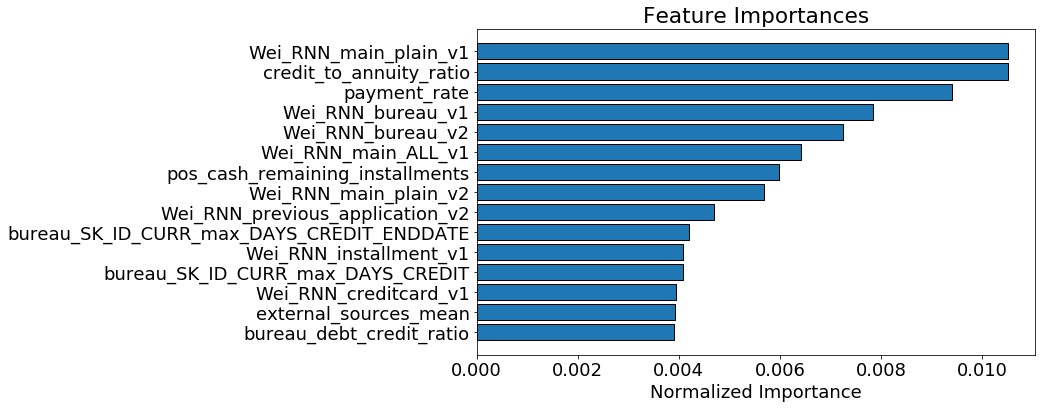

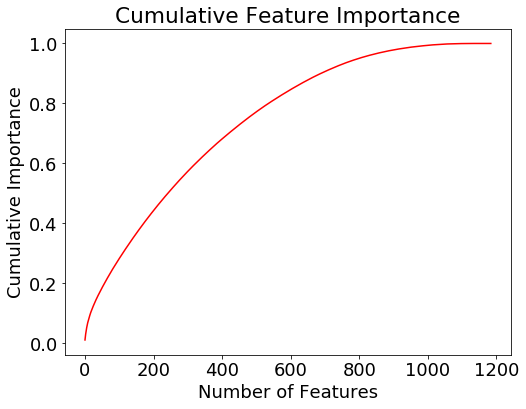

690 features required for 0.90 of cumulative importance


In [234]:
# feature_importances = pickle.load(open('../selection_comb_bo2_op5f4_simfe/fe_imp_corr_nan_df.pkl','rb'))
split_norm_fe_imp = plot_feature_importances(split_imp)

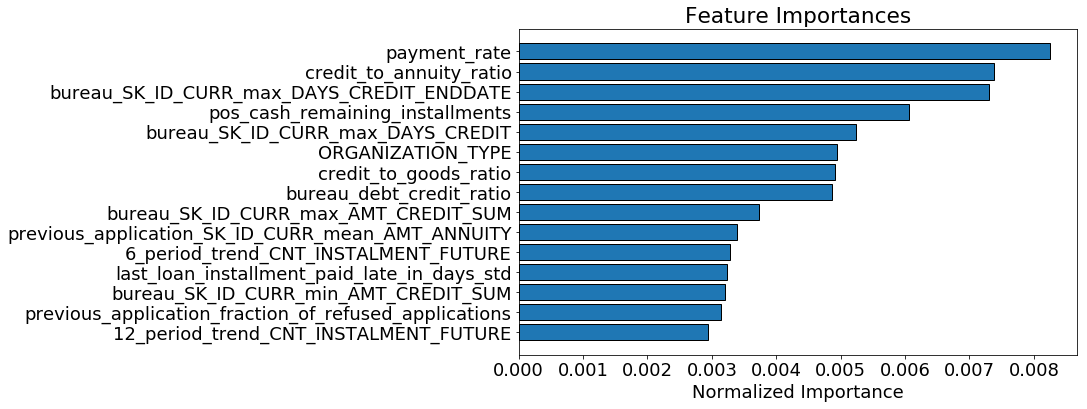

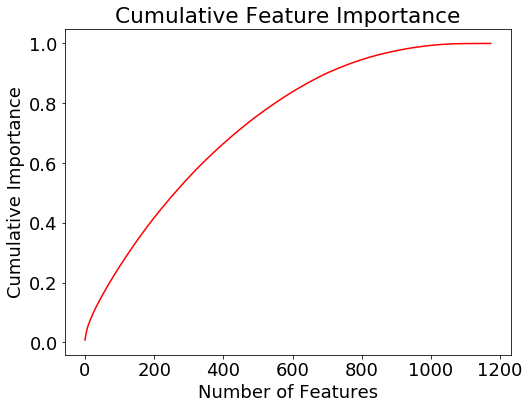

699 features required for 0.90 of cumulative importance


In [207]:
# feature_importances = pickle.load(open('../selection_comb_bo2_op5f4_simfe/fe_imp_corr_nan_df.pkl','rb'))
split_norm_fe_imp = plot_feature_importances(split_imp)